In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy.stats import pearsonr

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# start by importing data

In [3]:
#reading in train.csv of datasets

df_pre_initial_working_data=pd.read_csv('../datasets/train.csv')


In [4]:
df_initial_working_data=pd.DataFrame.copy(df_pre_initial_working_data)

In [5]:
# correcting typo in an entry found later when doing joint plot:
df_initial_working_data.loc[1699,'Garage Yr Blt']=2007

In [6]:
#printing shape and head for initial look and size of dataframe

print(df_initial_working_data.shape)
df_initial_working_data.head()

(2051, 81)


Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [7]:
#reading in test.csv of datasets

df_holdout_data=pd.read_csv('../datasets/test.csv')

In [8]:
#printing shape and head for initial look and size of dataframe

print(df_holdout_data.shape)
df_holdout_data.head()

(879, 80)


Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   
2   NaN          NaN        0       9     2006        New  
3   NaN          NaN        0       7     2007        WD   
4   NaN          NaN        0       7     2009        WD   

[5 rows x 80 columns]

In [9]:
#reading in sample_sub_reg.csv of datasets

df_sample_sub_reg=pd.read_csv('../datasets/sample_sub_reg.csv')

In [10]:
#printing shape and head for initial look and size of dataframe

print(df_sample_sub_reg.shape)
df_sample_sub_reg.head()

(879, 2)


Id    SalePrice
0   2  181479.1217
1   4  181479.1217
2   6  181479.1217
3   7  181479.1217
4  17  181479.1217

In [11]:
# assuming that test.csv will be our holdout dataset, and train.csv is our dataset for building our model

In [12]:
# show breakdown of columns with null entries

#creating dataframe of count of null values
null_values_df=pd.DataFrame(df_initial_working_data.isnull().sum())

#renaming column
null_values_df.rename(columns={0: 'count_of_null_values'}, errors="raise",inplace=True)

# displaying by filtering
null_values_df[null_values_df.count_of_null_values!=0]

count_of_null_values
Lot Frontage                     330
Alley                           1911
Mas Vnr Type                      22
Mas Vnr Area                      22
Bsmt Qual                         55
Bsmt Cond                         55
Bsmt Exposure                     58
BsmtFin Type 1                    55
BsmtFin SF 1                       1
BsmtFin Type 2                    56
BsmtFin SF 2                       1
Bsmt Unf SF                        1
Total Bsmt SF                      1
Bsmt Full Bath                     2
Bsmt Half Bath                     2
Fireplace Qu                    1000
Garage Type                      113
Garage Yr Blt                    114
Garage Finish                    114
Garage Cars                        1
Garage Area                        1
Garage Qual                      114
Garage Cond                      114
Pool QC                         2042
Fence                           1651
Misc Feature                    1986

In [13]:
# function to rough process 'Continuous' or 'Discrete' columns
# fine processing and ordered assignment of values is only done for variables with high coeff with SalePrice


def rough_process_condis_func(df_corr_from_check_corr_func,variable_colname_as_str,drop_nan_yes_or_no):
    

    df_corr_rough_process_condis=pd.DataFrame.copy(df_corr_from_check_corr_func)

    # counting nan
    print(df_corr_rough_process_condis.isnull().sum())
    
    if (df_corr_rough_process_condis.isnull().sum().sum())==0:
        print(f"There are no entries with null values in '{variable_colname_as_str}'.\n")
    
        # displaying value_counts
        print("These are the value_counts.\n")
        print(df_corr_rough_process_condis[variable_colname_as_str].value_counts())
    
    elif (df_corr_rough_process_condis.isnull().sum().sum())!=0:
        print(f"There are some entries with null values in '{variable_colname_as_str}'.\n")
    
        # if drop_nan_yes_or_no is 'Yes', to drop all rows with NaN values, 
        if drop_nan_yes_or_no == 'Yes' or drop_nan_yes_or_no == 'yes':
            if df_corr_rough_process_condis.isnull().sum().sum()!=0:
                df_corr_rough_process_condis.dropna(inplace=True)
                
        # if drop_nan_yes_or_no is 'No', to replace NaN values with 'Unknown'
        elif drop_nan_yes_or_no == 'No' or drop_nan_yes_or_no == 'no':
            df_corr_rough_process_condis[variable_colname_as_str].fillna('Unknown', inplace=True)
        
        # post nan processing printout to verify
        print('\nAfter null value processing, this is the new null count.\n')
        print(df_corr_rough_process_condis.isnull().sum())
        print('\nAfter null value processing, these are the new value_counts.\n')
        print(df_corr_rough_process_condis[variable_colname_as_str].value_counts())

    return (df_corr_rough_process_condis)

In [14]:
# function to rough process 'Ordinal' columns
# fine processing and ordered assignment of values is only done for variables with high coeff with SalePrice


def rough_process_ordinal_func(df_corr_from_check_corr_func,variable_colname_as_str,drop_nan_yes_or_no,ordinal_string):

    df_corr_rough_process_ordinal=pd.DataFrame.copy(df_corr_from_check_corr_func)

    # counting nan
    print(df_corr_rough_process_ordinal.isnull().sum())
    
    if (df_corr_rough_process_ordinal.isnull().sum().sum())==0:
        print(f"There are no entries with null values in '{variable_colname_as_str}'.\n")
        
        # displaying value_counts
        print("These are the value_counts.\n")
        print(df_corr_rough_process_ordinal[variable_colname_as_str].value_counts())
    
    elif (df_corr_rough_process_ordinal.isnull().sum().sum())!=0:
        print(f"There are some entries with null values in '{variable_colname_as_str}'.\n")
        
        # if drop_nan_yes_or_no is 'Yes', to drop all rows with NaN values, 
        if drop_nan_yes_or_no == 'Yes' or drop_nan_yes_or_no == 'yes':
            if df_corr_rough_process_ordinal.isnull().sum().sum()!=0:
                df_corr_rough_process_ordinal.dropna(inplace=True)
                
        # if drop_nan_yes_or_no is 'No', to replace nan values with 'Unknown'
        elif drop_nan_yes_or_no == 'No' or drop_nan_yes_or_no == 'no':
            df_corr_rough_process_ordinal[variable_colname_as_str].fillna('Unknown', inplace=True)

        # post nan processing printout to verify
        print('\nAfter null value processing, this is the new null count.\n')
        print(df_corr_rough_process_ordinal.isnull().sum())
        print('\nAfter null value processing, these are the new value_counts.\n')
        print(df_corr_rough_process_ordinal[variable_colname_as_str].value_counts())

    # printing set of all possible values just to check
    print(f"\nSet of all possible values for column {set(df_corr_rough_process_ordinal[variable_colname_as_str])}\n")

    # initialising list starting with element Unknown
    list_of_possible_column_values=[]

    # extending list with split of string keyed in for full range of possible ordinal str values
    list_of_possible_column_values.extend(ordinal_string.split(','))

    # showing list of all possible column values
    print(f"\nList of all possible values for column, including 'Unknown' for '{variable_colname_as_str}': {list_of_possible_column_values}\n")

    # converting str values in column 'variable_colname_as_str' to integer ordered values
    df_ordinal_values_converted=pd.DataFrame(df_corr_rough_process_ordinal[variable_colname_as_str].map(lambda x: list_of_possible_column_values.index(x)))

    # printing unconverted and converted value_counts to check conversion accuracy
    print(df_corr_rough_process_ordinal[variable_colname_as_str].value_counts())
    print(df_ordinal_values_converted[variable_colname_as_str].value_counts())

    # df_corr_rough_process_ordinal is the dataframe we return back to check_corr_func
    # containing converted ordinal values with corresponding SalePrice
    df_corr_rough_process_ordinal_return=pd.concat([df_ordinal_values_converted,pd.DataFrame(df_corr_rough_process_ordinal['SalePrice'])],axis='columns')

    return(df_corr_rough_process_ordinal_return)

In [15]:
# function to rough process 'Nominal' columns
# fine processing and ordered assignment of values is only done for variables with high coeff with SalePrice


def rough_process_nominal_func(df_corr_from_check_corr_func,variable_colname_as_str,drop_nan_yes_or_no):
    

    df_corr_rough_process_nominal=pd.DataFrame.copy(df_corr_from_check_corr_func)

    # counting nan
    print(df_corr_rough_process_nominal.isnull().sum())
    
    if (df_corr_rough_process_nominal.isnull().sum().sum())==0:
        print(f"There are no entries with null values in '{variable_colname_as_str}'.\n")
        
        # displaying value_counts
        print("These are the value_counts.\n")
        print(df_corr_rough_process_nominal[variable_colname_as_str].value_counts())
        
    elif (df_corr_rough_process_nominal.isnull().sum().sum())!=0:
        print(f"There are some entries with null values in '{variable_colname_as_str}'.\n")   
        
        # if drop_nan_yes_or_no is 'Yes', to drop all rows with NaN values,
        if drop_nan_yes_or_no == 'Yes' or drop_nan_yes_or_no == 'yes':
            if df_corr_rough_process_nominal.isnull().sum().sum()!=0:
                df_corr_rough_process_nominal.dropna(inplace=True)
        
        # if drop_nan_yes_or_no is 'No', to replace nan values with 'Unknown'
        elif drop_nan_yes_or_no == 'No' or drop_nan_yes_or_no == 'no':
            # replacing nan values with 'Unknown'
            df_corr_rough_process_nominal[variable_colname_as_str].fillna('Unknown', inplace=True)
            
        # post nan processing printout to verify
        print('\nAfter null value processing, this is the new null count.\n')
        print(df_corr_rough_process_nominal.isnull().sum())
        print('\nAfter null value processing, these are the new value_counts.\n')
        print(df_corr_rough_process_nominal[variable_colname_as_str].value_counts())

    
    # converting nominal columns with int or float values into str
    if type(df_corr_rough_process_nominal[variable_colname_as_str]) != str:
        df_corr_rough_process_nominal=pd.DataFrame(df_corr_rough_process_nominal[variable_colname_as_str].map(lambda x: str(x)))

    # converting a categorical column into a one-hot encoded matrix; making subset df of dummy variables 
    dummy_var_df=pd.get_dummies(df_corr_rough_process_nominal[[variable_colname_as_str]])

    df_corr_rough_process_nominal_return=pd.concat([dummy_var_df,pd.DataFrame(df_corr_from_check_corr_func['SalePrice'])],axis='columns')

    return (df_corr_rough_process_nominal_return)

In [16]:
def custom_heatmap_func (df_corr, figsize_var):
    
    # Set the default matplotlib figure size to figsize_varxfigsize_var:
    fig, ax = plt.subplots(figsize=(figsize_var,figsize_var))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(df_corr.corr(), mask=mask, ax=ax, annot=True, annot_kws={"size": 20})


    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=20, rotation = 45)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=20, rotation = 0)


    # code below done to align heatmap
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
    return


In [17]:
def custom_jointplot_func (df_corr, variable_colname_as_str, figsize_var):
    
    sns.axes_style('white')
    ax=sns.jointplot(variable_colname_as_str, "SalePrice", data=df_corr, kind='reg');
    
    
    return
 

## ANS:

Note that the check_corr for non numericals doesnt seem that meaningful, due to no scaling, and even for 
dummy variables 1 and 0 is too steep a divide for a range as diverse as price. 

Logically, expensive items such as a basement may add a fixed constant min price to the house.
More meaningful to explore only true ordinal categories with scaling factored in.

Dummy variables and one-hot encoding was still done, to explore any correlations.

Joint distribution and correlation graphs were plotted for each predictor.

For nominal predictor variables, heatmaps were also examined for their Pearson's coefficient to gauge their significance.

Due to repetitive rationale for not picking variables as predictors and the sheer number of columns, descriptions given for about 40-50 of the variables.

Variables chosen as predictors will be described in a separate file called finalised_predictor_variables.


In [18]:

# defining function check_corr_func to check correlation of individual variables against target
# pass in variable_colname_as_str, and cate_type as 'Nominal','Ordinal' or 'Numerical'

def check_corr_func (variable_colname_as_str, cate_type, drop_nan_yes_or_no, ordinal_string):
    
    df_corr=pd.DataFrame.copy((df_initial_working_data[[variable_colname_as_str,'SalePrice',]]))

    # insert function to convert ordinal columns' values to int if needed
    if cate_type == 'Continuous' or cate_type == 'Discrete':
        df_corr=rough_process_condis_func(df_corr,variable_colname_as_str,drop_nan_yes_or_no)        
        figsize_var=5    
      
    # insert function to create dummy variable columns as switch for nomimal columns (null rows dealt with within sub-function)
    elif cate_type == 'Nominal':
        df_corr=rough_process_nominal_func(df_corr,variable_colname_as_str,drop_nan_yes_or_no)
        figsize_var=50
    
    # insert function to convert values in ordinal variable columns to ordered integer values (null rows dealt with within sub-function)
    elif cate_type == 'Ordinal':
        df_corr=rough_process_ordinal_func(df_corr,variable_colname_as_str,drop_nan_yes_or_no,ordinal_string)
        figsize_var=5
    
  
    
    print('\n')
    print(df_corr.info())
    
    print('\n')
    print(df_corr.describe())
   
    
    
    
    # call custom_heatmap_func to display heatmap          
    custom_heatmap_func (df_corr, figsize_var)
    
    # if possible, call custom_jointplot_func to display distribution and cross plot
    if ((cate_type == 'Continuous' and drop_nan_yes_or_no == 'Yes') or (cate_type == 'Discrete' and drop_nan_yes_or_no == 'Yes') or (cate_type == 'Ordinal')):  
        custom_jointplot_func (df_corr, variable_colname_as_str, figsize_var)
    
    
    #custom_boxplot_func (df_corr, variable_colname_as_str, figsize_var)

   
    return

Id           0
SalePrice    0
dtype: int64
There are no entries with null values in 'Id'.

These are the value_counts.

2047    1
2787    1
1058    1
1060    1
1062    1
       ..
2550    1
2552    1
505     1
507     1
2049    1
Name: Id, Length: 2051, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Id         2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


                Id      SalePrice
count  2051.000000    2051.000000
mean   1474.033642  181469.701609
std     843.980841   79258.659352
min       1.000000   12789.000000
25%     753.500000  129825.000000
50%    1486.000000  162500.000000
75%    2198.000000  214000.000000
max    2930.000000  611657.000000


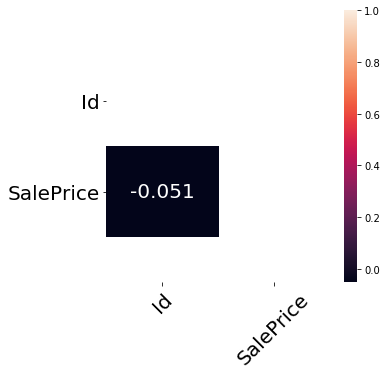

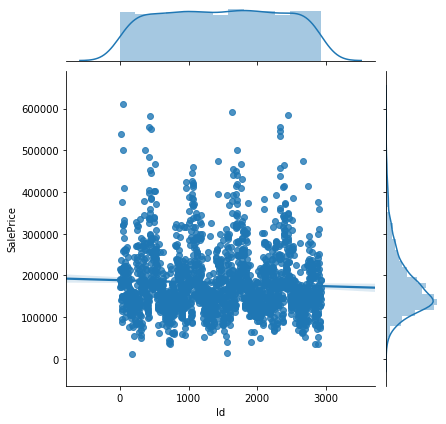

In [19]:
check_corr_func('Id','Discrete','Yes', '')


## ANS:

For Id, no null values, poor correlation with SalePrice as expected.
Drop the Id column as predictor variable.

Note the normal distribution of SalePrice.

PID          0
SalePrice    0
dtype: int64
There are no entries with null values in 'PID'.

These are the value_counts.

532351060    1
535303150    1
909250210    1
905377130    1
527403020    1
            ..
535403150    1
528477070    1
528104080    1
533120030    1
533250050    1
Name: PID, Length: 2051, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   PID        2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


                PID      SalePrice
count  2.051000e+03    2051.000000
mean   7.135900e+08  181469.701609
std    1.886918e+08   79258.659352
min    5.263011e+08   12789.000000
25%    5.284581e+08  129825.000000
50%    5.354532e+08  162500.000000
75%    9.071801e+08  214000.000000
max    9.241520e+08  611657.000000


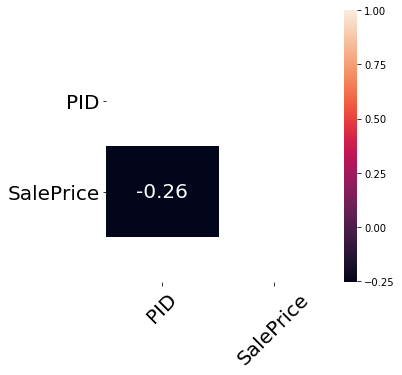

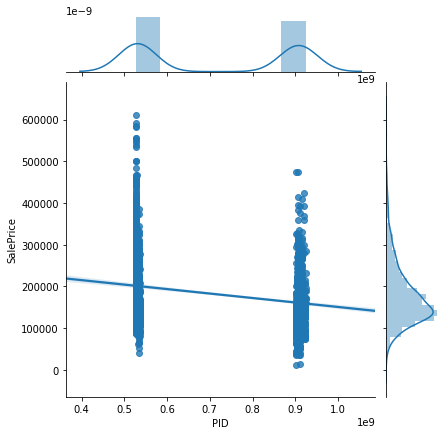

In [20]:
check_corr_func('PID','Discrete','Yes','')

## ANS:
For PID, no null values, -0.26 correlation with SalePrice, but no real logical relation. See the two peaks denoting 2 clusters of PID values, with SalePrices varying across entire vertical range within the narrow clusters.

Drop the PID column as predictor variable.


MS SubClass    0
SalePrice      0
dtype: int64
There are no entries with null values in 'MS SubClass'.

These are the value_counts.

20     770
60     394
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
45      11
180     11
40       4
150      1
Name: MS SubClass, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   MS SubClass_120  2051 non-null   uint8
 1   MS SubClass_150  2051 non-null   uint8
 2   MS SubClass_160  2051 non-null   uint8
 3   MS SubClass_180  2051 non-null   uint8
 4   MS SubClass_190  2051 non-null   uint8
 5   MS SubClass_20   2051 non-null   uint8
 6   MS SubClass_30   2051 non-null   uint8
 7   MS SubClass_40   2051 non-null   uint8
 8   MS SubClass_45   2051 non-null   uint8
 9   MS SubClass_50   2051 non-null   uint8
 10  MS SubClass_60   

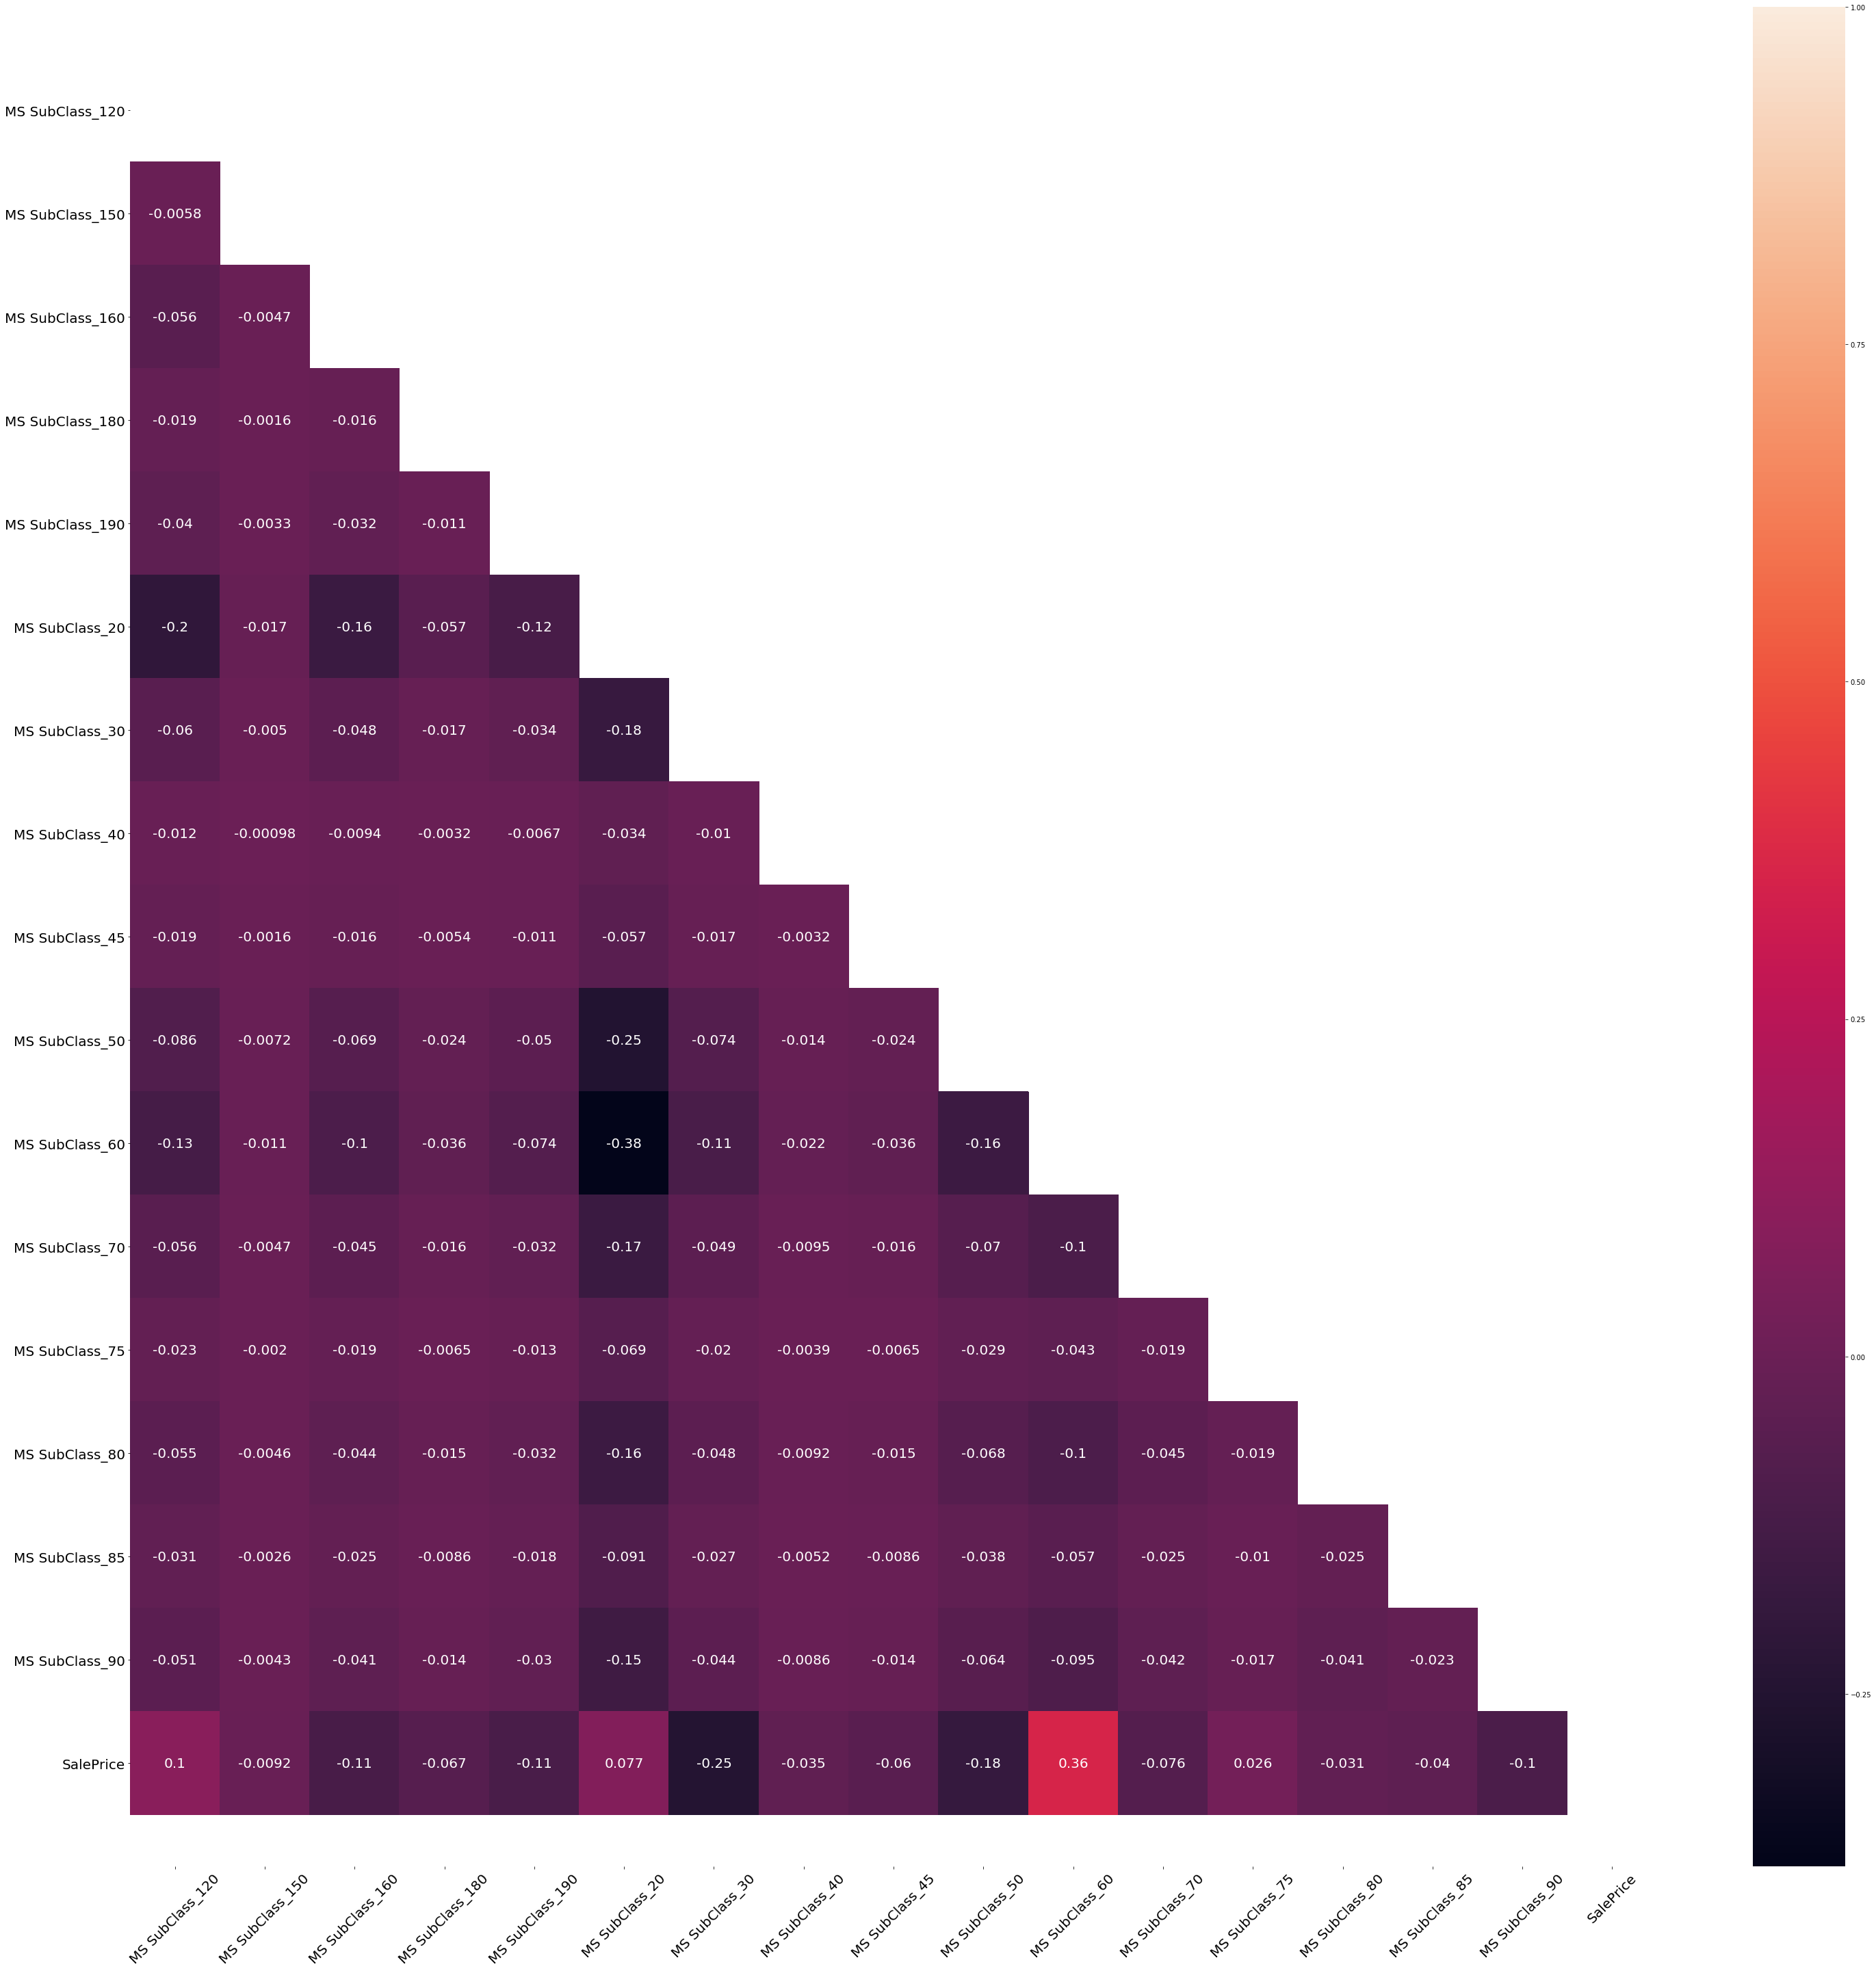

In [21]:
check_corr_func('MS SubClass','Nominal','Yes','')

## ANS:
For MS Subclass, no null values, generally poor correlation with SalePrice.

Only MS Subclass_60 has a 0.36 correlation to it.



## Consider using only MS Subclass_60, it has 394 out of 2051 entries. 19.2%.
## MS Subclass_50, correlation -0.18, 198/2051 entries, 9.7%.

MS Zoning    0
SalePrice    0
dtype: int64
There are no entries with null values in 'MS Zoning'.

These are the value_counts.

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64

Set of all possible values for column {'RH', 'I (all)', 'RM', 'FV', 'RL', 'C (all)', 'A (agr)'}


List of all possible values for column, including 'Unknown' for 'MS Zoning': ['Unknown', 'RP', 'I (all)', 'C (all)', 'A (agr)', 'RH', 'RM', 'FV', 'RL']

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64
8    1598
6     316
7     101
3      19
5      14
4       2
2       1
Name: MS Zoning, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   MS Zoning  2051 non-null   int64
 1   SalePrice 

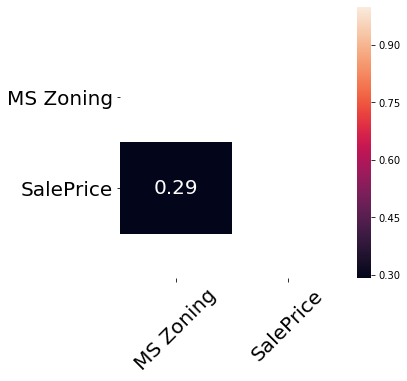

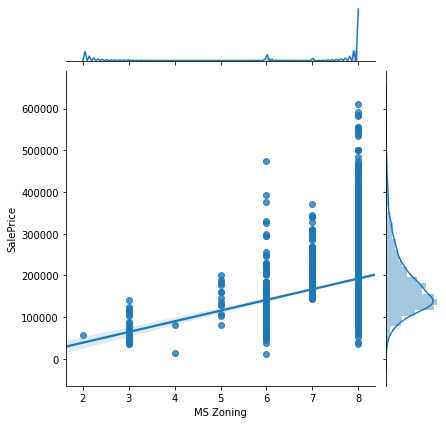

In [22]:
check_corr_func('MS Zoning','Ordinal','Yes','Unknown,RP,I (all),C (all),A (agr),RH,RM,FV,RL')

## ANS:

For MS Zoning, no null values, poor correlation with SalePrice, based on my assignment of values. Note high percentage of 6 which corresponds to Residential Low Density. 1598/2051 entries. 77.9%.

Readjusted assignment of values from 'Unknown,I (all),A (agr),FV,RH,RM,RL,RP,C (all)'
to 'Unknown,RP,I (all),C (all),A (agr),RH,RM,FV,RL'

Fit seemed better.

## Using MS Zoning as ordinal based on order: 'Unknown,RP,I (all),C (all),A (agr),RH,RM,FV,RL'.

Apply to holdout data.

Lot Frontage    330
SalePrice         0
dtype: int64
There are some entries with null values in 'Lot Frontage'.


After null value processing, this is the new null count.

Lot Frontage    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

60.0     179
70.0      96
80.0      94
50.0      90
65.0      71
        ... 
195.0      1
141.0      1
135.0      1
22.0       1
137.0      1
Name: Lot Frontage, Length: 118, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 1 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lot Frontage  1721 non-null   float64
 1   SalePrice     1721 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 40.3 KB
None


       Lot Frontage      SalePrice
count   1721.000000    1721.000000
mean      69.055200  180198.654852
std       23.260653   82480.345050
min       21.000000   12789.000000
25%       58.0

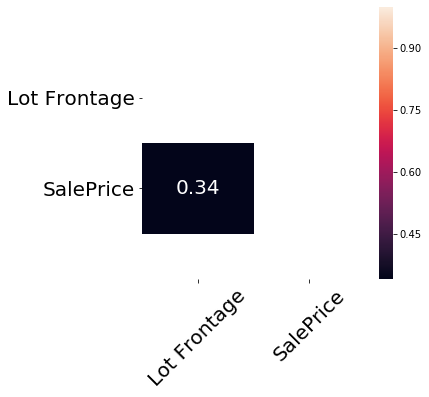

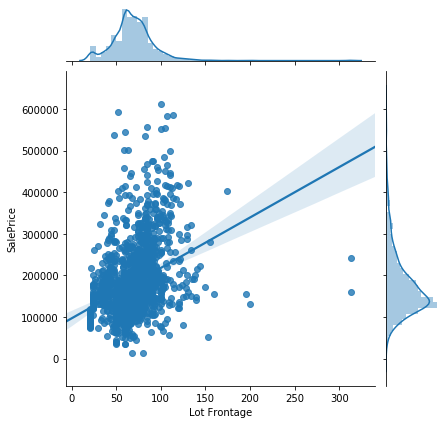

In [23]:
check_corr_func('Lot Frontage','Continuous','Yes','')

## ANS:

For Lot Frontage, there are 330 null entries.

Correlation seems visually good, 0.34, may have some outliers.

Normal distribution of data.

## Use Lot Frontage.

Has null values in holdout data.

Need to apply same imputation for NaN entries in test and holdout.


Lot Frontage    330
SalePrice         0
dtype: int64
There are some entries with null values in 'Lot Frontage'.


After null value processing, this is the new null count.

Lot Frontage    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    330
60.0       179
70.0        96
80.0        94
50.0        90
          ... 
153.0        1
150.0        1
144.0        1
141.0        1
137.0        1
Name: Lot Frontage, Length: 119, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Lot Frontage  2051 non-null   object
 1   SalePrice     2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max

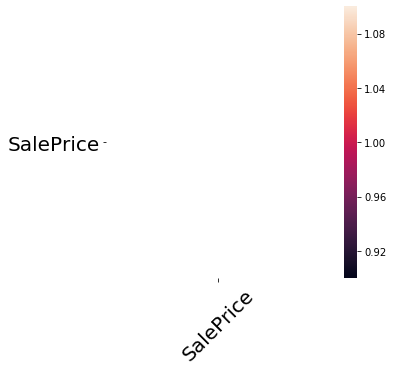

In [24]:
check_corr_func('Lot Frontage','Continuous','No','')

## ANS:

Not meaningful to replace NaN with Unknown for Lot Frontage.



Lot Area     0
SalePrice    0
dtype: int64
There are no entries with null values in 'Lot Area'.

These are the value_counts.

9600     34
7200     27
6000     26
10800    19
7500     18
         ..
12887     1
12891     1
10846     1
14948     1
12292     1
Name: Lot Area, Length: 1476, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Lot Area   2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


            Lot Area      SalePrice
count    2051.000000    2051.000000
mean    10065.208191  181469.701609
std      6742.488909   79258.659352
min      1300.000000   12789.000000
25%      7500.000000  129825.000000
50%      9430.000000  162500.000000
75%     11513.500000  214000.000000
max    159000.000000  611657.000000


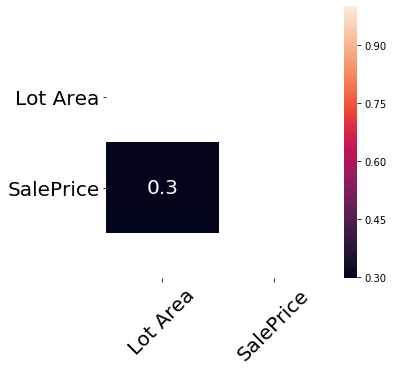

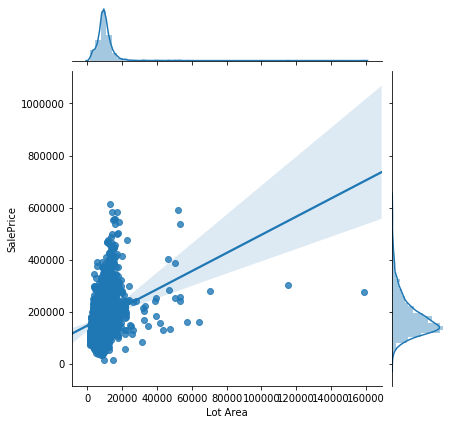

In [25]:
check_corr_func('Lot Area','Continuous','Yes','')

## ANS:

For Lot Area, there are no null entries.

Correlation seems visually good, 0.3, may have some outliers, there seem to be two linear relationships,
one for houses between 0 and 30,000 sqft, and another for 30,000 sqft to 70,000.
Beyond that few houses, and they can be seen as outliers. Consider dropping these.

## Use Lot Area.

Do feature engineering to split into 2 columns for houses of 2 size ranges. Likely to get higher correlation too. Unsure how to actually code it efficiently. If this is the only one that needs splitting,
split train and holdout data along these ranges, get two models, then combine back results, if time permits, else let the model iterate best fit parameters and coefficients.

Need to apply same imputation for NaN entries in test and holdout.



Street       0
SalePrice    0
dtype: int64
There are no entries with null values in 'Street'.

These are the value_counts.

Pave    2044
Grvl       7
Name: Street, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Street_Grvl  2051 non-null   uint8
 1   Street_Pave  2051 non-null   uint8
 2   SalePrice    2051 non-null   int64
dtypes: int64(1), uint8(2)
memory usage: 20.2 KB
None


       Street_Grvl  Street_Pave      SalePrice
count  2051.000000  2051.000000    2051.000000
mean      0.003413     0.996587  181469.701609
std       0.058335     0.058335   79258.659352
min       0.000000     0.000000   12789.000000
25%       0.000000     1.000000  129825.000000
50%       0.000000     1.000000  162500.000000
75%       0.000000     1.000000  214000.000000
max       1.000000     1.000000  611657.000000


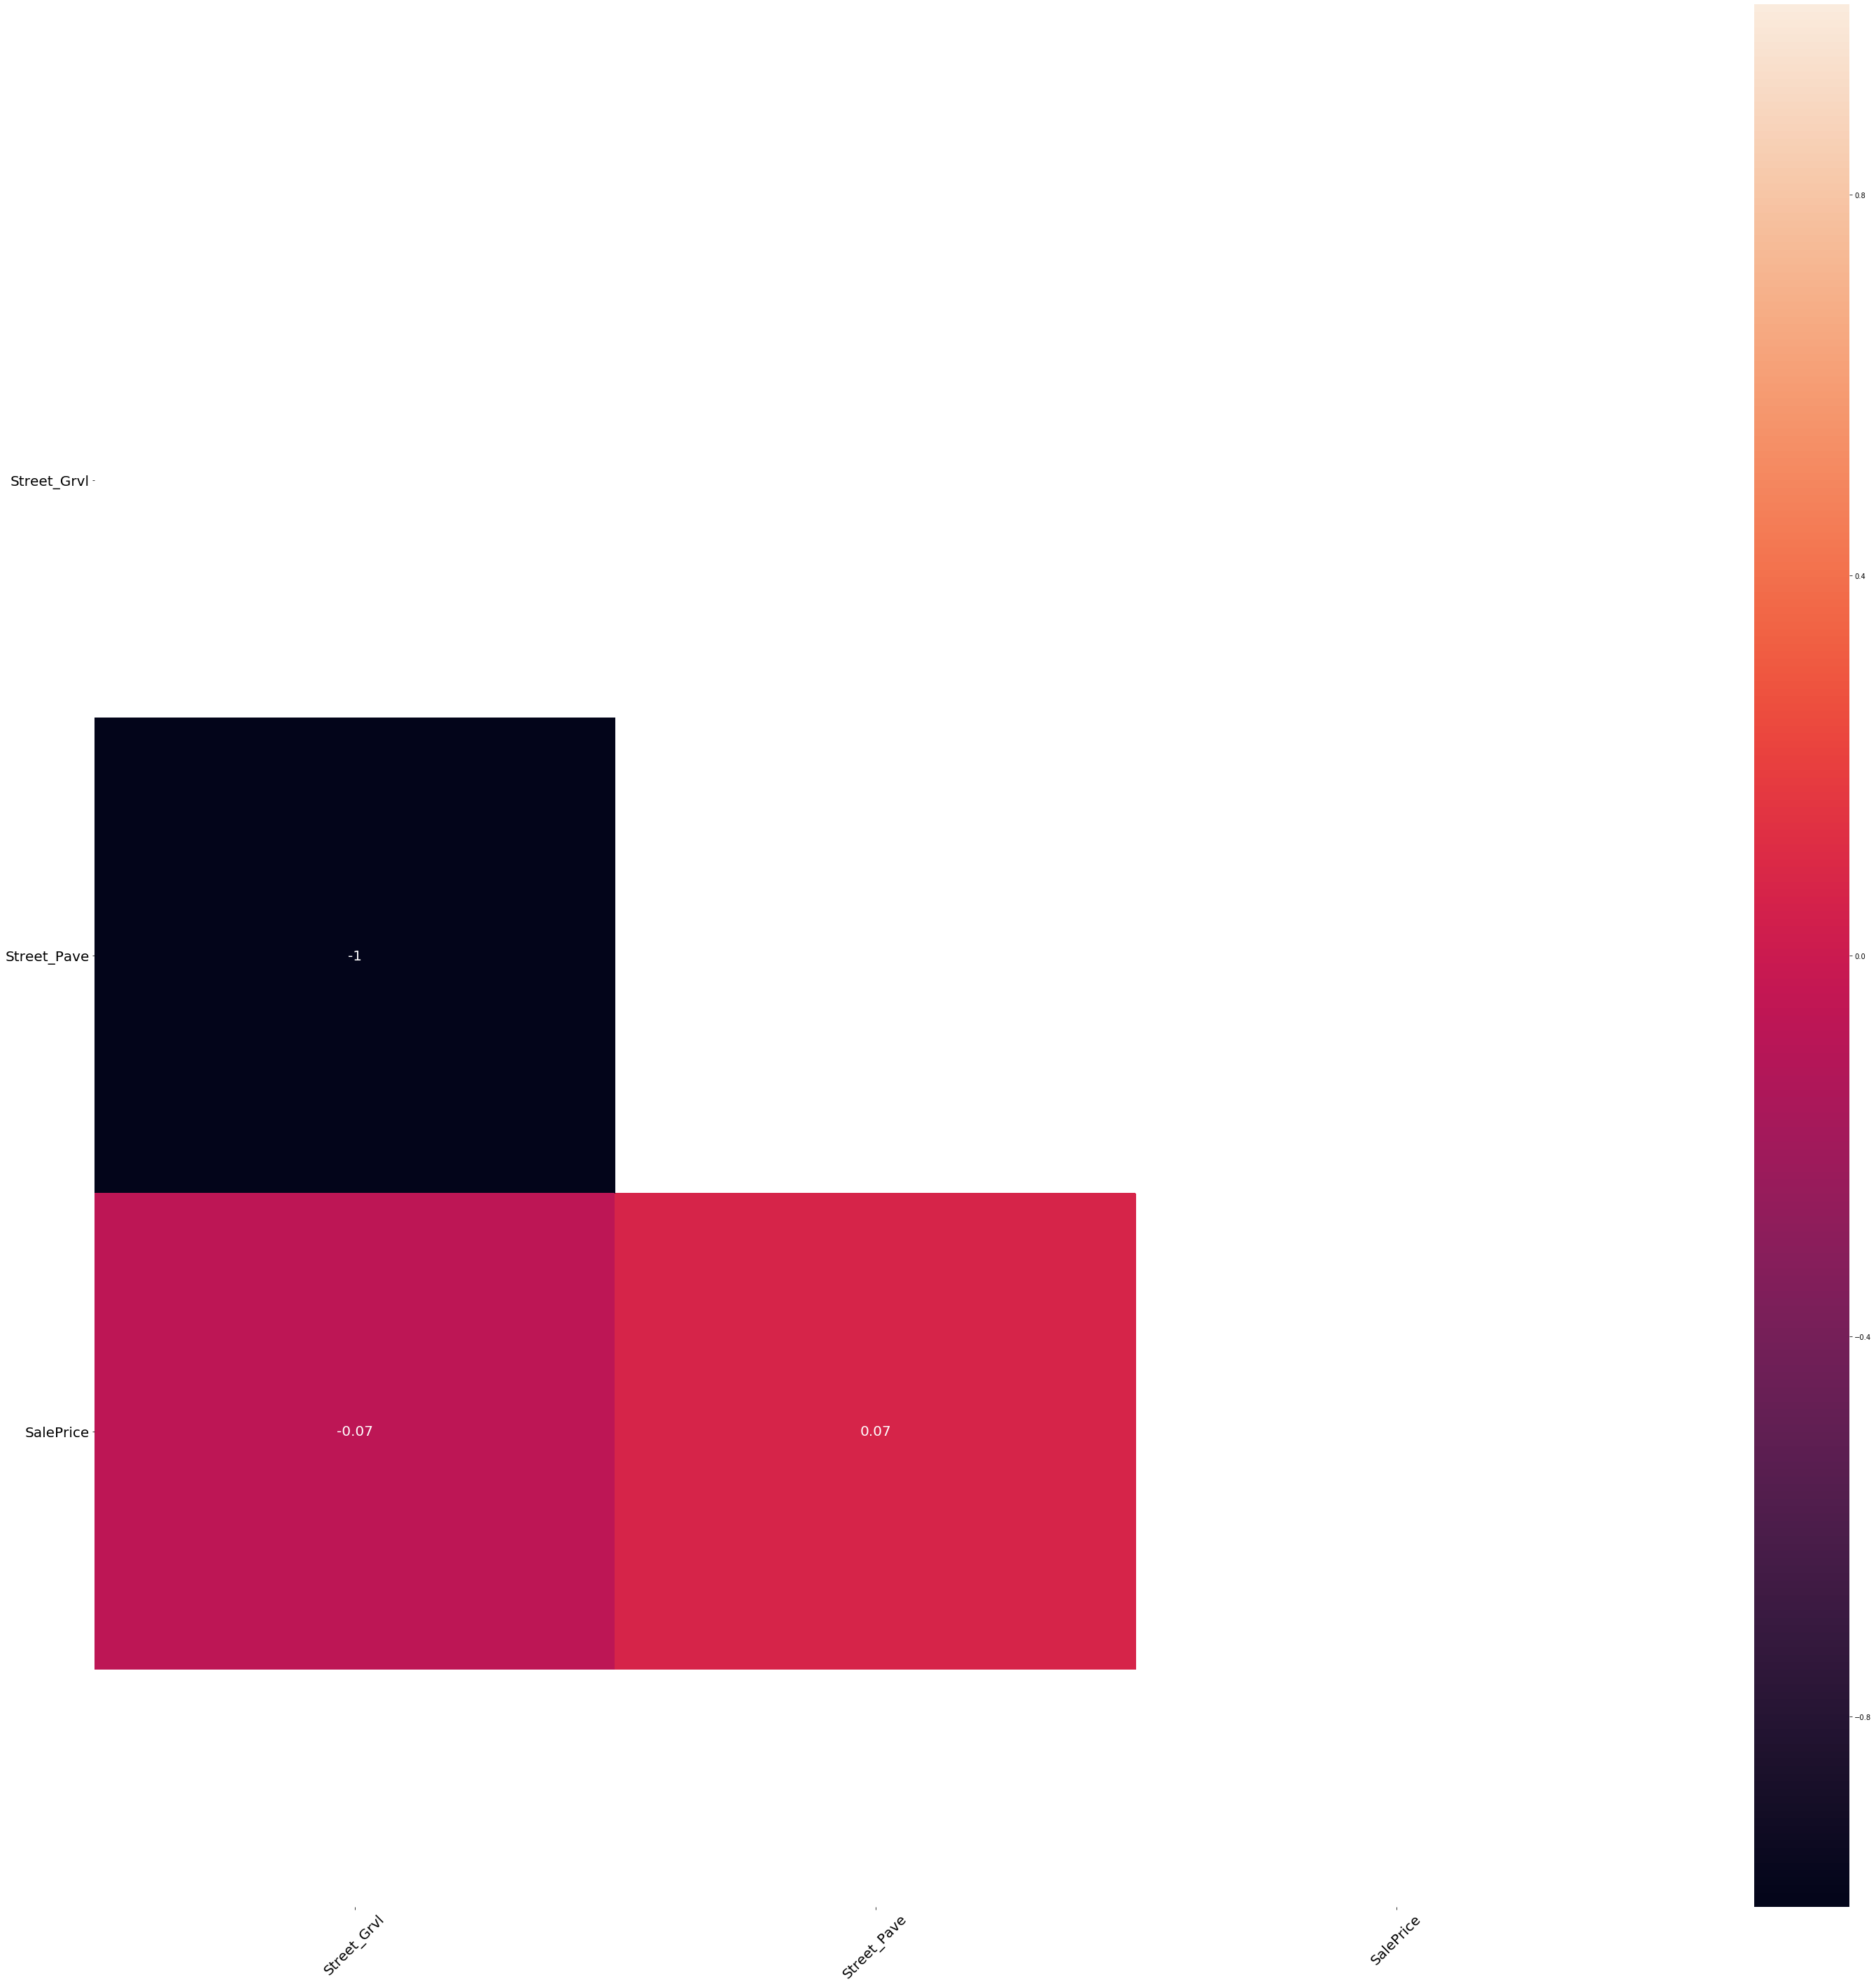

In [26]:
check_corr_func('Street','Nominal','Yes','')

## ANS:

For Street, there are no null entries.

Overwhelmingly, 2044/2051 are Gravel. Correlation with SalePrice is poor. 

Drop Street as predictor.



Alley        1911
SalePrice       0
dtype: int64
There are some entries with null values in 'Alley'.


After null value processing, this is the new null count.

Alley        0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

Grvl    85
Pave    55
Name: Alley, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Alley_Grvl  140 non-null    float64
 1   Alley_Pave  140 non-null    float64
 2   SalePrice   2051 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 64.1 KB
None


       Alley_Grvl  Alley_Pave      SalePrice
count  140.000000  140.000000    2051.000000
mean     0.607143    0.392857  181469.701609
std      0.490139    0.490139   79258.659352
min      0.000000    0.000000   12789.000000
25%      0.000000    0.000000  129825.000000
50%      1.000000    0.000000  162500.000000

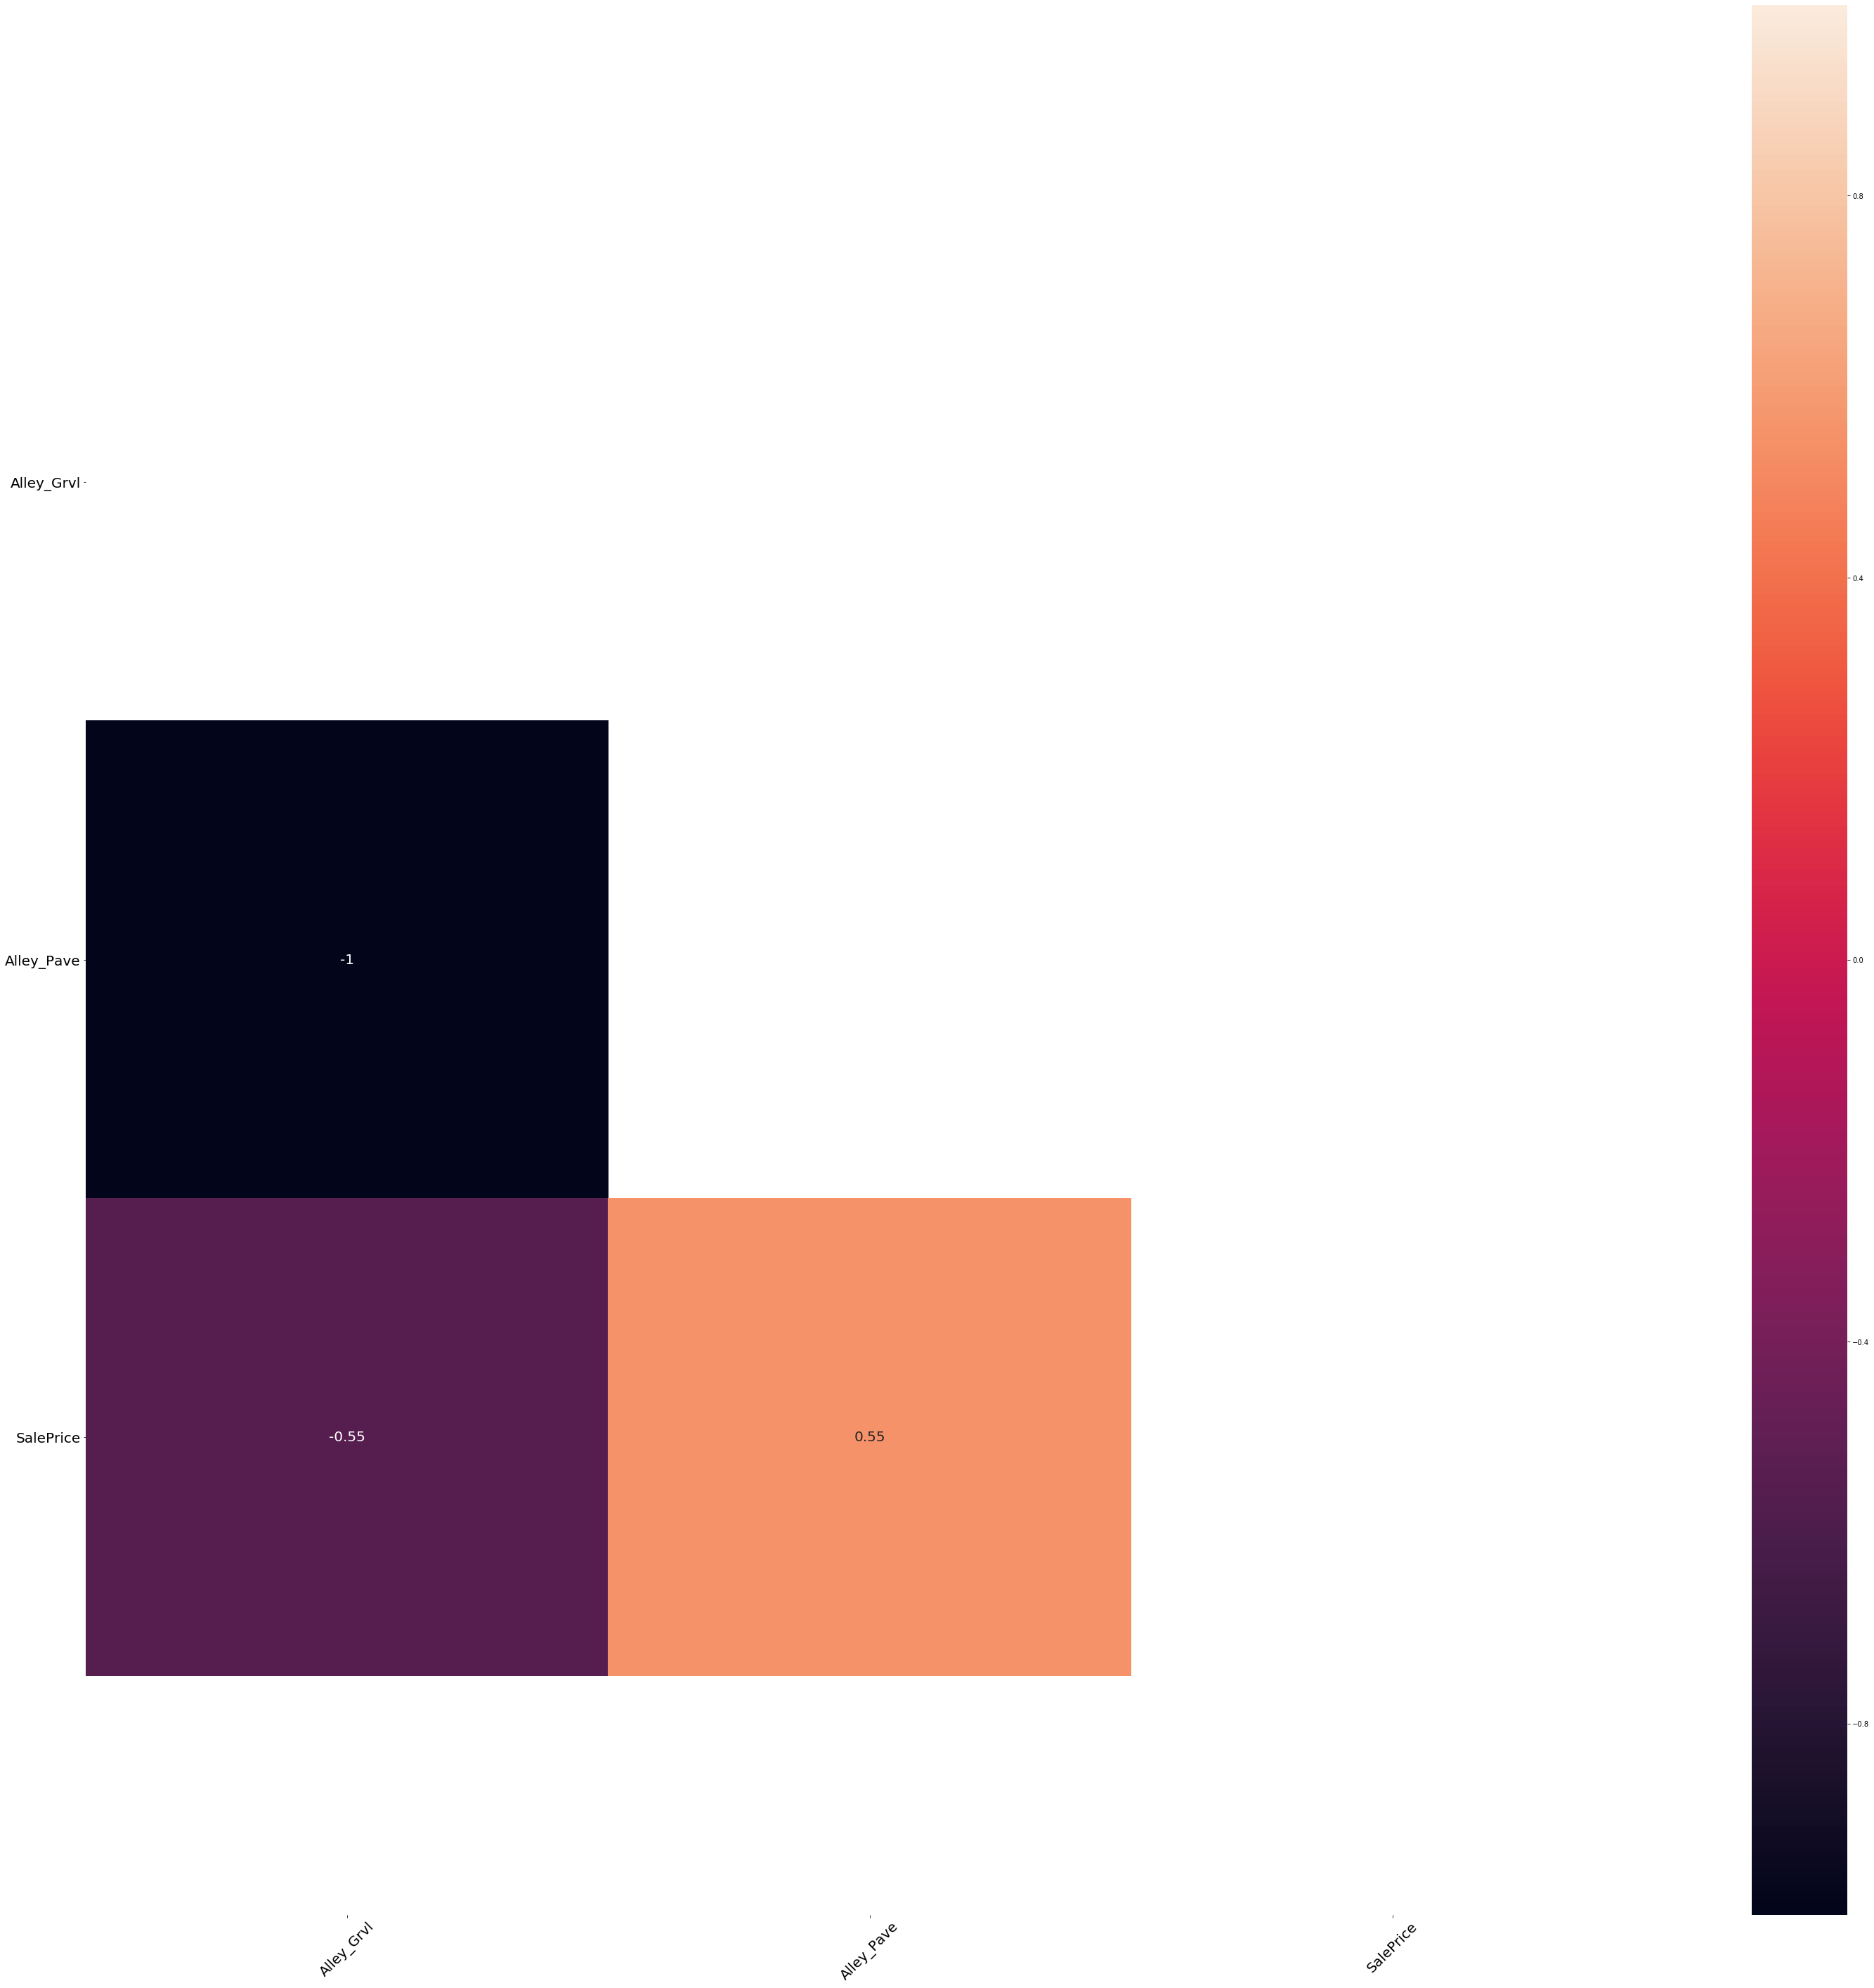

In [27]:
check_corr_func('Alley','Nominal','Yes','')

## ANS:

For Alley, there are 1911/2051 null entries.
Here these null entries actually indicate no Alley access.

Can't drop to EDA meaningfully, so do replace, see next cell.



Alley        1911
SalePrice       0
dtype: int64
There are some entries with null values in 'Alley'.


After null value processing, this is the new null count.

Alley        0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    1911
Grvl         85
Pave         55
Name: Alley, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Alley_Grvl     2051 non-null   uint8
 1   Alley_Pave     2051 non-null   uint8
 2   Alley_Unknown  2051 non-null   uint8
 3   SalePrice      2051 non-null   int64
dtypes: int64(1), uint8(3)
memory usage: 22.2 KB
None


        Alley_Grvl   Alley_Pave  Alley_Unknown      SalePrice
count  2051.000000  2051.000000    2051.000000    2051.000000
mean      0.041443     0.026816       0.931741  181469.701609
std       0.199362     0.161585       0.252252   79258.65

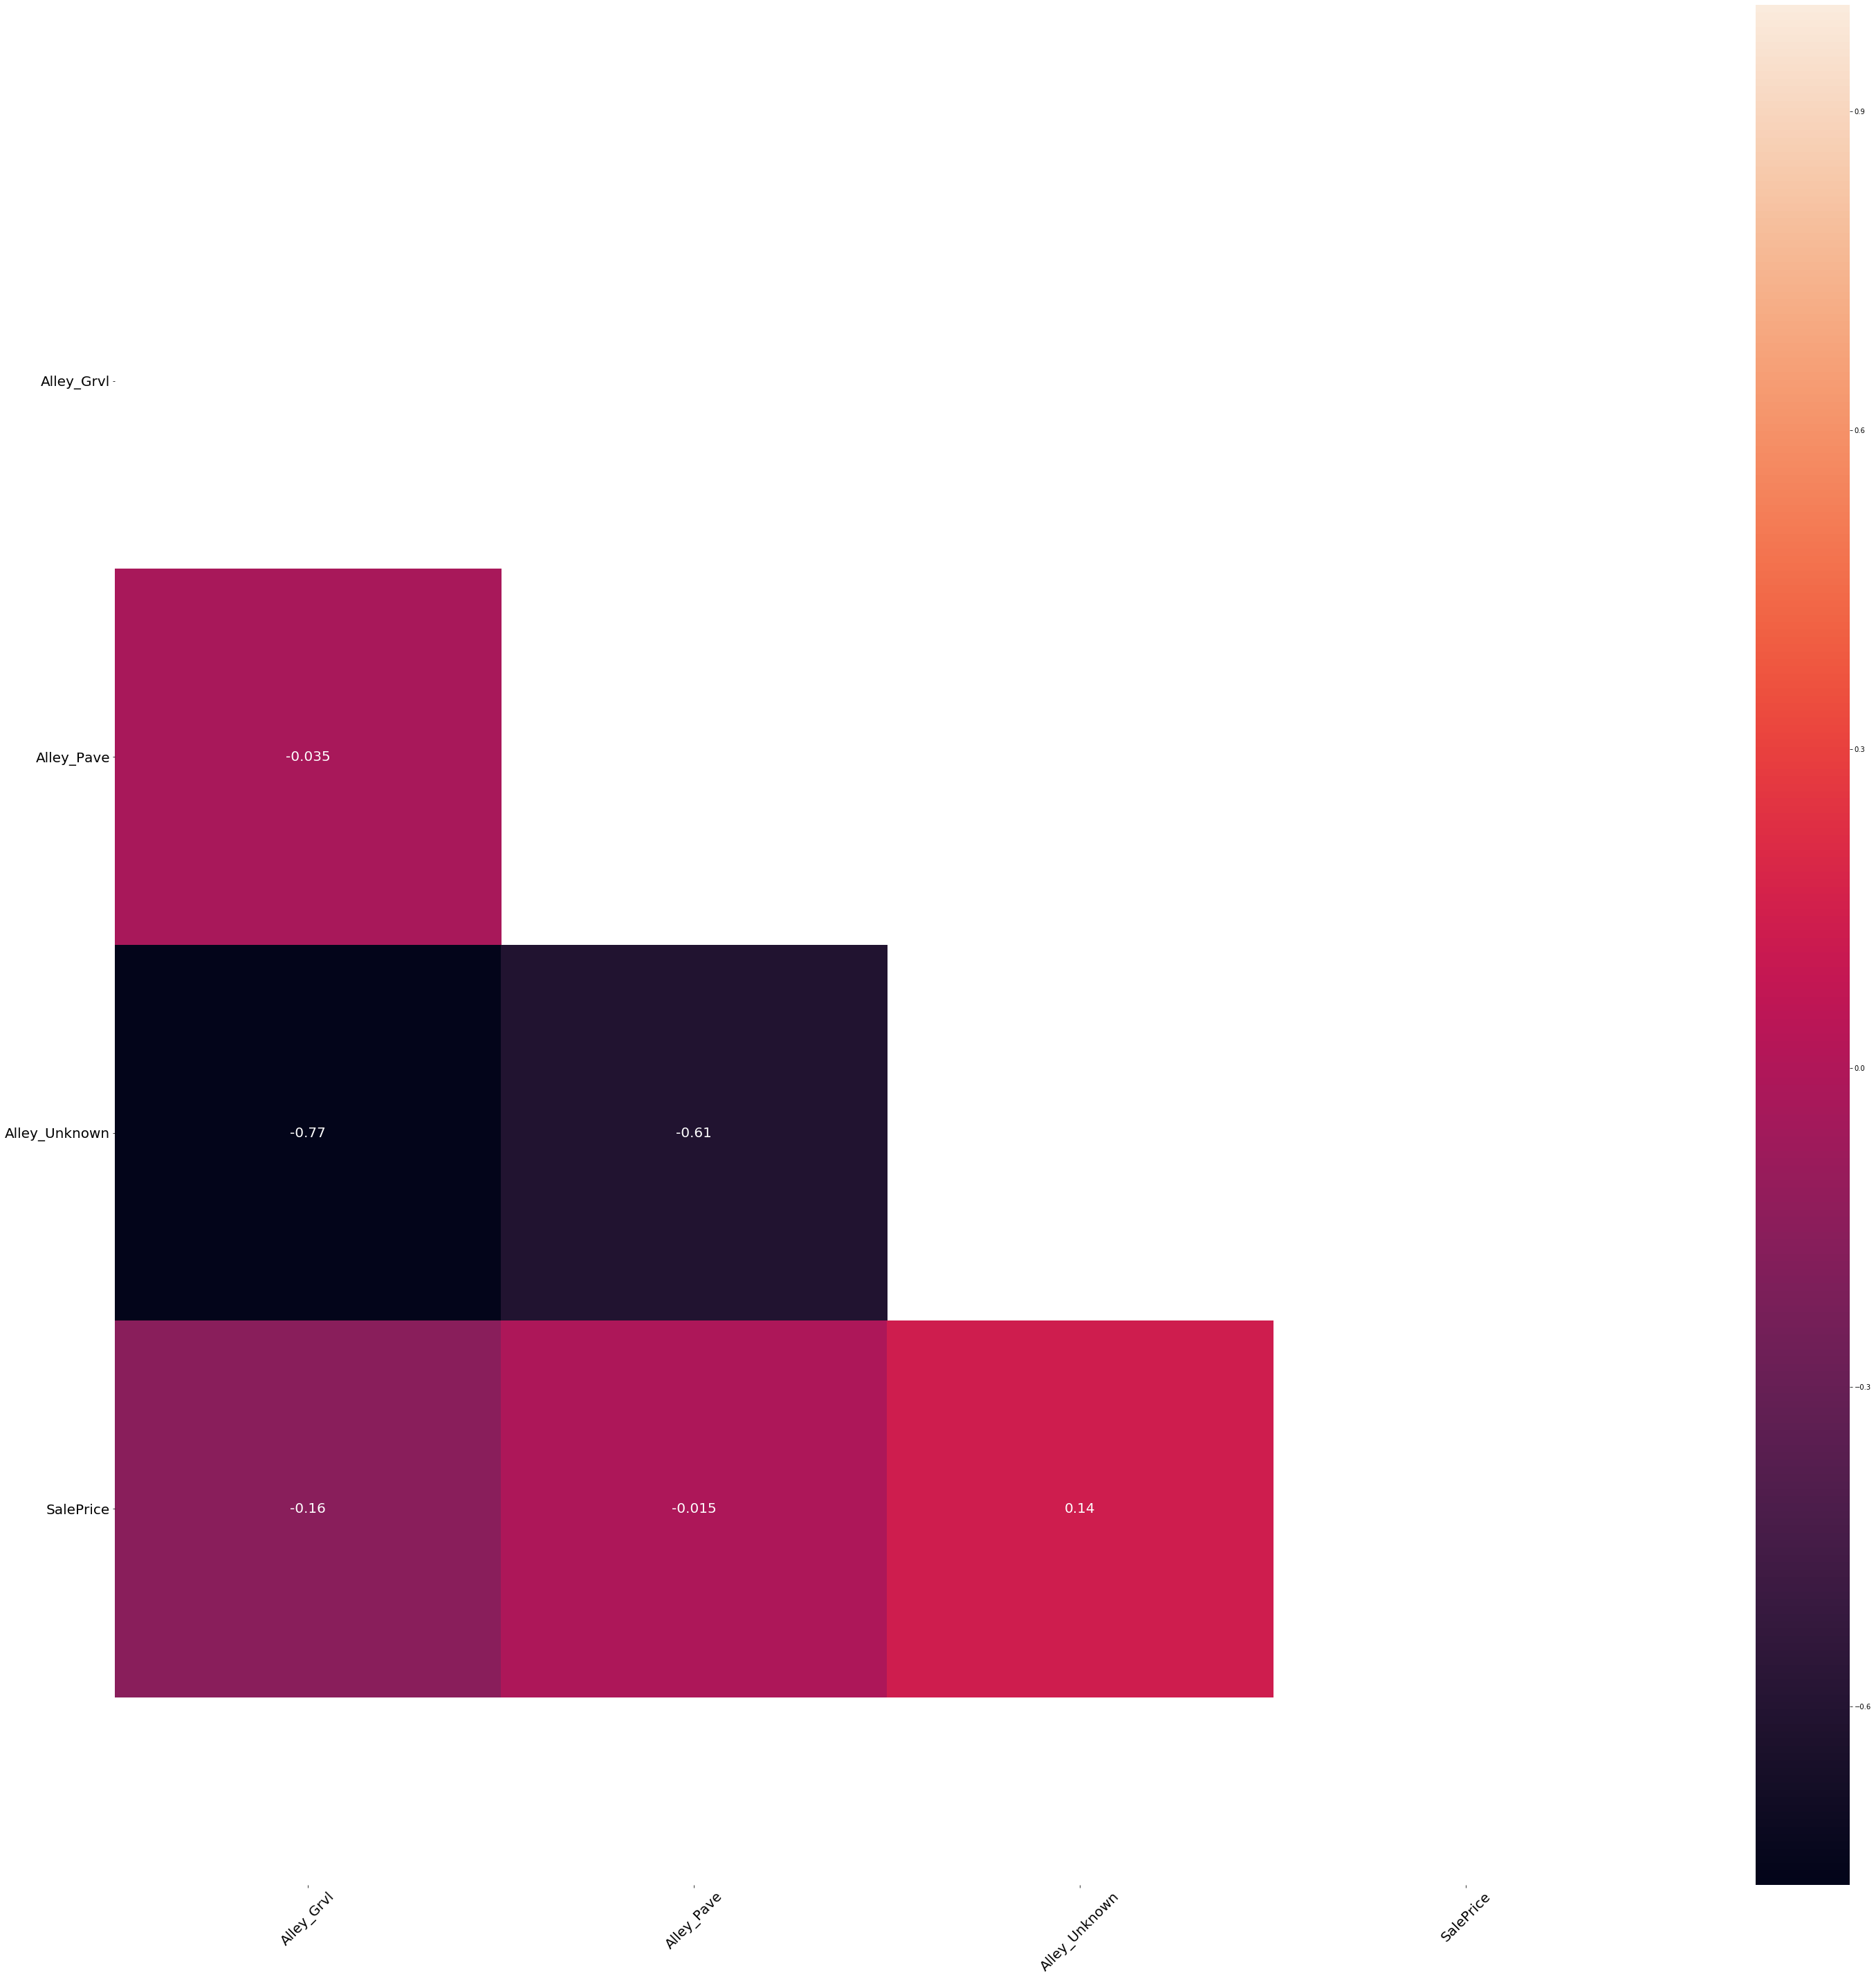

In [28]:
check_corr_func('Alley','Nominal','No','')

## ANS:

For Alley, there are 1911/2051 null entries.
Here these null entries actually indicate no Alley access.

Using dummy variable plots, correlation is still weak at 0.14 between SalePrice and No Alley Access.

SalePrice as continous variable with wide range makes a bad fit against a toggle of Alley Access or not.

Drop Alley as predictor. Apply to holdout too.




Lot Shape    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Lot Shape'.

These are the value_counts.

Reg    1295
IR1     692
IR2      55
IR3       9
Name: Lot Shape, dtype: int64

Set of all possible values for column {'IR1', 'Reg', 'IR2', 'IR3'}


List of all possible values for column, including 'Unknown' for 'Lot Shape': ['Unknown', 'IR3', 'IR2', 'IR1', 'Reg']

Reg    1295
IR1     692
IR2      55
IR3       9
Name: Lot Shape, dtype: int64
4    1295
3     692
2      55
1       9
Name: Lot Shape, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Lot Shape  2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


         Lot Shape      SalePrice
count  2051.000000    2051.000000
mean      3.595807  181469.701609
std       0.566514   79258.659352
min       1.00000

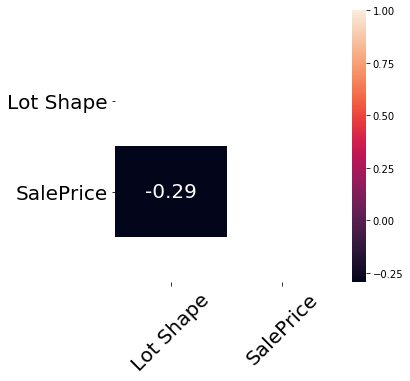

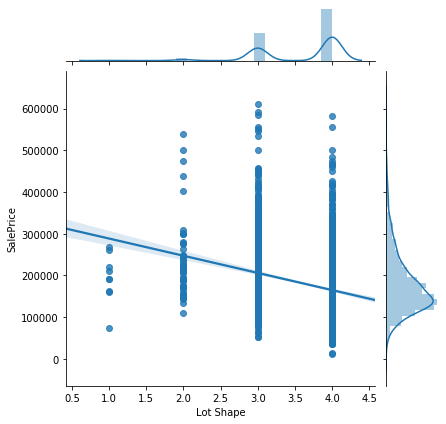

In [29]:
check_corr_func('Lot Shape','Ordinal','Yes','Unknown,IR3,IR2,IR1,Reg')

## ANS:

For Lot Shape, there are no null entries.

Most of the houses are either 1295/2051 (63.1%) Regular shaped, or 692/2051 (33.7%) IR1: Slightly irregular.

Although mathematically, correlation is decent at -0.29, SalePrice ranges too much for the same value of Lot Shape.

Drop Lot Shape as predictor.


Land Contour    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Land Contour'.

These are the value_counts.

Lvl    1843
HLS      85
Bnk      80
Low      43
Name: Land Contour, dtype: int64

Set of all possible values for column {'Low', 'HLS', 'Bnk', 'Lvl'}


List of all possible values for column, including 'Unknown' for 'Land Contour': ['Unknown', 'Low', 'Bnk', 'HLS', 'Lvl']

Lvl    1843
HLS      85
Bnk      80
Low      43
Name: Land Contour, dtype: int64
4    1843
3      85
2      80
1      43
Name: Land Contour, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Land Contour  2051 non-null   int64
 1   SalePrice     2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Land Contour      SalePrice
count    2051.00000    2051.000000
mean        3.81765  181469.701609
std         0.5

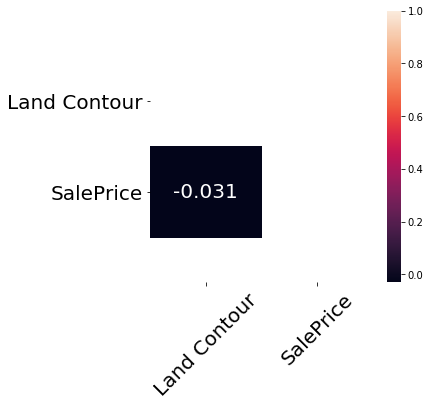

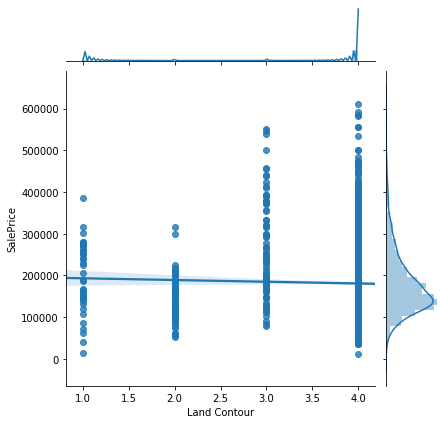

In [30]:
check_corr_func('Land Contour','Ordinal','Yes','Unknown,Low,Bnk,HLS,Lvl')

## ANS:

For Land Contour, there are no null entries.

Correlation weak at -0.031.

SalePrice ranges too much for the same value of Land Contour.

Drop Land Contour as predictor.

Utilities    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Utilities'.

These are the value_counts.

AllPub    2049
NoSeWa       1
NoSewr       1
Name: Utilities, dtype: int64

Set of all possible values for column {'AllPub', 'NoSewr', 'NoSeWa'}


List of all possible values for column, including 'Unknown' for 'Utilities': ['Unknown', 'ELO', 'NoSeWa', 'NoSewr', 'AllPub']

AllPub    2049
NoSeWa       1
NoSewr       1
Name: Utilities, dtype: int64
4    2049
3       1
2       1
Name: Utilities, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Utilities  2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


         Utilities      SalePrice
count  2051.000000    2051.000000
mean      3.998537  181469.701609
std       0.049365   79258.659352
min       2.000000   1

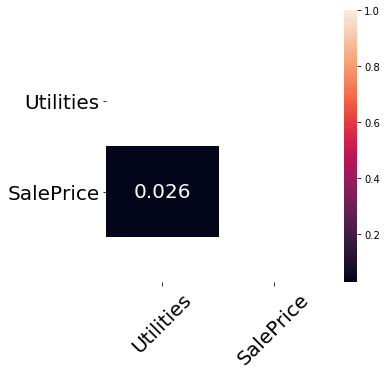

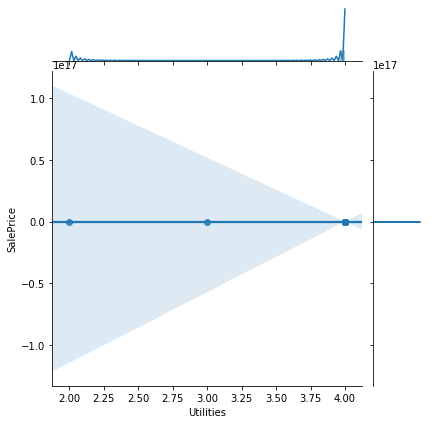

In [31]:
check_corr_func('Utilities','Ordinal','Yes','Unknown,ELO,NoSeWa,NoSewr,AllPub')

## ANS:

For Utilities, there are no null entries.

Correlation weak at -0.031. 2049/2051 are AllPub.

Meaningless predictor.

Drop Utilities as predictor.

Lot Config    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Lot Config'.

These are the value_counts.

Inside     1503
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: Lot Config, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Lot Config_Corner   2051 non-null   uint8
 1   Lot Config_CulDSac  2051 non-null   uint8
 2   Lot Config_FR2      2051 non-null   uint8
 3   Lot Config_FR3      2051 non-null   uint8
 4   Lot Config_Inside   2051 non-null   uint8
 5   SalePrice           2051 non-null   int64
dtypes: int64(1), uint8(5)
memory usage: 26.2 KB
None


       Lot Config_Corner  Lot Config_CulDSac  Lot Config_FR2  Lot Config_FR3  \
count        2051.000000         2051.000000     2051.000000     2051.000000   
mean            0.169673            0.063871        0.02925

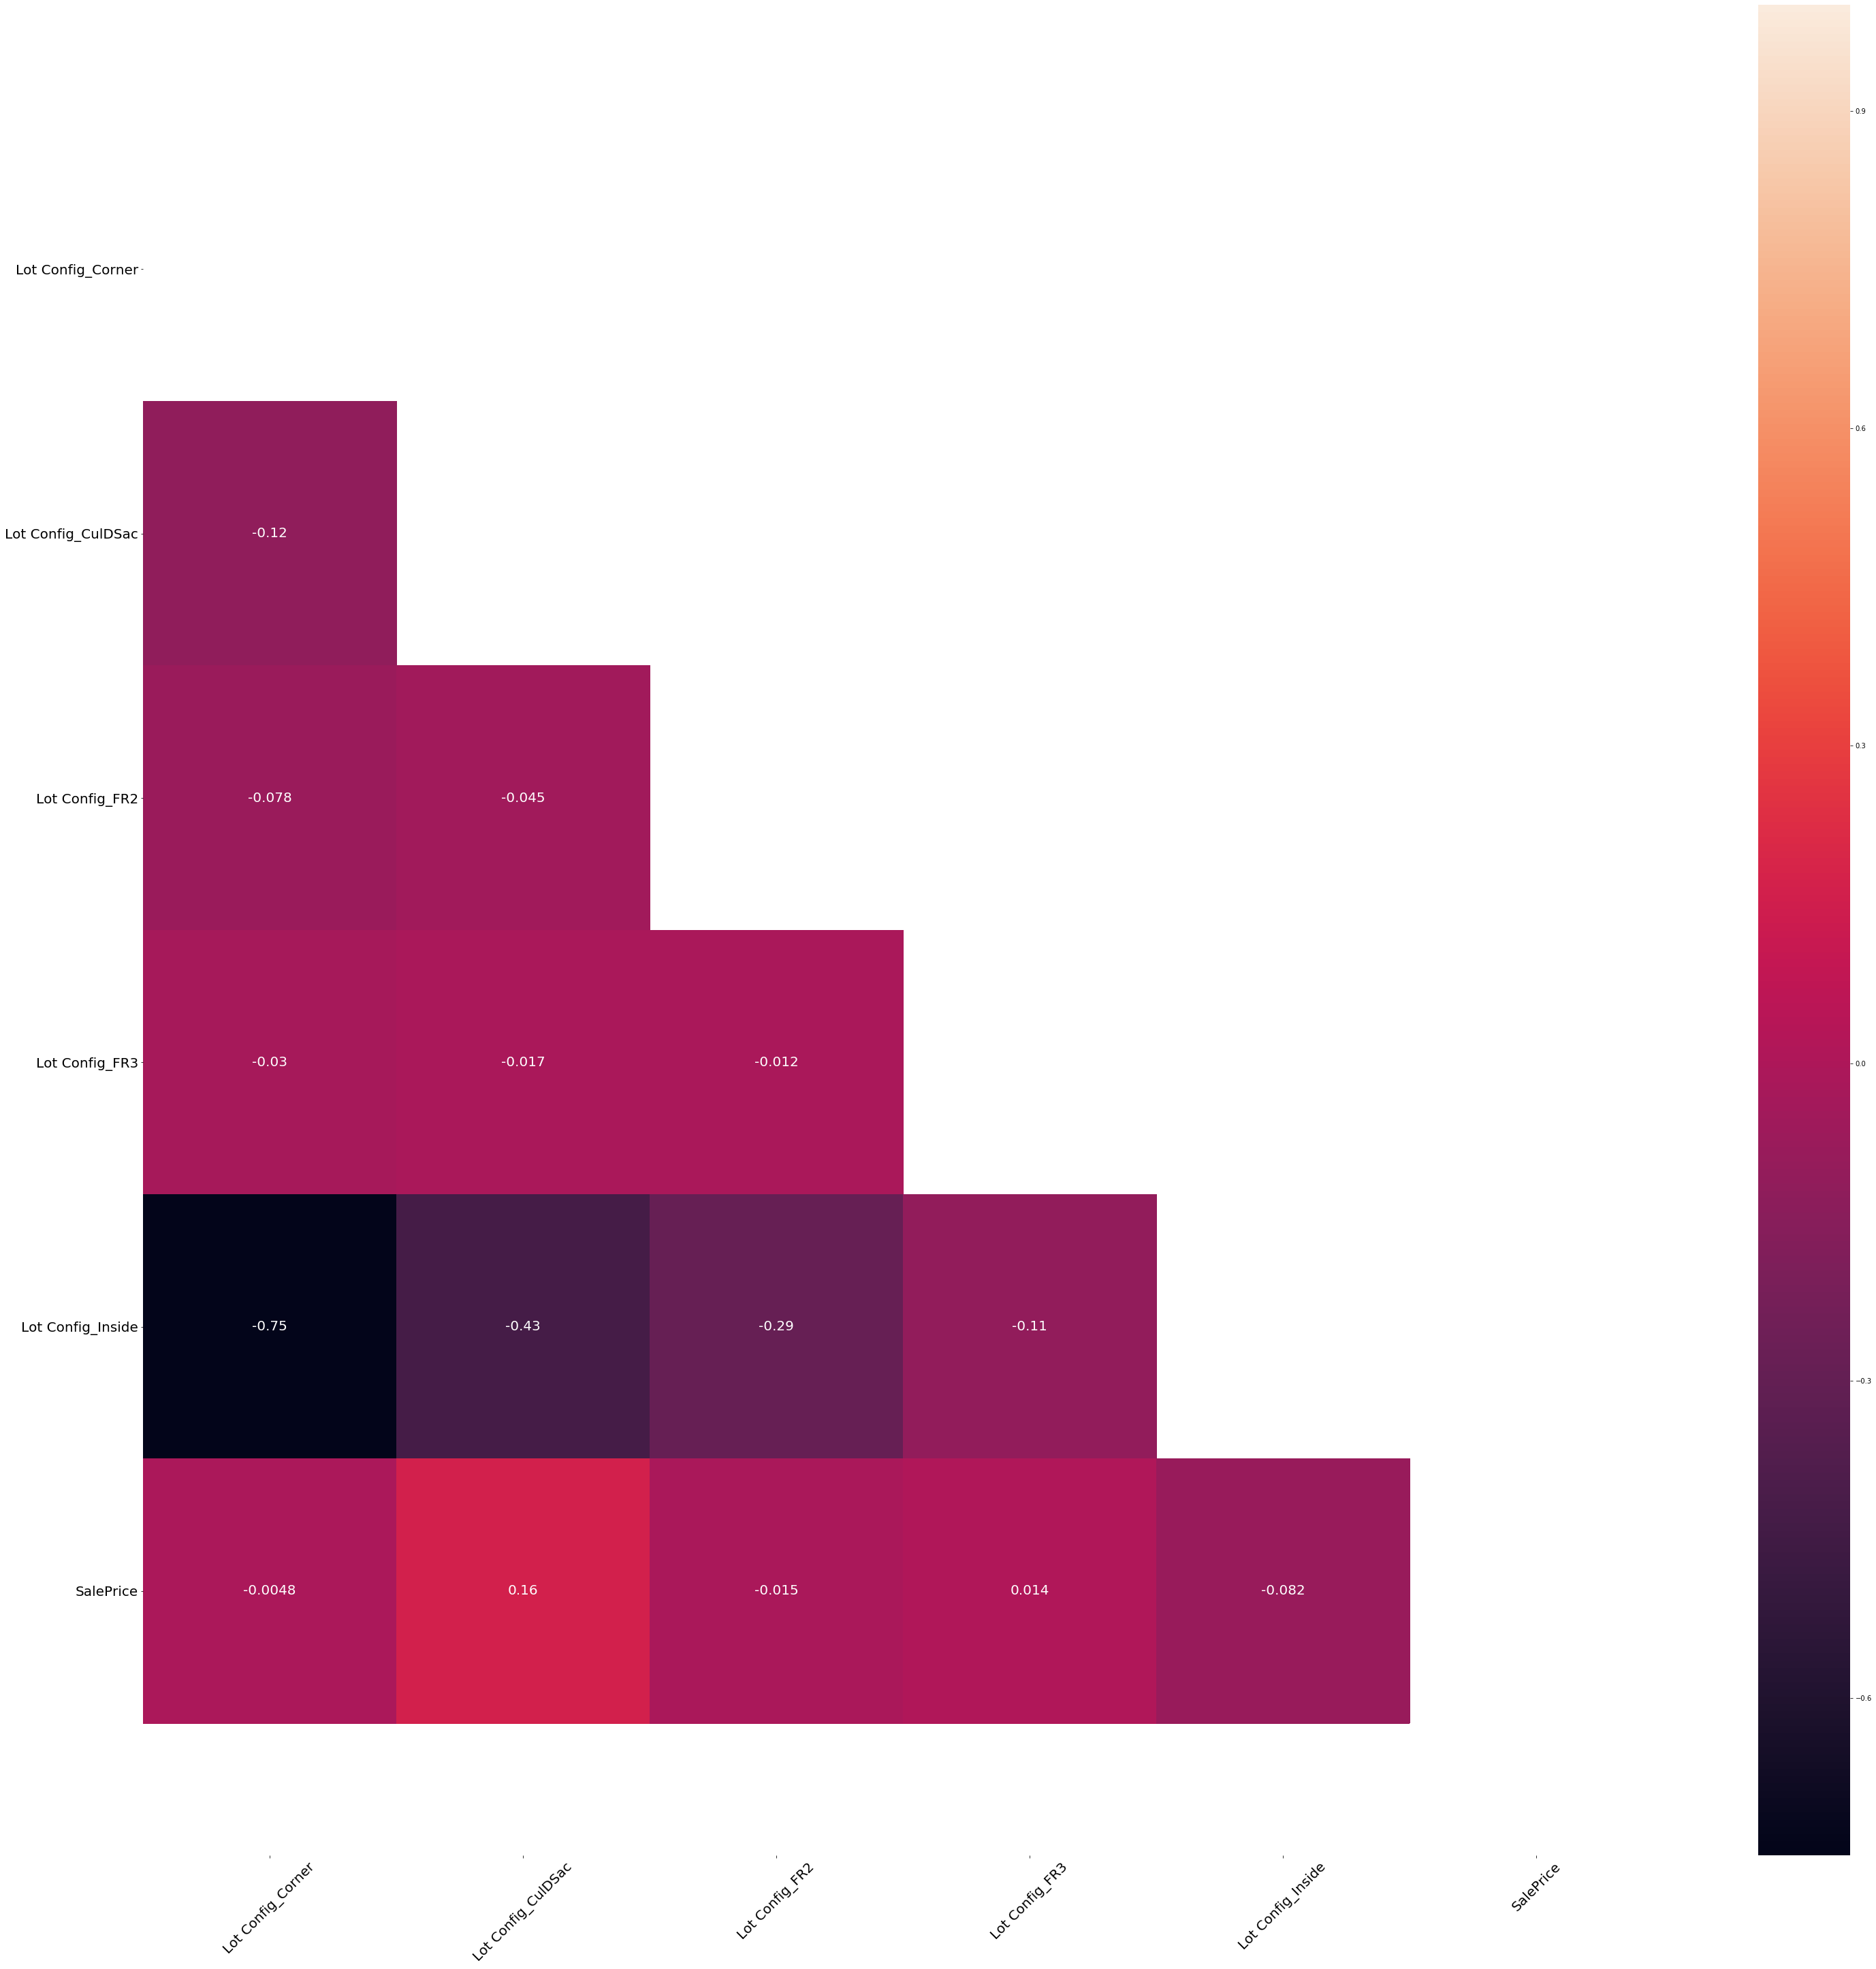

In [32]:
check_corr_func('Lot Config','Nominal','Yes','')

## ANS:

For Lot Config, there are no null entries.

Correlation is weak, only Lot Config_CulDSac has a 0.16 correlation. 131/2051 entries. 6.4%.

Drop Lot Config as predictor.

Land Slope    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Land Slope'.

These are the value_counts.

Gtl    1953
Mod      88
Sev      10
Name: Land Slope, dtype: int64

Set of all possible values for column {'Sev', 'Gtl', 'Mod'}


List of all possible values for column, including 'Unknown' for 'Land Slope': ['Unknown', 'Sev', 'Mod', 'Gtl']

Gtl    1953
Mod      88
Sev      10
Name: Land Slope, dtype: int64
3    1953
2      88
1      10
Name: Land Slope, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Land Slope  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Land Slope      SalePrice
count  2051.000000    2051.000000
mean      2.947343  181469.701609
std       0.244264   79258.659352
min       1.000000   12789.000000
25%       3.000000  

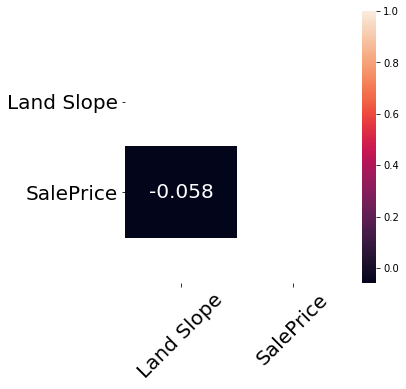

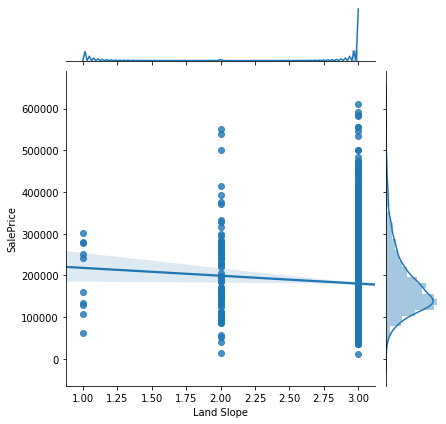

In [33]:
check_corr_func('Land Slope','Ordinal','Yes','Unknown,Sev,Mod,Gtl')

## ANS:

For Land Slope, there are no null entries.

Overwhelming representation of 1953/2051 entries for Gentle.

SalePrice ranges too much for the same value of Land Slope.

Drop Land Slope as predictor.

Neighborhood    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Neighborhood'.

These are the value_counts.

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Neighborhood_Blmngtn  2051 non-null   uint8
 1   Neighborhood_Blueste  2051 non-null   uint8
 2   Neighborhood_BrDale   2051 non-null   uint8
 3   Neighborhood_BrkSide  2051 non-null   uint8
 4   Nei

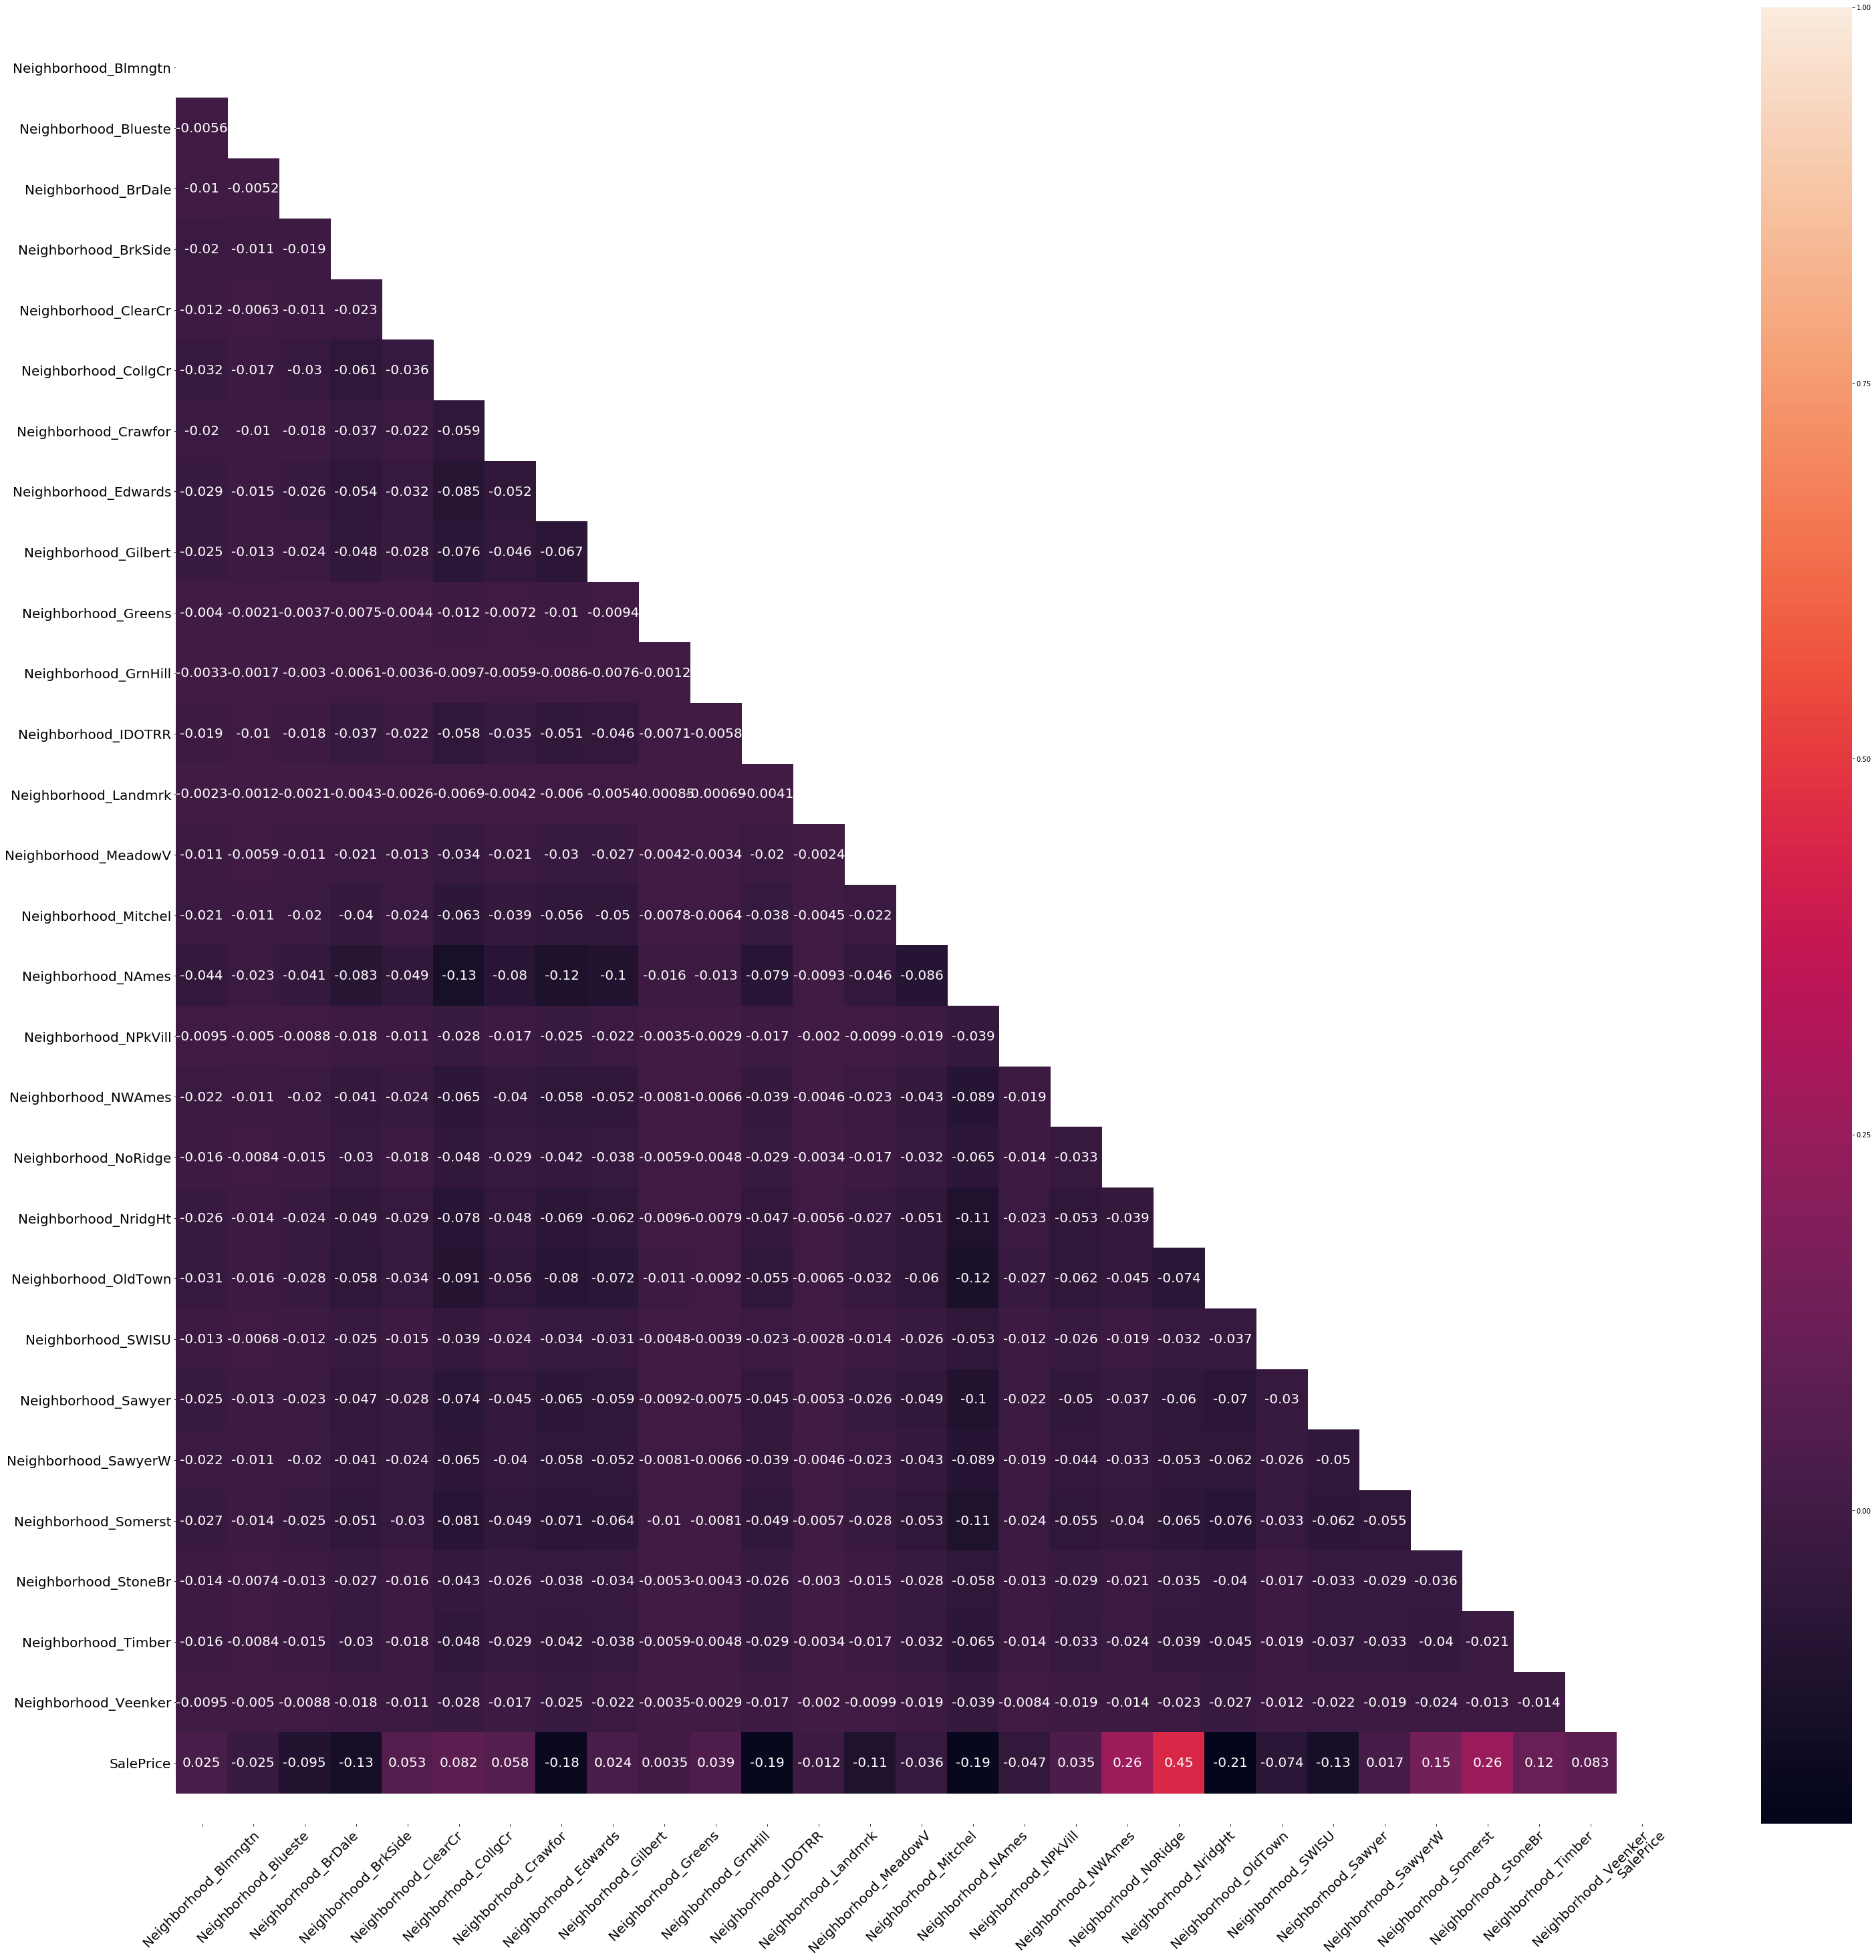

In [34]:
check_corr_func('Neighborhood','Nominal','Yes','')

## ANS:

For Neighborhood, there are no null entries.

Distribution of entries seems balanced across the sub-categories.

High correlation of 0.45 for NoRidge
and 0.26 for NW_Ames and Somerst.

Their representation is also roughly median, so unlikely to be outliers.

## Use Neighborhood NoRidge, NW_Ames and Somerst.

Condition 1    0
SalePrice      0
dtype: int64
There are no entries with null values in 'Condition 1'.

These are the value_counts.

Norm      1767
Feedr      109
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: Condition 1, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Condition 1_Artery  2051 non-null   uint8
 1   Condition 1_Feedr   2051 non-null   uint8
 2   Condition 1_Norm    2051 non-null   uint8
 3   Condition 1_PosA    2051 non-null   uint8
 4   Condition 1_PosN    2051 non-null   uint8
 5   Condition 1_RRAe    2051 non-null   uint8
 6   Condition 1_RRAn    2051 non-null   uint8
 7   Condition 1_RRNe    2051 non-null   uint8
 8   Condition 1_RRNn    2051 non-null   uint8
 9   SalePrice           2051 non-null   int64
dtypes: int64(1), uint8(9)


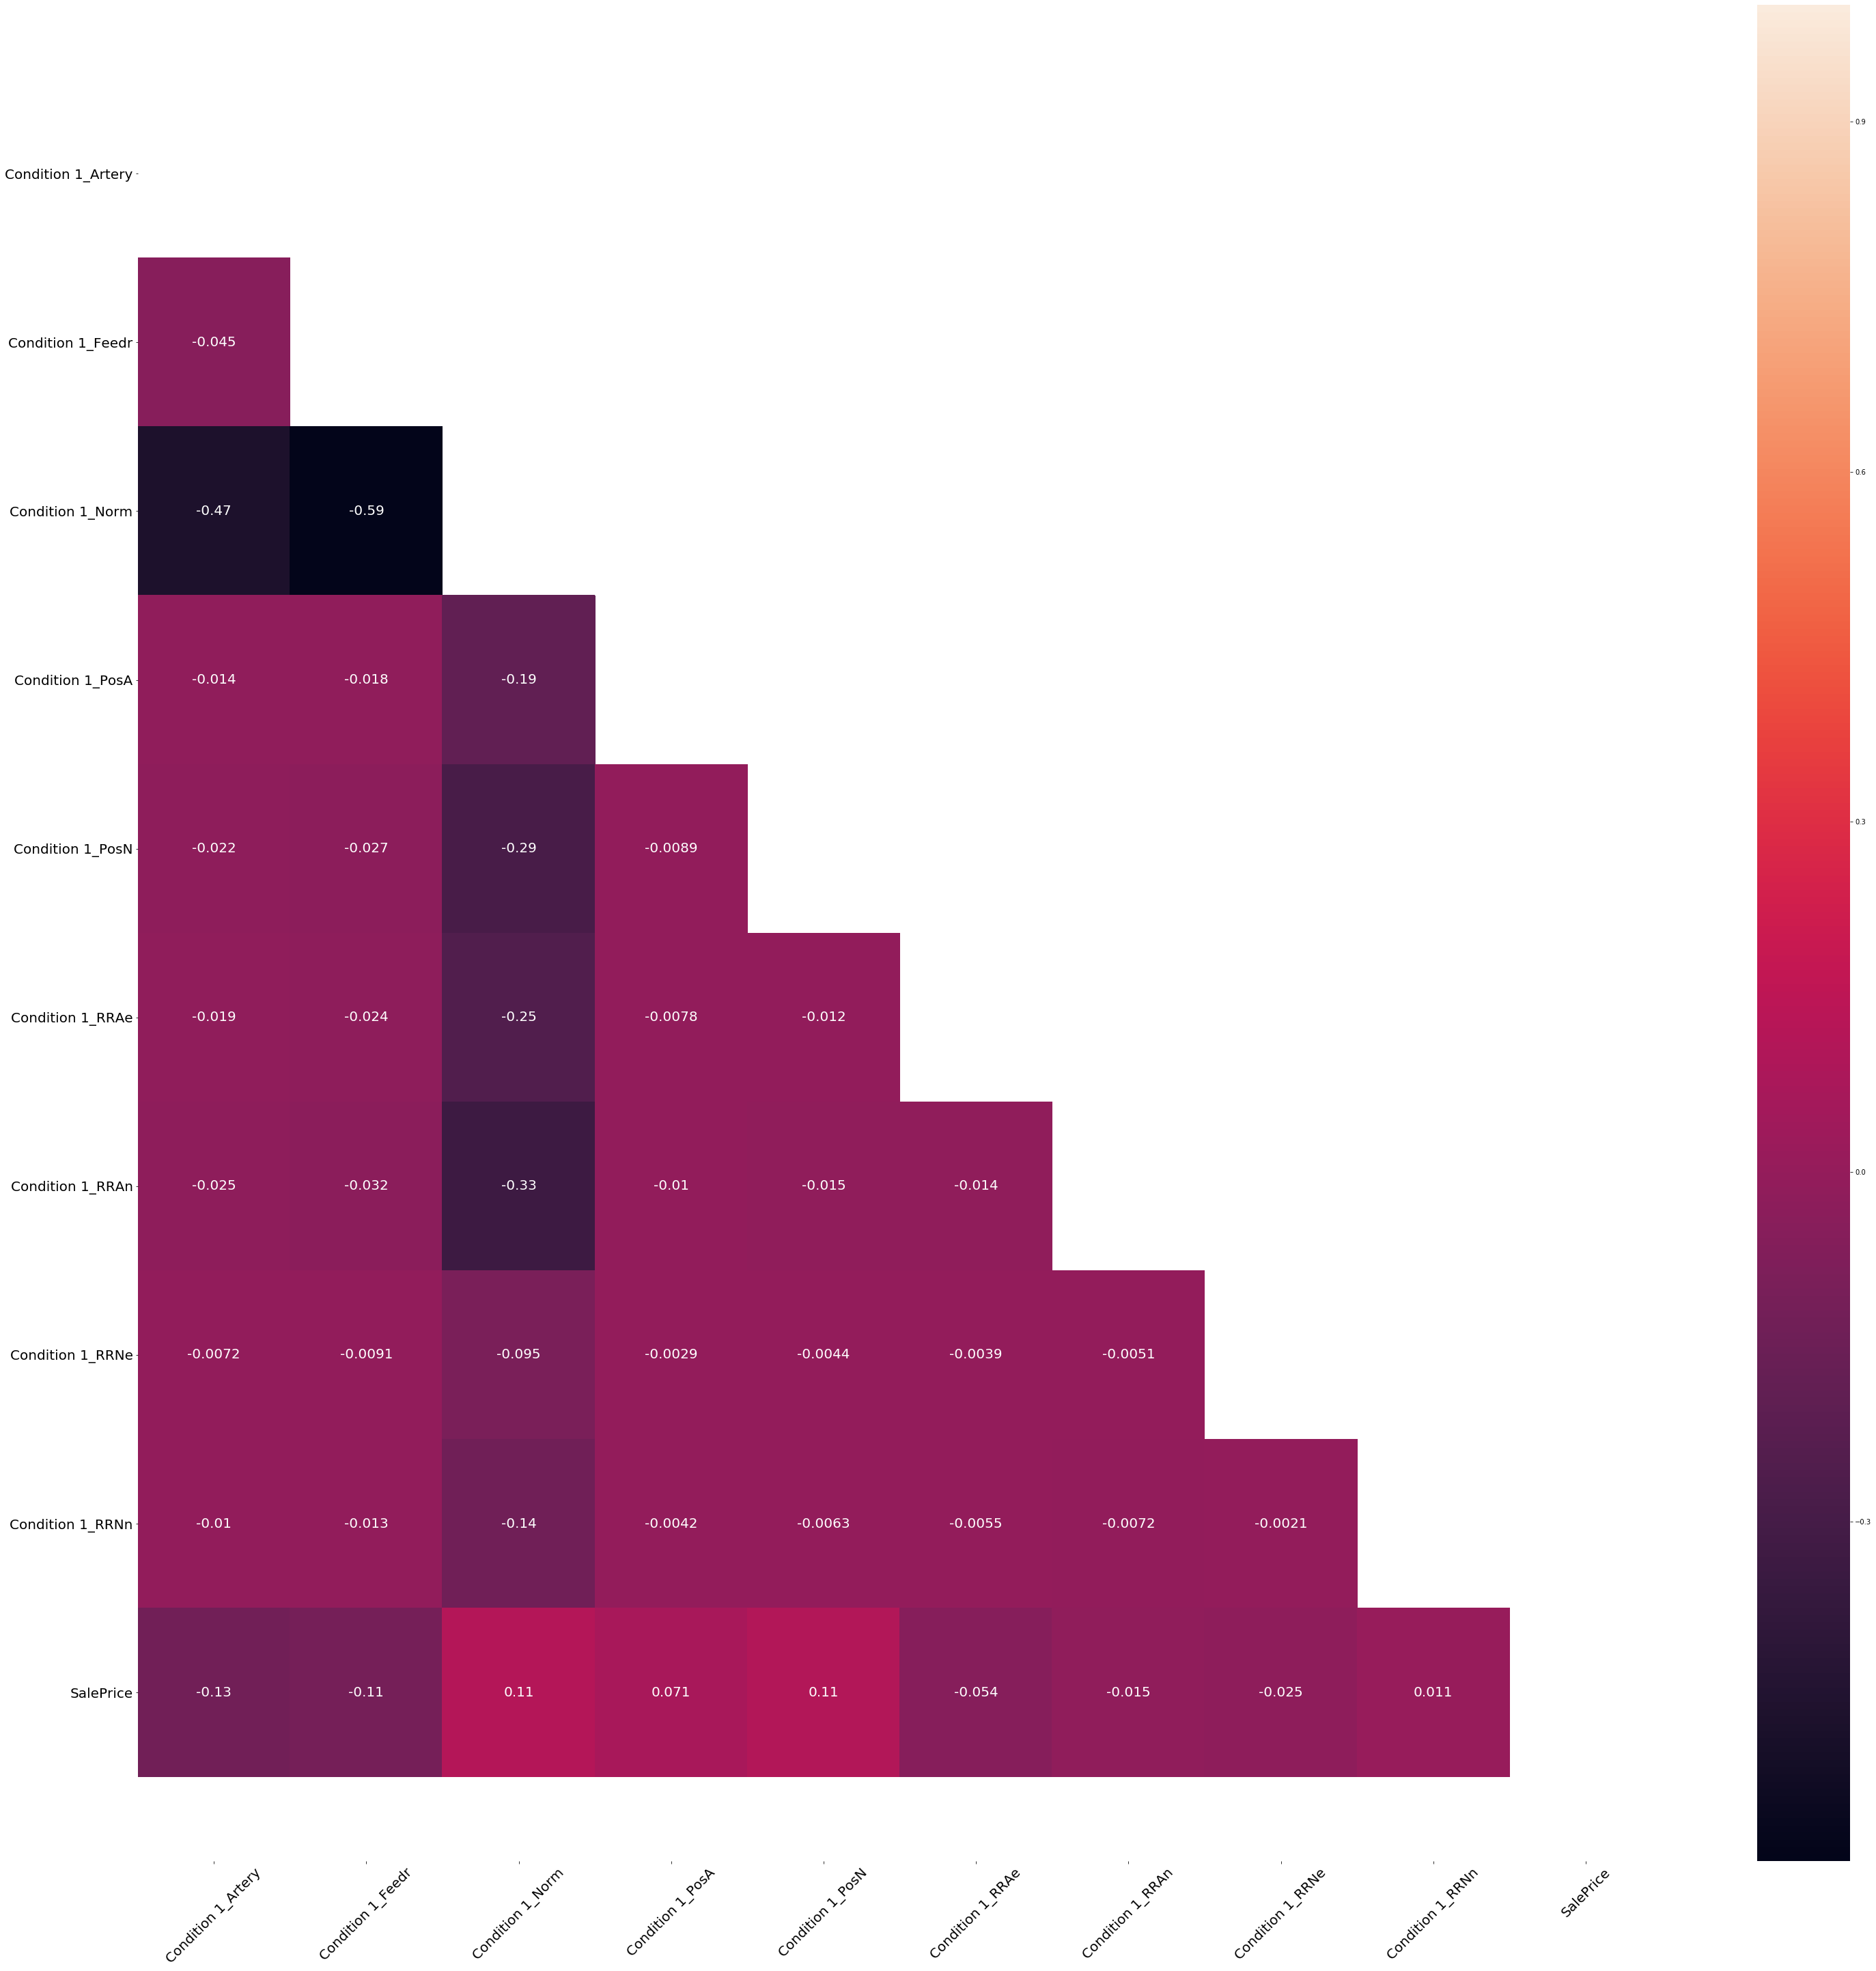

In [35]:
check_corr_func('Condition 1','Nominal','Yes','')

## ANS:

For Condition 1, there are no null entries.

Distribution overwhelmingly Norm, 1767/2051. 86.2% with poor correlation of 0.11.

Drop Condition 1.


Condition 2    0
SalePrice      0
dtype: int64
There are no entries with null values in 'Condition 2'.

These are the value_counts.

Norm      2025
Feedr       11
Artery       5
PosN         3
PosA         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition 2, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Condition 2_Artery  2051 non-null   uint8
 1   Condition 2_Feedr   2051 non-null   uint8
 2   Condition 2_Norm    2051 non-null   uint8
 3   Condition 2_PosA    2051 non-null   uint8
 4   Condition 2_PosN    2051 non-null   uint8
 5   Condition 2_RRAe    2051 non-null   uint8
 6   Condition 2_RRAn    2051 non-null   uint8
 7   Condition 2_RRNn    2051 non-null   uint8
 8   SalePrice           2051 non-null   int64
dtypes: int64(1), uint8(8)
memory usage: 32.2 KB
None


       Condition 2_Artery  Conditi

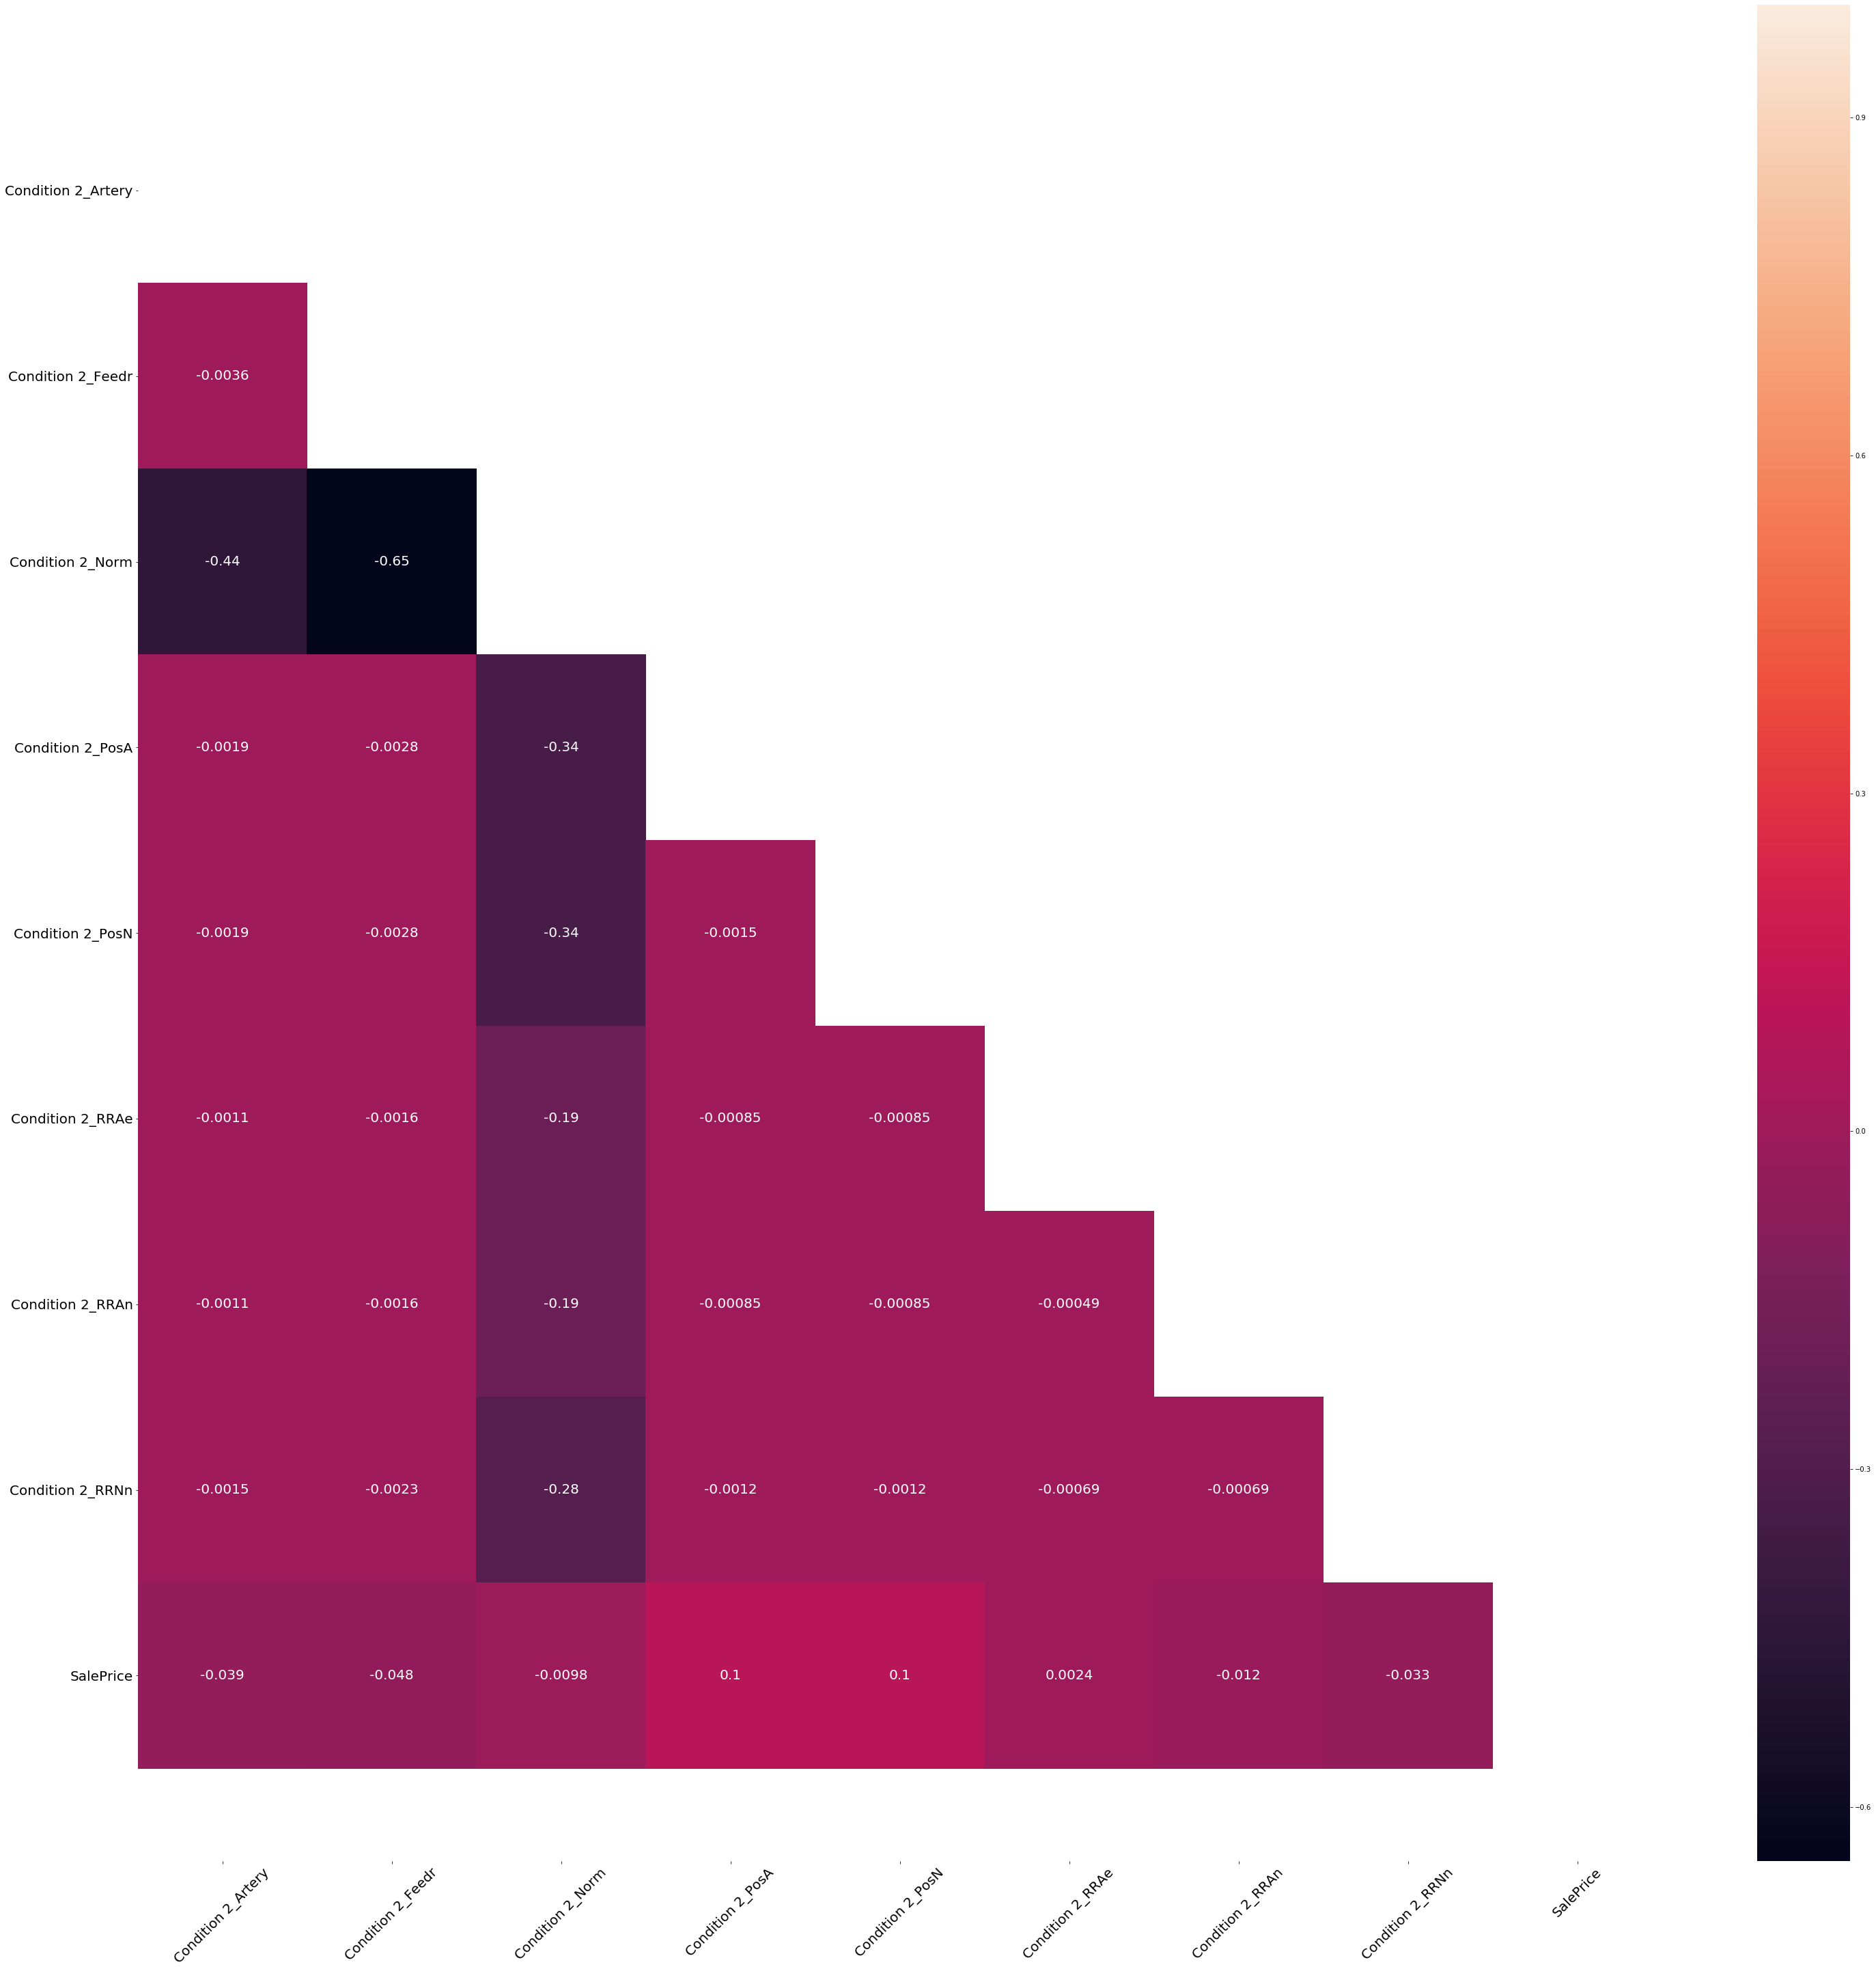

In [36]:
check_corr_func('Condition 2','Nominal','Yes','')

## ANS:

For Condition 2, there are no null entries.

Distribution overwhelmingly Norm, 2025/2051. 98.7% with poor correlation of -0.0098.

Drop Condition 2.

Bldg Type    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Bldg Type'.

These are the value_counts.

1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: Bldg Type, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Bldg Type_1Fam    2051 non-null   uint8
 1   Bldg Type_2fmCon  2051 non-null   uint8
 2   Bldg Type_Duplex  2051 non-null   uint8
 3   Bldg Type_Twnhs   2051 non-null   uint8
 4   Bldg Type_TwnhsE  2051 non-null   uint8
 5   SalePrice         2051 non-null   int64
dtypes: int64(1), uint8(5)
memory usage: 26.2 KB
None


       Bldg Type_1Fam  Bldg Type_2fmCon  Bldg Type_Duplex  Bldg Type_Twnhs  \
count     2051.000000       2051.000000       2051.000000      2051.000000   
mean         0.828864          0.022428          0.036568         0.033642   
std       

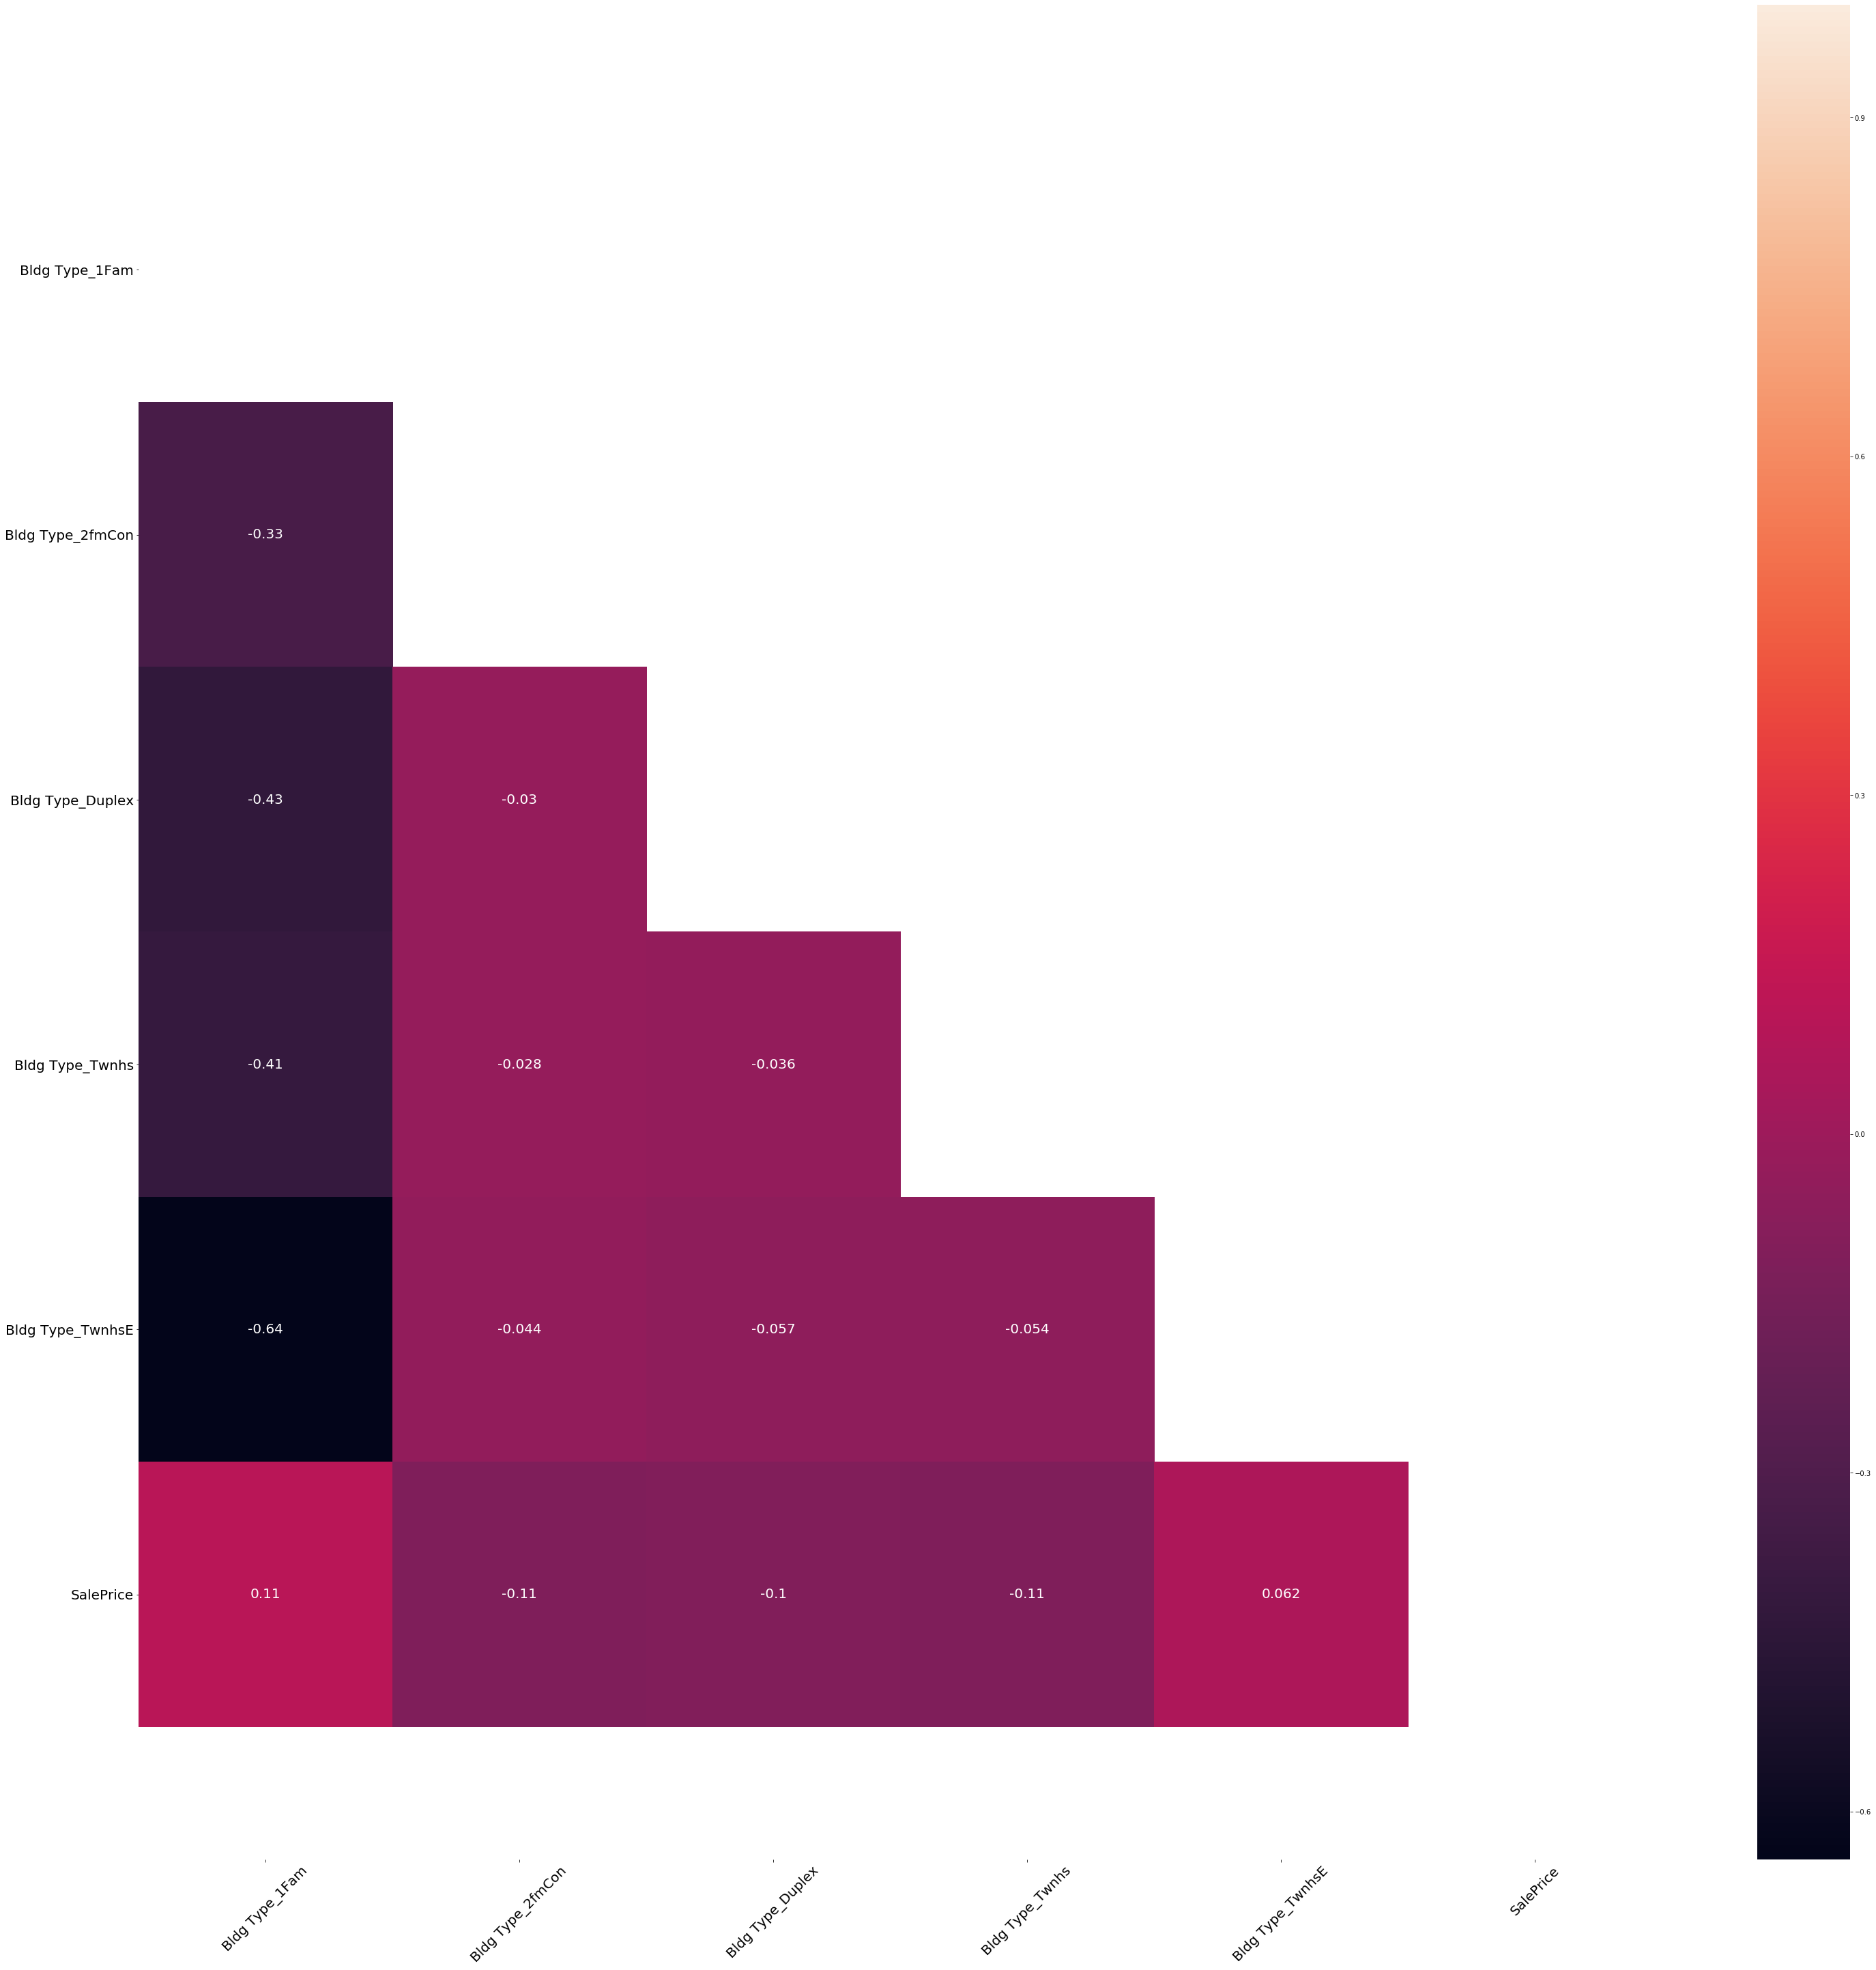

In [37]:
check_corr_func('Bldg Type','Nominal','Yes','')

## ANS:

For Blg Type, there are no null entries.

Distribution overwhelmingly 1Fam, 1700/2051. 82.9% with weak correlation of 0.11.

Drop Condition Blg Type.

House Style    0
SalePrice      0
dtype: int64
There are no entries with null values in 'House Style'.

These are the value_counts.

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: House Style, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   House Style_1.5Fin  2051 non-null   uint8
 1   House Style_1.5Unf  2051 non-null   uint8
 2   House Style_1Story  2051 non-null   uint8
 3   House Style_2.5Fin  2051 non-null   uint8
 4   House Style_2.5Unf  2051 non-null   uint8
 5   House Style_2Story  2051 non-null   uint8
 6   House Style_SFoyer  2051 non-null   uint8
 7   House Style_SLvl    2051 non-null   uint8
 8   SalePrice           2051 non-null   int64
dtypes: int64(1), uint8(8)
memory usage: 32.2 KB
None


       House Style_1.5Fin  House S

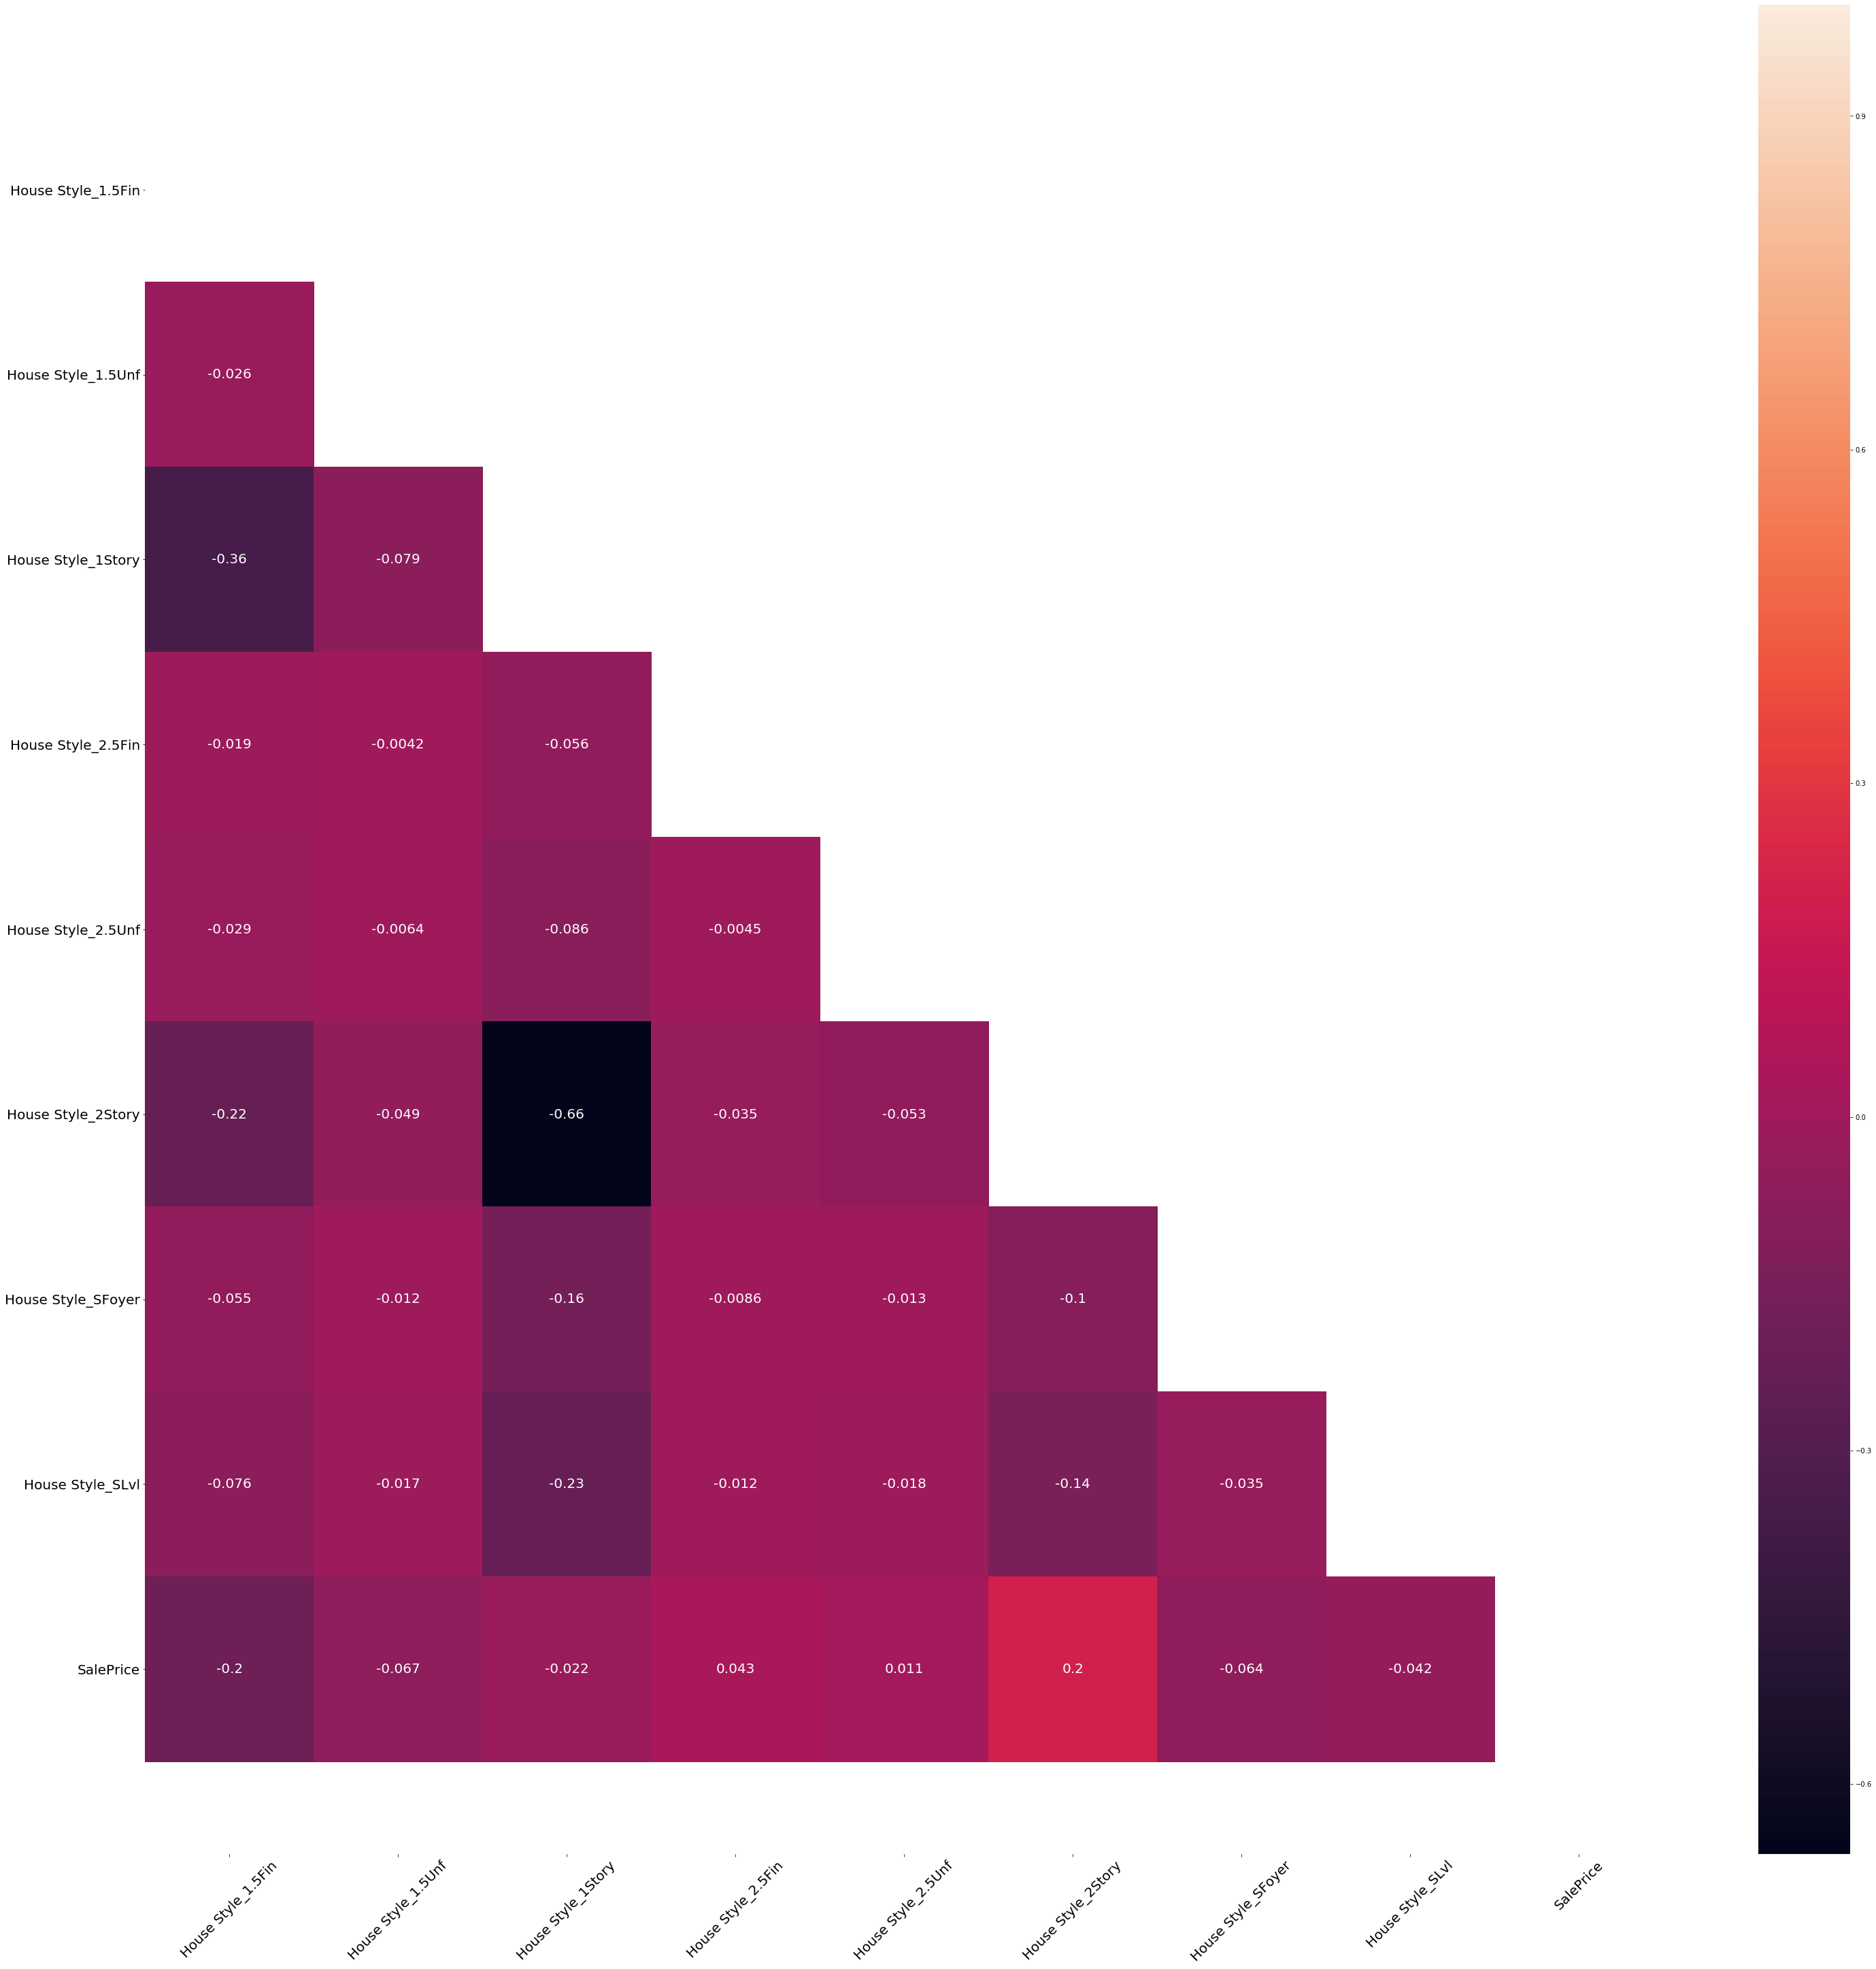

In [38]:
check_corr_func('House Style','Nominal','Yes','')

## ANS:

For House Style, there are no null entries.

Distribution mainly 1Story, 1059/2051. 51.6% with weak correlation of -0.022.
2Story has 598/2051. 29.1% with correlation of 0.2.



Overall Qual    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Overall Qual'.

These are the value_counts.

5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     23
2       9
1       4
Name: Overall Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Overall Qual  2051 non-null   int64
 1   SalePrice     2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Overall Qual      SalePrice
count   2051.000000    2051.000000
mean       6.112140  181469.701609
std        1.426271   79258.659352
min        1.000000   12789.000000
25%        5.000000  129825.000000
50%        6.000000  162500.000000
75%        7.000000  214000.000000
max       10.000000  611657.000000


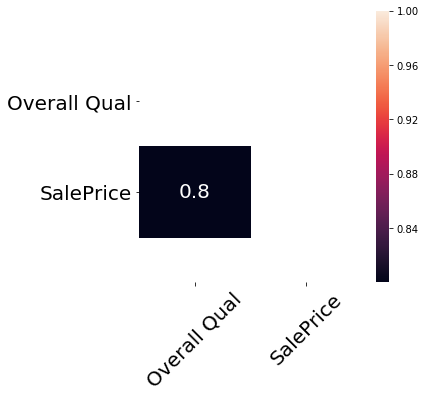

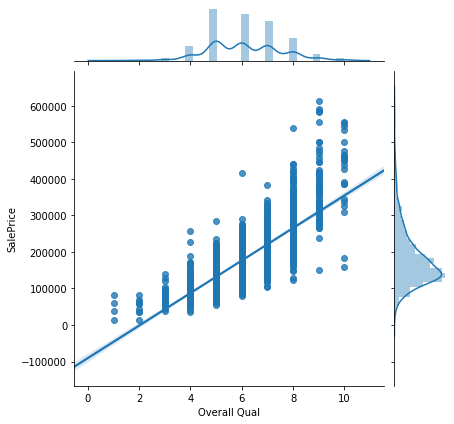

In [39]:
check_corr_func('Overall Qual','Discrete','Yes','')

## ANS:

For Overall Qual, there are no null entries.

Very strong correlation of 0.8, with pseudo-normal like distribution.

## Use Overall Qual as Predictor.

Overall Cond    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Overall Cond'.

These are the value_counts.

5    1168
6     368
7     270
8     101
4      70
3      35
9      29
2       6
1       4
Name: Overall Cond, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Overall Cond  2051 non-null   int64
 1   SalePrice     2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Overall Cond      SalePrice
count   2051.000000    2051.000000
mean       5.562165  181469.701609
std        1.104497   79258.659352
min        1.000000   12789.000000
25%        5.000000  129825.000000
50%        5.000000  162500.000000
75%        6.000000  214000.000000
max        9.000000  611657.000000


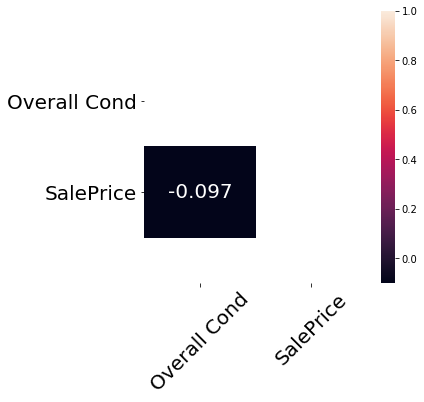

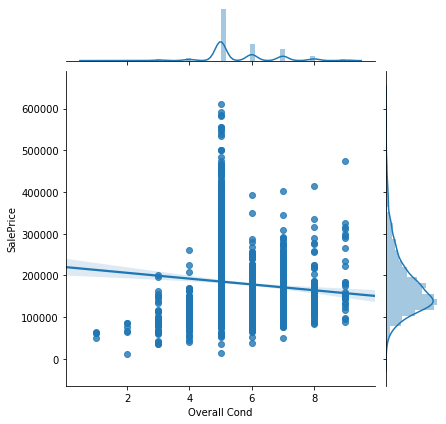

In [40]:
check_corr_func('Overall Cond','Discrete','Yes','')

## ANS:

For Overall Cond, there are no null entries.

Pseudo-normal distribution, but weak correlation of -0.097 

Drop Overall Cond.

Year Built    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Year Built'.

These are the value_counts.

2005    102
2006     99
2007     78
2004     72
2003     64
       ... 
1911      1
1893      1
1885      1
1879      1
1872      1
Name: Year Built, Length: 113, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Year Built  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Year Built      SalePrice
count  2051.000000    2051.000000
mean   1971.708922  181469.701609
std      30.177889   79258.659352
min    1872.000000   12789.000000
25%    1953.500000  129825.000000
50%    1974.000000  162500.000000
75%    2001.000000  214000.000000
max    2010.000000  611657.000000


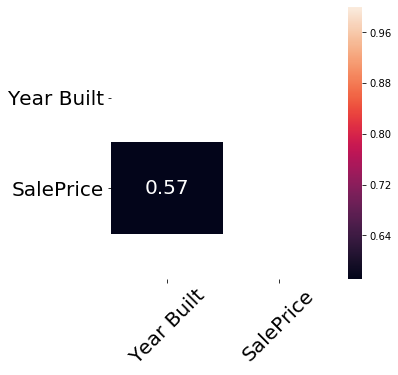

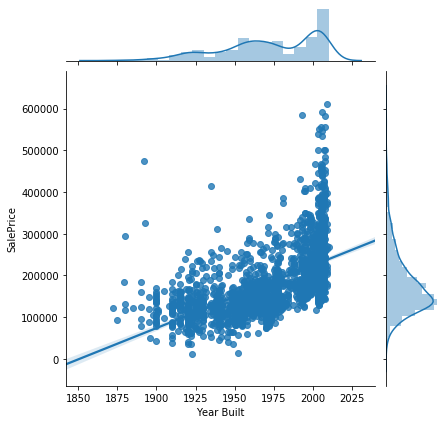

In [41]:
check_corr_func('Year Built','Discrete','Yes','')

## ANS:

For Year Built, there are no null entries.

Good correlation of 0.57, wide distribution of values.

## Use Year Built as Predictor.

Year Remod/Add    0
SalePrice         0
dtype: int64
There are no entries with null values in 'Year Remod/Add'.

These are the value_counts.

1950    262
2006    139
2007    123
2005    100
2004     83
       ... 
1952      9
2010      8
1983      7
1981      6
1982      3
Name: Year Remod/Add, Length: 61, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year Remod/Add  2051 non-null   int64
 1   SalePrice       2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Year Remod/Add      SalePrice
count     2051.000000    2051.000000
mean      1984.190151  181469.701609
std         21.036250   79258.659352
min       1950.000000   12789.000000
25%       1964.500000  129825.000000
50%       1993.000000  162500.000000
75%       2004.000000  214000.000000
max       2010.000000  611657.000000


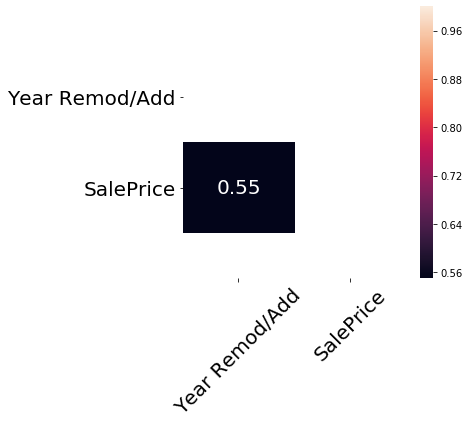

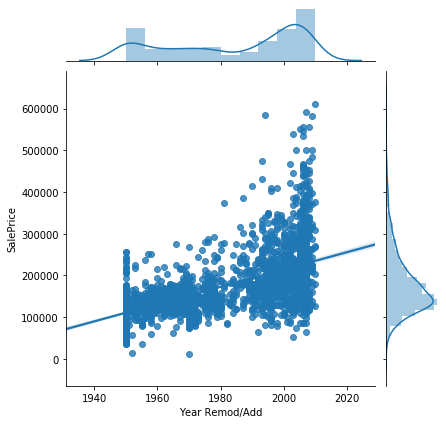

In [42]:
check_corr_func('Year Remod/Add','Discrete','Yes','')

## ANS:

For Year Remod/Add, there are no null entries.

Good correlation of 0.55, wide distribution of values.

However, this is not very useful, as full remodeling would effectively reset age of house but addition can be partial and limited, without having the data in this column split, it cannot be used meaningfully. 

Price should be higher for recently fully remodeled house vs slight addition.

Also does not indicate if multiple additions have been done over the years.

May even introduce errors/bias into model.

Drop Year Remod/Add.


Roof Style    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Roof Style'.

These are the value_counts.

Gable      1619
Hip         397
Flat         13
Gambrel      12
Mansard       7
Shed          3
Name: Roof Style, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Roof Style_Flat     2051 non-null   uint8
 1   Roof Style_Gable    2051 non-null   uint8
 2   Roof Style_Gambrel  2051 non-null   uint8
 3   Roof Style_Hip      2051 non-null   uint8
 4   Roof Style_Mansard  2051 non-null   uint8
 5   Roof Style_Shed     2051 non-null   uint8
 6   SalePrice           2051 non-null   int64
dtypes: int64(1), uint8(6)
memory usage: 28.2 KB
None


       Roof Style_Flat  Roof Style_Gable  Roof Style_Gambrel  Roof Style_Hip  \
count      2051.000000       2051.000000         2051.000000     2051.000000

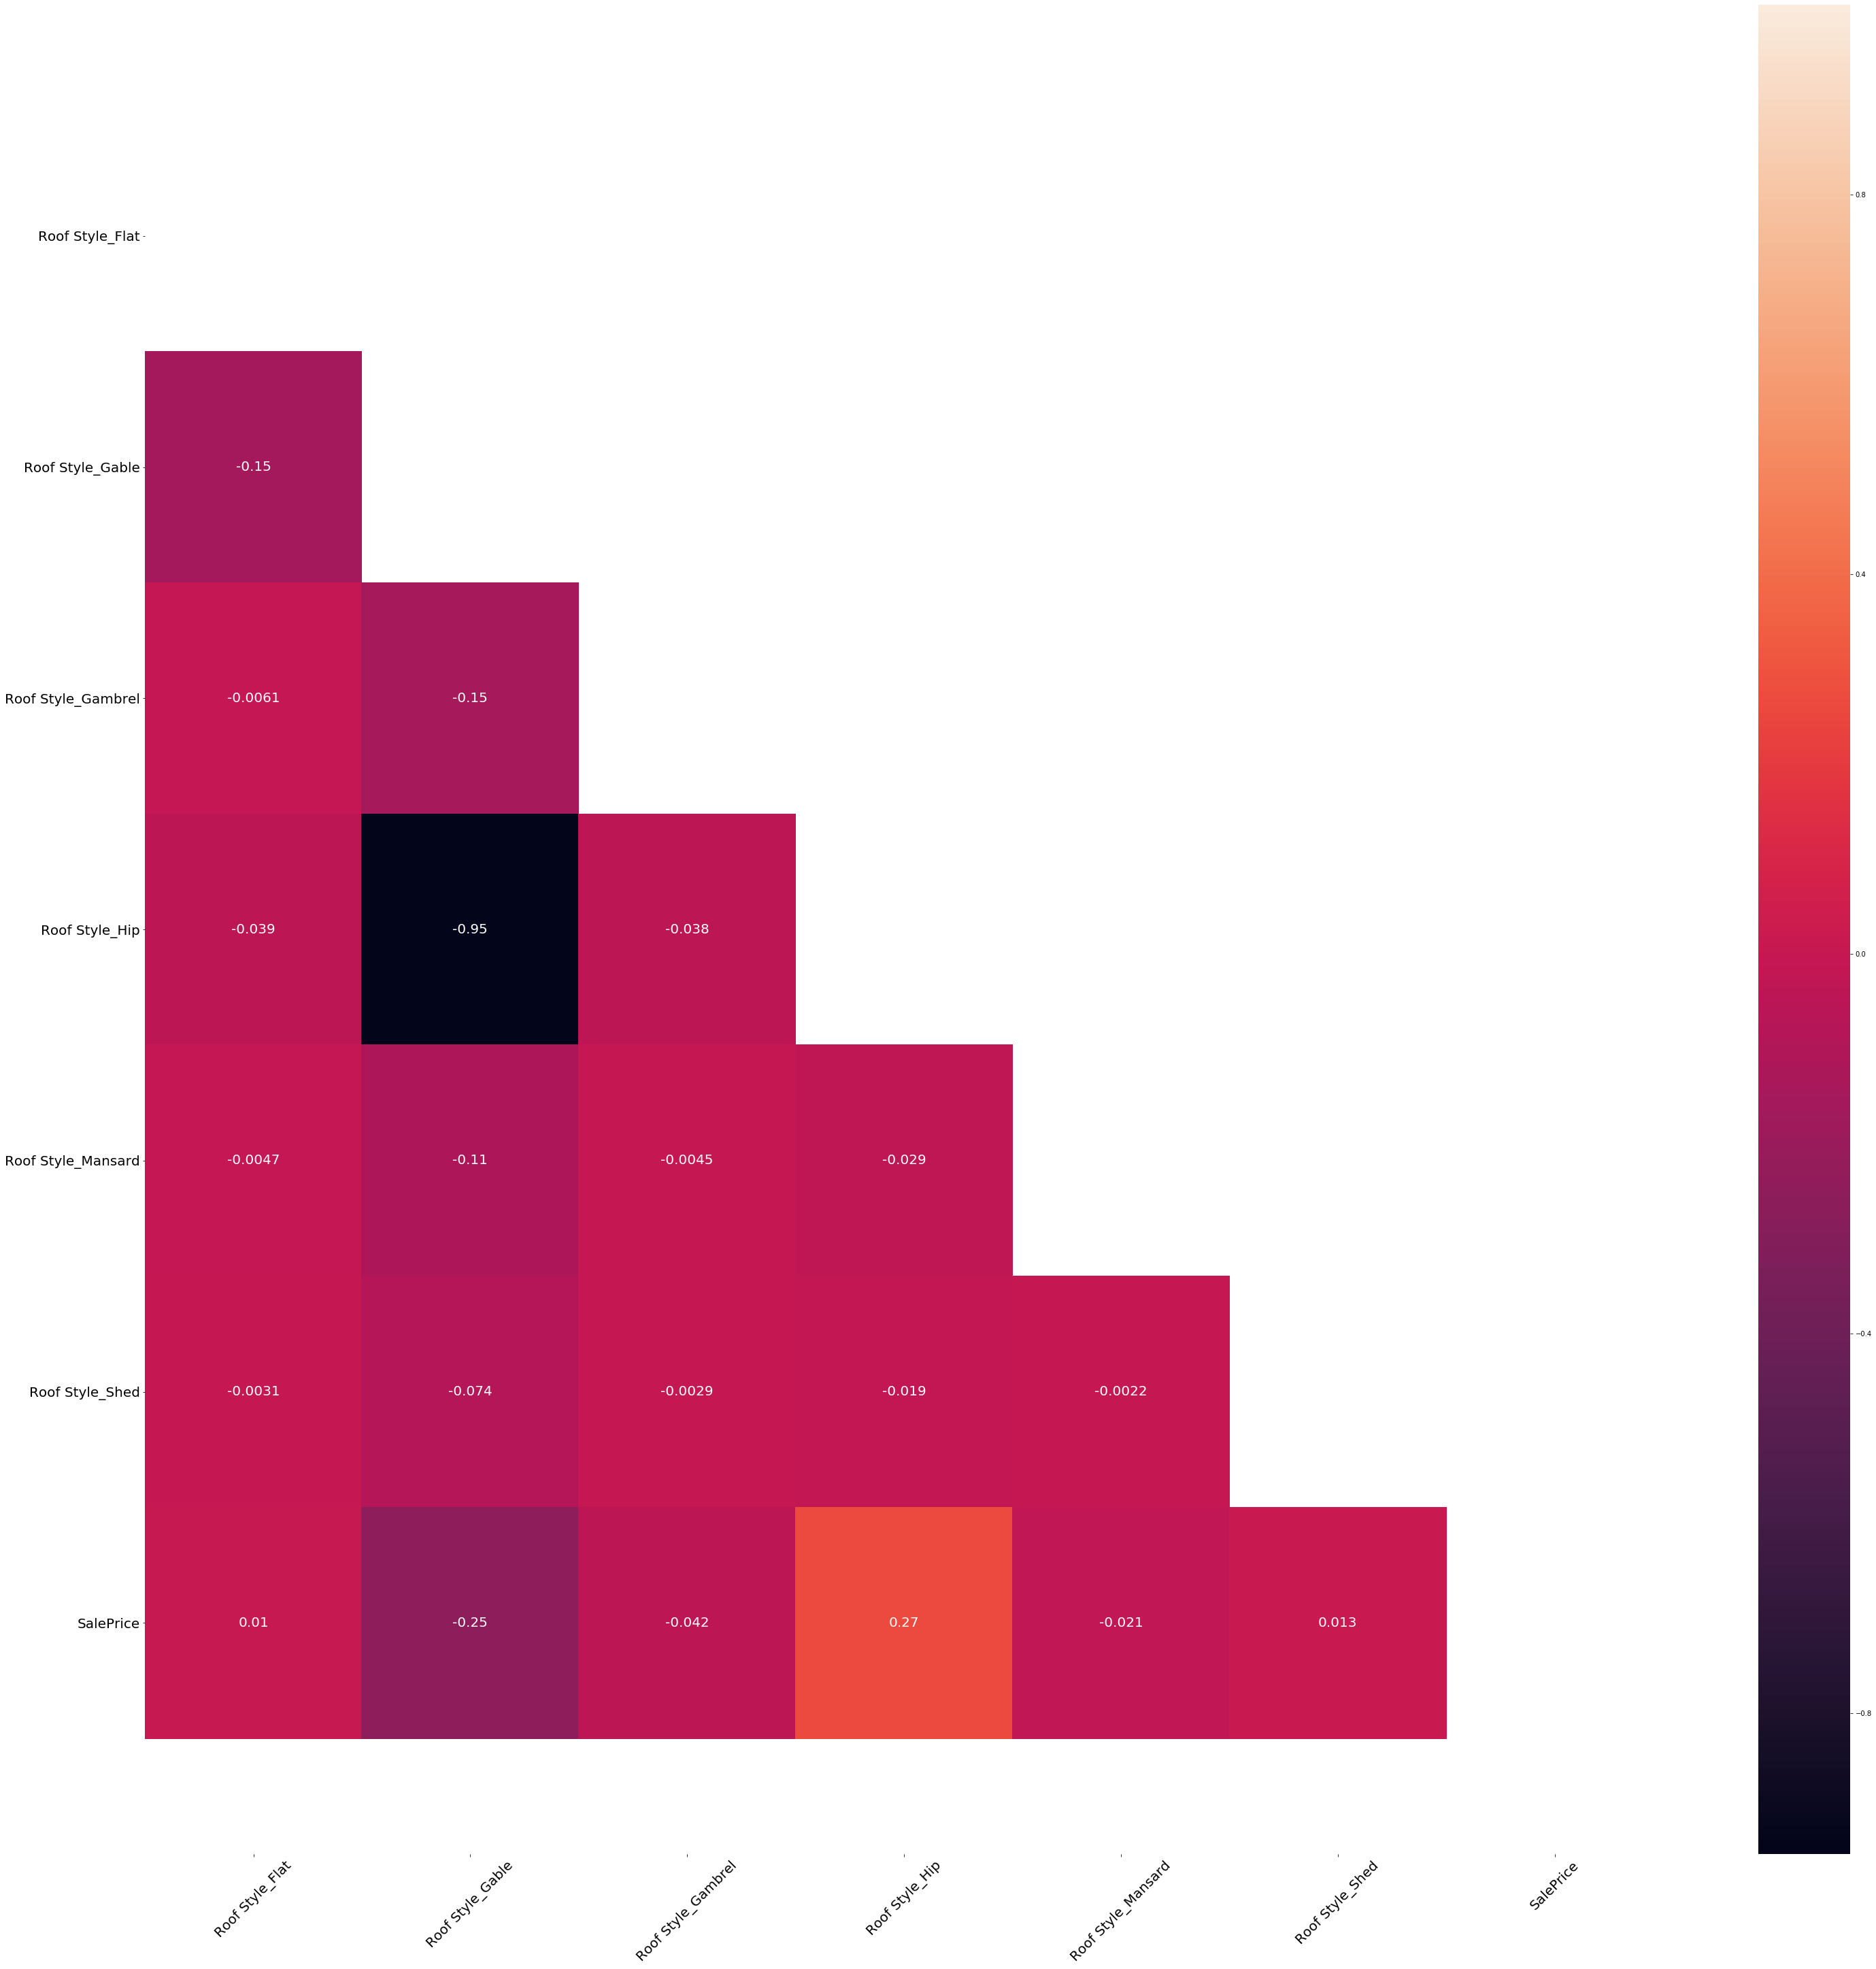

In [43]:
check_corr_func('Roof Style','Nominal','Yes','')

## ANS:

For Roof Style, there are no null entries.



1619/2051 entries are Gable, with a -0.25 correlation.

397/2051 entries are Hip, with 0.27 correlation.


## Use Roof Style Gable and Hip as predictors.


Roof Matl    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Roof Matl'.

These are the value_counts.

CompShg    2025
Tar&Grv      15
WdShngl       5
WdShake       4
Membran       1
ClyTile       1
Name: Roof Matl, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Roof Matl_ClyTile  2051 non-null   uint8
 1   Roof Matl_CompShg  2051 non-null   uint8
 2   Roof Matl_Membran  2051 non-null   uint8
 3   Roof Matl_Tar&Grv  2051 non-null   uint8
 4   Roof Matl_WdShake  2051 non-null   uint8
 5   Roof Matl_WdShngl  2051 non-null   uint8
 6   SalePrice          2051 non-null   int64
dtypes: int64(1), uint8(6)
memory usage: 28.2 KB
None


       Roof Matl_ClyTile  Roof Matl_CompShg  Roof Matl_Membran  \
count        2051.000000        2051.000000        2051.000000   
mean            0.000488           0.

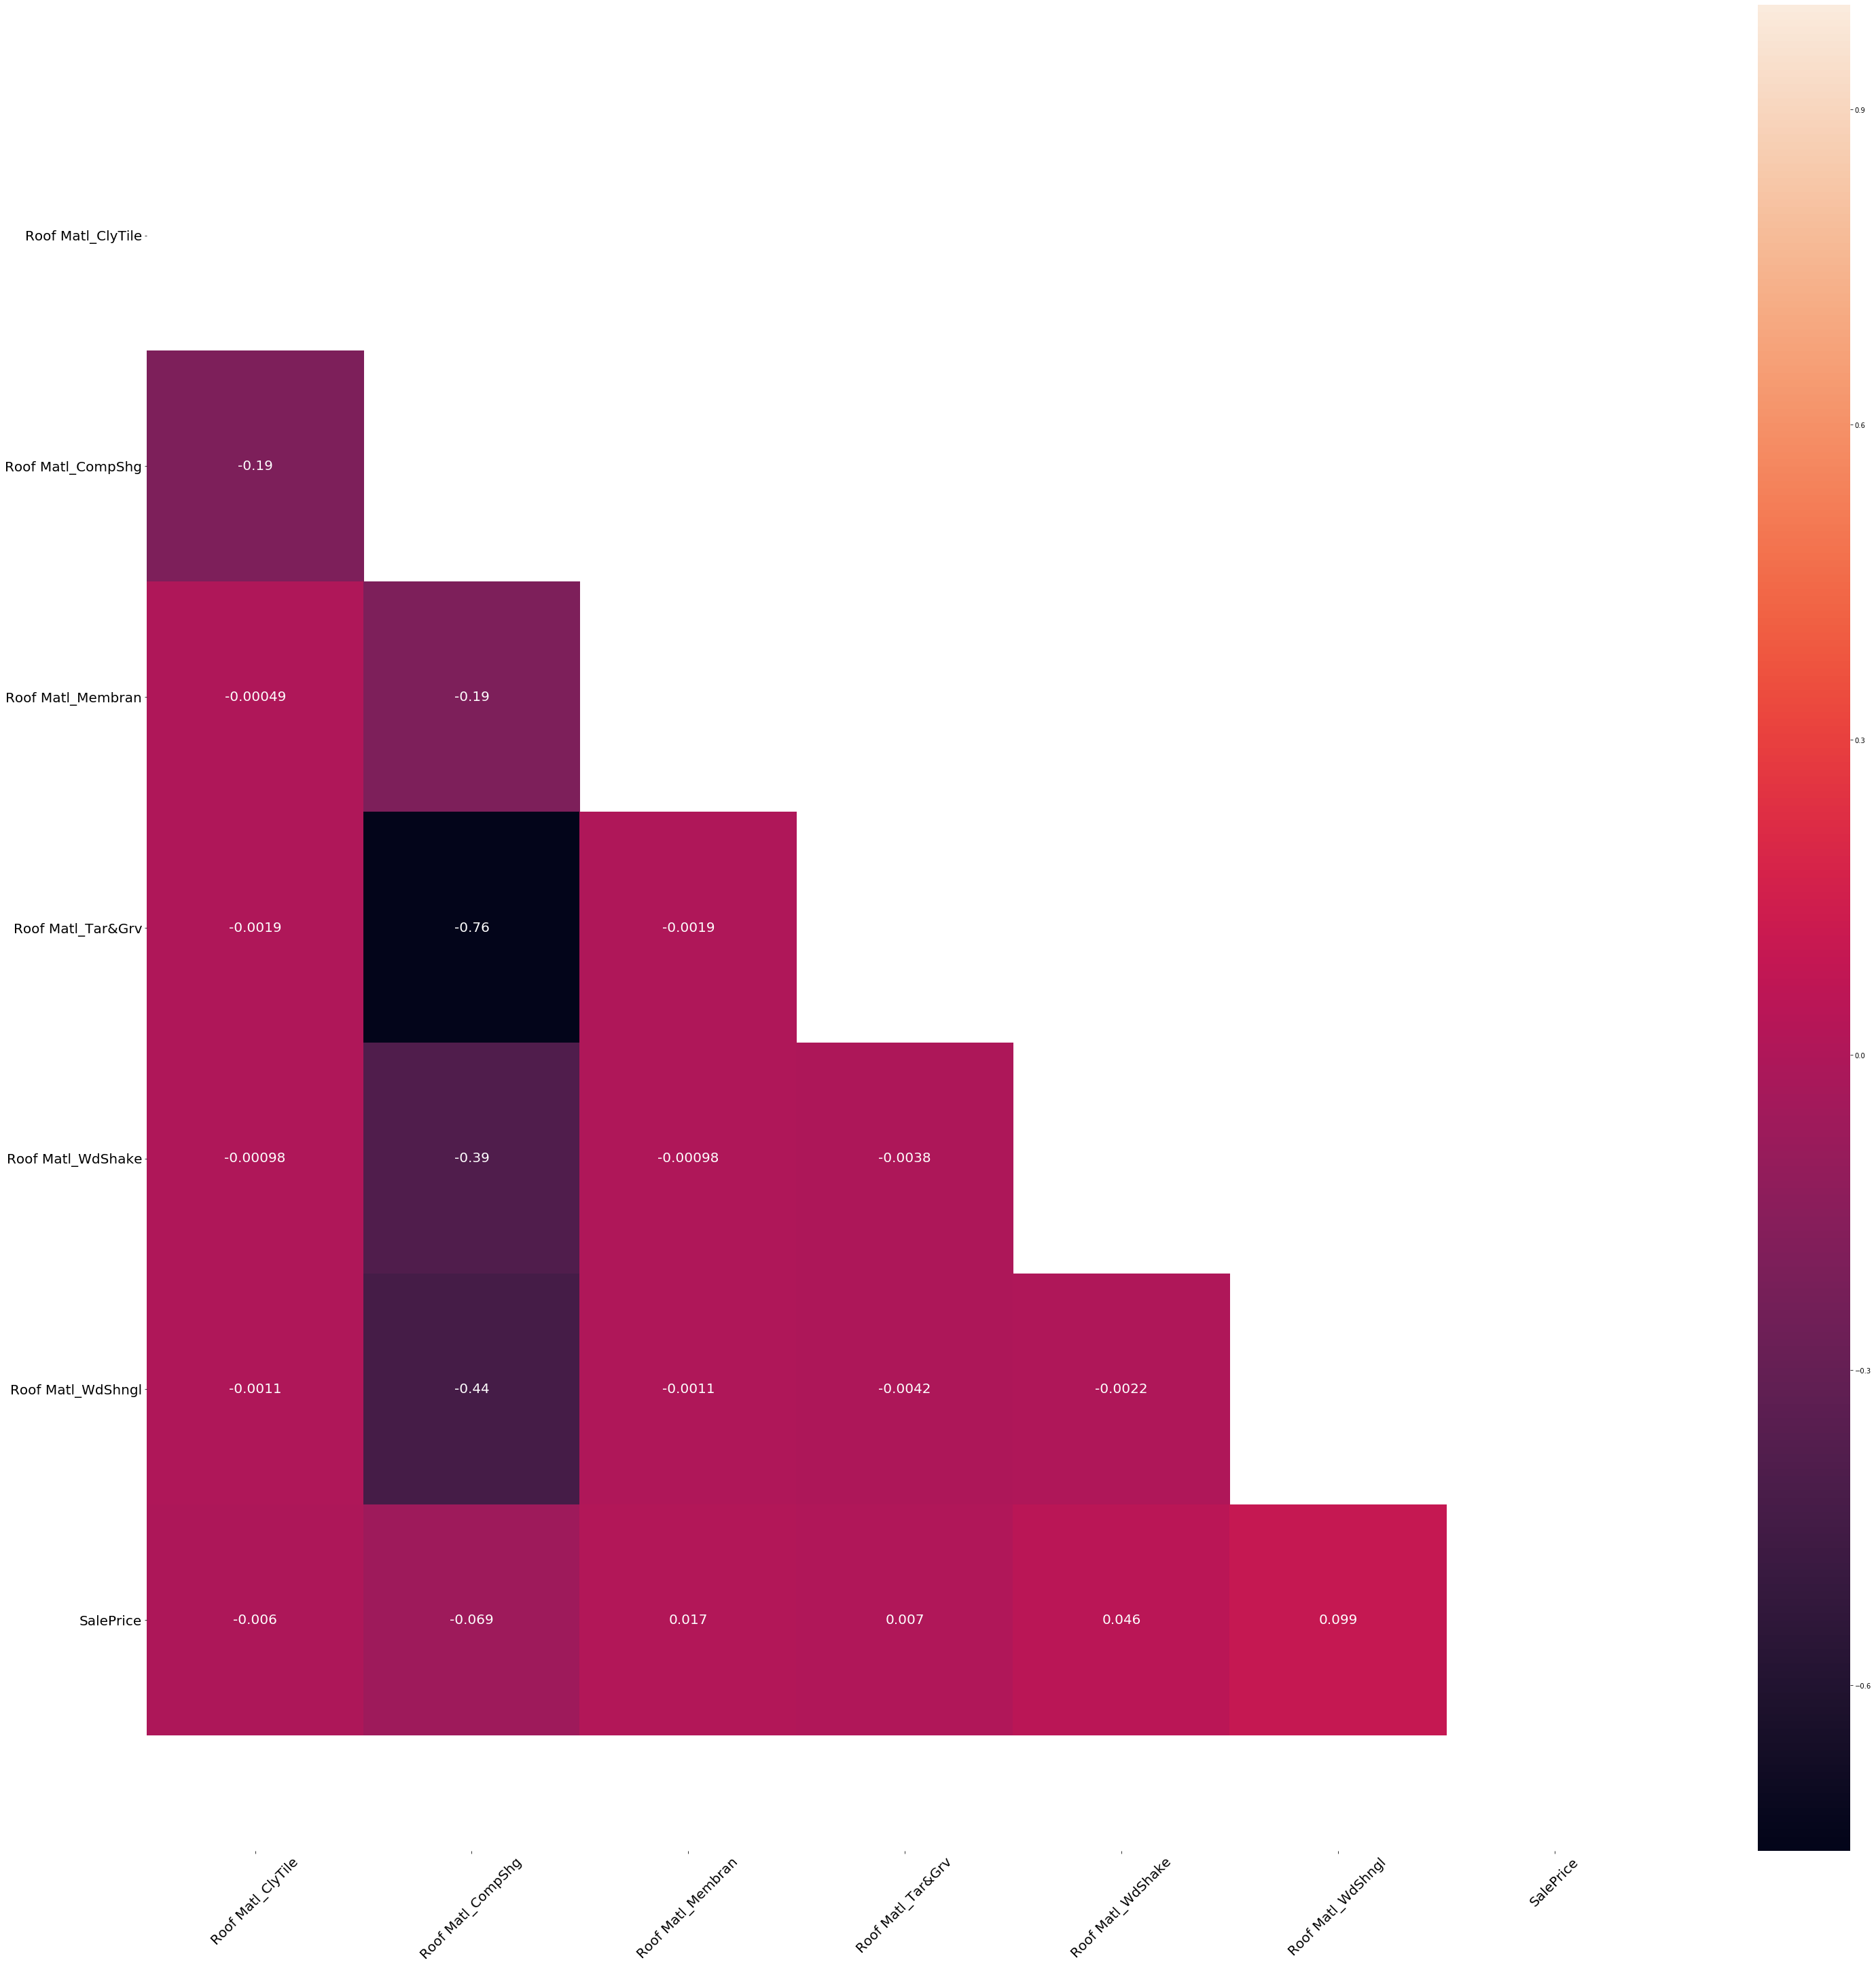

In [44]:
check_corr_func('Roof Matl','Nominal','Yes','')

## ANS:

For Roof Matl, there are no null entries.



2025/2051 entries are CompShg, with poor -0.069 correlation.

Drop Roof Matl as predictor.

Exterior 1st    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Exterior 1st'.

These are the value_counts.

VinylSd    724
MetalSd    331
HdBoard    300
Wd Sdng    276
Plywood    152
CemntBd     90
BrkFace     64
WdShing     45
AsbShng     33
Stucco      27
BrkComm      3
Stone        2
CBlock       2
ImStucc      1
AsphShn      1
Name: Exterior 1st, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Exterior 1st_AsbShng  2051 non-null   uint8
 1   Exterior 1st_AsphShn  2051 non-null   uint8
 2   Exterior 1st_BrkComm  2051 non-null   uint8
 3   Exterior 1st_BrkFace  2051 non-null   uint8
 4   Exterior 1st_CBlock   2051 non-null   uint8
 5   Exterior 1st_CemntBd  2051 non-null   uint8
 6   Exterior 1st_HdBoard  2051 non-null   uint8
 7   Exterior 1st_ImStucc  2051 non-null   uint8
 8   Ex

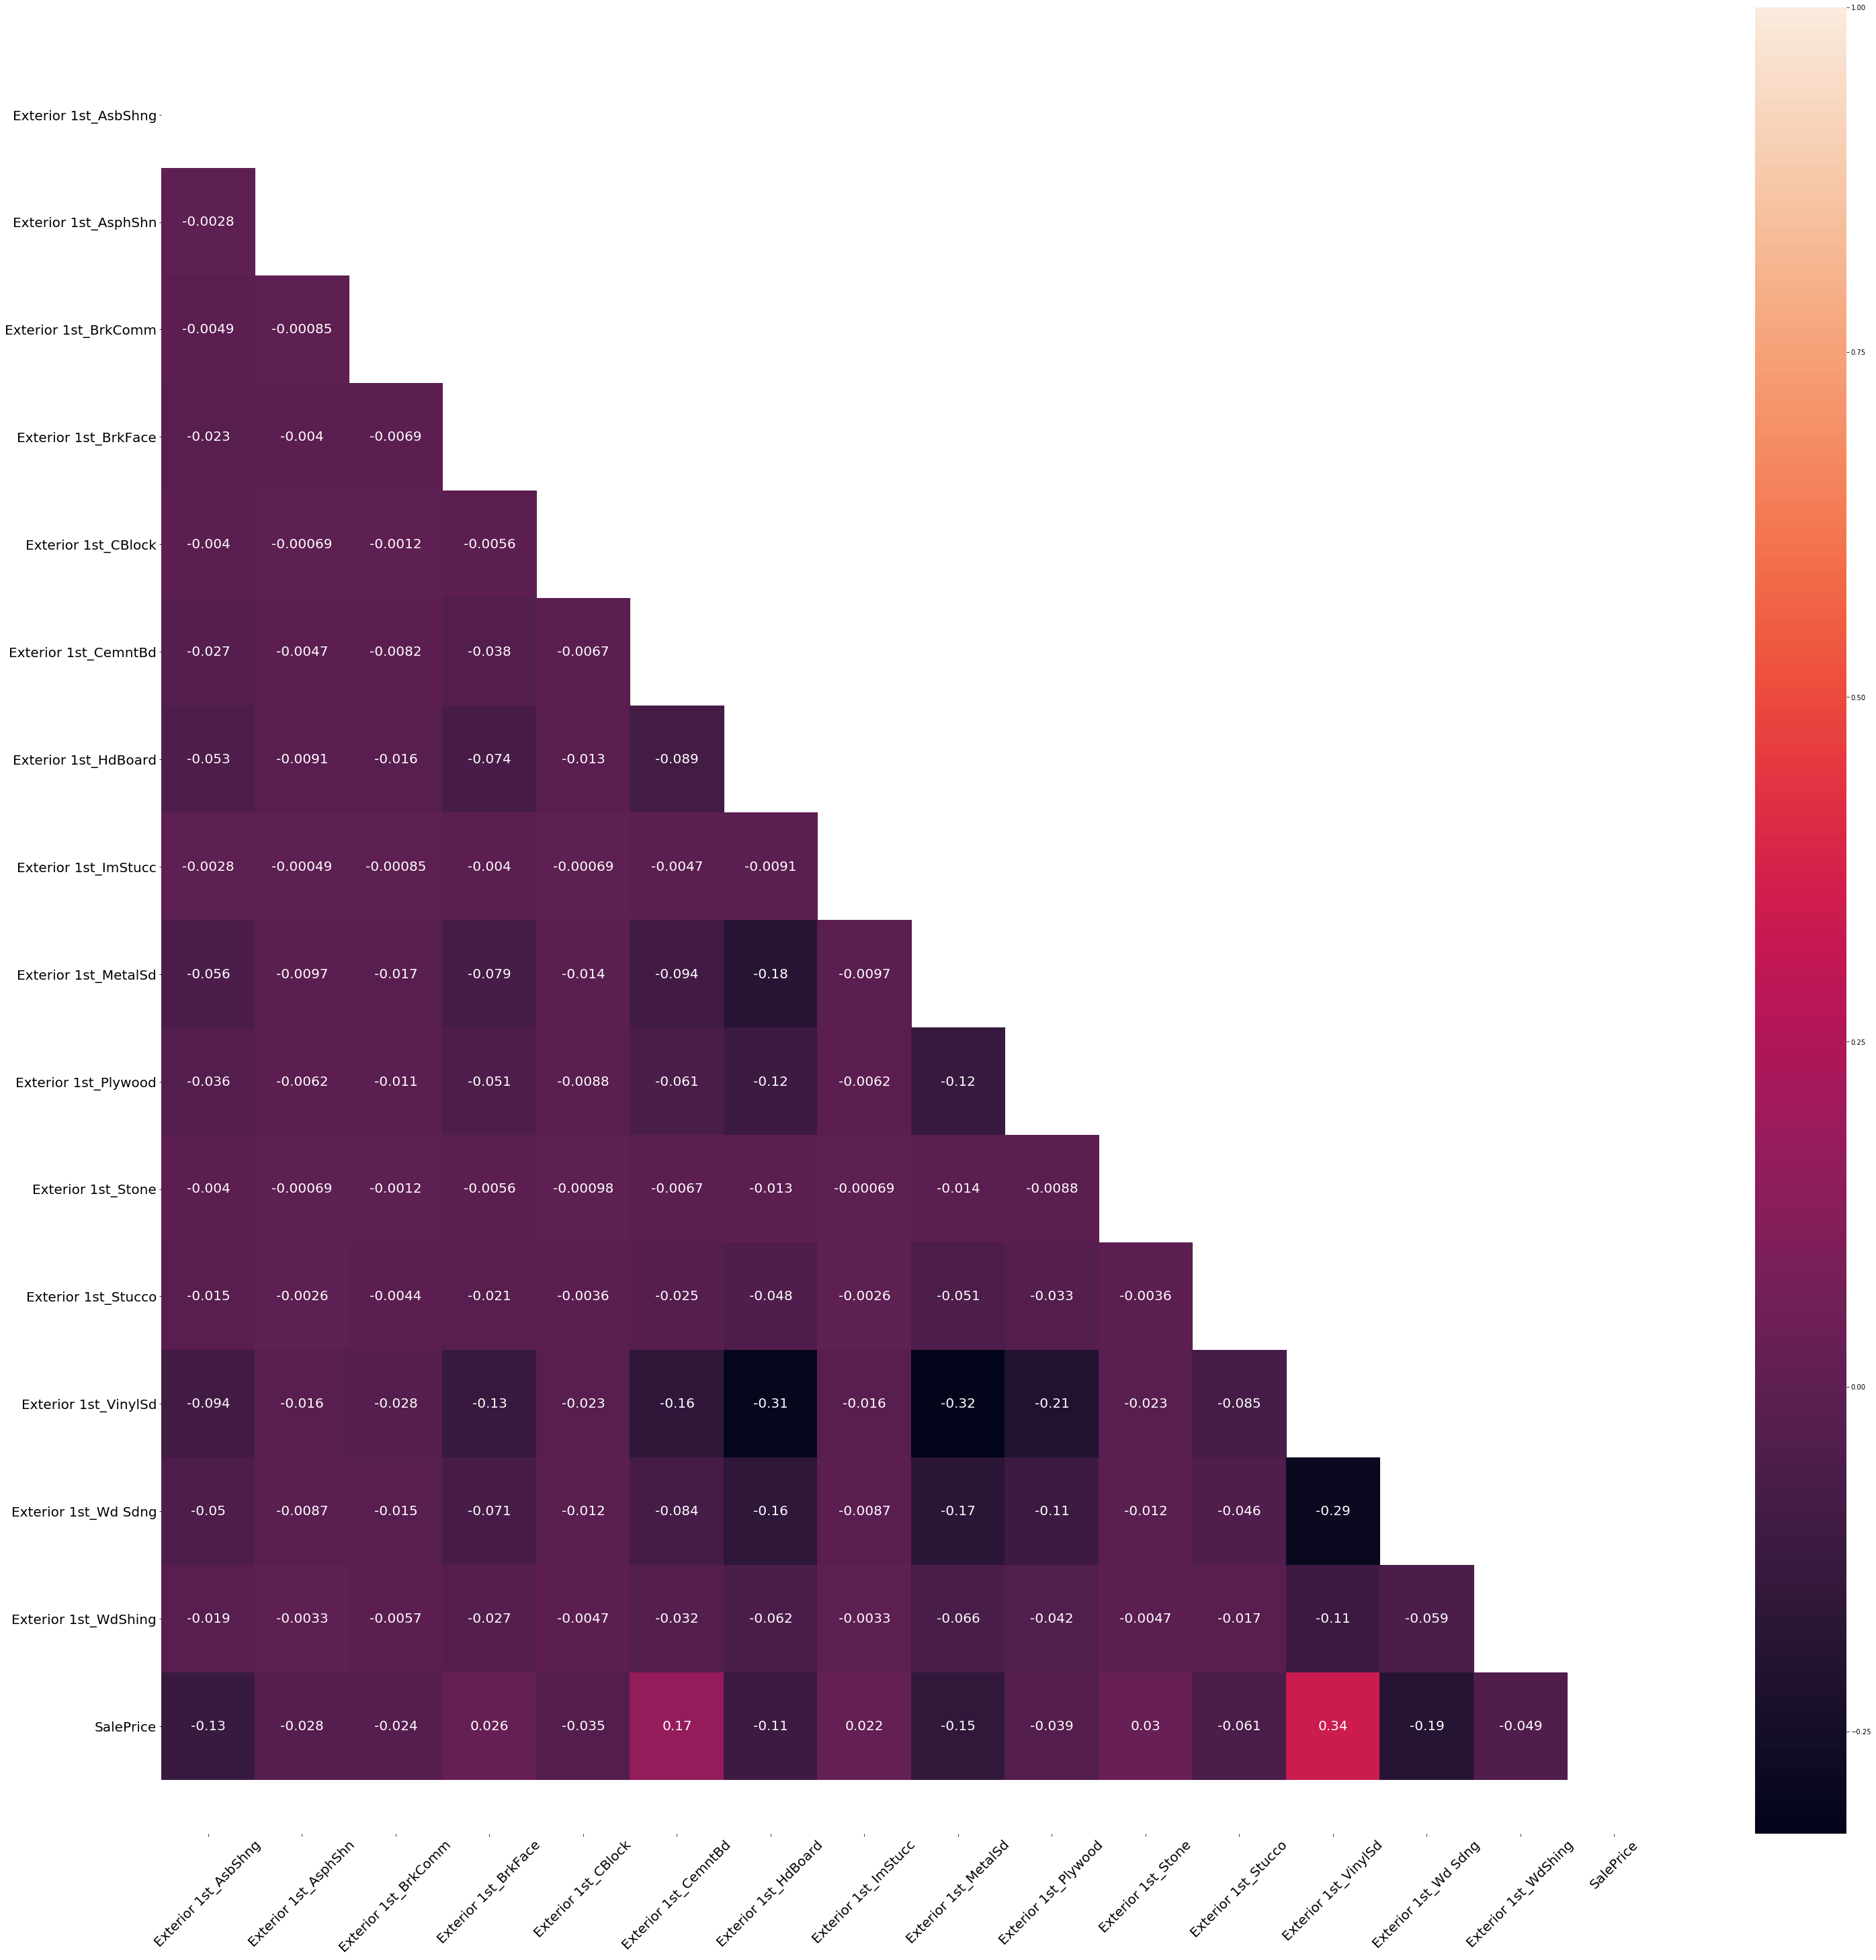

In [45]:
check_corr_func('Exterior 1st','Nominal','Yes','')

## ANS:

For Exterior 1st, there are no null entries.

Value_counts is well distributed.

VinylSd seems to have high correlation with 724/2051 entries, and correlation of 0.34.


Consider using Exterior 1st VinylSd as predictor if needed to improve model.


Exterior 2nd    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Exterior 2nd'.

These are the value_counts.

VinylSd    721
MetalSd    324
HdBoard    275
Wd Sdng    262
Plywood    185
CmentBd     90
Wd Shng     63
BrkFace     34
Stucco      30
AsbShng     28
Brk Cmn     17
ImStucc     11
Stone        6
AsphShn      3
CBlock       2
Name: Exterior 2nd, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Exterior 2nd_AsbShng  2051 non-null   uint8
 1   Exterior 2nd_AsphShn  2051 non-null   uint8
 2   Exterior 2nd_Brk Cmn  2051 non-null   uint8
 3   Exterior 2nd_BrkFace  2051 non-null   uint8
 4   Exterior 2nd_CBlock   2051 non-null   uint8
 5   Exterior 2nd_CmentBd  2051 non-null   uint8
 6   Exterior 2nd_HdBoard  2051 non-null   uint8
 7   Exterior 2nd_ImStucc  2051 non-null   uint8
 8   Ex

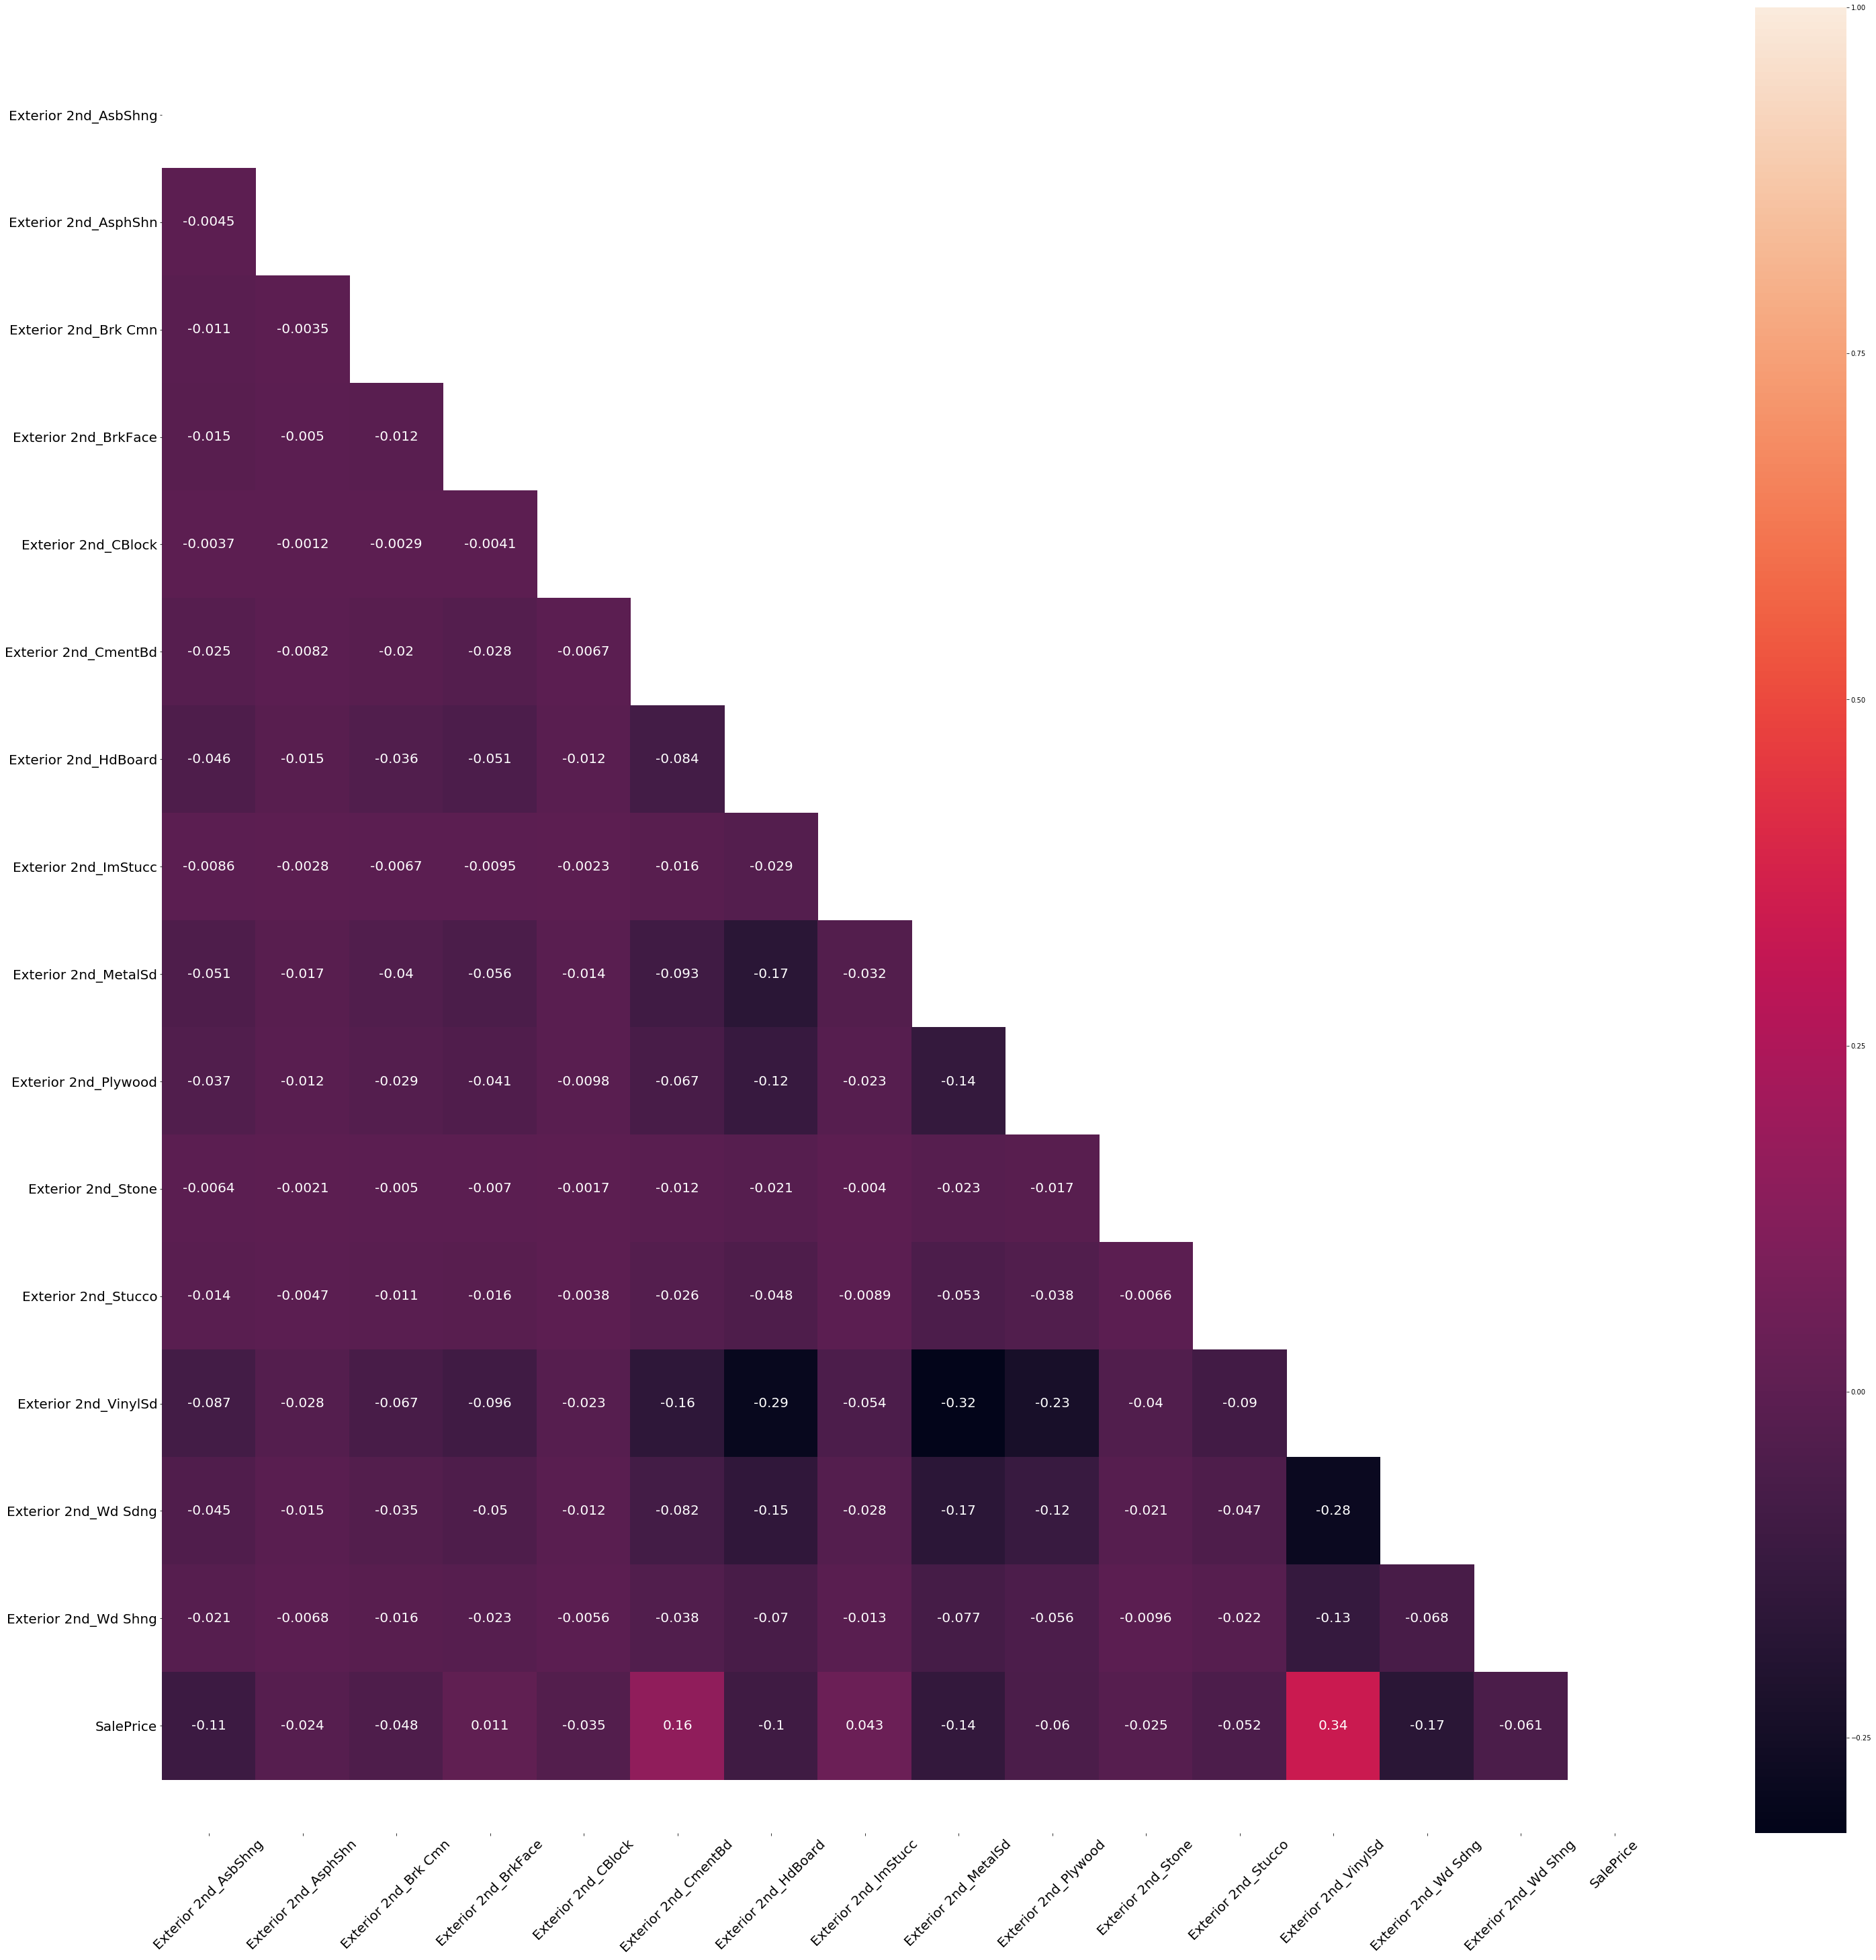

In [46]:
check_corr_func('Exterior 2nd','Nominal','Yes','')

## ANS:

For Exterior 2nd, there are no null entries.

Value_counts is well distributed.

VinylSd seems to have high correlation with 721/2051 entries, and correlation of 0.34.


Consider using Exterior 2nd VinylSd as predictor if needed to improve model.

Mas Vnr Type    22
SalePrice        0
dtype: int64
There are some entries with null values in 'Mas Vnr Type'.


After null value processing, this is the new null count.

Mas Vnr Type    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Mas Vnr Type_BrkCmn   2029 non-null   float64
 1   Mas Vnr Type_BrkFace  2029 non-null   float64
 2   Mas Vnr Type_None     2029 non-null   float64
 3   Mas Vnr Type_Stone    2029 non-null   float64
 4   SalePrice             2051 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 96.1 KB
None


       Mas Vnr Type_BrkCmn  Mas Vnr Type_BrkFace  Mas Vnr Type_None  \
count          2029.000000 

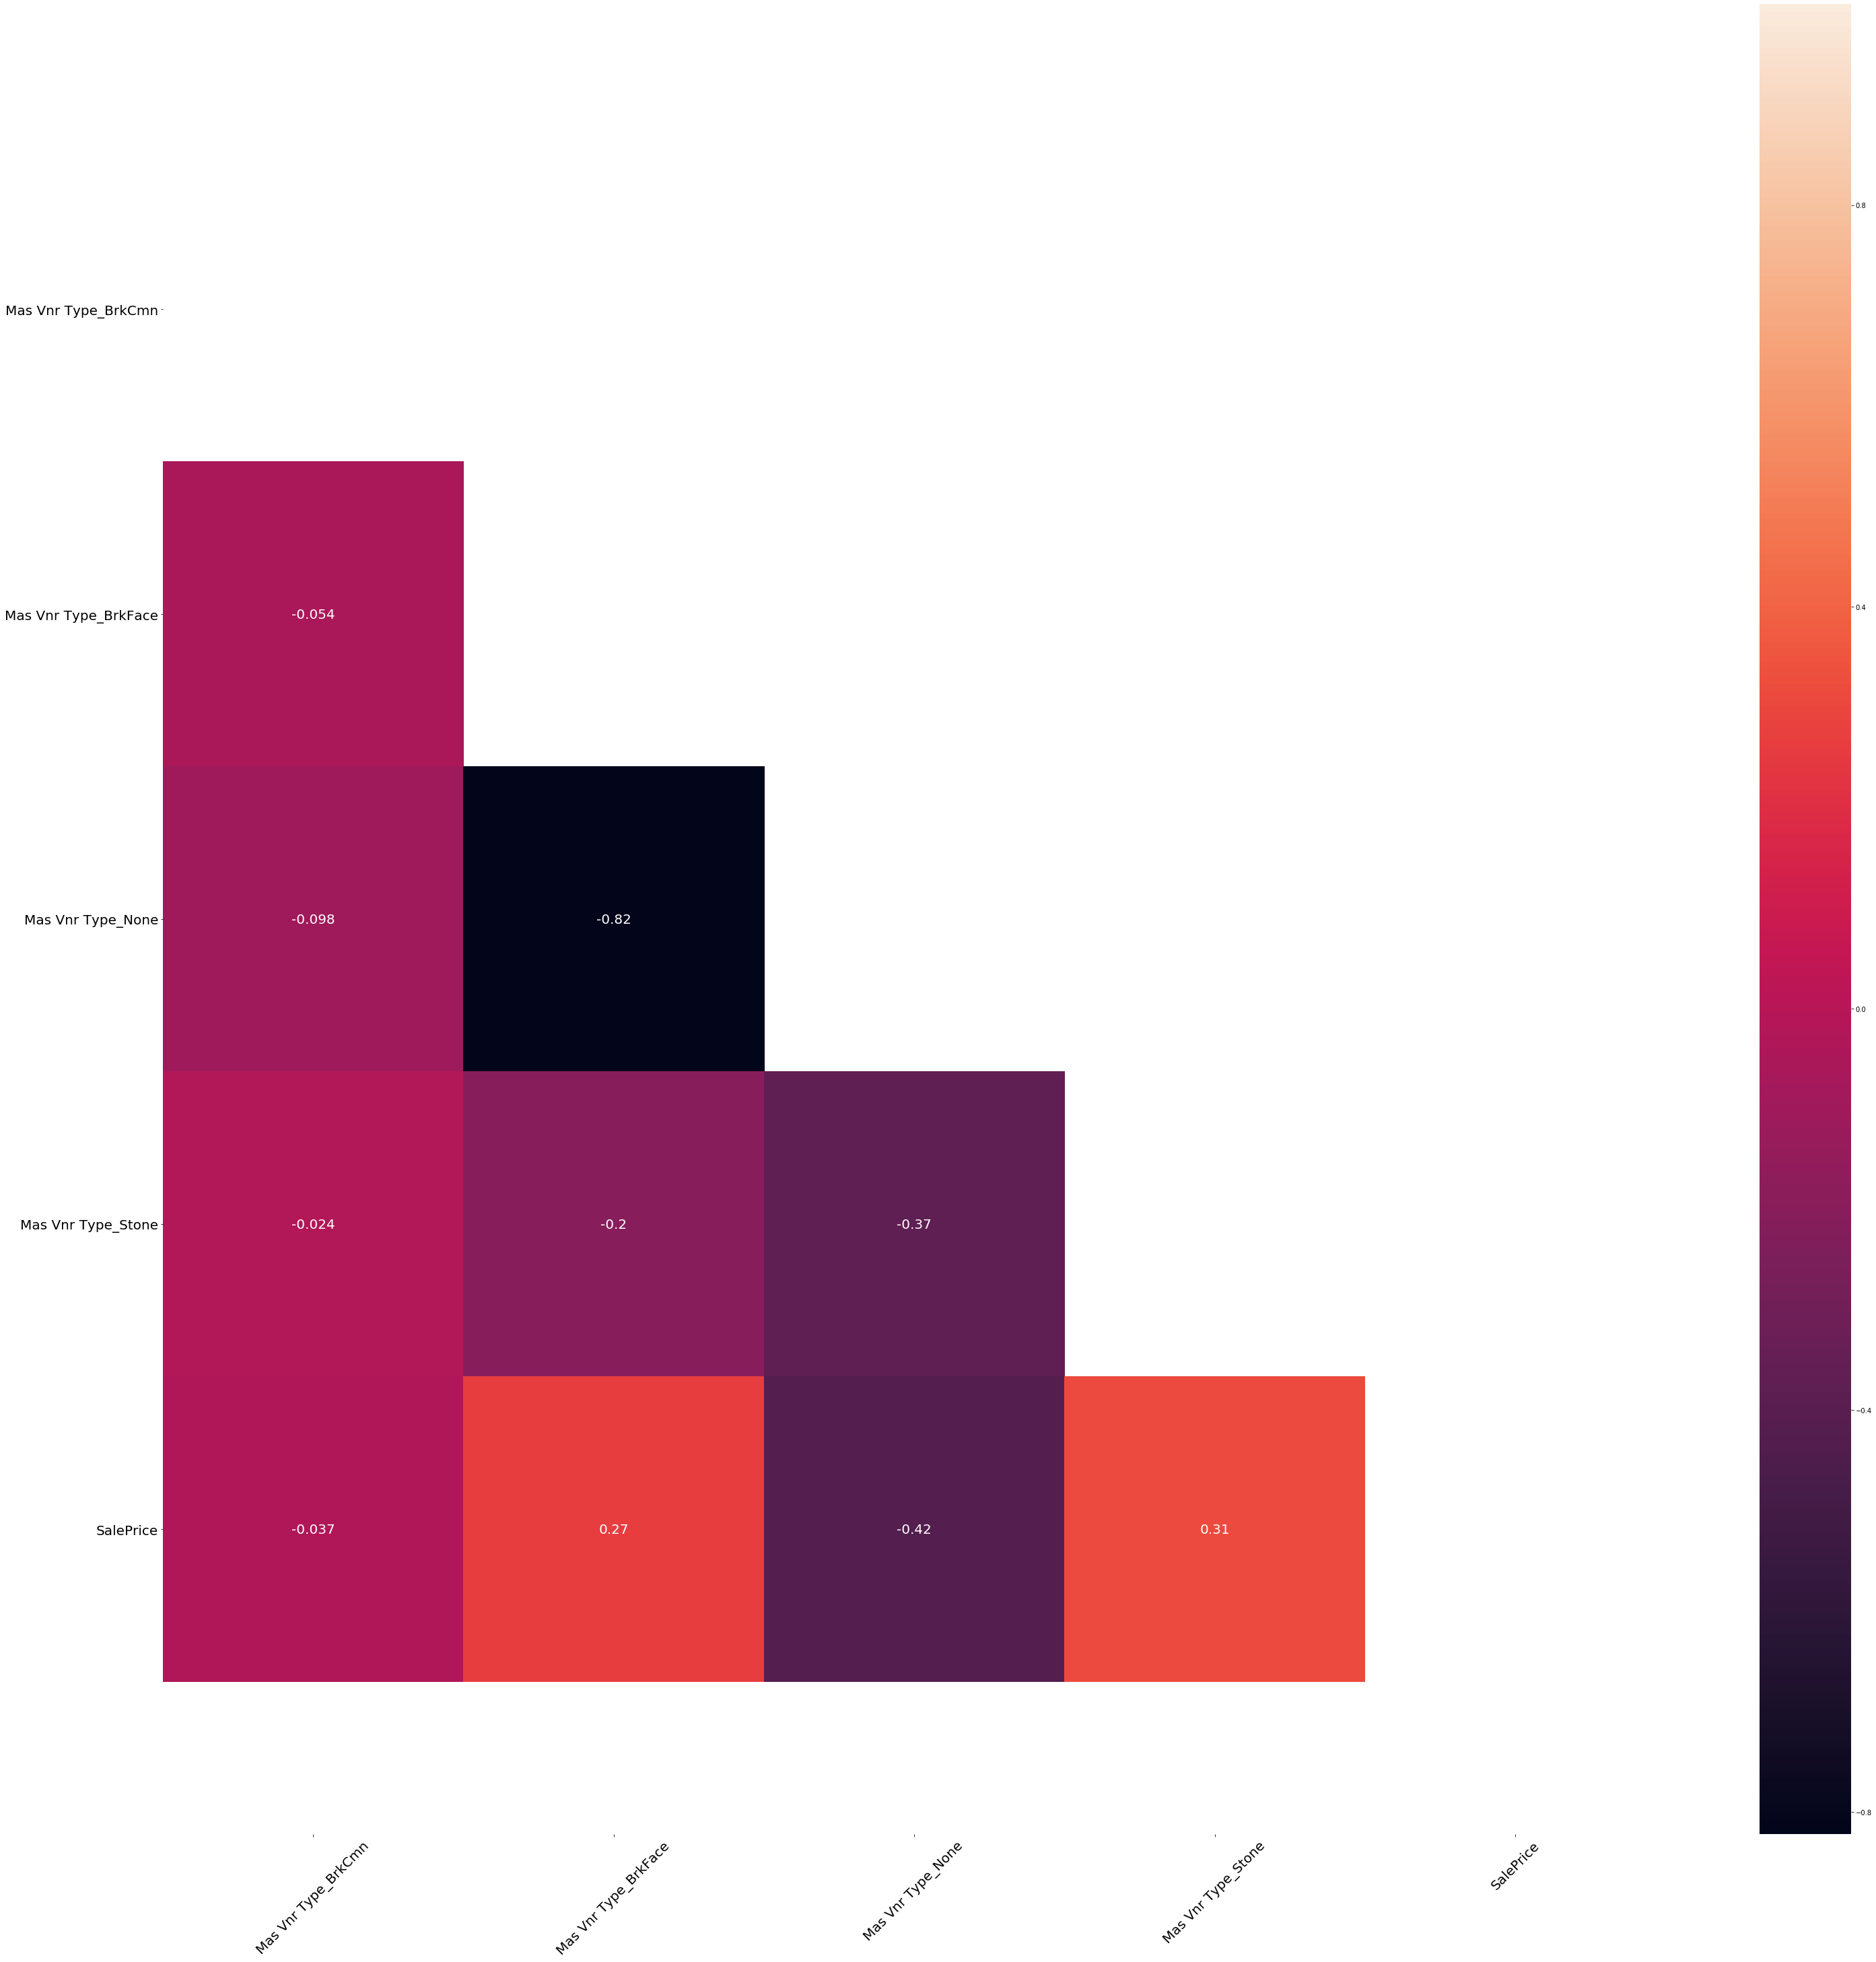

In [47]:
check_corr_func('Mas Vnr Type','Nominal','Yes','')

## ANS:

For Mas Vnr Type, there are 22 null entries.

1218/2051 have None for Mas Vnr Type, with a correlation of -0.42.

Note that holdout data has 1 null entry for Mas Vnr Type. if not dropping this entire column, need to treat same for both training and holdout.

BrkFace is 630/2051, correlation of 0.27.
Stone is 168/2051, correlation of 0.31.

checked the lone null entry on holdout data, and the PID of the house when referenced against the source data provided via http://www.cityofames.org/assessor/ website, it should be Mas Vnr Type = None.

## Consider using Mas Vnr Type None, BrkFace and Stone as predictors. The 22 Null entries are likely to be dropped as row entries, as we have no efficient and accurate method of determining the 22 Null entries for training data Mas Vnr Type.


Mas Vnr Type    22
SalePrice        0
dtype: int64
There are some entries with null values in 'Mas Vnr Type'.


After null value processing, this is the new null count.

Mas Vnr Type    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

None       1218
BrkFace     630
Stone       168
Unknown      22
BrkCmn       13
Name: Mas Vnr Type, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Mas Vnr Type_BrkCmn   2051 non-null   uint8
 1   Mas Vnr Type_BrkFace  2051 non-null   uint8
 2   Mas Vnr Type_None     2051 non-null   uint8
 3   Mas Vnr Type_Stone    2051 non-null   uint8
 4   Mas Vnr Type_Unknown  2051 non-null   uint8
 5   SalePrice             2051 non-null   int64
dtypes: int64(1), uint8(5)
memory usage: 26.2 KB
None


       Mas Vnr Type_BrkCmn  Mas Vnr Type_BrkFace 

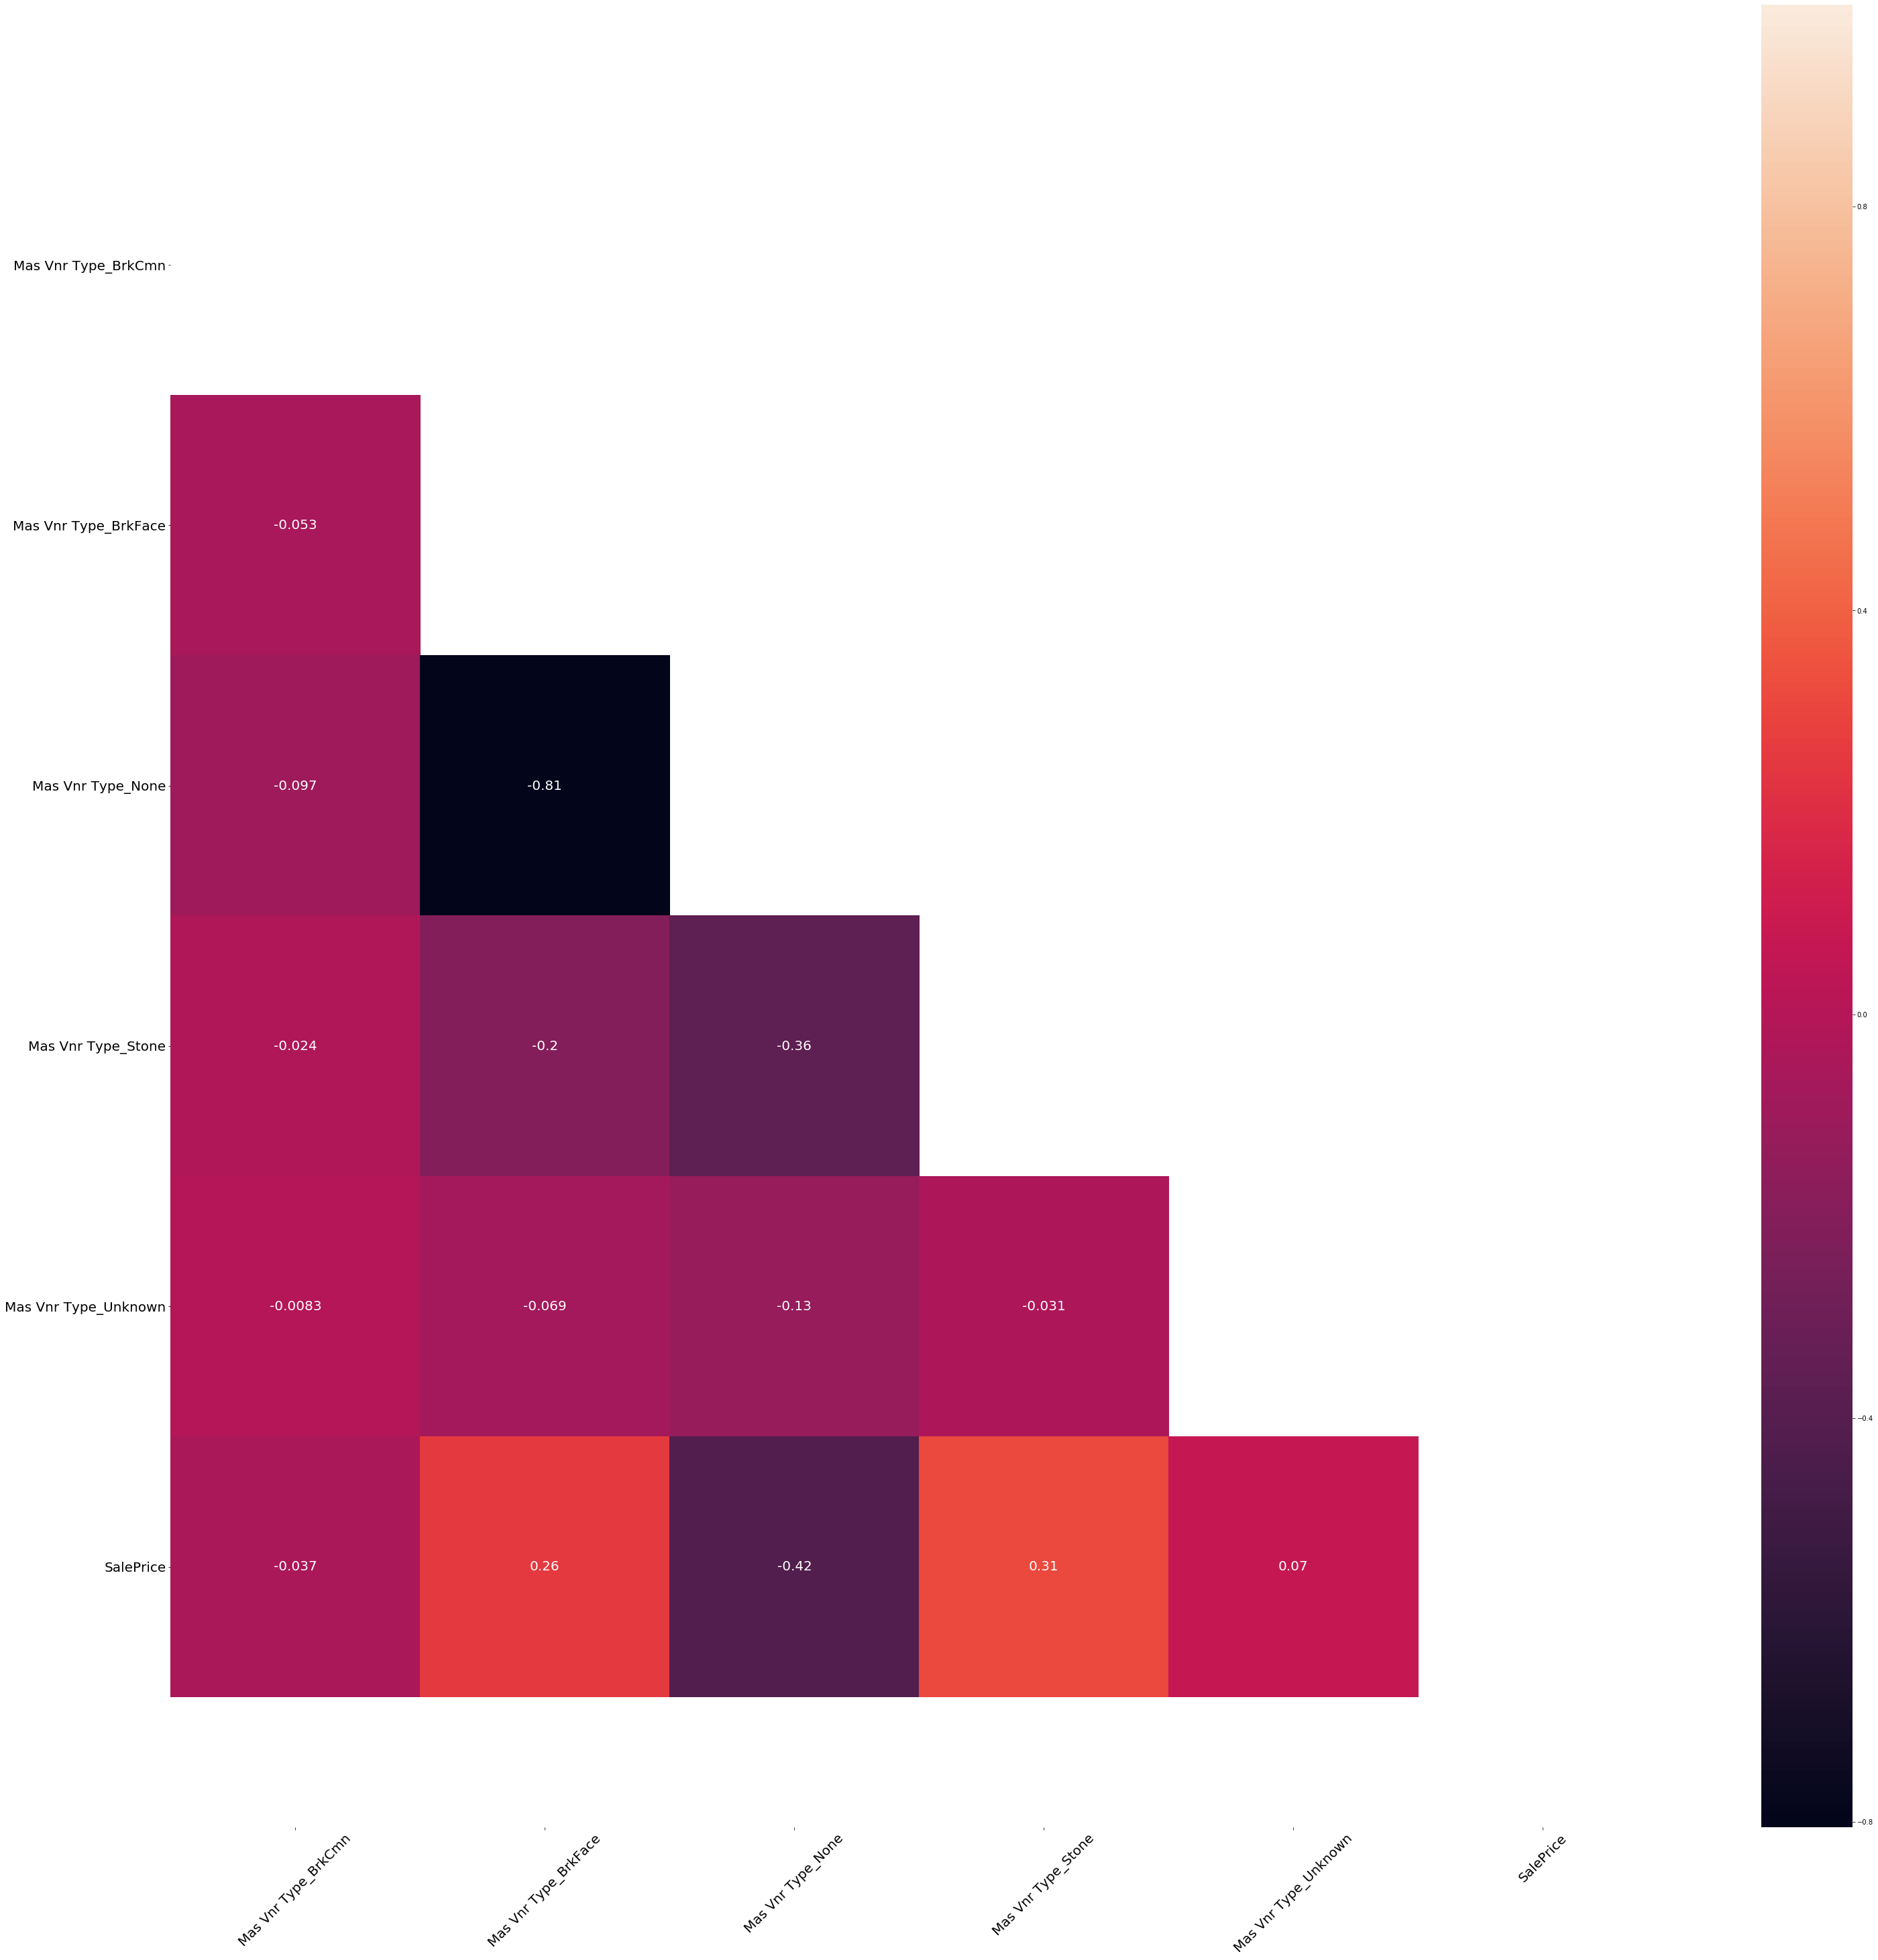

In [48]:
check_corr_func('Mas Vnr Type','Nominal','No','')

## ANS:

see above markdown cell for treatment and EDA on Mas Vnr Type.

Mas Vnr Area    22
SalePrice        0
dtype: int64
There are some entries with null values in 'Mas Vnr Area'.


After null value processing, this is the new null count.

Mas Vnr Area    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

0.0       1216
120.0       11
176.0       10
200.0       10
180.0        9
          ... 
361.0        1
121.0        1
156.0        1
66.0         1
1031.0       1
Name: Mas Vnr Area, Length: 373, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mas Vnr Area  2029 non-null   float64
 1   SalePrice     2029 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 47.6 KB
None


       Mas Vnr Area      SalePrice
count   2029.000000    2029.000000
mean      99.695909  180890.013307
std      174.963129   79123.070755
min        0.000000   12789.0

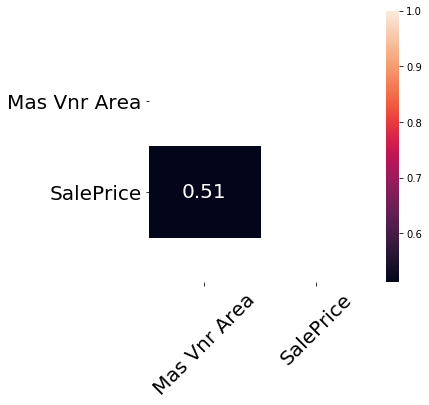

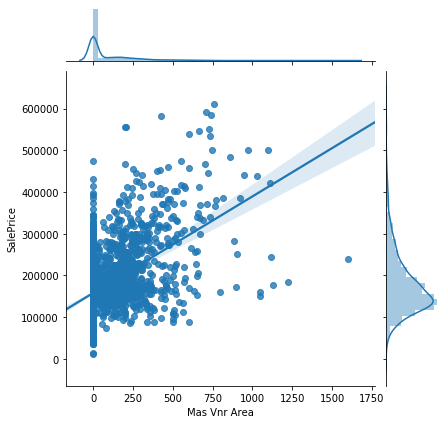

In [49]:
check_corr_func('Mas Vnr Area','Continuous','Yes','')

## ANS:

For Mas Vnr Area, there are 22 null entries.

1216/2051 have 0.0 for Mas Vnr Area, implying no Masonry Veneer for these houses.

Overall correlation seems strong at 0.51.

Best model fitting would be splitting off the zero entries and doing the model based on the remaining entries if time permits.

Note that holdout data has 1 null entry for Mas Vnr Area. if not dropping this entire column, need to treat same for both training and holdout.

checked the lone null entry on holdout data, and the PID of the house when referenced against the source data provided via http://www.cityofames.org/assessor/ website, it should be Mas Vnr Type = None.

Considered using Mas Vnr Area as Predictor, but decided to drop it, as spread is still very wide even if not taking in 0 entries

Mas Vnr Area    22
SalePrice        0
dtype: int64
There are some entries with null values in 'Mas Vnr Area'.


After null value processing, this is the new null count.

Mas Vnr Area    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

0.0        1216
Unknown      22
120.0        11
200.0        10
176.0        10
           ... 
359.0         1
361.0         1
161.0         1
362.0         1
225.0         1
Name: Mas Vnr Area, Length: 374, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Mas Vnr Area  2051 non-null   object
 1   SalePrice     2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.0

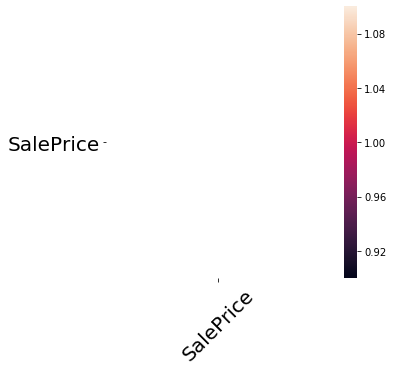

In [50]:
check_corr_func('Mas Vnr Area','Continuous','No','')

## ANS:

see above markdown cell for treatment and EDA on Mas Vnr Area.

Exter Qual    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Exter Qual'.

These are the value_counts.

TA    1247
Gd     697
Ex      81
Fa      26
Name: Exter Qual, dtype: int64

Set of all possible values for column {'Fa', 'Ex', 'Gd', 'TA'}


List of all possible values for column, including 'Unknown' for 'Exter Qual': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    1247
Gd     697
Ex      81
Fa      26
Name: Exter Qual, dtype: int64
3    1247
4     697
5      81
2      26
Name: Exter Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Exter Qual  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Exter Qual      SalePrice
count  2051.000000    2051.000000
mean      3.406143  181469.701609
std       0.587962   79258.659352
min       2.0000

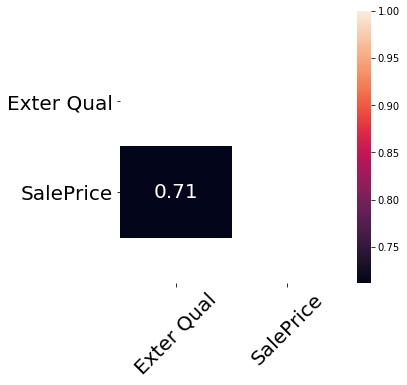

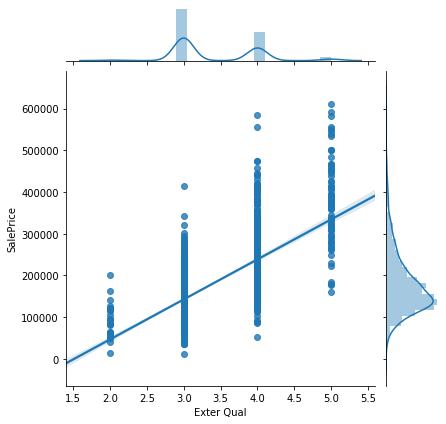

In [51]:
check_corr_func('Exter Qual','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

For Exter Qual, there are 0 null entries.

1247/2051 are TA
697 are Gd

Distribution is mainly on 2 peaks, with good correlation of 0.71.

## Use Exter Qual as Predictor.

Exter Cond    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Exter Cond'.

These are the value_counts.

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: Exter Cond, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Exter Cond': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: Exter Cond, dtype: int64
3    1778
4     215
2      49
5       7
1       2
Name: Exter Cond, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Exter Cond  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Exter Cond      SalePrice
count  2051.000000    2051.000000
mean      3.085812  181469.701609
std       0.

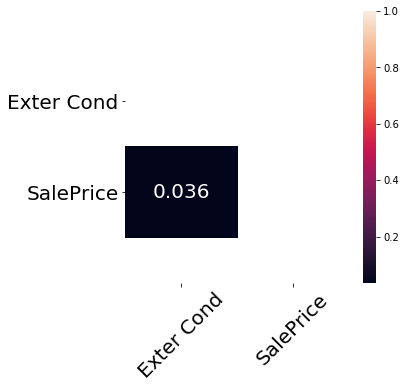

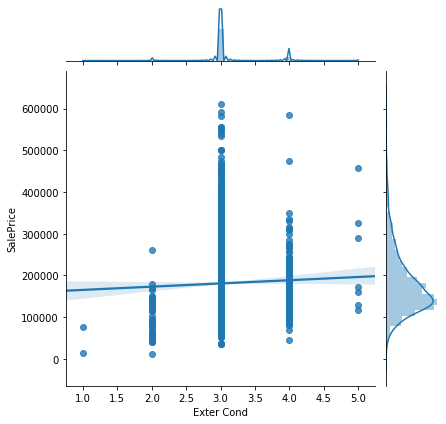

In [52]:
check_corr_func('Exter Cond','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

For Exter Cond, there are 0 null entries.

Distribution is mainly on 2 peaks, with poor correlation of 0.036.

drop Exter Cond as predictor.

Foundation    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Foundation'.

These are the value_counts.

PConc     926
CBlock    863
BrkTil    221
Slab       34
Stone       5
Wood        2
Name: Foundation, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Foundation_BrkTil  2051 non-null   uint8
 1   Foundation_CBlock  2051 non-null   uint8
 2   Foundation_PConc   2051 non-null   uint8
 3   Foundation_Slab    2051 non-null   uint8
 4   Foundation_Stone   2051 non-null   uint8
 5   Foundation_Wood    2051 non-null   uint8
 6   SalePrice          2051 non-null   int64
dtypes: int64(1), uint8(6)
memory usage: 28.2 KB
None


       Foundation_BrkTil  Foundation_CBlock  Foundation_PConc  \
count        2051.000000        2051.000000       2051.000000   
mean            0.107752           0.420770    

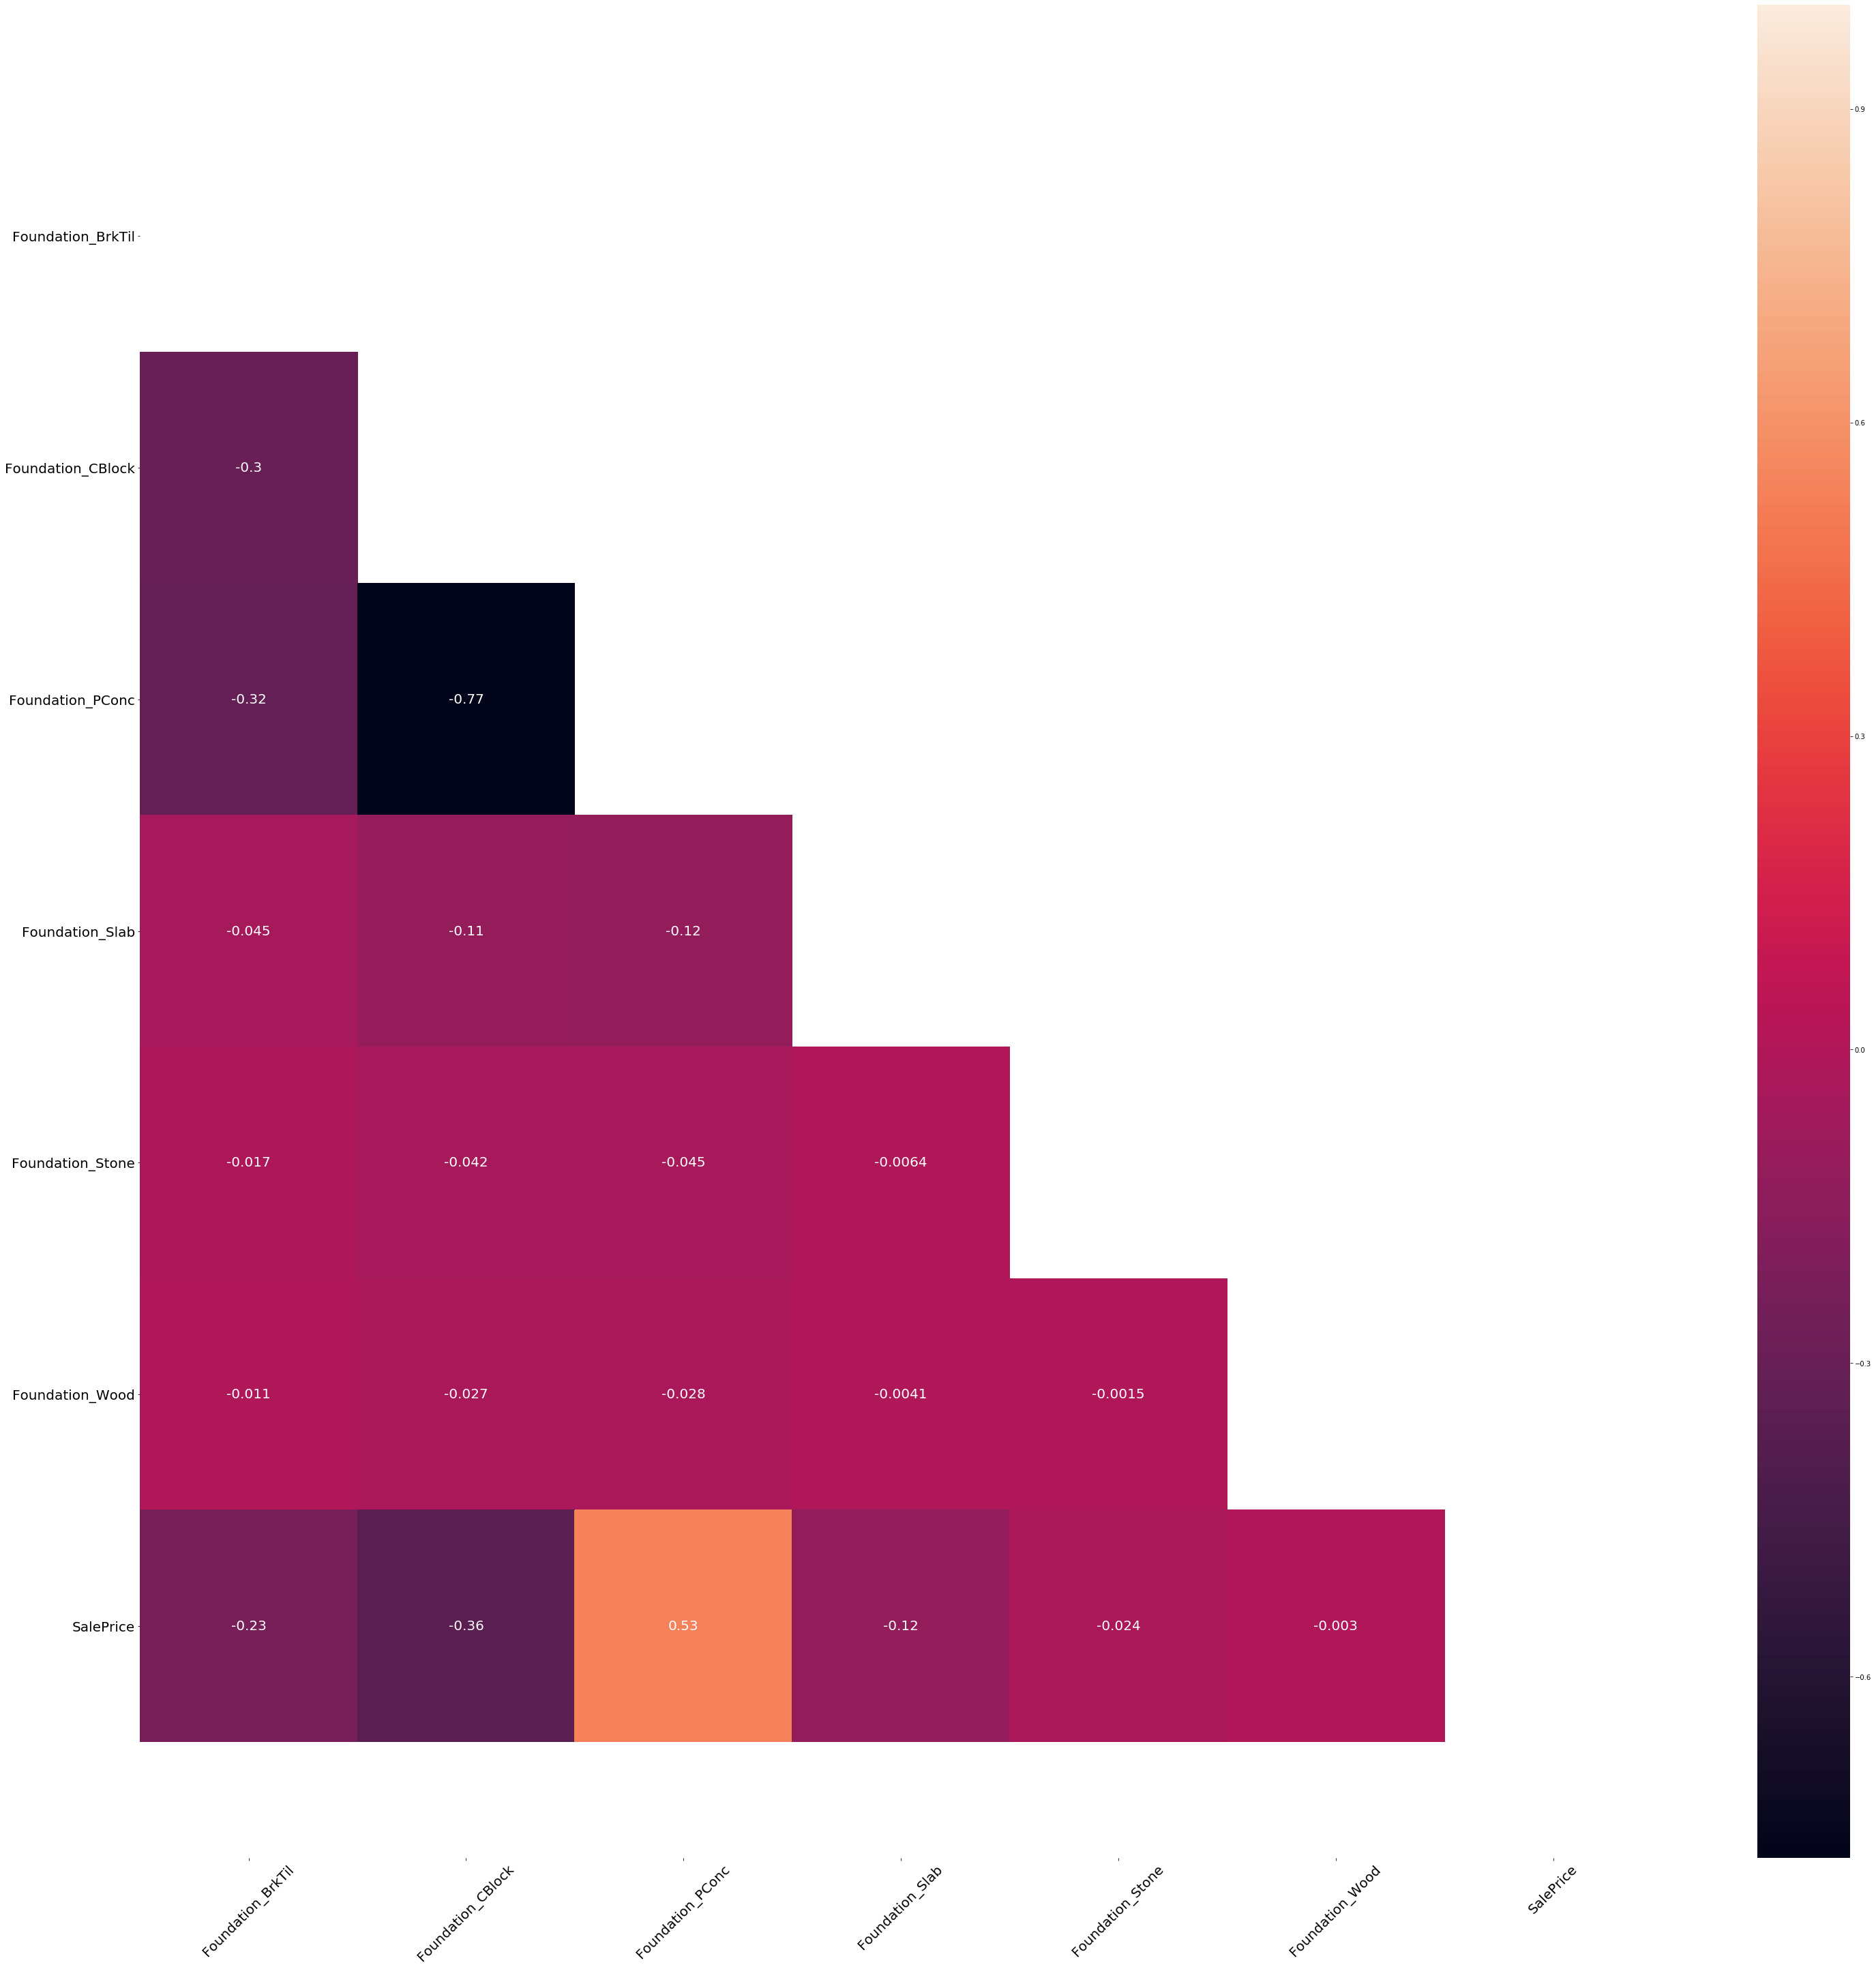

In [53]:
check_corr_func('Foundation','Nominal','Yes','')

## ANS:

For Foundation, there are 0 null entries.

Distribution is mainly on 2 catgoeries
926/2051 for PConc correlation good at 0.53.
863/2051 for CBlock correlation decent at -0.36.

## use Foundation PConc and CBlock for Predictors.

Bsmt Qual    55
SalePrice     0
dtype: int64
There are some entries with null values in 'Bsmt Qual'.


After null value processing, this is the new null count.

Bsmt Qual    0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Bsmt Qual': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64
3    887
4    864
5    184
2     60
1      1
Name: Bsmt Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Bsmt Qual  1996 non-null   int64
 1   SalePrice  1996 non-null   int64
dtypes: int64(2)
memory usage: 46.8 KB
None




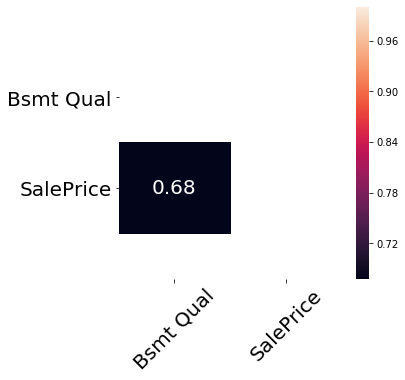

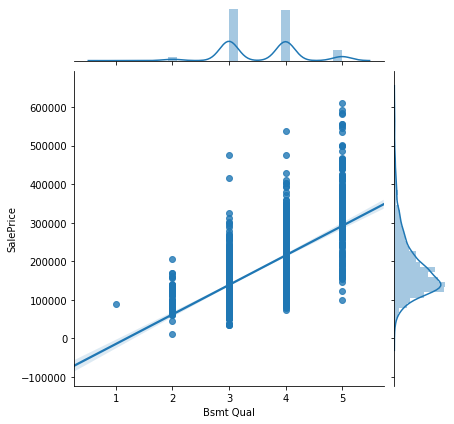

In [54]:
check_corr_func('Bsmt Qual','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

For Bsmt Qual, there are 55 null entries. The null entries are actually houses with no Basements, hence no Bsmt Qual.

As correlation for dropping all 55 null entries is 0.68 and assigning a value of 0 to the null entries results in correlation of 0.61, the difference is not too much, and due to time constraints, the treatment for Bsmt Qual will be to assign value of 0 to all null entries.

0.68 is a good correlation score.

## Use Bsmt Qual as Predictor, all Null values to be converted to 0.

Bsmt Qual    55
SalePrice     0
dtype: int64
There are some entries with null values in 'Bsmt Qual'.


After null value processing, this is the new null count.

Bsmt Qual    0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

TA         887
Gd         864
Ex         184
Fa          60
Unknown     55
Po           1
Name: Bsmt Qual, dtype: int64

Set of all possible values for column {'Unknown', 'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Bsmt Qual': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA         887
Gd         864
Ex         184
Fa          60
Unknown     55
Po           1
Name: Bsmt Qual, dtype: int64
3    887
4    864
5    184
2     60
0     55
1      1
Name: Bsmt Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Bsmt Qual  2051 n

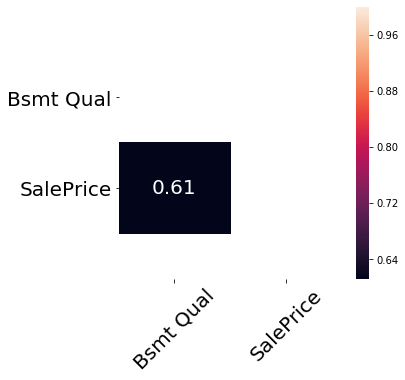

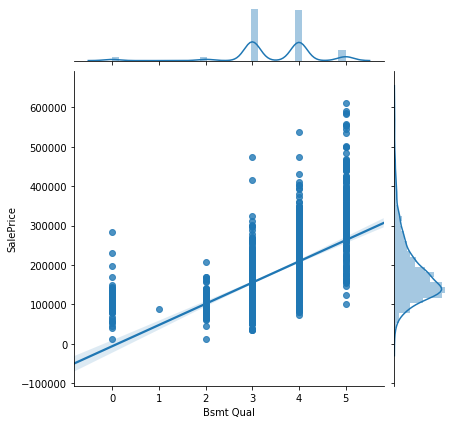

In [55]:
check_corr_func('Bsmt Qual','Ordinal','No','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

See above markdown cell on Bsmt Qual for EDA and treatment.

Bsmt Cond    55
SalePrice     0
dtype: int64
There are some entries with null values in 'Bsmt Cond'.


After null value processing, this is the new null count.

Bsmt Cond    0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

TA    1834
Gd      89
Fa      65
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Bsmt Cond': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    1834
Gd      89
Fa      65
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64
3    1834
4      89
2      65
1       5
5       3
Name: Bsmt Cond, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Bsmt Cond  1996 non-null   int64
 1   SalePrice  1996 non-null   int64
dtypes: int64(2)
memory usage: 

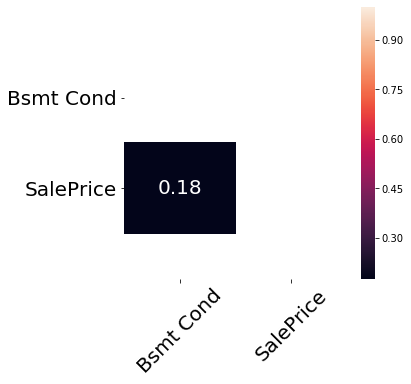

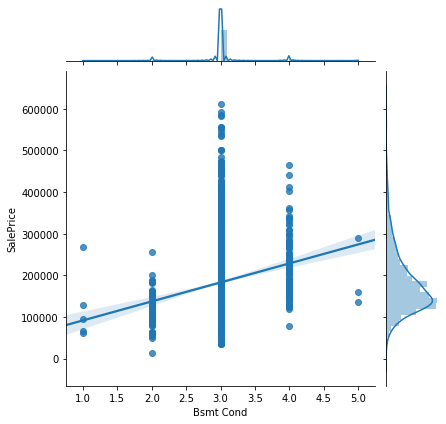

In [56]:
check_corr_func('Bsmt Cond','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

For Bsmt Cond, there are 55 null entries. The null entries are actually houses with no Basements, hence no Bsmt Cond.

As correlation for dropping all 55 null entries is 0.18 and assigning a value of 0 to the null entries results in correlation of 0.23, the difference is not too much, and due to time constraints, the treatment for Bsmt Cond will be to assign value of 0 to all null entries.

Visual EDA indicates that Bsmt Cond can be considered as predictor.

## Use Bsmt Cond as Predictor, all Null values to be converted to 0.

Bsmt Cond    55
SalePrice     0
dtype: int64
There are some entries with null values in 'Bsmt Cond'.


After null value processing, this is the new null count.

Bsmt Cond    0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

TA         1834
Gd           89
Fa           65
Unknown      55
Po            5
Ex            3
Name: Bsmt Cond, dtype: int64

Set of all possible values for column {'Unknown', 'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Bsmt Cond': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA         1834
Gd           89
Fa           65
Unknown      55
Po            5
Ex            3
Name: Bsmt Cond, dtype: int64
3    1834
4      89
2      65
0      55
1       5
5       3
Name: Bsmt Cond, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0  

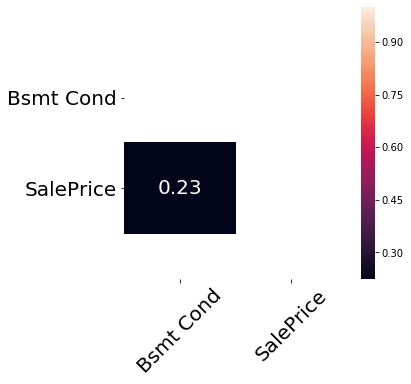

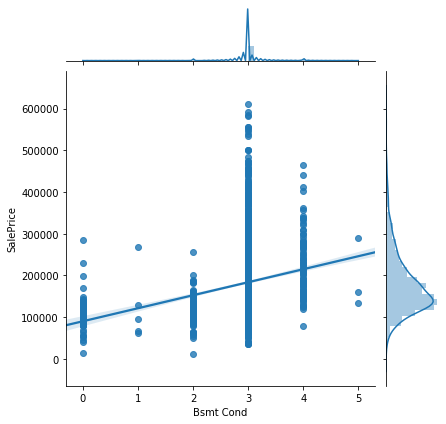

In [57]:
check_corr_func('Bsmt Cond','Ordinal','No','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

See above markdown cell on Bsmt Cond for EDA and treatment.

Bsmt Exposure    58
SalePrice         0
dtype: int64
There are some entries with null values in 'Bsmt Exposure'.


After null value processing, this is the new null count.

Bsmt Exposure    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

No    1339
Av     288
Gd     203
Mn     163
Name: Bsmt Exposure, dtype: int64

Set of all possible values for column {'No', 'Mn', 'Av', 'Gd'}


List of all possible values for column, including 'Unknown' for 'Bsmt Exposure': ['Unknown', 'No', 'Mn', 'Av', 'Gd']

No    1339
Av     288
Gd     203
Mn     163
Name: Bsmt Exposure, dtype: int64
1    1339
3     288
4     203
2     163
Name: Bsmt Exposure, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Bsmt Exposure  1993 non-null   int64
 1   SalePrice      1993 non-null   int64
dtypes: int64(2)
memory

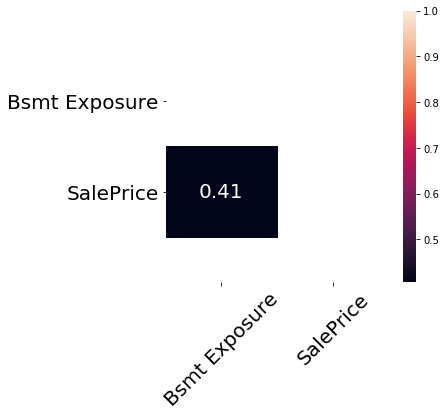

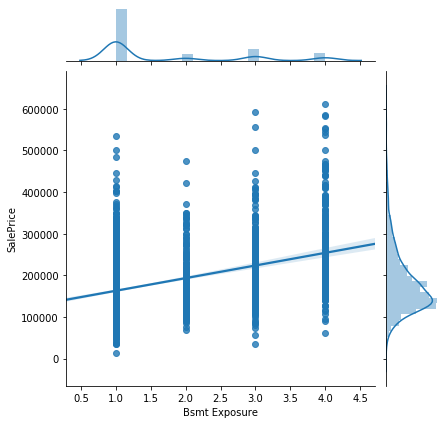

In [58]:
check_corr_func('Bsmt Exposure','Ordinal','Yes','Unknown,No,Mn,Av,Gd')

## ANS:

For Bsmt Exposure, there are 58 null entries. The null entries are actually houses with no Basements, hence no Bsmt Exposure.

As correlation for dropping all 58 null entries is 0.41 and assigning a value of 0 to the null entries results in correlation of 0.42, the difference is not too much, and due to time constraints, the treatment for Bsmt Exposure will be to assign value of 0 to all null entries.

Visual EDA indicates that Bsmt Exposure can be considered as predictor.

## Use Bsmt Exposure as Predictor, all Null values to be converted to 0.

Bsmt Exposure    58
SalePrice         0
dtype: int64
There are some entries with null values in 'Bsmt Exposure'.


After null value processing, this is the new null count.

Bsmt Exposure    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

No         1339
Av          288
Gd          203
Mn          163
Unknown      58
Name: Bsmt Exposure, dtype: int64

Set of all possible values for column {'Av', 'Mn', 'No', 'Unknown', 'Gd'}


List of all possible values for column, including 'Unknown' for 'Bsmt Exposure': ['Unknown', 'No', 'Mn', 'Av', 'Gd']

No         1339
Av          288
Gd          203
Mn          163
Unknown      58
Name: Bsmt Exposure, dtype: int64
1    1339
3     288
4     203
2     163
0      58
Name: Bsmt Exposure, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Bsmt Expo

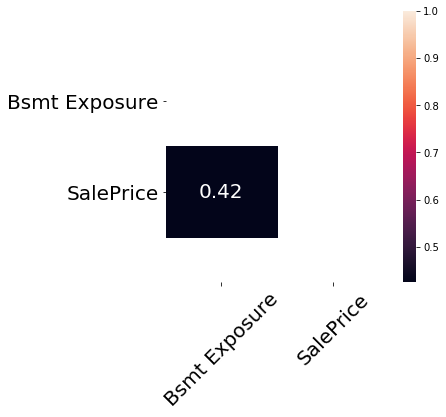

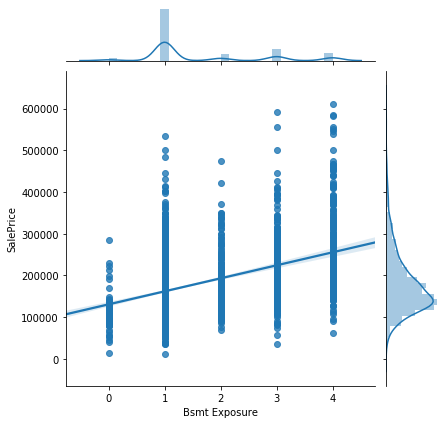

In [59]:
check_corr_func('Bsmt Exposure','Ordinal','No','Unknown,No,Mn,Av,Gd')

## ANS:

See above markdown cell on Bsmt Exposure for EDA and treatment.

BsmtFin Type 1    55
SalePrice          0
dtype: int64
There are some entries with null values in 'BsmtFin Type 1'.


After null value processing, this is the new null count.

BsmtFin Type 1    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: BsmtFin Type 1, dtype: int64

Set of all possible values for column {'LwQ', 'Unf', 'GLQ', 'BLQ', 'Rec', 'ALQ'}


List of all possible values for column, including 'Unknown' for 'BsmtFin Type 1': ['Unknown', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: BsmtFin Type 1, dtype: int64
6    615
1    603
5    293
4    200
3    183
2    102
Name: BsmtFin Type 1, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0

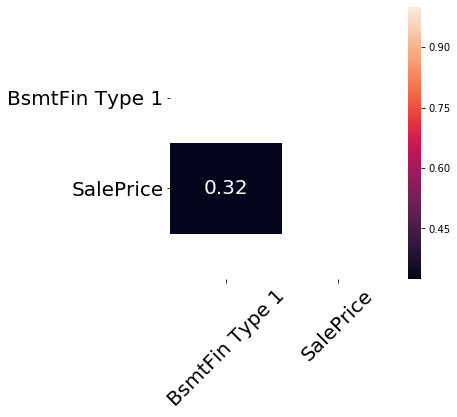

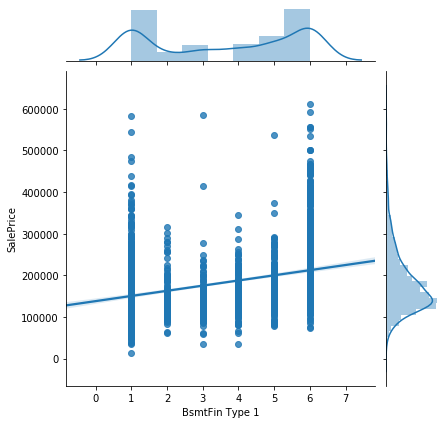

In [60]:
check_corr_func('BsmtFin Type 1','Ordinal','Yes','Unknown,Unf,LwQ,Rec,BLQ,ALQ,GLQ')

## ANS:

For BsmtFin Type 1, there are 55 null entries. The null entries are actually houses with no Basements, hence no BsmtFin Type 1.

As correlation for dropping all 55 null entries is 0.32 and assigning a value of 0 to the null entries results in correlation of 0.35, the difference is not too much, and due to time constraints, the treatment for Bsmt Exposure will be to assign value of 0 to all null entries.

Visual EDA indicates that BsmtFin Type 1 can be considered as predictor.

## Use BsmtFin Type 1 as Predictor, all Null values to be converted to 0.

BsmtFin Type 1    55
SalePrice          0
dtype: int64
There are some entries with null values in 'BsmtFin Type 1'.


After null value processing, this is the new null count.

BsmtFin Type 1    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

GLQ        615
Unf        603
ALQ        293
BLQ        200
Rec        183
LwQ        102
Unknown     55
Name: BsmtFin Type 1, dtype: int64

Set of all possible values for column {'LwQ', 'Unf', 'GLQ', 'Unknown', 'BLQ', 'Rec', 'ALQ'}


List of all possible values for column, including 'Unknown' for 'BsmtFin Type 1': ['Unknown', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

GLQ        615
Unf        603
ALQ        293
BLQ        200
Rec        183
LwQ        102
Unknown     55
Name: BsmtFin Type 1, dtype: int64
6    615
1    603
5    293
4    200
3    183
2    102
0     55
Name: BsmtFin Type 1, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 

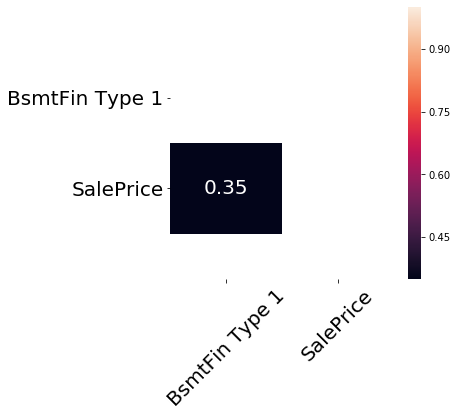

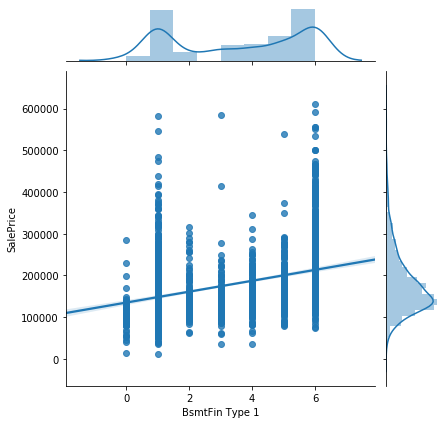

In [61]:
check_corr_func('BsmtFin Type 1','Ordinal','No','Unknown,Unf,LwQ,Rec,BLQ,ALQ,GLQ')

## ANS:
See above markdown cell on BsmtFin Type 1 for EDA and treatment.

BsmtFin SF 1    1
SalePrice       0
dtype: int64
There are some entries with null values in 'BsmtFin SF 1'.


After null value processing, this is the new null count.

BsmtFin SF 1    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

0.0      657
24.0      17
16.0      10
300.0      7
384.0      7
        ... 
848.0      1
70.0       1
688.0      1
472.0      1
661.0      1
Name: BsmtFin SF 1, Length: 821, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtFin SF 1  2050 non-null   float64
 1   SalePrice     2050 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       BsmtFin SF 1      SalePrice
count   2050.000000    2050.000000
mean     442.300488  181519.686829
std      461.204124   79245.655820
min        0.000000   12789.000000
25%        0.00000

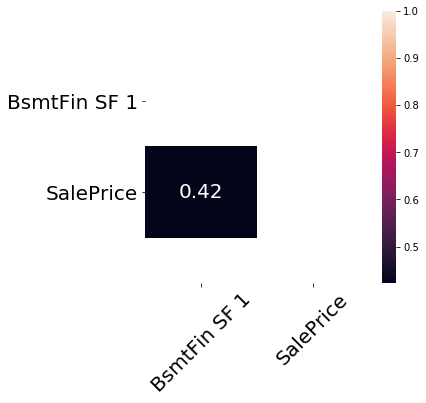

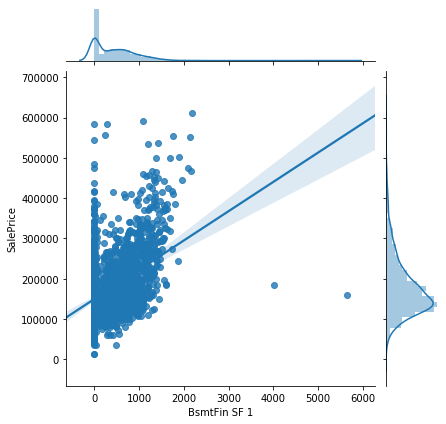

In [62]:
check_corr_func('BsmtFin SF 1','Continuous','Yes','')

## ANS:

For BsmtFin SF 1, there is 1 null entry. Confirmed on website that this null entry is actually a house with no Basement, hence no BsmtFin SF 1. It should be 0.

Visual EDA indicates that BsmtFin SF 1 can be considered as predictor with correlation of 0.42

## Use BsmtFin SF 1 as Predictor, all Null values to be converted to 0.

In [63]:
df_initial_working_data[df_initial_working_data['BsmtFin SF 1'].isnull()]



Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1327  1342  903230120           20        RM          99.0      5940   Pave   

     Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  Fence  \
1327   NaN       IR1          Lvl  ...            0         0     NaN  MnPrv   

     Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
1327          NaN        0       4    2008      ConLD      79000  

[1 rows x 81 columns]

BsmtFin SF 1    1
SalePrice       0
dtype: int64
There are some entries with null values in 'BsmtFin SF 1'.


After null value processing, this is the new null count.

BsmtFin SF 1    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

0.0      657
24.0      17
16.0      10
300.0      7
384.0      7
        ... 
865.0      1
863.0      1
860.0      1
850.0      1
664.0      1
Name: BsmtFin SF 1, Length: 822, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtFin SF 1  2051 non-null   object
 1   SalePrice     2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.000000


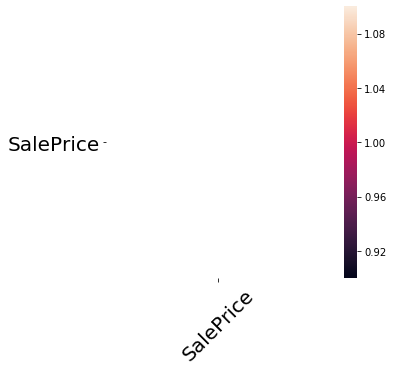

In [64]:
check_corr_func('BsmtFin SF 1','Continuous','No','')

## ANS:
See above markdown cell on BsmtFin SF 1 for EDA and treatment.

BsmtFin Type 2    56
SalePrice          0
dtype: int64
There are some entries with null values in 'BsmtFin Type 2'.


After null value processing, this is the new null count.

BsmtFin Type 2    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: BsmtFin Type 2, dtype: int64

Set of all possible values for column {'LwQ', 'Unf', 'GLQ', 'BLQ', 'Rec', 'ALQ'}


List of all possible values for column, including 'Unknown' for 'BsmtFin Type 2': ['Unknown', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: BsmtFin Type 2, dtype: int64
1    1749
3      80
2      60
4      48
5      35
6      23
Name: BsmtFin Type 2, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          ------

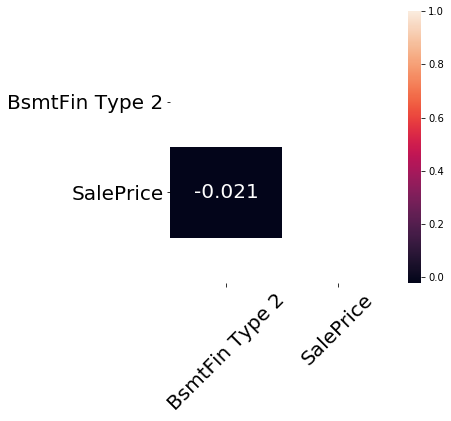

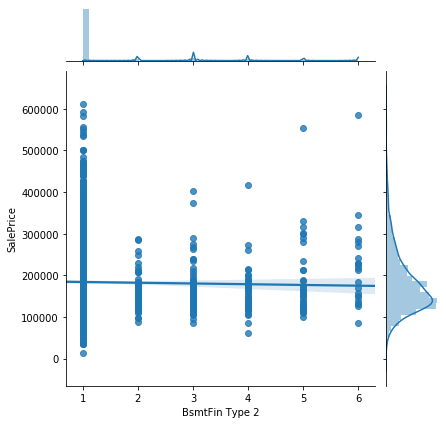

In [65]:
check_corr_func('BsmtFin Type 2','Ordinal','Yes','Unknown,Unf,LwQ,Rec,BLQ,ALQ,GLQ')

## ANS:

For BsmtFin Type 2, there are 56 null entries. 

Correlation is bad at -0.021.

Drop BsmtFin Type 2 as Predictor.


BsmtFin Type 2    56
SalePrice          0
dtype: int64
There are some entries with null values in 'BsmtFin Type 2'.


After null value processing, this is the new null count.

BsmtFin Type 2    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

Unf        1749
Rec          80
LwQ          60
Unknown      56
BLQ          48
ALQ          35
GLQ          23
Name: BsmtFin Type 2, dtype: int64

Set of all possible values for column {'LwQ', 'Unf', 'GLQ', 'Unknown', 'BLQ', 'Rec', 'ALQ'}


List of all possible values for column, including 'Unknown' for 'BsmtFin Type 2': ['Unknown', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

Unf        1749
Rec          80
LwQ          60
Unknown      56
BLQ          48
ALQ          35
GLQ          23
Name: BsmtFin Type 2, dtype: int64
1    1749
3      80
2      60
0      56
4      48
5      35
6      23
Name: BsmtFin Type 2, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
D

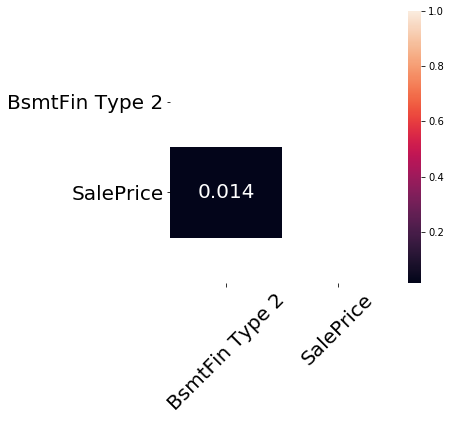

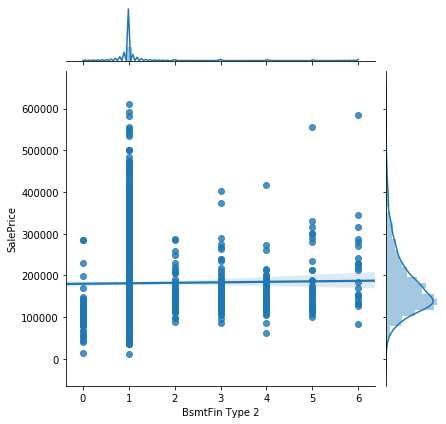

In [66]:
check_corr_func('BsmtFin Type 2','Ordinal','No','Unknown,Unf,LwQ,Rec,BLQ,ALQ,GLQ')

## ANS:
See above markdown cell on BsmtFin SF 2 for EDA and treatment.

BsmtFin SF 2    1
SalePrice       0
dtype: int64
There are some entries with null values in 'BsmtFin SF 2'.


After null value processing, this is the new null count.

BsmtFin SF 2    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

0.0      1803
294.0       5
162.0       3
539.0       3
72.0        3
         ... 
712.0       1
529.0       1
215.0       1
252.0       1
823.0       1
Name: BsmtFin SF 2, Length: 205, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtFin SF 2  2050 non-null   float64
 1   SalePrice     2050 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       BsmtFin SF 2      SalePrice
count   2050.000000    2050.000000
mean      47.959024  181519.686829
std      165.000901   79245.655820
min        0.000000   12789.000000
25%    

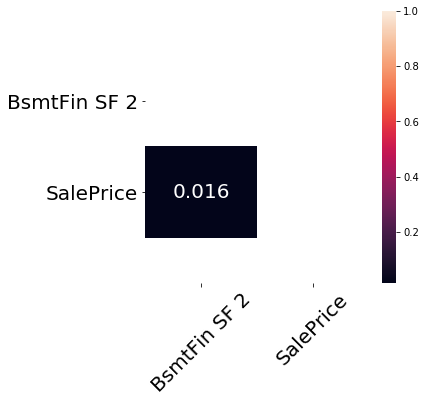

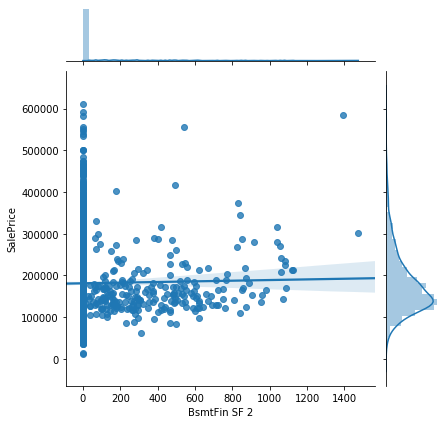

In [67]:
check_corr_func('BsmtFin SF 2','Continuous','Yes','')

## ANS:

For BsmtFin SF 2, there is 1 null entry. Confirmed on website that this null entry is actually a house with no Basement, hence no BsmtFin SF 2. It should be 0.

Correlation of 0.016 is weak.

Drop BsmtFin SF 2 as predictor.


In [68]:
df_initial_working_data[df_initial_working_data['BsmtFin SF 2'].isnull()]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1327  1342  903230120           20        RM          99.0      5940   Pave   

     Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  Fence  \
1327   NaN       IR1          Lvl  ...            0         0     NaN  MnPrv   

     Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
1327          NaN        0       4    2008      ConLD      79000  

[1 rows x 81 columns]

BsmtFin SF 2    1
SalePrice       0
dtype: int64
There are some entries with null values in 'BsmtFin SF 2'.


After null value processing, this is the new null count.

BsmtFin SF 2    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

0.0      1803
294.0       5
162.0       3
180.0       3
72.0        3
         ... 
288.0       1
286.0       1
284.0       1
201.0       1
228.0       1
Name: BsmtFin SF 2, Length: 206, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtFin SF 2  2051 non-null   object
 1   SalePrice     2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.0000

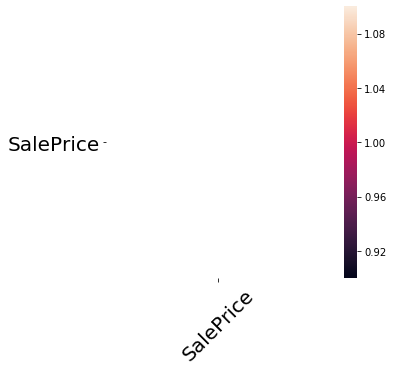

In [69]:
check_corr_func('BsmtFin SF 2','Continuous','No','')

## ANS:
See above markdown cell on BsmtFin SF 2 for EDA and treatment.

Bsmt Unf SF    1
SalePrice      0
dtype: int64
There are some entries with null values in 'Bsmt Unf SF'.


After null value processing, this is the new null count.

Bsmt Unf SF    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

0.0       165
384.0      14
672.0      11
728.0      10
816.0       9
         ... 
494.0       1
1323.0      1
1041.0      1
314.0       1
2062.0      1
Name: Bsmt Unf SF, Length: 967, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Bsmt Unf SF  2050 non-null   float64
 1   SalePrice    2050 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       Bsmt Unf SF      SalePrice
count  2050.000000    2050.000000
mean    567.728293  181519.686829
std     444.954786   79245.655820
min       0.000000   12789.000000
25%     220.000000  12

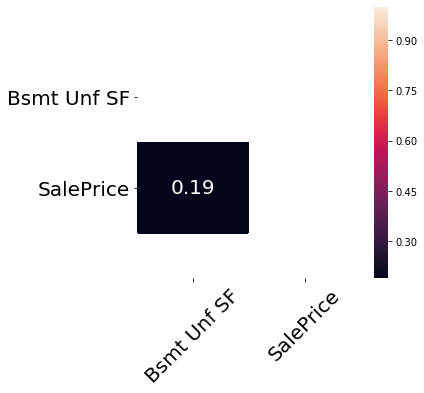

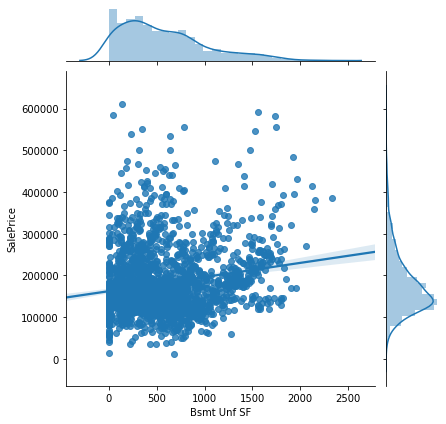

In [70]:
check_corr_func('Bsmt Unf SF','Continuous','Yes','')

## ANS:

For Bsmt Unf SF, there is 1 null entry. Confirmed on website that this null entry is actually a house with no Basement, hence no Bsmt Unf SF. It should be 0.

Correlation is 0.19 but visually, the spread of datapoints is very wide.

Drop Bsmt Unf SF as predictor.



In [71]:
df_initial_working_data[df_initial_working_data['Bsmt Unf SF'].isnull()]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1327  1342  903230120           20        RM          99.0      5940   Pave   

     Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  Fence  \
1327   NaN       IR1          Lvl  ...            0         0     NaN  MnPrv   

     Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
1327          NaN        0       4    2008      ConLD      79000  

[1 rows x 81 columns]

Bsmt Unf SF    1
SalePrice      0
dtype: int64
There are some entries with null values in 'Bsmt Unf SF'.


After null value processing, this is the new null count.

Bsmt Unf SF    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

0.0       165
384.0      14
672.0      11
728.0      10
816.0       9
         ... 
1020.0      1
494.0       1
495.0       1
1013.0      1
1969.0      1
Name: Bsmt Unf SF, Length: 968, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Bsmt Unf SF  2051 non-null   object
 1   SalePrice    2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.000000


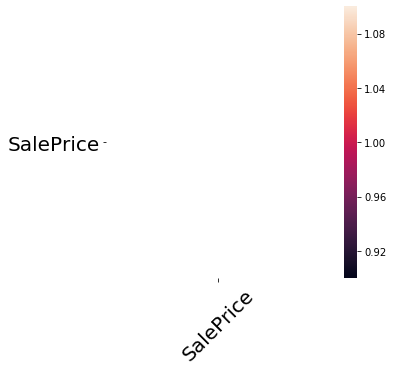

In [72]:
check_corr_func('Bsmt Unf SF','Continuous','No','')

## ANS:
See above markdown cell on Bsmt Unf SF 1 for EDA and treatment.

Total Bsmt SF    1
SalePrice        0
dtype: int64
There are some entries with null values in 'Total Bsmt SF'.


After null value processing, this is the new null count.

Total Bsmt SF    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

0.0       54
864.0     51
672.0     20
1040.0    20
816.0     17
          ..
842.0      1
752.0      1
1232.0     1
1480.0     1
1125.0     1
Name: Total Bsmt SF, Length: 892, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total Bsmt SF  2050 non-null   float64
 1   SalePrice      2050 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       Total Bsmt SF      SalePrice
count    2050.000000    2050.000000
mean     1057.987805  181519.686829
std       449.410704   79245.655820
min         0.000000   12789.000000
25%

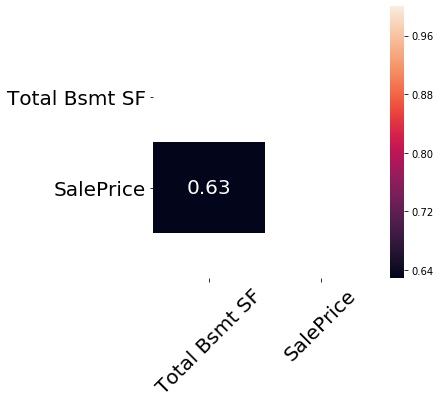

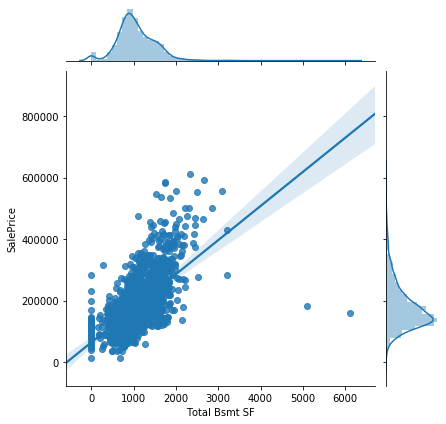

In [73]:
check_corr_func('Total Bsmt SF','Continuous','Yes','')

## ANS:

For Total Bsmt SF, there is 1 null entry. Confirmed on website that this null entry is actually a house with no Basement, hence no Total Bsmt SF. It should be 0.

Correlation is 0.63 and visually strong.

## Use Total Bsmt SF  as predictor.

In [74]:
df_initial_working_data[df_initial_working_data['Total Bsmt SF'].isnull()]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1327  1342  903230120           20        RM          99.0      5940   Pave   

     Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC  Fence  \
1327   NaN       IR1          Lvl  ...            0         0     NaN  MnPrv   

     Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
1327          NaN        0       4    2008      ConLD      79000  

[1 rows x 81 columns]

Total Bsmt SF    1
SalePrice        0
dtype: int64
There are some entries with null values in 'Total Bsmt SF'.


After null value processing, this is the new null count.

Total Bsmt SF    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

0.0       54
864.0     51
1040.0    20
672.0     20
816.0     17
          ..
1473.0     1
995.0      1
1460.0     1
998.0      1
6110.0     1
Name: Total Bsmt SF, Length: 893, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Total Bsmt SF  2051 non-null   object
 1   SalePrice      2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.00000

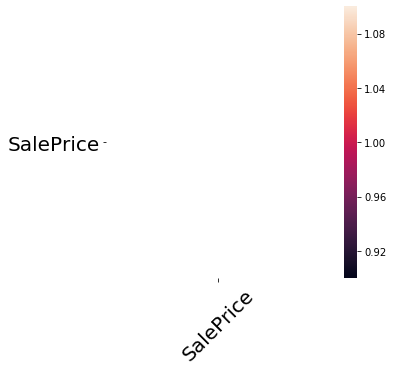

In [75]:
check_corr_func('Total Bsmt SF','Continuous','No','')

## ANS:
See above markdown cell on Total Bsmt SF for EDA and treatment.

Heating      0
SalePrice    0
dtype: int64
There are no entries with null values in 'Heating'.

These are the value_counts.

GasA    2018
GasW      20
Wall       6
Grav       5
OthW       2
Name: Heating, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Heating_GasA  2051 non-null   uint8
 1   Heating_GasW  2051 non-null   uint8
 2   Heating_Grav  2051 non-null   uint8
 3   Heating_OthW  2051 non-null   uint8
 4   Heating_Wall  2051 non-null   uint8
 5   SalePrice     2051 non-null   int64
dtypes: int64(1), uint8(5)
memory usage: 26.2 KB
None


       Heating_GasA  Heating_GasW  Heating_Grav  Heating_OthW  Heating_Wall  \
count   2051.000000   2051.000000   2051.000000   2051.000000   2051.000000   
mean       0.983910      0.009751      0.002438      0.000975      0.002925   
std        0.125851      0.098290      0.049326      

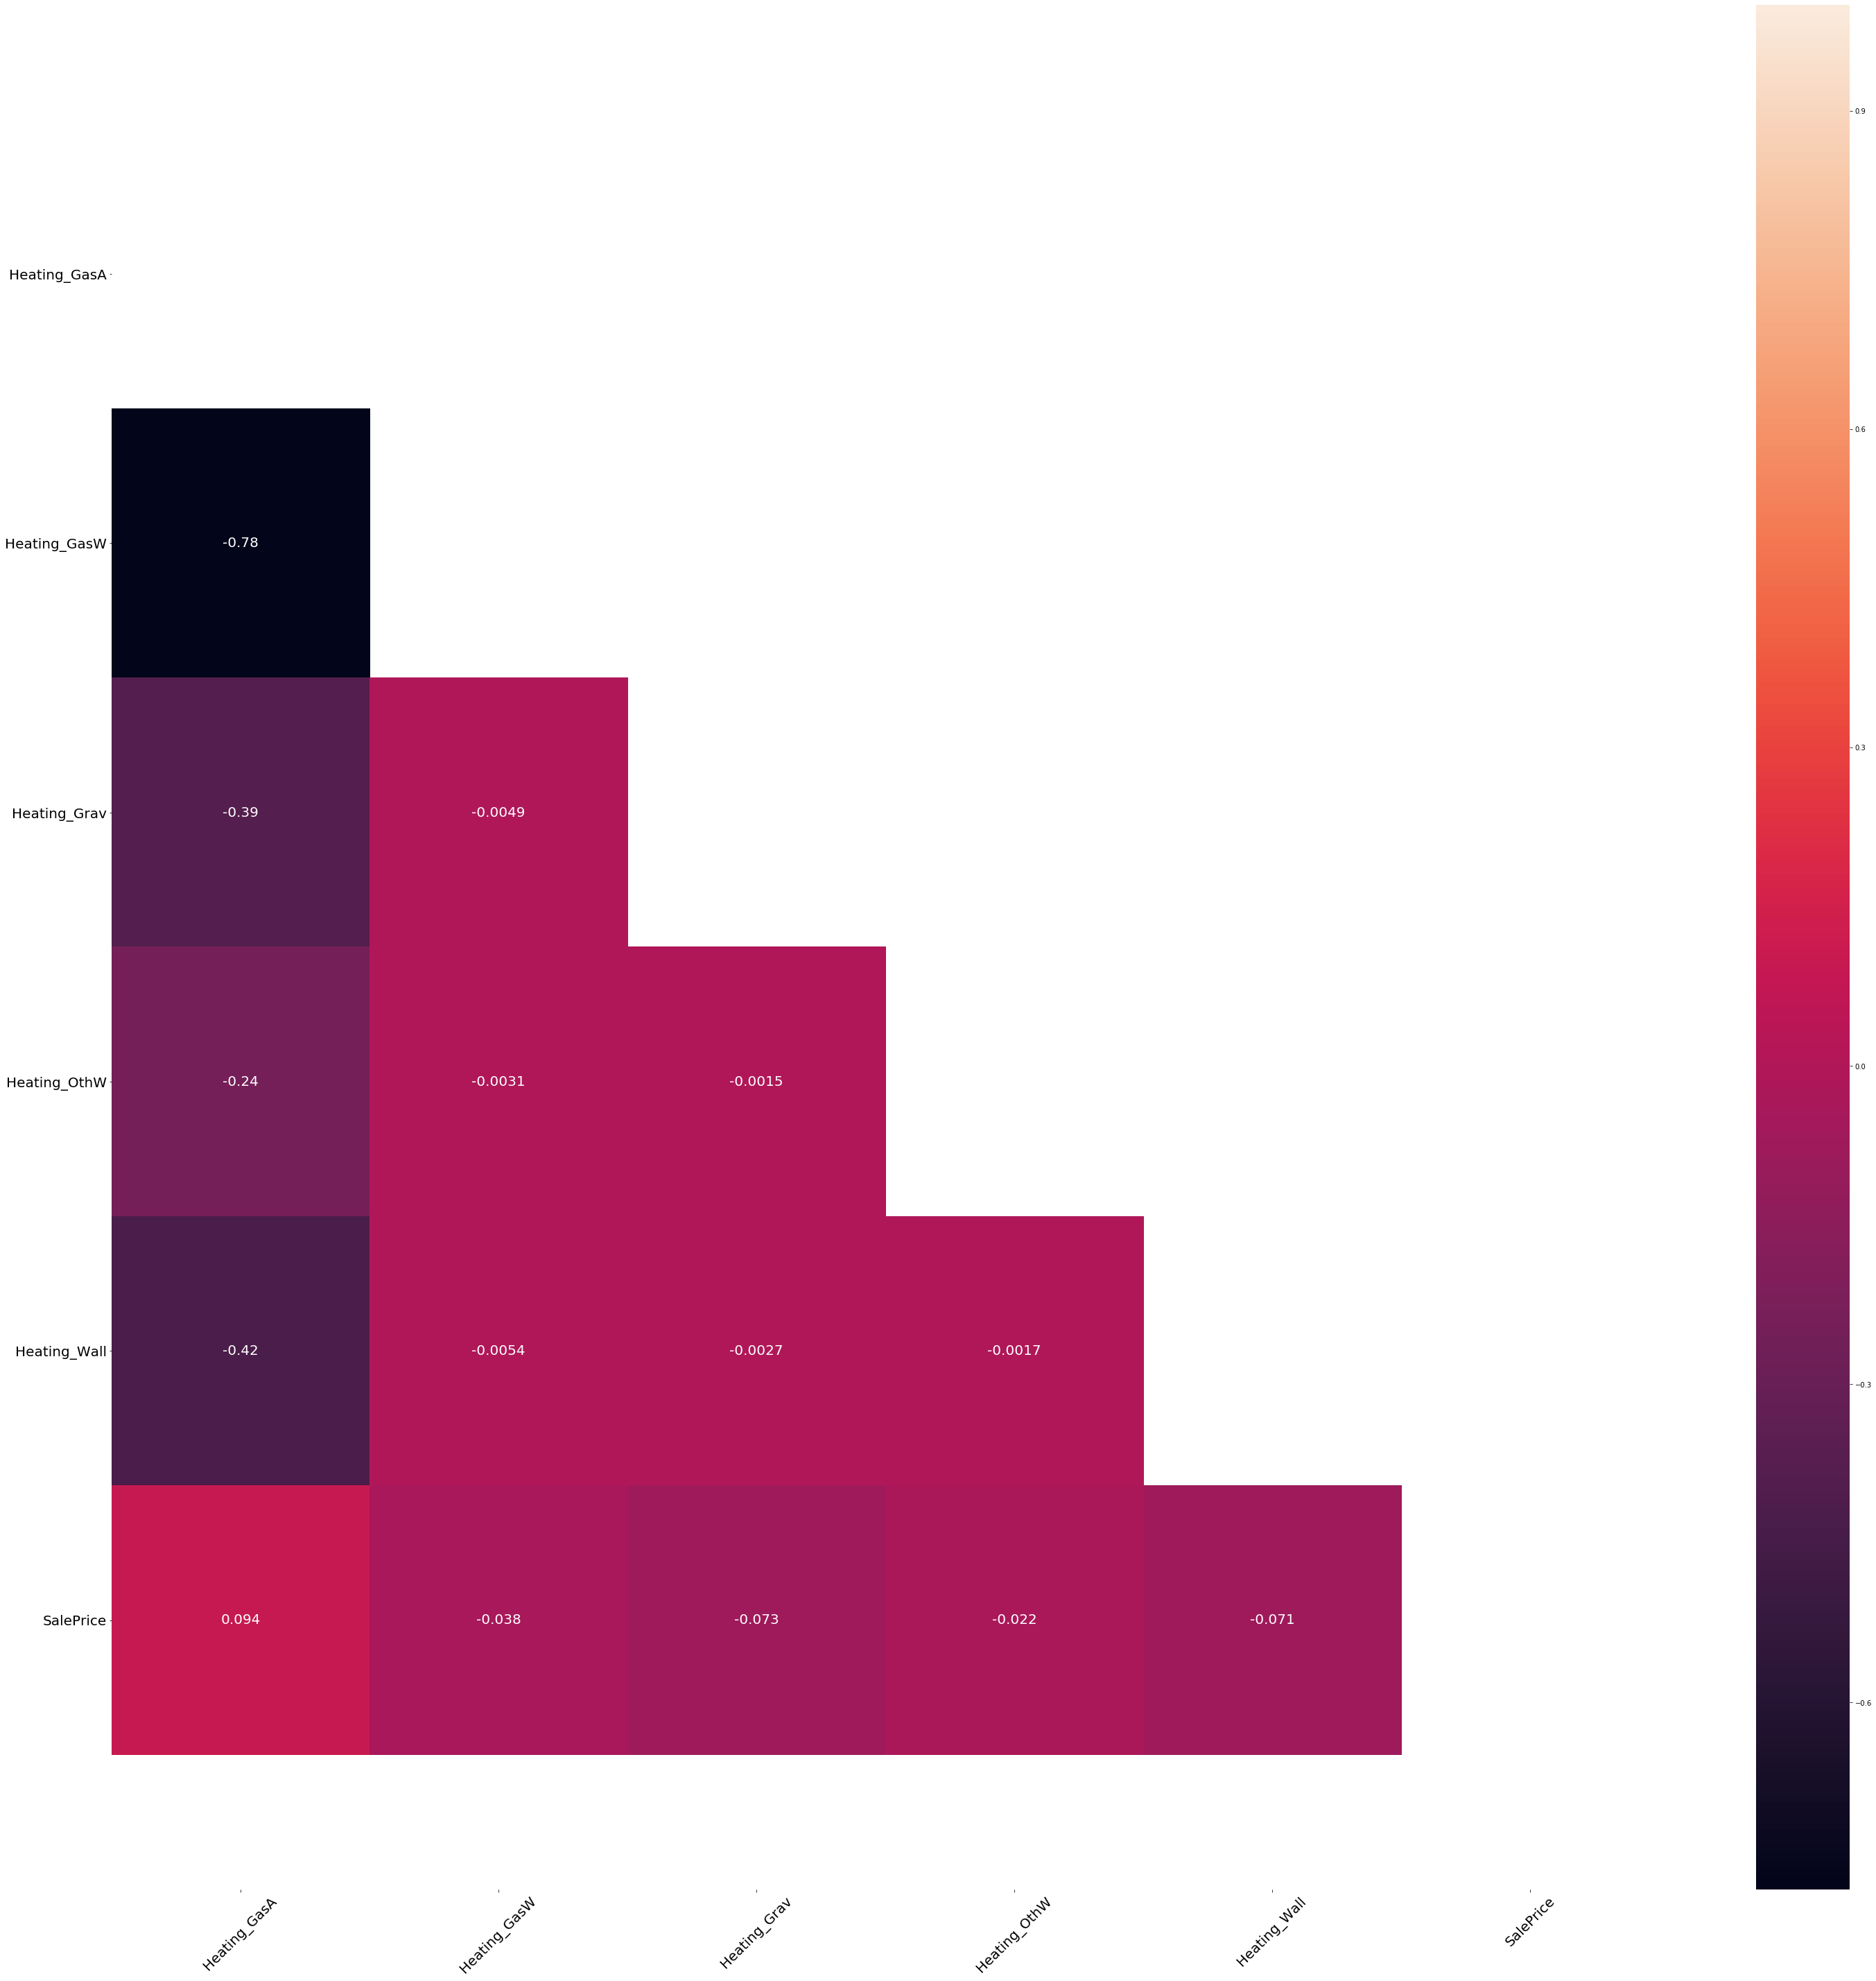

In [76]:
check_corr_func('Heating','Nominal','Yes','')

## ANS:

Heating has no null values.

Poor correlation, 2018/2051 is GasA.

Drop Heating as predictor.

Heating QC    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Heating QC'.

These are the value_counts.

Ex    1065
TA     597
Gd     319
Fa      67
Po       3
Name: Heating QC, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Heating QC': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

Ex    1065
TA     597
Gd     319
Fa      67
Po       3
Name: Heating QC, dtype: int64
5    1065
3     597
4     319
2      67
1       3
Name: Heating QC, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Heating QC  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Heating QC      SalePrice
count  2051.000000    2051.000000
mean      4.158459  181469.701609
std       0.

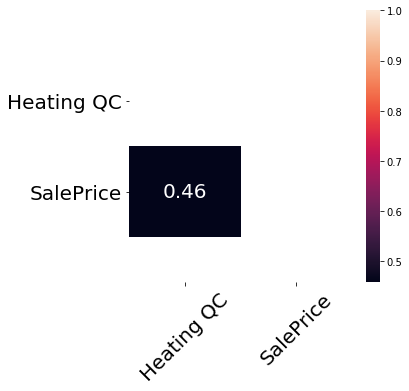

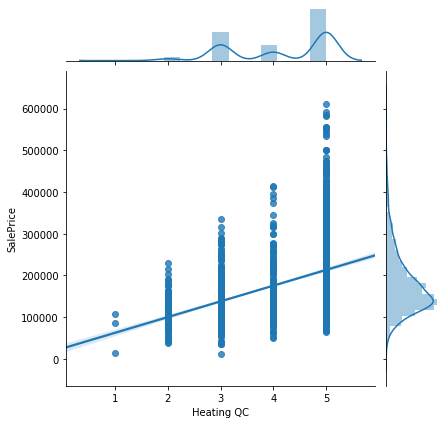

In [77]:
check_corr_func('Heating QC','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

Heating QC has no null values.

Seemingly good correlation of 0.46.

## Use Heating QC as Predictor.

Central Air    0
SalePrice      0
dtype: int64
There are no entries with null values in 'Central Air'.

These are the value_counts.

Y    1910
N     141
Name: Central Air, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Central Air_N  2051 non-null   uint8
 1   Central Air_Y  2051 non-null   uint8
 2   SalePrice      2051 non-null   int64
dtypes: int64(1), uint8(2)
memory usage: 20.2 KB
None


       Central Air_N  Central Air_Y      SalePrice
count    2051.000000    2051.000000    2051.000000
mean        0.068747       0.931253  181469.701609
std         0.253085       0.253085   79258.659352
min         0.000000       0.000000   12789.000000
25%         0.000000       1.000000  129825.000000
50%         0.000000       1.000000  162500.000000
75%         0.000000       1.000000  214000.000000
max         1.000000       1.0000

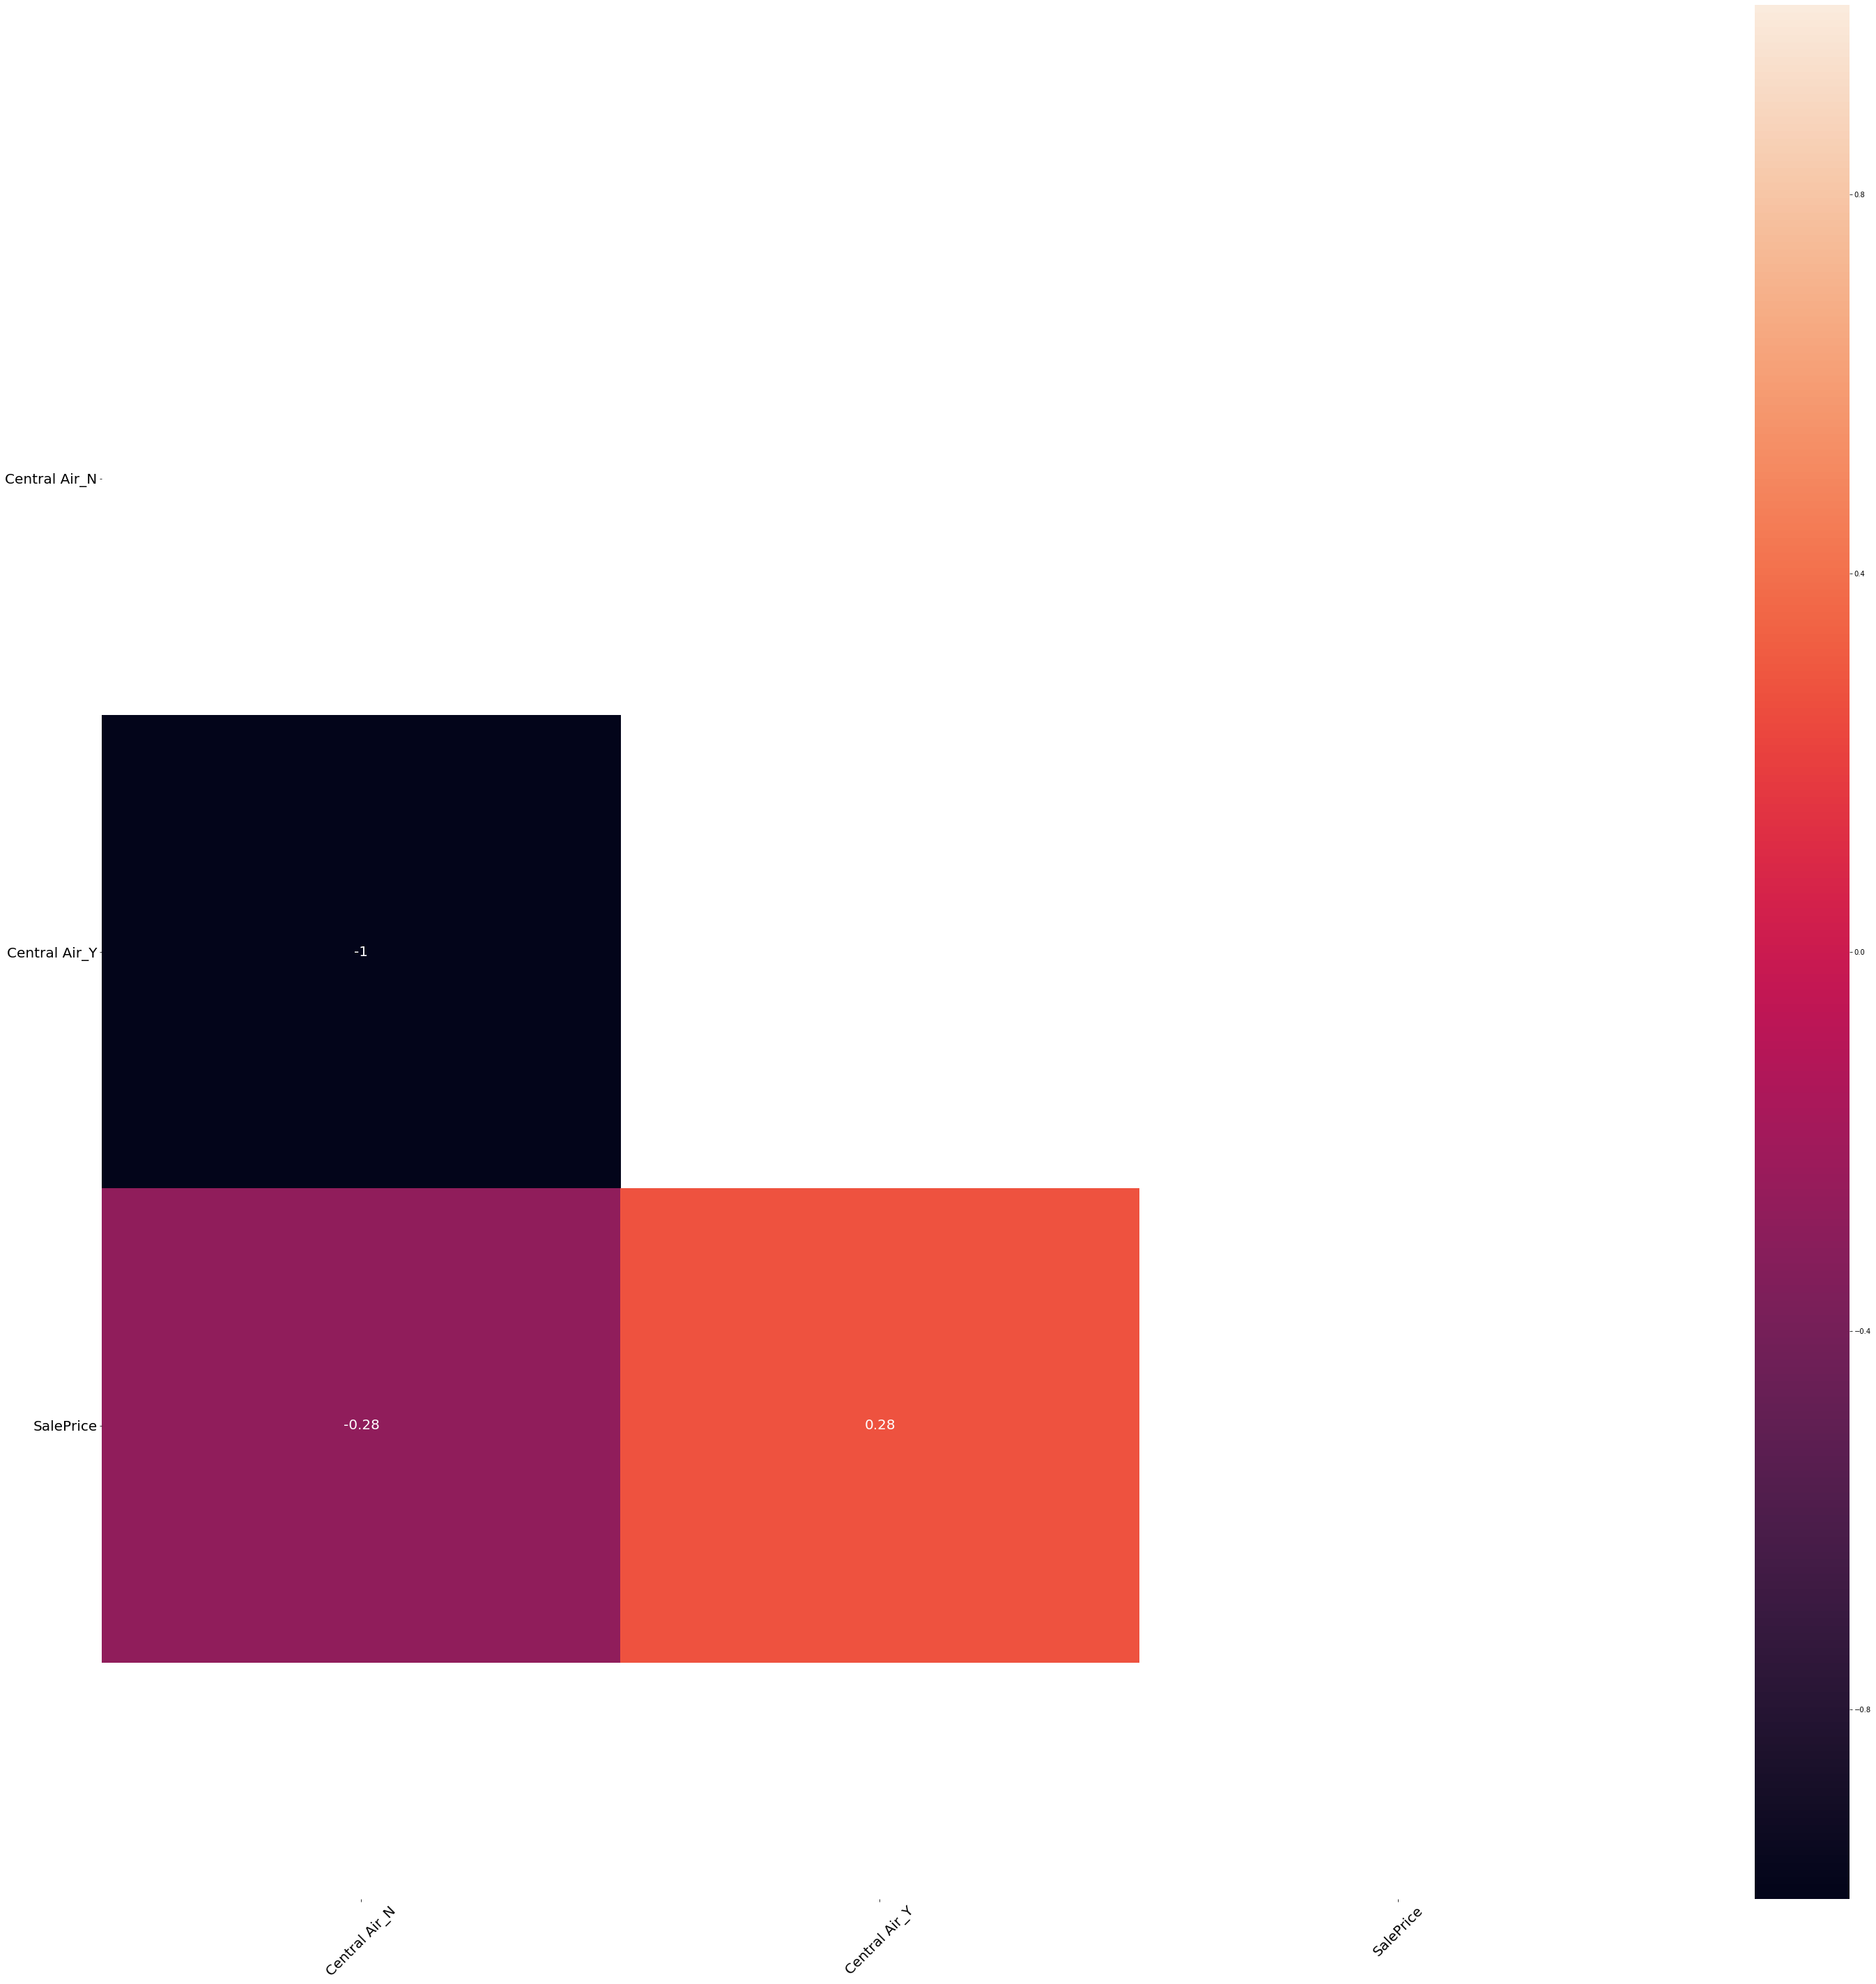

In [78]:
check_corr_func('Central Air','Nominal','Yes','')

## ANS:

Central Air has no null values.

Correlation of 0.28.

Meaningless as predictor, too many prices for just a toggle between the two options.

drop Central Air as predictor.

Electrical    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Electrical'.

These are the value_counts.

SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: Electrical, dtype: int64

Set of all possible values for column {'FuseF', 'Mix', 'SBrkr', 'FuseA', 'FuseP'}


List of all possible values for column, including 'Unknown' for 'Electrical': ['Unknown', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']

SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: Electrical, dtype: int64
5    1868
4     140
3      35
2       7
1       1
Name: Electrical, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Electrical  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Electrical      SalePrice
count  2051.000000    20

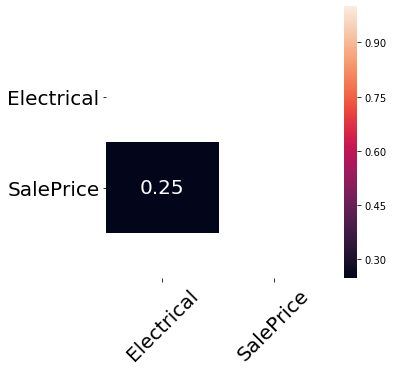

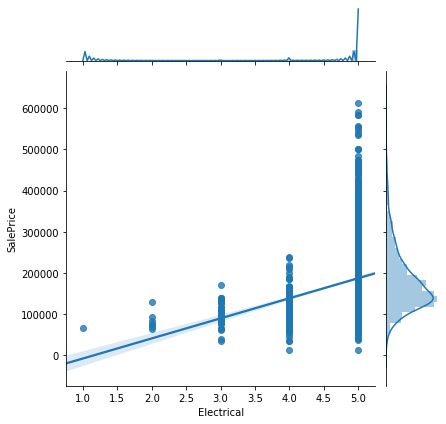

In [79]:
check_corr_func('Electrical','Ordinal','Yes','Unknown,Mix,FuseP,FuseF,FuseA,SBrkr')

# Note very high % in SBrkr which is more a nominal together with mixed,
# only the other 3 in this category are graded

## ANS:

Electrical has no null values.

Correlation of 0.25.

Meaningless as predictor, too many prices heavily tied to just Sbrkr, 1868/2051.

drop Electrical as predictor.

1st Flr SF    0
SalePrice     0
dtype: int64
There are no entries with null values in '1st Flr SF'.

These are the value_counts.

864     31
1040    22
816     13
912     13
960     12
        ..
2034     1
2032     1
2020     1
2014     1
2053     1
Name: 1st Flr SF, Length: 915, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   1st Flr SF  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        1st Flr SF      SalePrice
count  2051.000000    2051.000000
mean   1164.488055  181469.701609
std     396.446923   79258.659352
min     334.000000   12789.000000
25%     879.500000  129825.000000
50%    1093.000000  162500.000000
75%    1405.000000  214000.000000
max    5095.000000  611657.000000


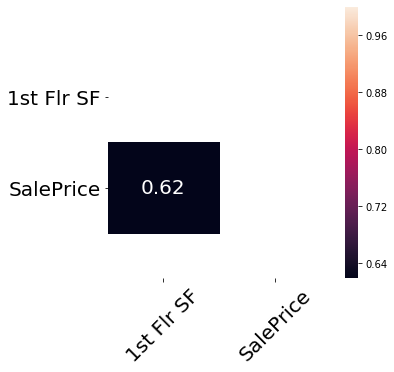

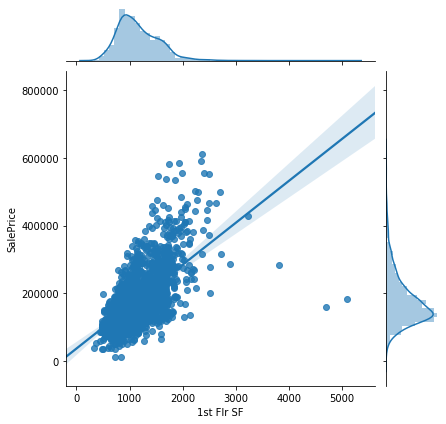

In [80]:
check_corr_func('1st Flr SF','Continuous','Yes','')

## ANS:

1st Flr SF has no null values.

Correlation of 0.62.

Visually normal distribution, very good candidate for predictor.

To combine 1st Flr SF with 2nd Flr SF as predictor.

2nd Flr SF    0
SalePrice     0
dtype: int64
There are no entries with null values in '2nd Flr SF'.

These are the value_counts.

0       1191
728       15
504       14
546       12
600       10
        ... 
371        1
423        1
425        1
439        1
1160       1
Name: 2nd Flr SF, Length: 504, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   2nd Flr SF  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        2nd Flr SF      SalePrice
count  2051.000000    2051.000000
mean    329.329108  181469.701609
std     425.671046   79258.659352
min       0.000000   12789.000000
25%       0.000000  129825.000000
50%       0.000000  162500.000000
75%     692.500000  214000.000000
max    1862.000000  611657.000000


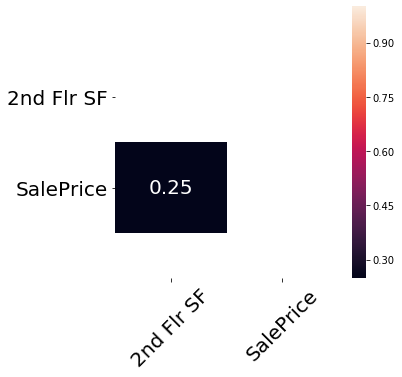

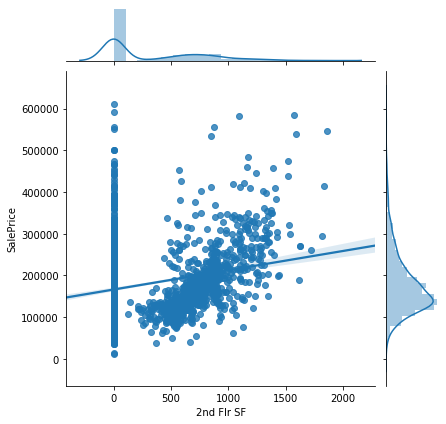

In [81]:
check_corr_func('2nd Flr SF','Continuous','Yes','')

## ANS:

2nd Flr SF has no null values.

Correlation of 0.25.

Best model fitting would be splitting off the zero entries and doing the model based on the remaining entries if time permits.

Alternative: did feature engineering by adding 1st Flr SF to 2nd Flr SF for Total Flr SF.



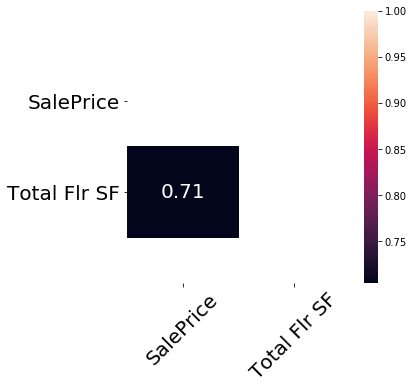

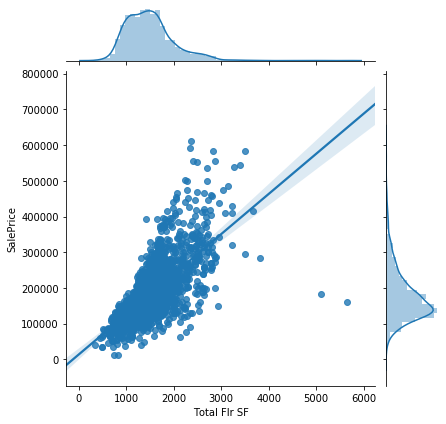

In [82]:

# Code to feature engineer 1st Flr SF and 2nd Flr SF into Total Flr SF

temp_df=pd.DataFrame.copy(df_initial_working_data)

temp_df['Total Flr SF']=df_initial_working_data['1st Flr SF']+df_initial_working_data['2nd Flr SF']

dfx=temp_df.filter(['SalePrice','Total Flr SF'])

# call custom_heatmap_func to display heatmap for SalePrice against Total Flr SF         
custom_heatmap_func (dfx, 5)

custom_jointplot_func (dfx, 'Total Flr SF', 5)


## ANS:

Total Flr SF has no null values.

Correlation is very good at 0.71, even better than 1st Flr SF.

Visually fairly normally distributed, strong predictor.

apply this feature engineering to holdout dataset as well.

## Use Total Flr SF as predictor.



Low Qual Fin SF    0
SalePrice          0
dtype: int64
There are no entries with null values in 'Low Qual Fin SF'.

These are the value_counts.

0       2018
80         3
205        2
436        1
108        1
114        1
120        1
140        1
144        1
156        1
234        1
312        1
360        1
362        1
384        1
390        1
697        1
515        1
512        1
514        1
528        1
572        1
1064       1
53         1
259        1
371        1
397        1
473        1
479        1
513        1
450        1
Name: Low Qual Fin SF, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Low Qual Fin SF  2051 non-null   int64
 1   SalePrice        2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Low Qual Fin SF      SalePrice
count      2051.000000    2051.000000
mean      

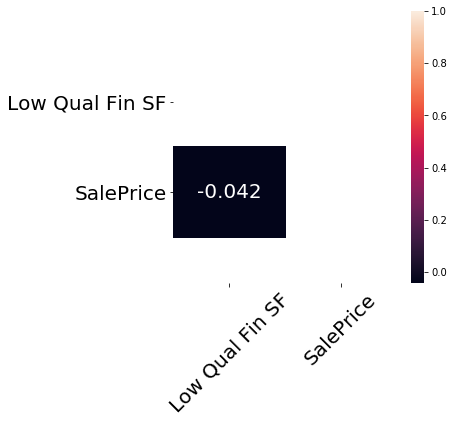

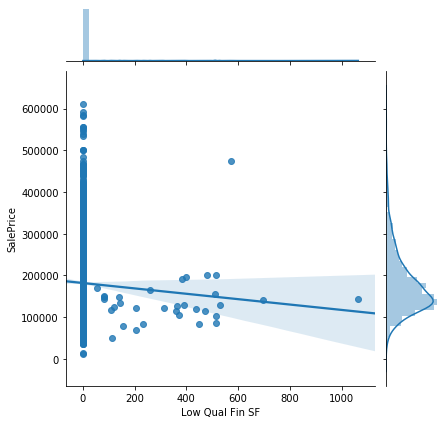

In [83]:
check_corr_func('Low Qual Fin SF','Continuous','Yes','')

## ANS:

Poor correlation for Low Qual Fin SF.

Distribution has most points at 0.

Drop Low Qual Fin SF as predictor.

Gr Liv Area    0
SalePrice      0
dtype: int64
There are no entries with null values in 'Gr Liv Area'.

These are the value_counts.

864     25
1040    20
1092    19
1200    16
1456    15
        ..
2362     1
2358     1
2350     1
2338     1
2049     1
Name: Gr Liv Area, Length: 1053, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Gr Liv Area  2051 non-null   int64
 1   SalePrice    2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Gr Liv Area      SalePrice
count  2051.000000    2051.000000
mean   1499.330083  181469.701609
std     500.447829   79258.659352
min     334.000000   12789.000000
25%    1129.000000  129825.000000
50%    1444.000000  162500.000000
75%    1728.500000  214000.000000
max    5642.000000  611657.000000


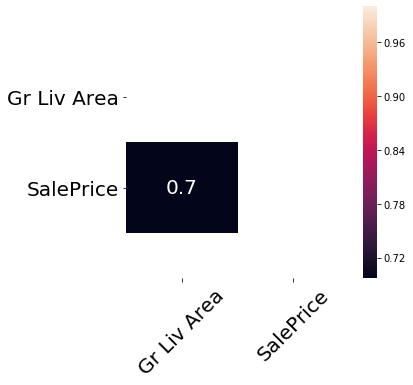

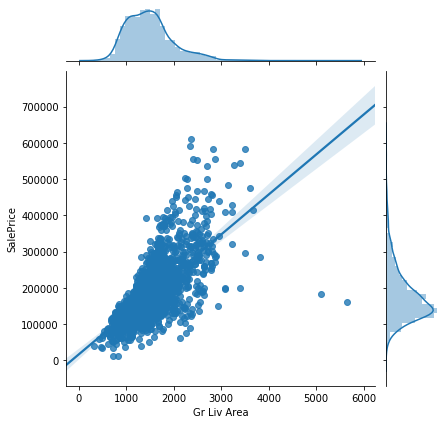

In [84]:
check_corr_func('Gr Liv Area','Continuous','Yes','')

## ANS:

Gr Liv Area has no null values.

Correlation is very good at 0.7.

Visually fairly normally distributed, strong predictor.

apply this feature engineering to holdout dataset as well.

## Use Gr Liv Area as predictor.



Bsmt Full Bath    2
SalePrice         0
dtype: int64
There are some entries with null values in 'Bsmt Full Bath'.


After null value processing, this is the new null count.

Bsmt Full Bath    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

0.0    1200
1.0     824
2.0      23
3.0       2
Name: Bsmt Full Bath, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bsmt Full Bath  2049 non-null   float64
 1   SalePrice       2049 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       Bsmt Full Bath      SalePrice
count     2049.000000    2049.000000
mean         0.427526  181469.330405
std          0.522673   79232.186928
min          0.000000   12789.000000
25%          0.000000  129850.000000
50%          0.000000  162500.000000
75%          1.000000 

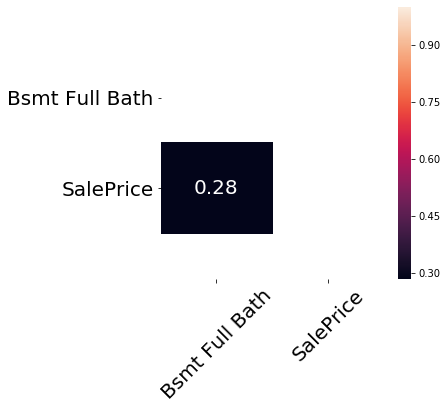

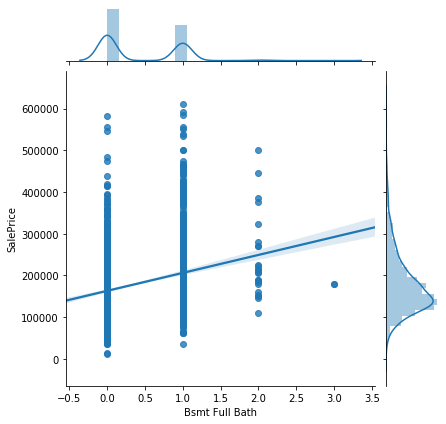

In [85]:
check_corr_func('Bsmt Full Bath','Discrete','Yes','')

Bsmt Full Bath    2
SalePrice         0
dtype: int64
There are some entries with null values in 'Bsmt Full Bath'.


After null value processing, this is the new null count.

Bsmt Full Bath    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

0.0        1200
1.0         824
2.0          23
Unknown       2
3.0           2
Name: Bsmt Full Bath, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Bsmt Full Bath  2051 non-null   object
 1   SalePrice       2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.000000


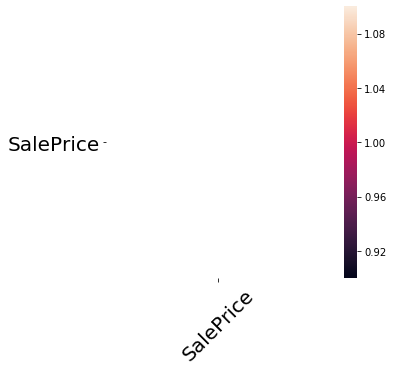

In [86]:
check_corr_func('Bsmt Full Bath','Discrete','No','')

Bsmt Half Bath    2
SalePrice         0
dtype: int64
There are some entries with null values in 'Bsmt Half Bath'.


After null value processing, this is the new null count.

Bsmt Half Bath    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

0.0    1923
1.0     122
2.0       4
Name: Bsmt Half Bath, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bsmt Half Bath  2049 non-null   float64
 1   SalePrice       2049 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       Bsmt Half Bath      SalePrice
count     2049.000000    2049.000000
mean         0.063446  181469.330405
std          0.251705   79232.186928
min          0.000000   12789.000000
25%          0.000000  129850.000000
50%          0.000000  162500.000000
75%          0.000000  214000.0000

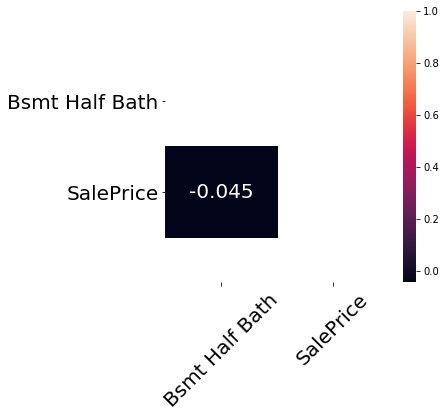

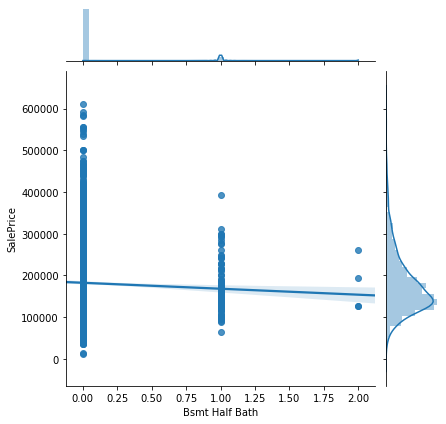

In [87]:
check_corr_func('Bsmt Half Bath','Discrete','Yes','')

Bsmt Half Bath    2
SalePrice         0
dtype: int64
There are some entries with null values in 'Bsmt Half Bath'.


After null value processing, this is the new null count.

Bsmt Half Bath    0
SalePrice         0
dtype: int64

After null value processing, these are the new value_counts.

0.0        1923
1.0         122
2.0           4
Unknown       2
Name: Bsmt Half Bath, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Bsmt Half Bath  2051 non-null   object
 1   SalePrice       2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.000000


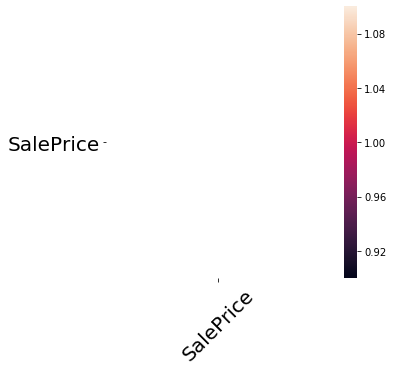

In [88]:
check_corr_func('Bsmt Half Bath','Discrete','No','')

Full Bath    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Full Bath'.

These are the value_counts.

2    1096
1     900
3      45
0       8
4       2
Name: Full Bath, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Full Bath  2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


         Full Bath      SalePrice
count  2051.000000    2051.000000
mean      1.577279  181469.701609
std       0.549279   79258.659352
min       0.000000   12789.000000
25%       1.000000  129825.000000
50%       2.000000  162500.000000
75%       2.000000  214000.000000
max       4.000000  611657.000000


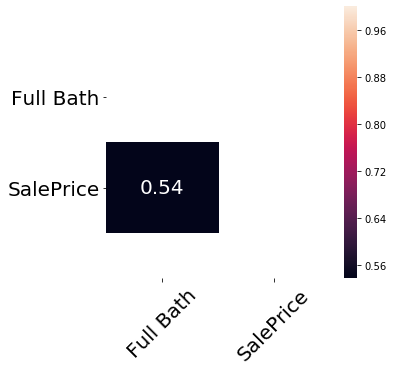

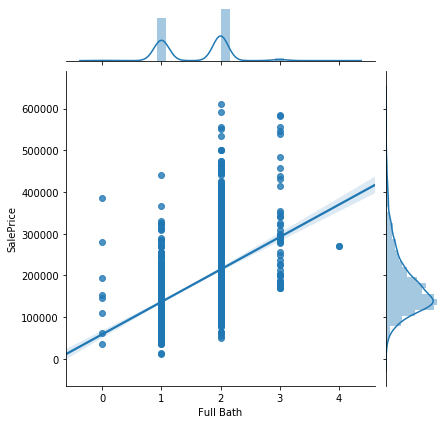

In [89]:
check_corr_func('Full Bath','Discrete','Yes','')

Half Bath    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Half Bath'.

These are the value_counts.

0    1308
1     725
2      18
Name: Half Bath, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Half Bath  2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


         Half Bath      SalePrice
count  2051.000000    2051.000000
mean      0.371039  181469.701609
std       0.501043   79258.659352
min       0.000000   12789.000000
25%       0.000000  129825.000000
50%       0.000000  162500.000000
75%       1.000000  214000.000000
max       2.000000  611657.000000


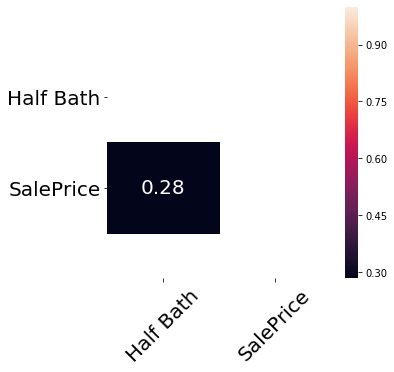

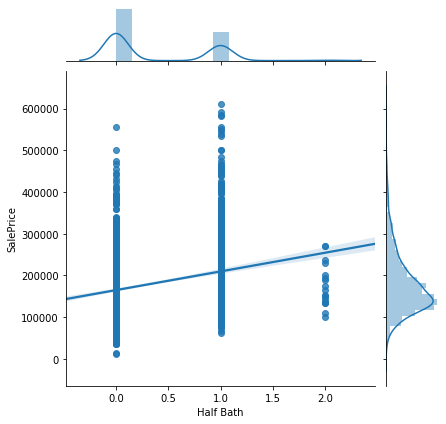

In [90]:
check_corr_func('Half Bath','Discrete','Yes','')

Bedroom AbvGr    0
SalePrice        0
dtype: int64
There are no entries with null values in 'Bedroom AbvGr'.

These are the value_counts.

3    1108
2     544
4     265
1      75
5      41
6      12
0       5
8       1
Name: Bedroom AbvGr, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Bedroom AbvGr  2051 non-null   int64
 1   SalePrice      2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Bedroom AbvGr      SalePrice
count    2051.000000    2051.000000
mean        2.843491  181469.701609
std         0.826618   79258.659352
min         0.000000   12789.000000
25%         2.000000  129825.000000
50%         3.000000  162500.000000
75%         3.000000  214000.000000
max         8.000000  611657.000000


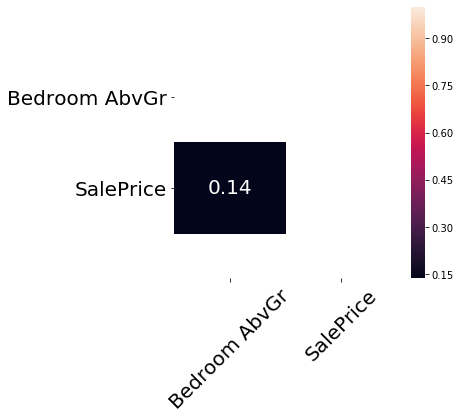

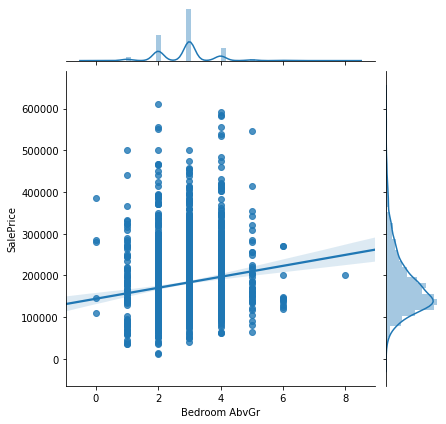

In [91]:
check_corr_func('Bedroom AbvGr','Discrete','Yes','')

Kitchen AbvGr    0
SalePrice        0
dtype: int64
There are no entries with null values in 'Kitchen AbvGr'.

These are the value_counts.

1    1960
2      88
0       2
3       1
Name: Kitchen AbvGr, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Kitchen AbvGr  2051 non-null   int64
 1   SalePrice      2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Kitchen AbvGr      SalePrice
count    2051.000000    2051.000000
mean        1.042906  181469.701609
std         0.209790   79258.659352
min         0.000000   12789.000000
25%         1.000000  129825.000000
50%         1.000000  162500.000000
75%         1.000000  214000.000000
max         3.000000  611657.000000


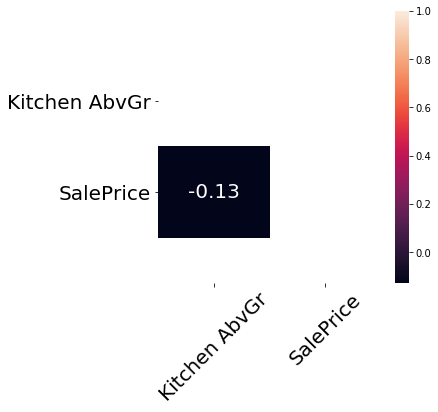

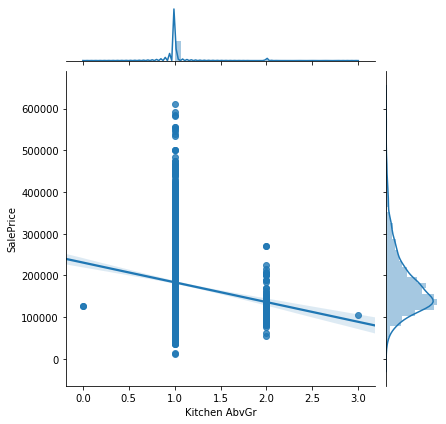

In [92]:
check_corr_func('Kitchen AbvGr','Discrete','Yes','')

Kitchen Qual    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Kitchen Qual'.

These are the value_counts.

TA    1047
Gd     806
Ex     151
Fa      47
Name: Kitchen Qual, dtype: int64

Set of all possible values for column {'Fa', 'Ex', 'Gd', 'TA'}


List of all possible values for column, including 'Unknown' for 'Kitchen Qual': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    1047
Gd     806
Ex     151
Fa      47
Name: Kitchen Qual, dtype: int64
3    1047
4     806
5     151
2      47
Name: Kitchen Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Kitchen Qual  2051 non-null   int64
 1   SalePrice     2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Kitchen Qual      SalePrice
count   2051.000000    2051.000000
mean       3.517309  181469.701609
std        0.665577   792

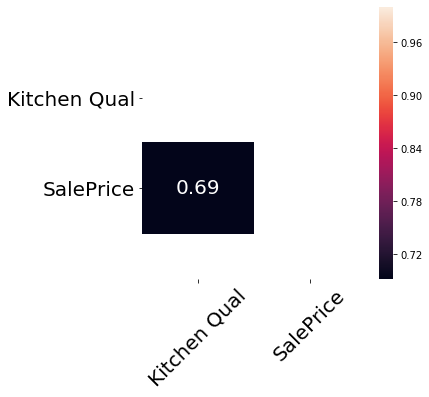

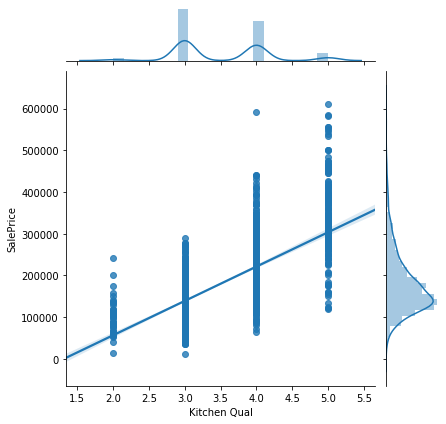

In [93]:
check_corr_func('Kitchen Qual','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

## ANS:

Kitchen Qual has no null values.
Good distribution, good correlation of 0.69.

## Use Kitchen Qual as Predictor.

TotRms AbvGrd    0
SalePrice        0
dtype: int64
There are no entries with null values in 'TotRms AbvGrd'.

These are the value_counts.

6     597
7     475
5     407
8     228
4     146
9      98
10     49
11     22
12     13
3      12
15      1
13      1
14      1
2       1
Name: TotRms AbvGrd, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   TotRms AbvGrd  2051 non-null   int64
 1   SalePrice      2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       TotRms AbvGrd      SalePrice
count    2051.000000    2051.000000
mean        6.435885  181469.701609
std         1.560225   79258.659352
min         2.000000   12789.000000
25%         5.000000  129825.000000
50%         6.000000  162500.000000
75%         7.000000  214000.000000
max        15.000000  611657.000000


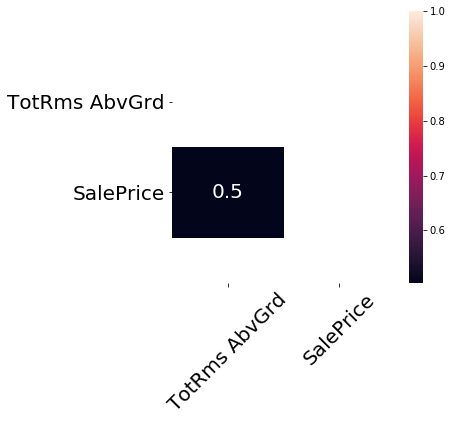

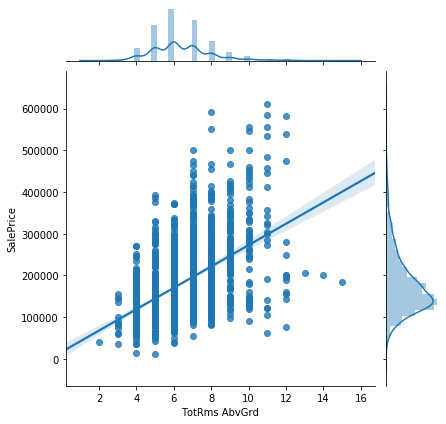

In [94]:
check_corr_func('TotRms AbvGrd','Discrete','Yes','')

## ANS:

TotRms AbvGrd has no null values.
Good distribution, good correlation of 0.5.

## Use TotRms AbvGrd as Predictor.

Functional    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Functional'.

These are the value_counts.

Typ     1915
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sev        2
Sal        2
Name: Functional, dtype: int64

Set of all possible values for column {'Typ', 'Sal', 'Maj1', 'Min2', 'Sev', 'Mod', 'Maj2', 'Min1'}


List of all possible values for column, including 'Unknown' for 'Functional': ['Unknown', 'Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']

Typ     1915
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sev        2
Sal        2
Name: Functional, dtype: int64
8    1915
7      42
6      42
5      29
4      12
3       7
1       2
2       2
Name: Functional, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Functional  2051 non-null   int64
 1   SalePr

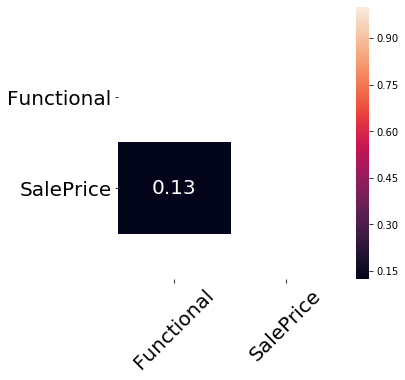

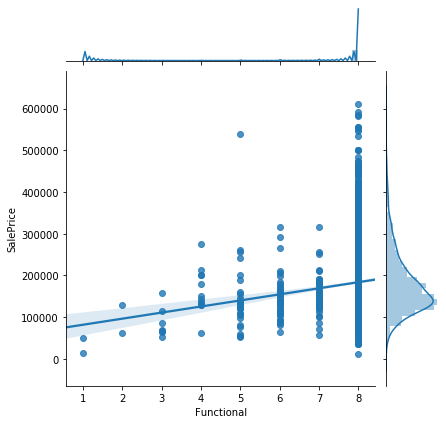

In [95]:
check_corr_func('Functional','Ordinal','Yes','Unknown,Sal,Sev,Maj2,Maj1,Mod,Min2,Min1,Typ')

Fireplaces    0
SalePrice     0
dtype: int64
There are no entries with null values in 'Fireplaces'.

These are the value_counts.

0    1000
1     898
2     146
3       6
4       1
Name: Fireplaces, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Fireplaces  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        Fireplaces      SalePrice
count  2051.000000    2051.000000
mean      0.590931  181469.701609
std       0.638516   79258.659352
min       0.000000   12789.000000
25%       0.000000  129825.000000
50%       1.000000  162500.000000
75%       1.000000  214000.000000
max       4.000000  611657.000000


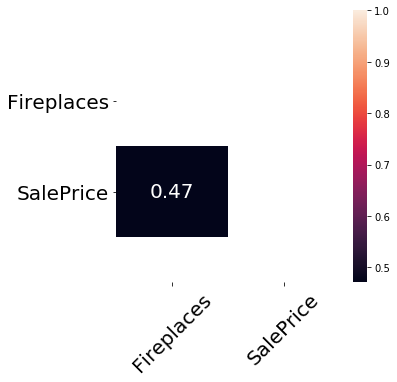

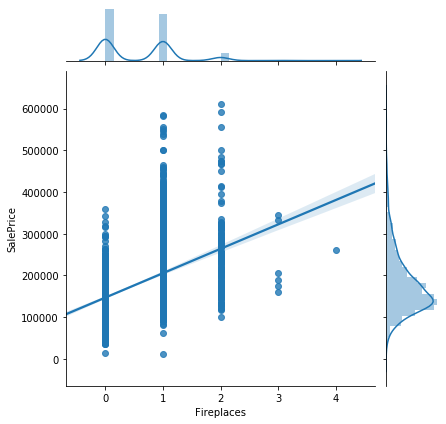

In [96]:
check_corr_func('Fireplaces','Discrete','Yes','')

## ANS:

Not using Fireplace as predictor, with majority of values being 0 and 1, it seems more like these are the default numbers of fireplaces in houses rather than any real pattern despite correlation of 0.5.

Fireplace Qu    1000
SalePrice          0
dtype: int64
There are some entries with null values in 'Fireplace Qu'.


After null value processing, this is the new null count.

Fireplace Qu    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

Gd    523
TA    407
Fa     59
Po     31
Ex     31
Name: Fireplace Qu, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Fireplace Qu': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

Gd    523
TA    407
Fa     59
Po     31
Ex     31
Name: Fireplace Qu, dtype: int64
4    523
3    407
2     59
5     31
1     31
Name: Fireplace Qu, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 1 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fireplace Qu  1051 non-null   int64
 1   SalePrice     1051 non-null   int64
dty

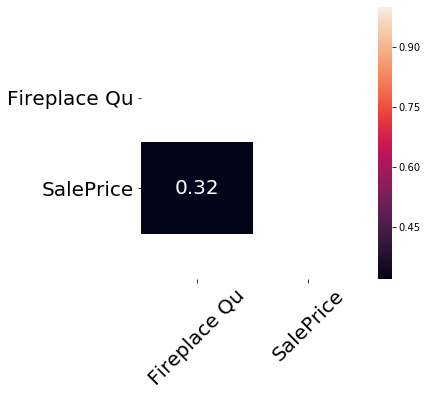

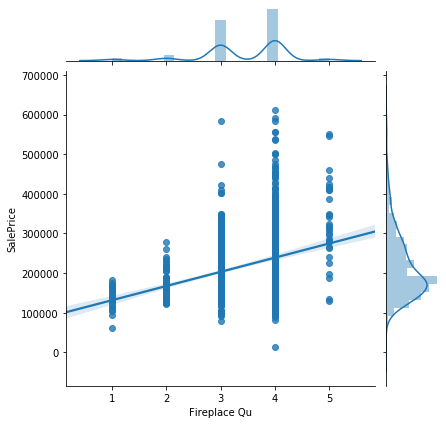

In [97]:
check_corr_func('Fireplace Qu','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

Fireplace Qu    1000
SalePrice          0
dtype: int64
There are some entries with null values in 'Fireplace Qu'.


After null value processing, this is the new null count.

Fireplace Qu    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    1000
Gd          523
TA          407
Fa           59
Ex           31
Po           31
Name: Fireplace Qu, dtype: int64

Set of all possible values for column {'Unknown', 'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Fireplace Qu': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

Unknown    1000
Gd          523
TA          407
Fa           59
Ex           31
Po           31
Name: Fireplace Qu, dtype: int64
0    1000
4     523
3     407
2      59
5      31
1      31
Name: Fireplace Qu, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ---

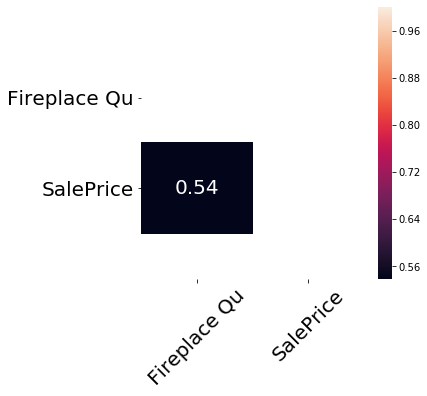

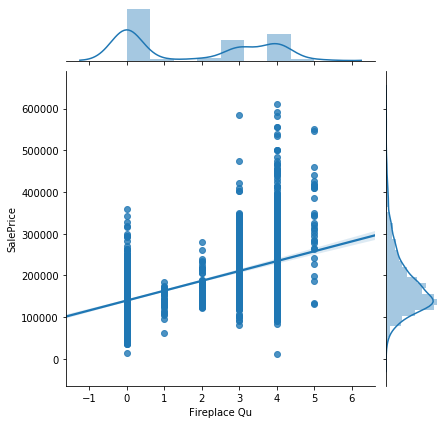

In [98]:
check_corr_func('Fireplace Qu','Ordinal','No','Unknown,Po,Fa,TA,Gd,Ex')

Garage Type    113
SalePrice        0
dtype: int64
There are some entries with null values in 'Garage Type'.


After null value processing, this is the new null count.

Garage Type    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Garage Type_2Types   1938 non-null   float64
 1   Garage Type_Attchd   1938 non-null   float64
 2   Garage Type_Basment  1938 non-null   float64
 3   Garage Type_BuiltIn  1938 non-null   float64
 4   Garage Type_CarPort  1938 non-null   float64
 5   Garage Type_Detchd   1938 non-null   float64
 6   SalePrice            2051 non-null   int64  
dtypes: float64(6), int64(1)
memory

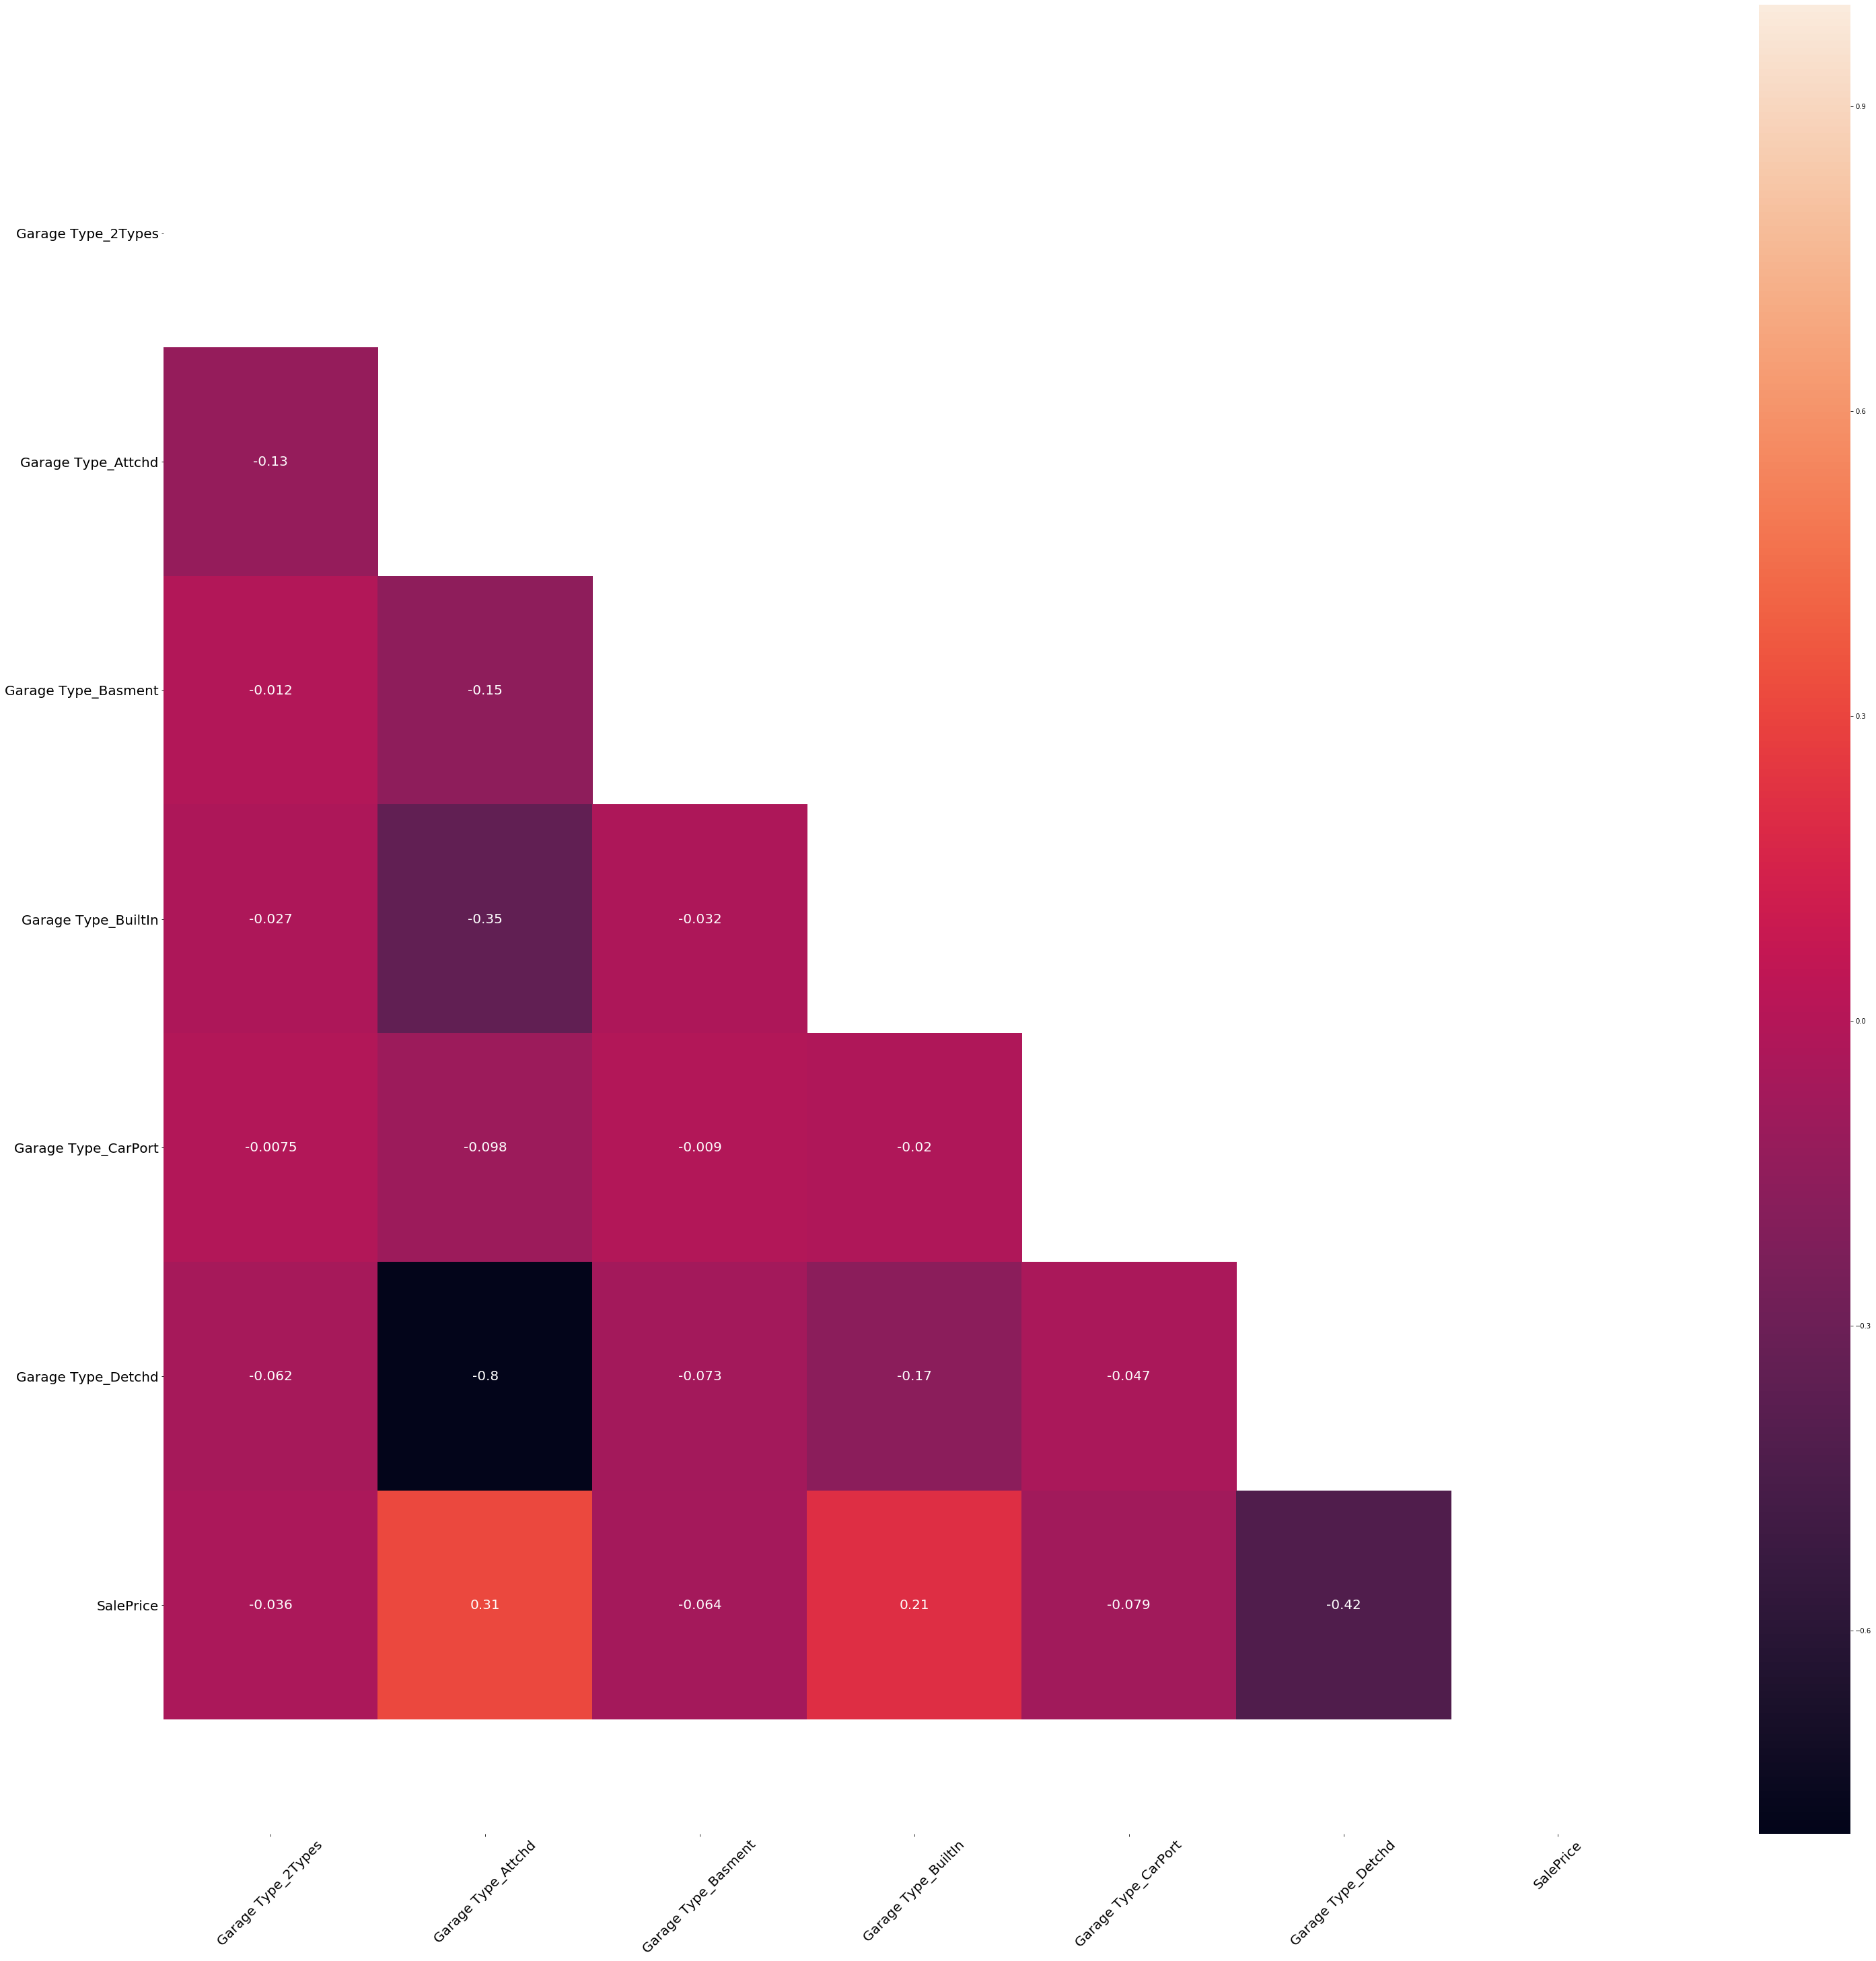

In [99]:
check_corr_func('Garage Type','Nominal','Yes','')

## ANS:

## Due to high numbers and correlation of Detchd and Attchd, take these 2 Garage Types as predictors, the correlation seems logical too.


Garage Types has 113 null values indicating no garage. This will be viewed as a negative point, so will impute in Detchd for the NaN or no garage values.


Garage Type    113
SalePrice        0
dtype: int64
There are some entries with null values in 'Garage Type'.


After null value processing, this is the new null count.

Garage Type    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

Attchd     1213
Detchd      536
BuiltIn     132
Unknown     113
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Garage Type_2Types   2051 non-null   uint8
 1   Garage Type_Attchd   2051 non-null   uint8
 2   Garage Type_Basment  2051 non-null   uint8
 3   Garage Type_BuiltIn  2051 non-null   uint8
 4   Garage Type_CarPort  2051 non-null   uint8
 5   Garage Type_Detchd   2051 non-null   uint8
 6   Garage Type_Unknown  2051 non-null   uint8
 7   SalePrice            2051 non-nu

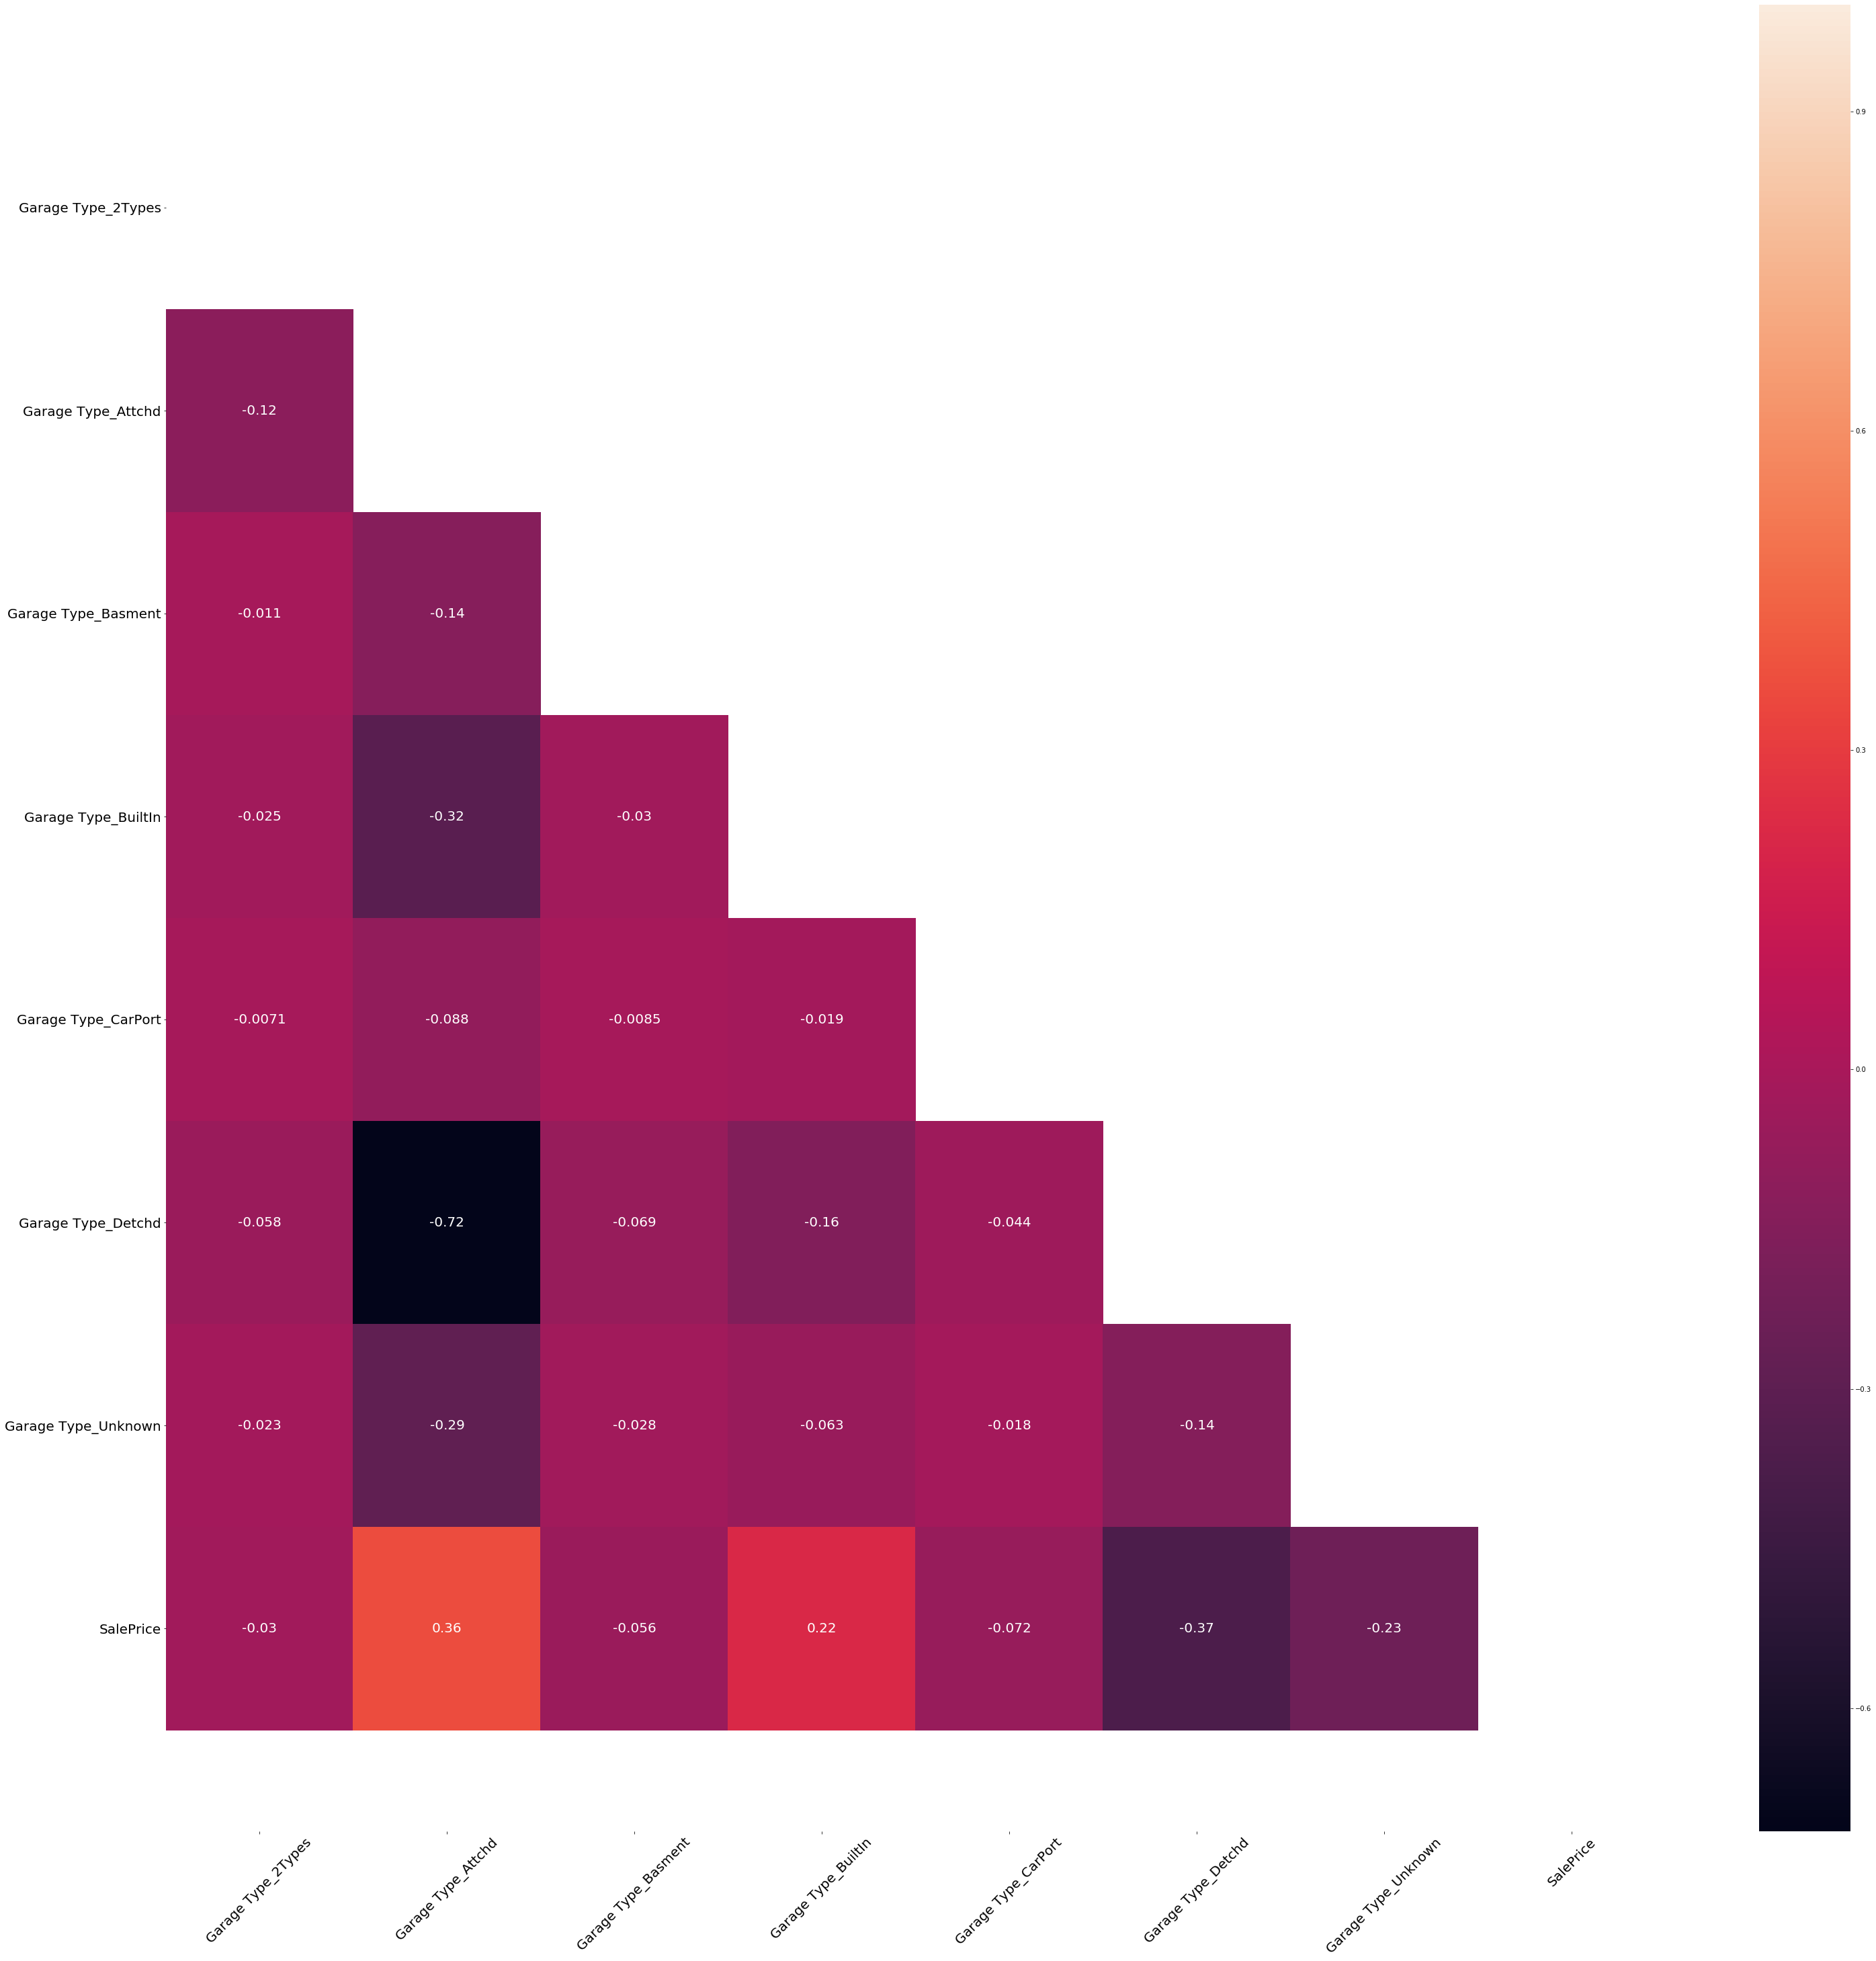

In [100]:
check_corr_func('Garage Type','Nominal','No','')

Garage Yr Blt    114
SalePrice          0
dtype: int64
There are some entries with null values in 'Garage Yr Blt'.


After null value processing, this is the new null count.

Garage Yr Blt    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

2005.0    105
2007.0     85
2006.0     80
2004.0     72
2003.0     66
         ... 
1918.0      1
1919.0      1
1895.0      1
1896.0      1
1933.0      1
Name: Garage Yr Blt, Length: 99, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Garage Yr Blt  1937 non-null   float64
 1   SalePrice      1937 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 45.4 KB
None


       Garage Yr Blt      SalePrice
count    1937.000000    1937.000000
mean     1978.604543  185907.503872
std        24.914493   78933.966189
min      1895.000000   12

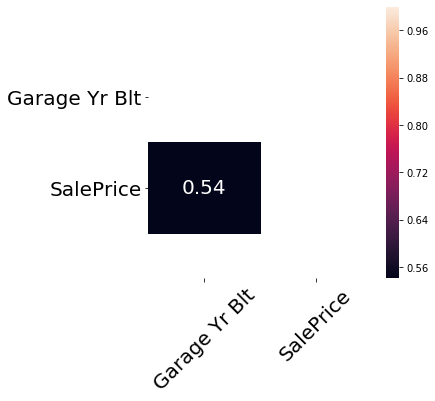

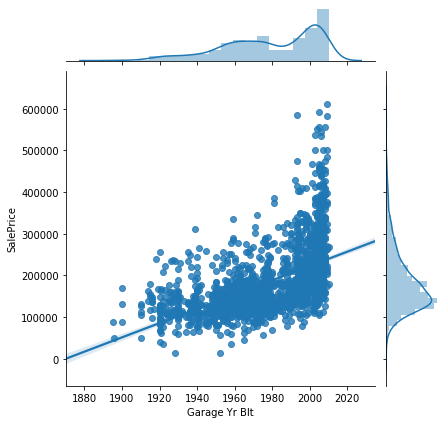

In [101]:
check_corr_func('Garage Yr Blt','Discrete','Yes','')

## ANS:

From web sourced data, garage yr blt is actually 2007 instead of 2207, for house Id 2261. Data was amended to change this typo.

function then called again.

Correlation is decent at 0.54. However, I do not consider garage yr blt as important as year built, when garage blt's correlation with SalePrice is as a tag along to year built.

114 null values.

##  Use Garage Yr Blt as predictor. impute all NaN values with the Year Blt.

In [102]:
df_initial_working_data[df_initial_working_data['Garage Yr Blt']>2150].filter(['Id','PID','Garage Yr Blt','SalePrice'])

Empty DataFrame
Columns: [Id, PID, Garage Yr Blt, SalePrice]
Index: []

Garage Yr Blt    114
SalePrice          0
dtype: int64
There are some entries with null values in 'Garage Yr Blt'.


After null value processing, this is the new null count.

Garage Yr Blt    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    114
2005.0     105
2007.0      85
2006.0      80
2004.0      72
          ... 
1918.0       1
1919.0       1
1933.0       1
1896.0       1
1895.0       1
Name: Garage Yr Blt, Length: 100, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Garage Yr Blt  2051 non-null   object
 1   SalePrice      2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.

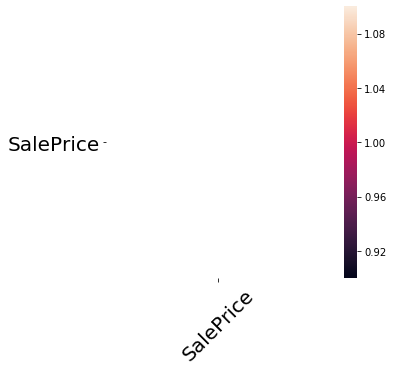

In [103]:
check_corr_func('Garage Yr Blt','Discrete','No','')

Garage Finish    114
SalePrice          0
dtype: int64
There are some entries with null values in 'Garage Finish'.


After null value processing, this is the new null count.

Garage Finish    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

Unf    849
RFn    579
Fin    509
Name: Garage Finish, dtype: int64

Set of all possible values for column {'Fin', 'RFn', 'Unf'}


List of all possible values for column, including 'Unknown' for 'Garage Finish': ['Unknown', 'Unf', 'RFn', 'Fin']

Unf    849
RFn    579
Fin    509
Name: Garage Finish, dtype: int64
1    849
2    579
3    509
Name: Garage Finish, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Garage Finish  1937 non-null   int64
 1   SalePrice      1937 non-null   int64
dtypes: int64(2)
memory usage: 45.4 KB
None


       Garage Fi

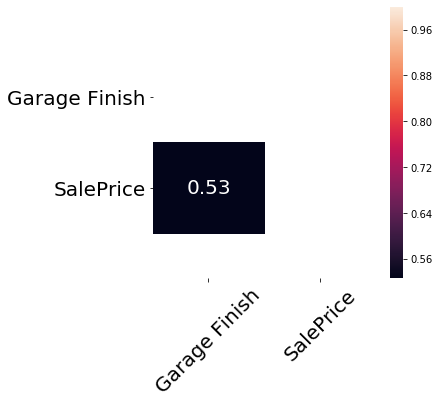

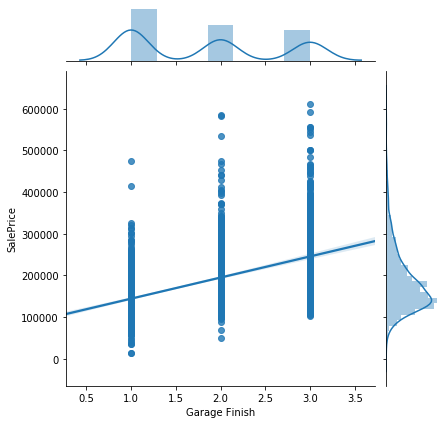

In [104]:
check_corr_func('Garage Finish','Ordinal','Yes','Unknown,Unf,RFn,Fin')

## ANS:

Correlation is decent at 0.53. 

114 null values.

##  Use Garage Finish as predictor. impute all NaN values with the 2.0 as median.

Garage Finish    114
SalePrice          0
dtype: int64
There are some entries with null values in 'Garage Finish'.


After null value processing, this is the new null count.

Garage Finish    0
SalePrice        0
dtype: int64

After null value processing, these are the new value_counts.

Unf        849
RFn        579
Fin        509
Unknown    114
Name: Garage Finish, dtype: int64

Set of all possible values for column {'Unknown', 'Fin', 'RFn', 'Unf'}


List of all possible values for column, including 'Unknown' for 'Garage Finish': ['Unknown', 'Unf', 'RFn', 'Fin']

Unf        849
RFn        579
Fin        509
Unknown    114
Name: Garage Finish, dtype: int64
1    849
2    579
3    509
0    114
Name: Garage Finish, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Garage Finish  2051 non-null   int64
 1   SalePrice      2051 non-n

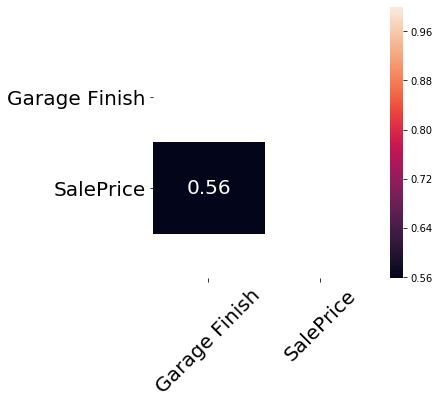

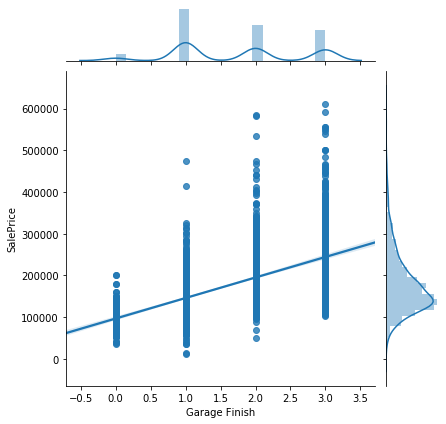

In [105]:
check_corr_func('Garage Finish','Ordinal','No','Unknown,Unf,RFn,Fin')

Garage Cars    1
SalePrice      0
dtype: int64
There are some entries with null values in 'Garage Cars'.


After null value processing, this is the new null count.

Garage Cars    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

2.0    1136
1.0     524
3.0     263
0.0     113
4.0      13
5.0       1
Name: Garage Cars, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Garage Cars  2050 non-null   float64
 1   SalePrice    2050 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       Garage Cars      SalePrice
count  2050.000000    2050.000000
mean      1.776585  181484.609268
std       0.764537   79275.121591
min       0.000000   12789.000000
25%       1.000000  129812.500000
50%       2.000000  162500.000000
75%       2.000000  214000.000000
max       5.000

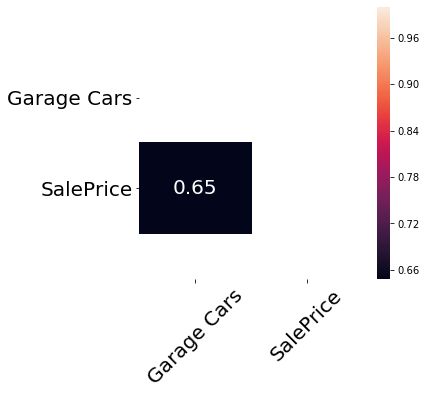

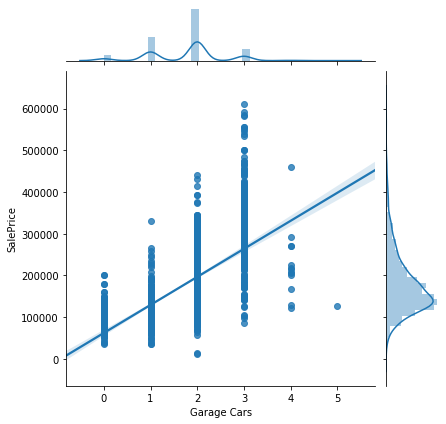

In [106]:
check_corr_func('Garage Cars','Discrete','Yes','')

## ANS:

Correlation is good at 0.65. 

1 null values.

##  Use Garage Cars as predictor. impute all NaN values with 0, as no garage.

Garage Cars    1
SalePrice      0
dtype: int64
There are some entries with null values in 'Garage Cars'.


After null value processing, this is the new null count.

Garage Cars    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

2.0        1136
1.0         524
3.0         263
0.0         113
4.0          13
Unknown       1
5.0           1
Name: Garage Cars, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Garage Cars  2051 non-null   object
 1   SalePrice    2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.000000


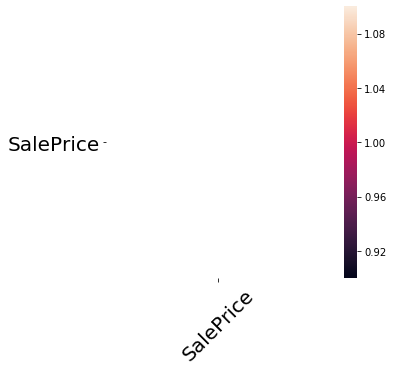

In [107]:
check_corr_func('Garage Cars','Discrete','No','')

Garage Area    1
SalePrice      0
dtype: int64
There are some entries with null values in 'Garage Area'.


After null value processing, this is the new null count.

Garage Area    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

0.0       113
440.0      70
576.0      69
484.0      52
528.0      46
         ... 
406.0       1
309.0       1
580.0       1
1184.0      1
557.0       1
Name: Garage Area, Length: 514, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Garage Area  2050 non-null   float64
 1   SalePrice    2050 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 48.0 KB
None


       Garage Area      SalePrice
count  2050.000000    2050.000000
mean    473.671707  181484.609268
std     215.934561   79275.121591
min       0.000000   12789.000000
25%     319.000000  12

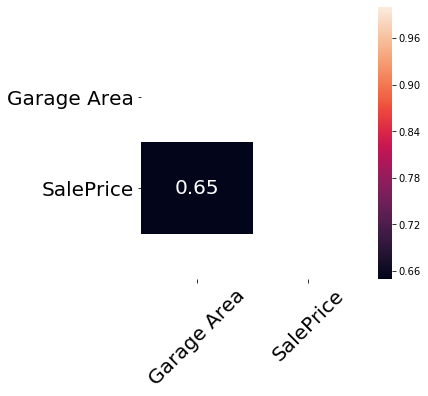

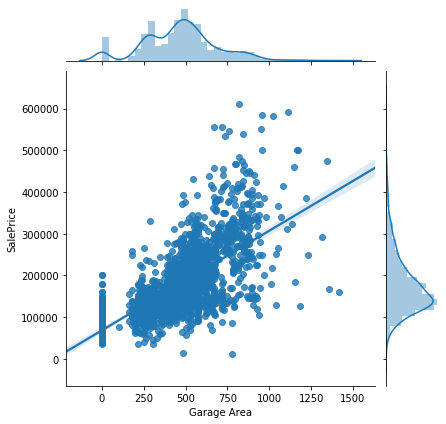

In [108]:
check_corr_func('Garage Area','Continuous','Yes','')

## ANS:

Correlation is good at 0.65. 

114 null values.

##  Use Garage Area as predictor. impute all NaN values with 0, as no garage.

Garage Area    1
SalePrice      0
dtype: int64
There are some entries with null values in 'Garage Area'.


After null value processing, this is the new null count.

Garage Area    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

0.0       113
440.0      70
576.0      69
484.0      52
528.0      46
         ... 
518.0       1
514.0       1
513.0       1
859.0       1
1020.0      1
Name: Garage Area, Length: 515, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Garage Area  2051 non-null   object
 1   SalePrice    2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB
None


           SalePrice
count    2051.000000
mean   181469.701609
std     79258.659352
min     12789.000000
25%    129825.000000
50%    162500.000000
75%    214000.000000
max    611657.000000


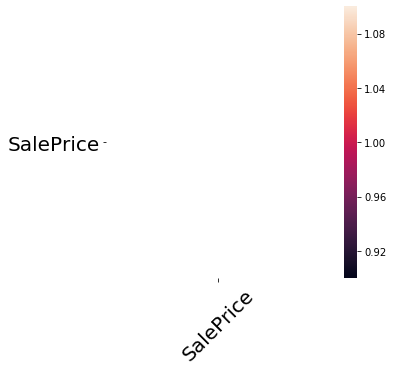

In [109]:
check_corr_func('Garage Area','Continuous','No','')

Garage Qual    114
SalePrice        0
dtype: int64
There are some entries with null values in 'Garage Qual'.


After null value processing, this is the new null count.

Garage Qual    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Garage Qual': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64
3    1832
2      82
4      18
5       3
1       2
Name: Garage Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Garage Qual  1937 non-null   int64
 1   SalePrice    1937 non-null   int64
dty

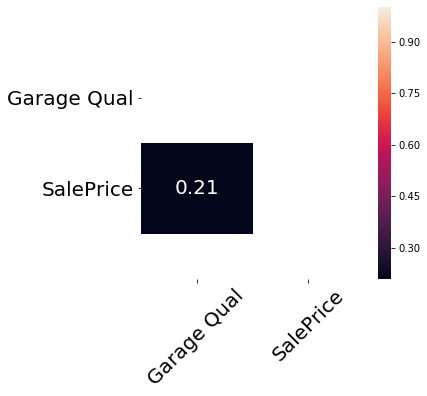

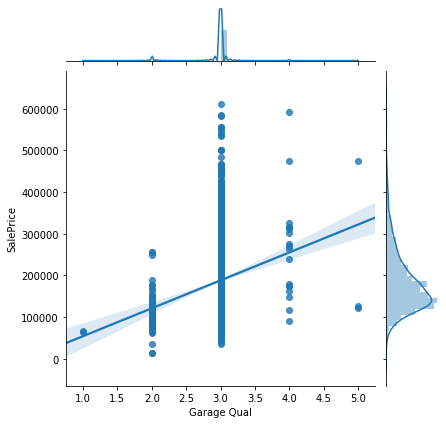

In [110]:
check_corr_func('Garage Qual','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

Garage Qual    114
SalePrice        0
dtype: int64
There are some entries with null values in 'Garage Qual'.


After null value processing, this is the new null count.

Garage Qual    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

TA         1832
Unknown     114
Fa           82
Gd           18
Ex            3
Po            2
Name: Garage Qual, dtype: int64

Set of all possible values for column {'Unknown', 'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Garage Qual': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA         1832
Unknown     114
Fa           82
Gd           18
Ex            3
Po            2
Name: Garage Qual, dtype: int64
3    1832
0     114
2      82
4      18
5       3
1       2
Name: Garage Qual, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --

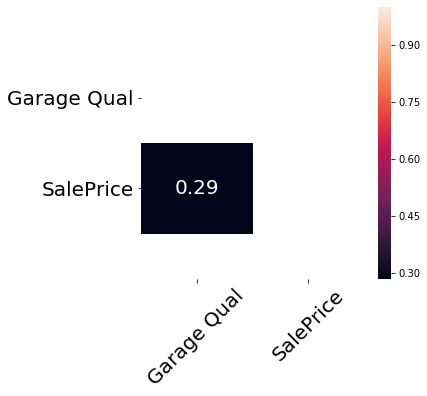

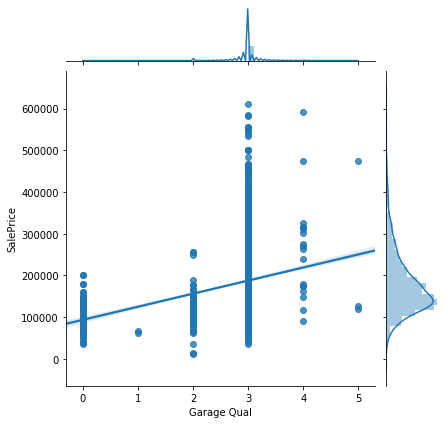

In [111]:
check_corr_func('Garage Qual','Ordinal','No','Unknown,Po,Fa,TA,Gd,Ex')

Garage Cond    114
SalePrice        0
dtype: int64
There are some entries with null values in 'Garage Cond'.


After null value processing, this is the new null count.

Garage Cond    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

TA    1868
Fa      47
Gd      12
Po       8
Ex       2
Name: Garage Cond, dtype: int64

Set of all possible values for column {'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Garage Cond': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA    1868
Fa      47
Gd      12
Po       8
Ex       2
Name: Garage Cond, dtype: int64
3    1868
2      47
4      12
1       8
5       2
Name: Garage Cond, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Garage Cond  1937 non-null   int64
 1   SalePrice    1937 non-null   int64
dty

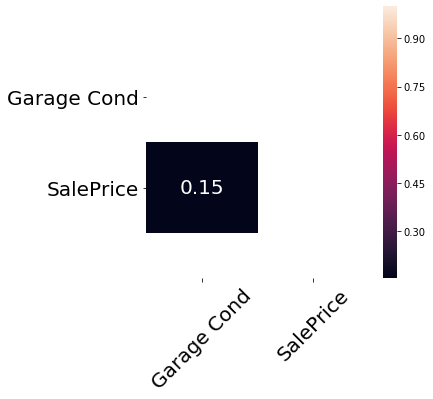

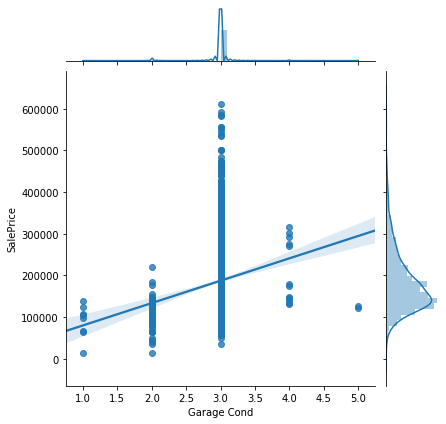

In [112]:
check_corr_func('Garage Cond','Ordinal','Yes','Unknown,Po,Fa,TA,Gd,Ex')

Garage Cond    114
SalePrice        0
dtype: int64
There are some entries with null values in 'Garage Cond'.


After null value processing, this is the new null count.

Garage Cond    0
SalePrice      0
dtype: int64

After null value processing, these are the new value_counts.

TA         1868
Unknown     114
Fa           47
Gd           12
Po            8
Ex            2
Name: Garage Cond, dtype: int64

Set of all possible values for column {'Unknown', 'Ex', 'Gd', 'Po', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Garage Cond': ['Unknown', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

TA         1868
Unknown     114
Fa           47
Gd           12
Po            8
Ex            2
Name: Garage Cond, dtype: int64
3    1868
0     114
2      47
4      12
1       8
5       2
Name: Garage Cond, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --

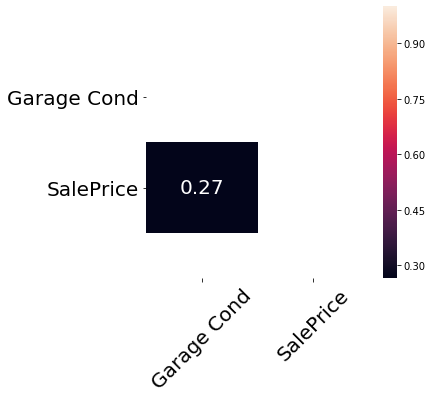

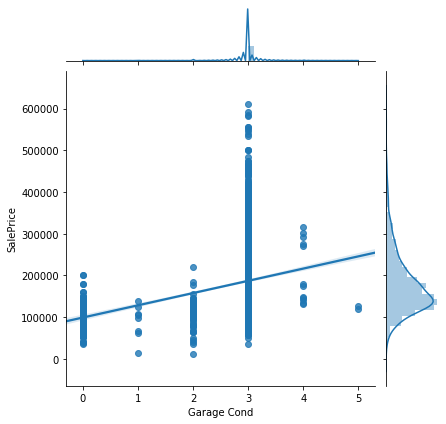

In [113]:
check_corr_func('Garage Cond','Ordinal','No','Unknown,Po,Fa,TA,Gd,Ex')

Paved Drive    0
SalePrice      0
dtype: int64
There are no entries with null values in 'Paved Drive'.

These are the value_counts.

Y    1861
N     151
P      39
Name: Paved Drive, dtype: int64

Set of all possible values for column {'P', 'Y', 'N'}


List of all possible values for column, including 'Unknown' for 'Paved Drive': ['Unknown', 'N', 'P', 'Y']

Y    1861
N     151
P      39
Name: Paved Drive, dtype: int64
3    1861
1     151
2      39
Name: Paved Drive, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Paved Drive  2051 non-null   int64
 1   SalePrice    2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Paved Drive      SalePrice
count  2051.000000    2051.000000
mean      2.833740  181469.701609
std       0.534792   79258.659352
min       1.000000   12789.000000
25%       3.000000  129825.000000

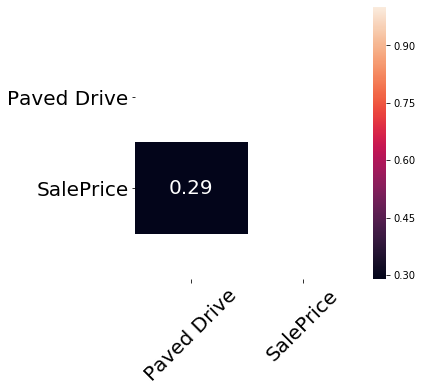

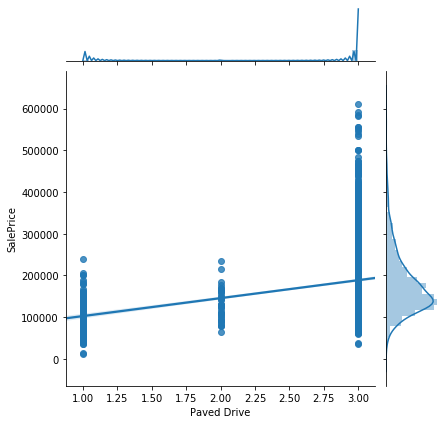

In [114]:
check_corr_func('Paved Drive','Ordinal','Yes','Unknown,N,P,Y')

Wood Deck SF    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Wood Deck SF'.

These are the value_counts.

0      1075
100      53
144      46
192      43
120      40
       ... 
586       1
576       1
550       1
546       1
394       1
Name: Wood Deck SF, Length: 322, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Wood Deck SF  2051 non-null   int64
 1   SalePrice     2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Wood Deck SF      SalePrice
count   2051.000000    2051.000000
mean      93.833740  181469.701609
std      128.549416   79258.659352
min        0.000000   12789.000000
25%        0.000000  129825.000000
50%        0.000000  162500.000000
75%      168.000000  214000.000000
max     1424.000000  611657.000000


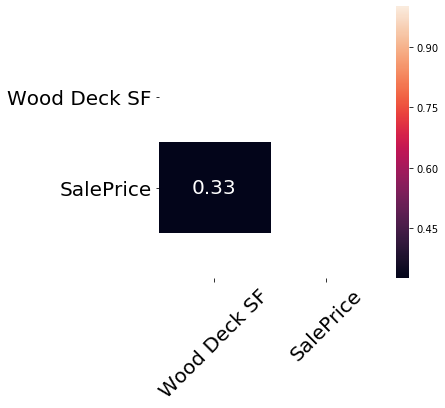

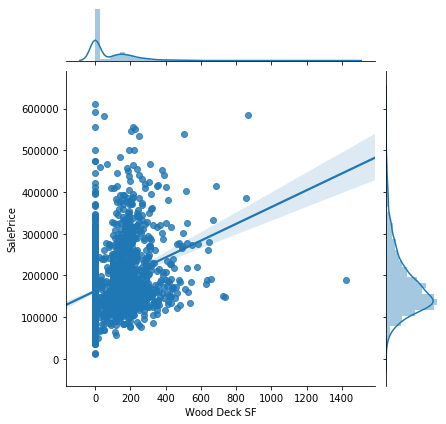

In [115]:
check_corr_func('Wood Deck SF','Continuous','Yes','')

Open Porch SF    0
SalePrice        0
dtype: int64
There are no entries with null values in 'Open Porch SF'.

These are the value_counts.

0      912
48      40
36      38
40      34
32      29
      ... 
444      1
484      1
502      1
15       1
276      1
Name: Open Porch SF, Length: 223, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Open Porch SF  2051 non-null   int64
 1   SalePrice      2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Open Porch SF      SalePrice
count    2051.000000    2051.000000
mean       47.556802  181469.701609
std        66.747241   79258.659352
min         0.000000   12789.000000
25%         0.000000  129825.000000
50%        27.000000  162500.000000
75%        70.000000  214000.000000
max       547.000000  611657.000000


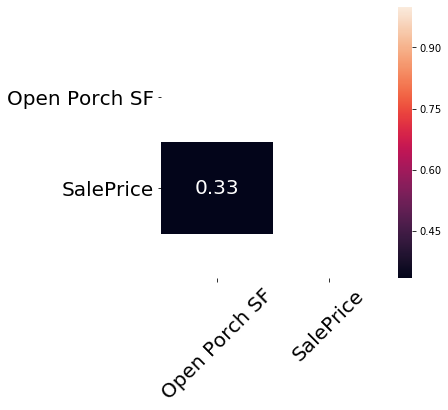

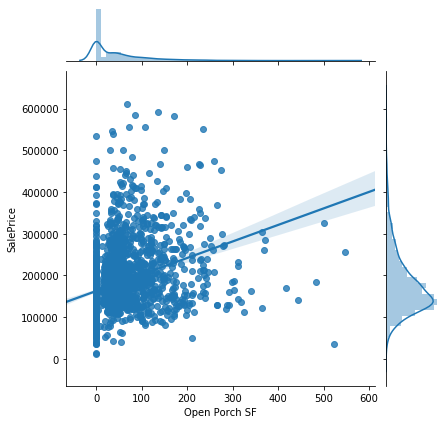

In [116]:
check_corr_func('Open Porch SF','Continuous','Yes','')

Enclosed Porch    0
SalePrice         0
dtype: int64
There are no entries with null values in 'Enclosed Porch'.

These are the value_counts.

0      1724
112      13
96       10
216       6
84        6
       ... 
190       1
194       1
196       1
198       1
301       1
Name: Enclosed Porch, Length: 159, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Enclosed Porch  2051 non-null   int64
 1   SalePrice       2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Enclosed Porch      SalePrice
count     2051.000000    2051.000000
mean        22.571916  181469.701609
std         59.845110   79258.659352
min          0.000000   12789.000000
25%          0.000000  129825.000000
50%          0.000000  162500.000000
75%          0.000000  214000.000000
max        432.000000  611657.000000


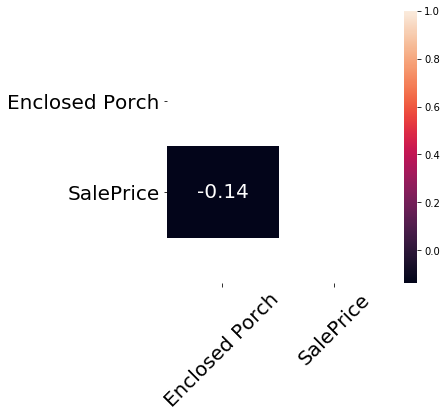

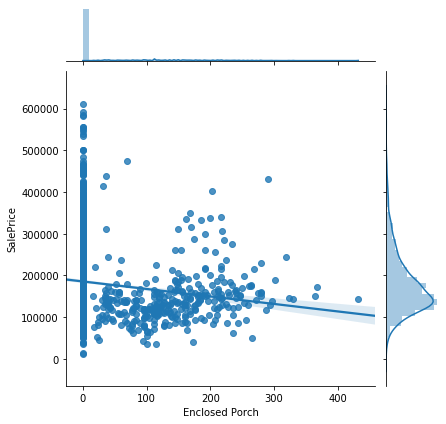

In [117]:
check_corr_func('Enclosed Porch','Continuous','Yes','')

3Ssn Porch    0
SalePrice     0
dtype: int64
There are no entries with null values in '3Ssn Porch'.

These are the value_counts.

0      2025
153       3
168       3
144       2
176       1
86        1
96        1
120       1
140       1
150       1
162       1
407       1
323       1
182       1
216       1
224       1
290       1
304       1
508       1
245       1
255       1
180       1
Name: 3Ssn Porch, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   3Ssn Porch  2051 non-null   int64
 1   SalePrice   2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


        3Ssn Porch      SalePrice
count  2051.000000    2051.000000
mean      2.591419  181469.701609
std      25.229615   79258.659352
min       0.000000   12789.000000
25%       0.000000  129825.000000
50%       0.000000  162500.000000
75%       0.000000  214000.

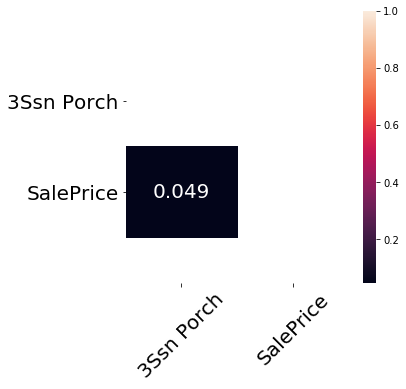

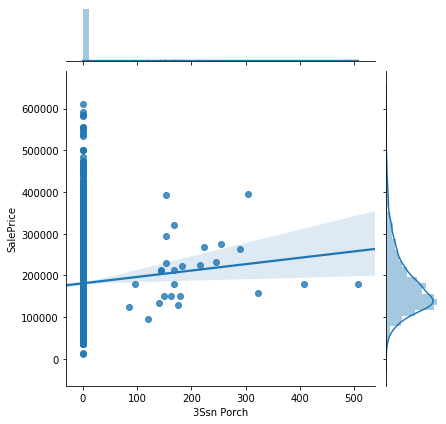

In [118]:
check_corr_func('3Ssn Porch','Continuous','Yes','')

Screen Porch    0
SalePrice       0
dtype: int64
There are no entries with null values in 'Screen Porch'.

These are the value_counts.

0      1870
144       9
168       8
180       7
192       7
       ... 
143       1
198       1
196       1
190       1
385       1
Name: Screen Porch, Length: 100, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Screen Porch  2051 non-null   int64
 1   SalePrice     2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


       Screen Porch      SalePrice
count   2051.000000    2051.000000
mean      16.511458  181469.701609
std       57.374204   79258.659352
min        0.000000   12789.000000
25%        0.000000  129825.000000
50%        0.000000  162500.000000
75%        0.000000  214000.000000
max      490.000000  611657.000000


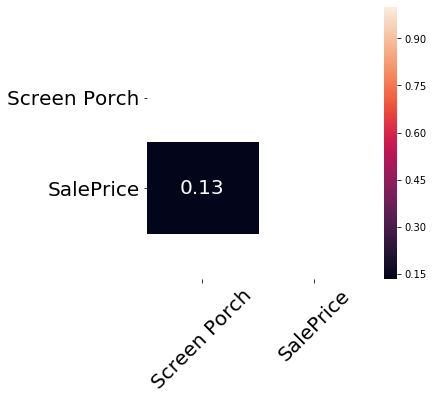

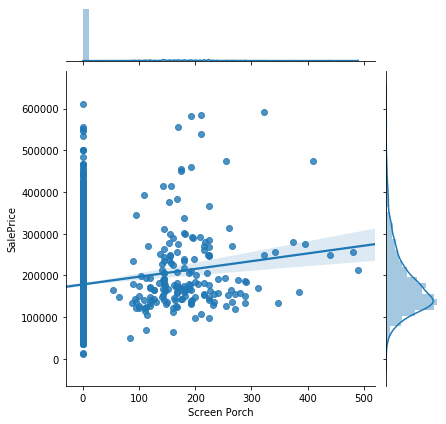

In [119]:
check_corr_func('Screen Porch','Continuous','Yes','')

Pool Area    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Pool Area'.

These are the value_counts.

0      2042
561       1
519       1
800       1
738       1
648       1
576       1
480       1
368       1
228       1
Name: Pool Area, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Pool Area  2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


         Pool Area      SalePrice
count  2051.000000    2051.000000
mean      2.397855  181469.701609
std      37.782570   79258.659352
min       0.000000   12789.000000
25%       0.000000  129825.000000
50%       0.000000  162500.000000
75%       0.000000  214000.000000
max     800.000000  611657.000000


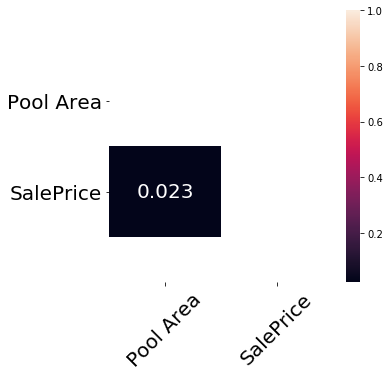

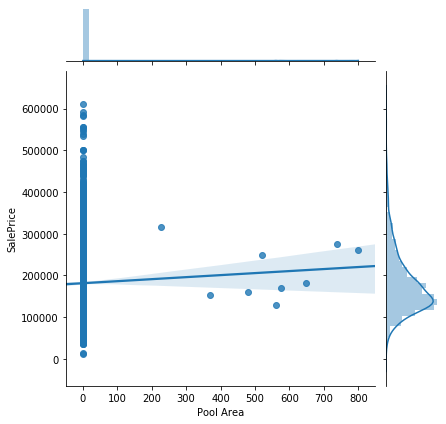

In [120]:
check_corr_func('Pool Area','Continuous','Yes','')

## ANS:

Very few (9) units have pools, too small a number compared to 2051 for good fit to a model.

drop all pool statistics as predictors..
    

Pool QC      2042
SalePrice       0
dtype: int64
There are some entries with null values in 'Pool QC'.


After null value processing, this is the new null count.

Pool QC      0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64

Set of all possible values for column {'Fa', 'Ex', 'Gd', 'TA'}


List of all possible values for column, including 'Unknown' for 'Pool QC': ['Unknown', 'Fa', 'TA', 'Gd', 'Ex']

Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64
3    4
2    2
1    2
4    1
Name: Pool QC, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 52 to 1875
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Pool QC    9 non-null      int64
 1   SalePrice  9 non-null      int64
dtypes: int64(2)
memory usage: 216.0 bytes
None


        Pool QC      SalePrice
count  9.000000       9.000000
mean   

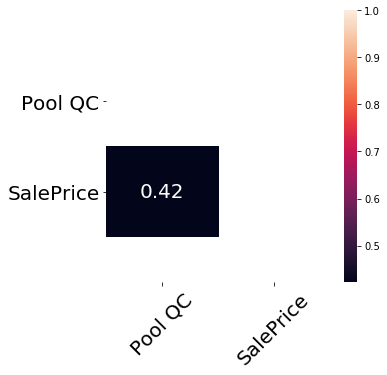

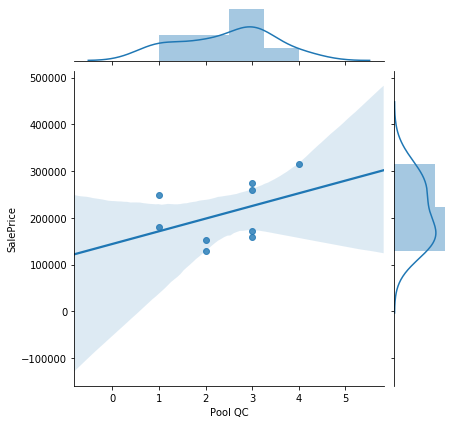

In [121]:
check_corr_func('Pool QC','Ordinal','Yes','Unknown,Fa,TA,Gd,Ex')

Pool QC      2042
SalePrice       0
dtype: int64
There are some entries with null values in 'Pool QC'.


After null value processing, this is the new null count.

Pool QC      0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    2042
Gd            4
TA            2
Fa            2
Ex            1
Name: Pool QC, dtype: int64

Set of all possible values for column {'Unknown', 'Ex', 'Gd', 'TA', 'Fa'}


List of all possible values for column, including 'Unknown' for 'Pool QC': ['Unknown', 'Fa', 'TA', 'Gd', 'Ex']

Unknown    2042
Gd            4
TA            2
Fa            2
Ex            1
Name: Pool QC, dtype: int64
0    2042
3       4
1       2
2       2
4       1
Name: Pool QC, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Pool QC    2051 non-null   int64
 1   SalePrice  2051 non-n

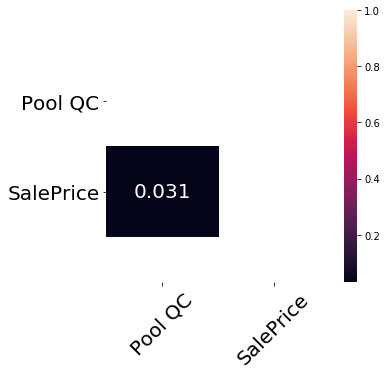

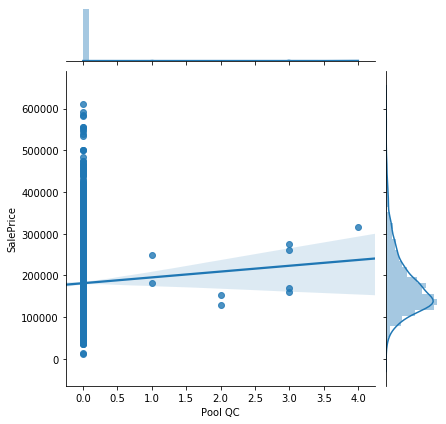

In [122]:
check_corr_func('Pool QC','Ordinal','No','Unknown,Fa,TA,Gd,Ex')

Fence        1651
SalePrice       0
dtype: int64
There are some entries with null values in 'Fence'.


After null value processing, this is the new null count.

Fence        0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

Set of all possible values for column {'GdWo', 'GdPrv', 'MnWw', 'MnPrv'}


List of all possible values for column, including 'Unknown' for 'Fence': ['Unknown', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64
3    227
4     83
2     80
1     10
Name: Fence, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 7 to 2043
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Fence      400 non-null    int64
 1   SalePrice  400 non-null    int64
dtypes: int64(2)
memory usage: 9.4 KB
None


            Fen

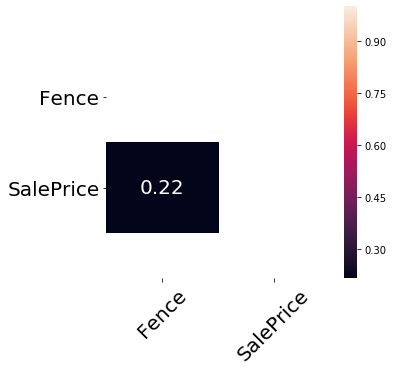

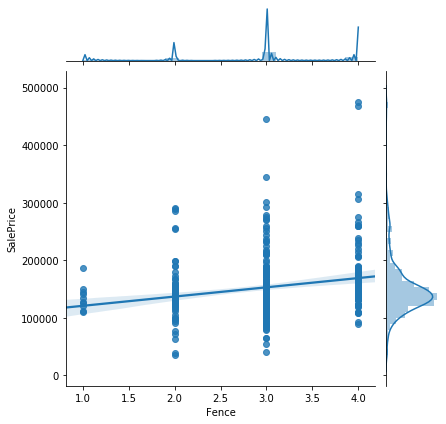

In [123]:
check_corr_func('Fence','Ordinal','Yes','Unknown,MnWw,GdWo,MnPrv,GdPrv')

Fence        1651
SalePrice       0
dtype: int64
There are some entries with null values in 'Fence'.


After null value processing, this is the new null count.

Fence        0
SalePrice    0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    1651
MnPrv       227
GdPrv        83
GdWo         80
MnWw         10
Name: Fence, dtype: int64

Set of all possible values for column {'MnWw', 'GdPrv', 'Unknown', 'MnPrv', 'GdWo'}


List of all possible values for column, including 'Unknown' for 'Fence': ['Unknown', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

Unknown    1651
MnPrv       227
GdPrv        83
GdWo         80
MnWw         10
Name: Fence, dtype: int64
0    1651
3     227
4      83
2      80
1      10
Name: Fence, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Fence      2051 non-null   int64
 1   SalePrice  

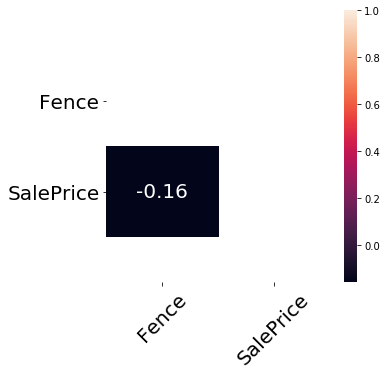

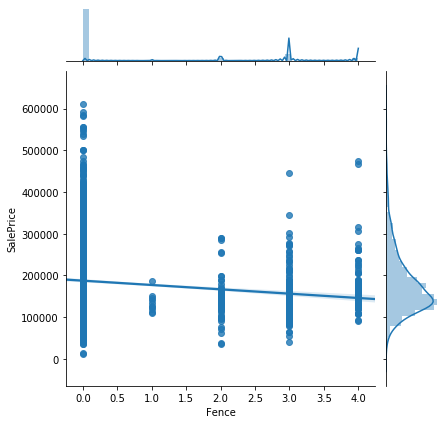

In [124]:
check_corr_func('Fence','Ordinal','No','Unknown,MnWw,GdWo,MnPrv,GdPrv')

Misc Feature    1986
SalePrice          0
dtype: int64
There are some entries with null values in 'Misc Feature'.


After null value processing, this is the new null count.

Misc Feature    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

Shed    56
Gar2     4
Othr     3
Elev     1
TenC     1
Name: Misc Feature, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Misc Feature_Elev  65 non-null     float64
 1   Misc Feature_Gar2  65 non-null     float64
 2   Misc Feature_Othr  65 non-null     float64
 3   Misc Feature_Shed  65 non-null     float64
 4   Misc Feature_TenC  65 non-null     float64
 5   SalePrice          2051 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 112.2 KB
None


       Misc Feature_Elev  Misc Feature_Gar2  Misc Feature_Othr  \
count    

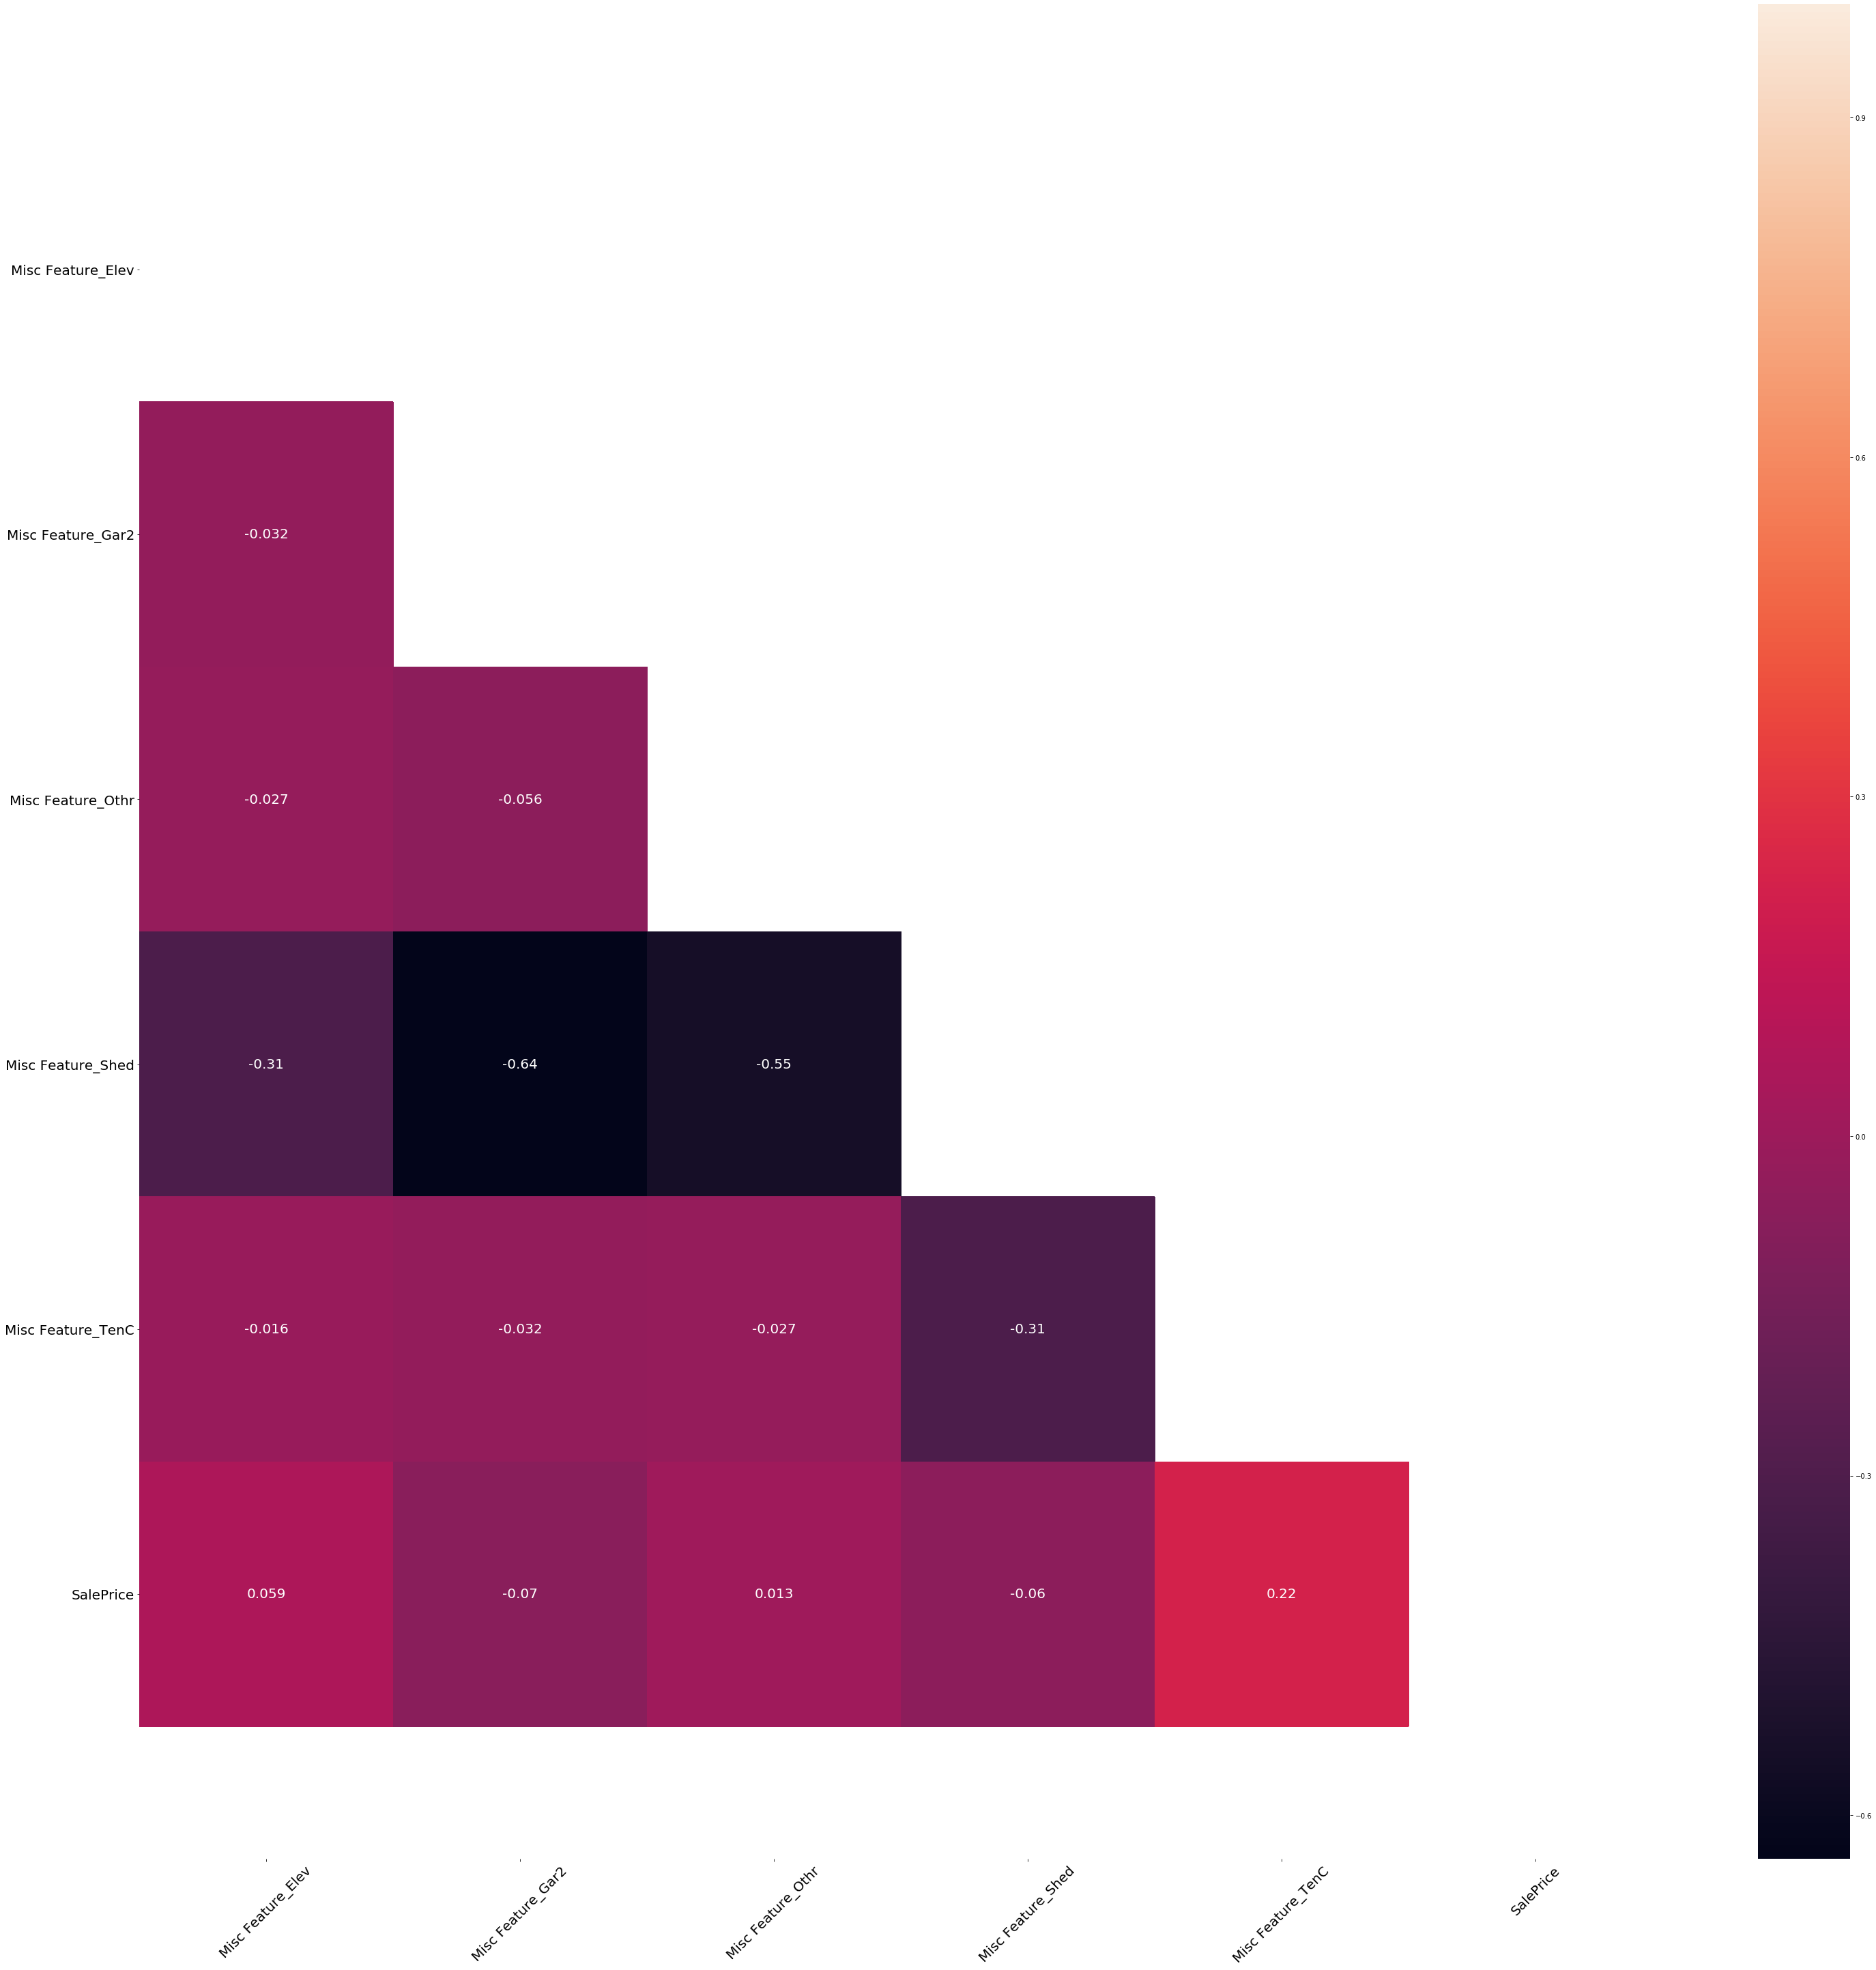

In [125]:
check_corr_func('Misc Feature','Nominal','Yes','')

Misc Feature    1986
SalePrice          0
dtype: int64
There are some entries with null values in 'Misc Feature'.


After null value processing, this is the new null count.

Misc Feature    0
SalePrice       0
dtype: int64

After null value processing, these are the new value_counts.

Unknown    1986
Shed         56
Gar2          4
Othr          3
Elev          1
TenC          1
Name: Misc Feature, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Misc Feature_Elev     2051 non-null   uint8
 1   Misc Feature_Gar2     2051 non-null   uint8
 2   Misc Feature_Othr     2051 non-null   uint8
 3   Misc Feature_Shed     2051 non-null   uint8
 4   Misc Feature_TenC     2051 non-null   uint8
 5   Misc Feature_Unknown  2051 non-null   uint8
 6   SalePrice             2051 non-null   int64
dtypes: int64(1), uint8(6)
memory us

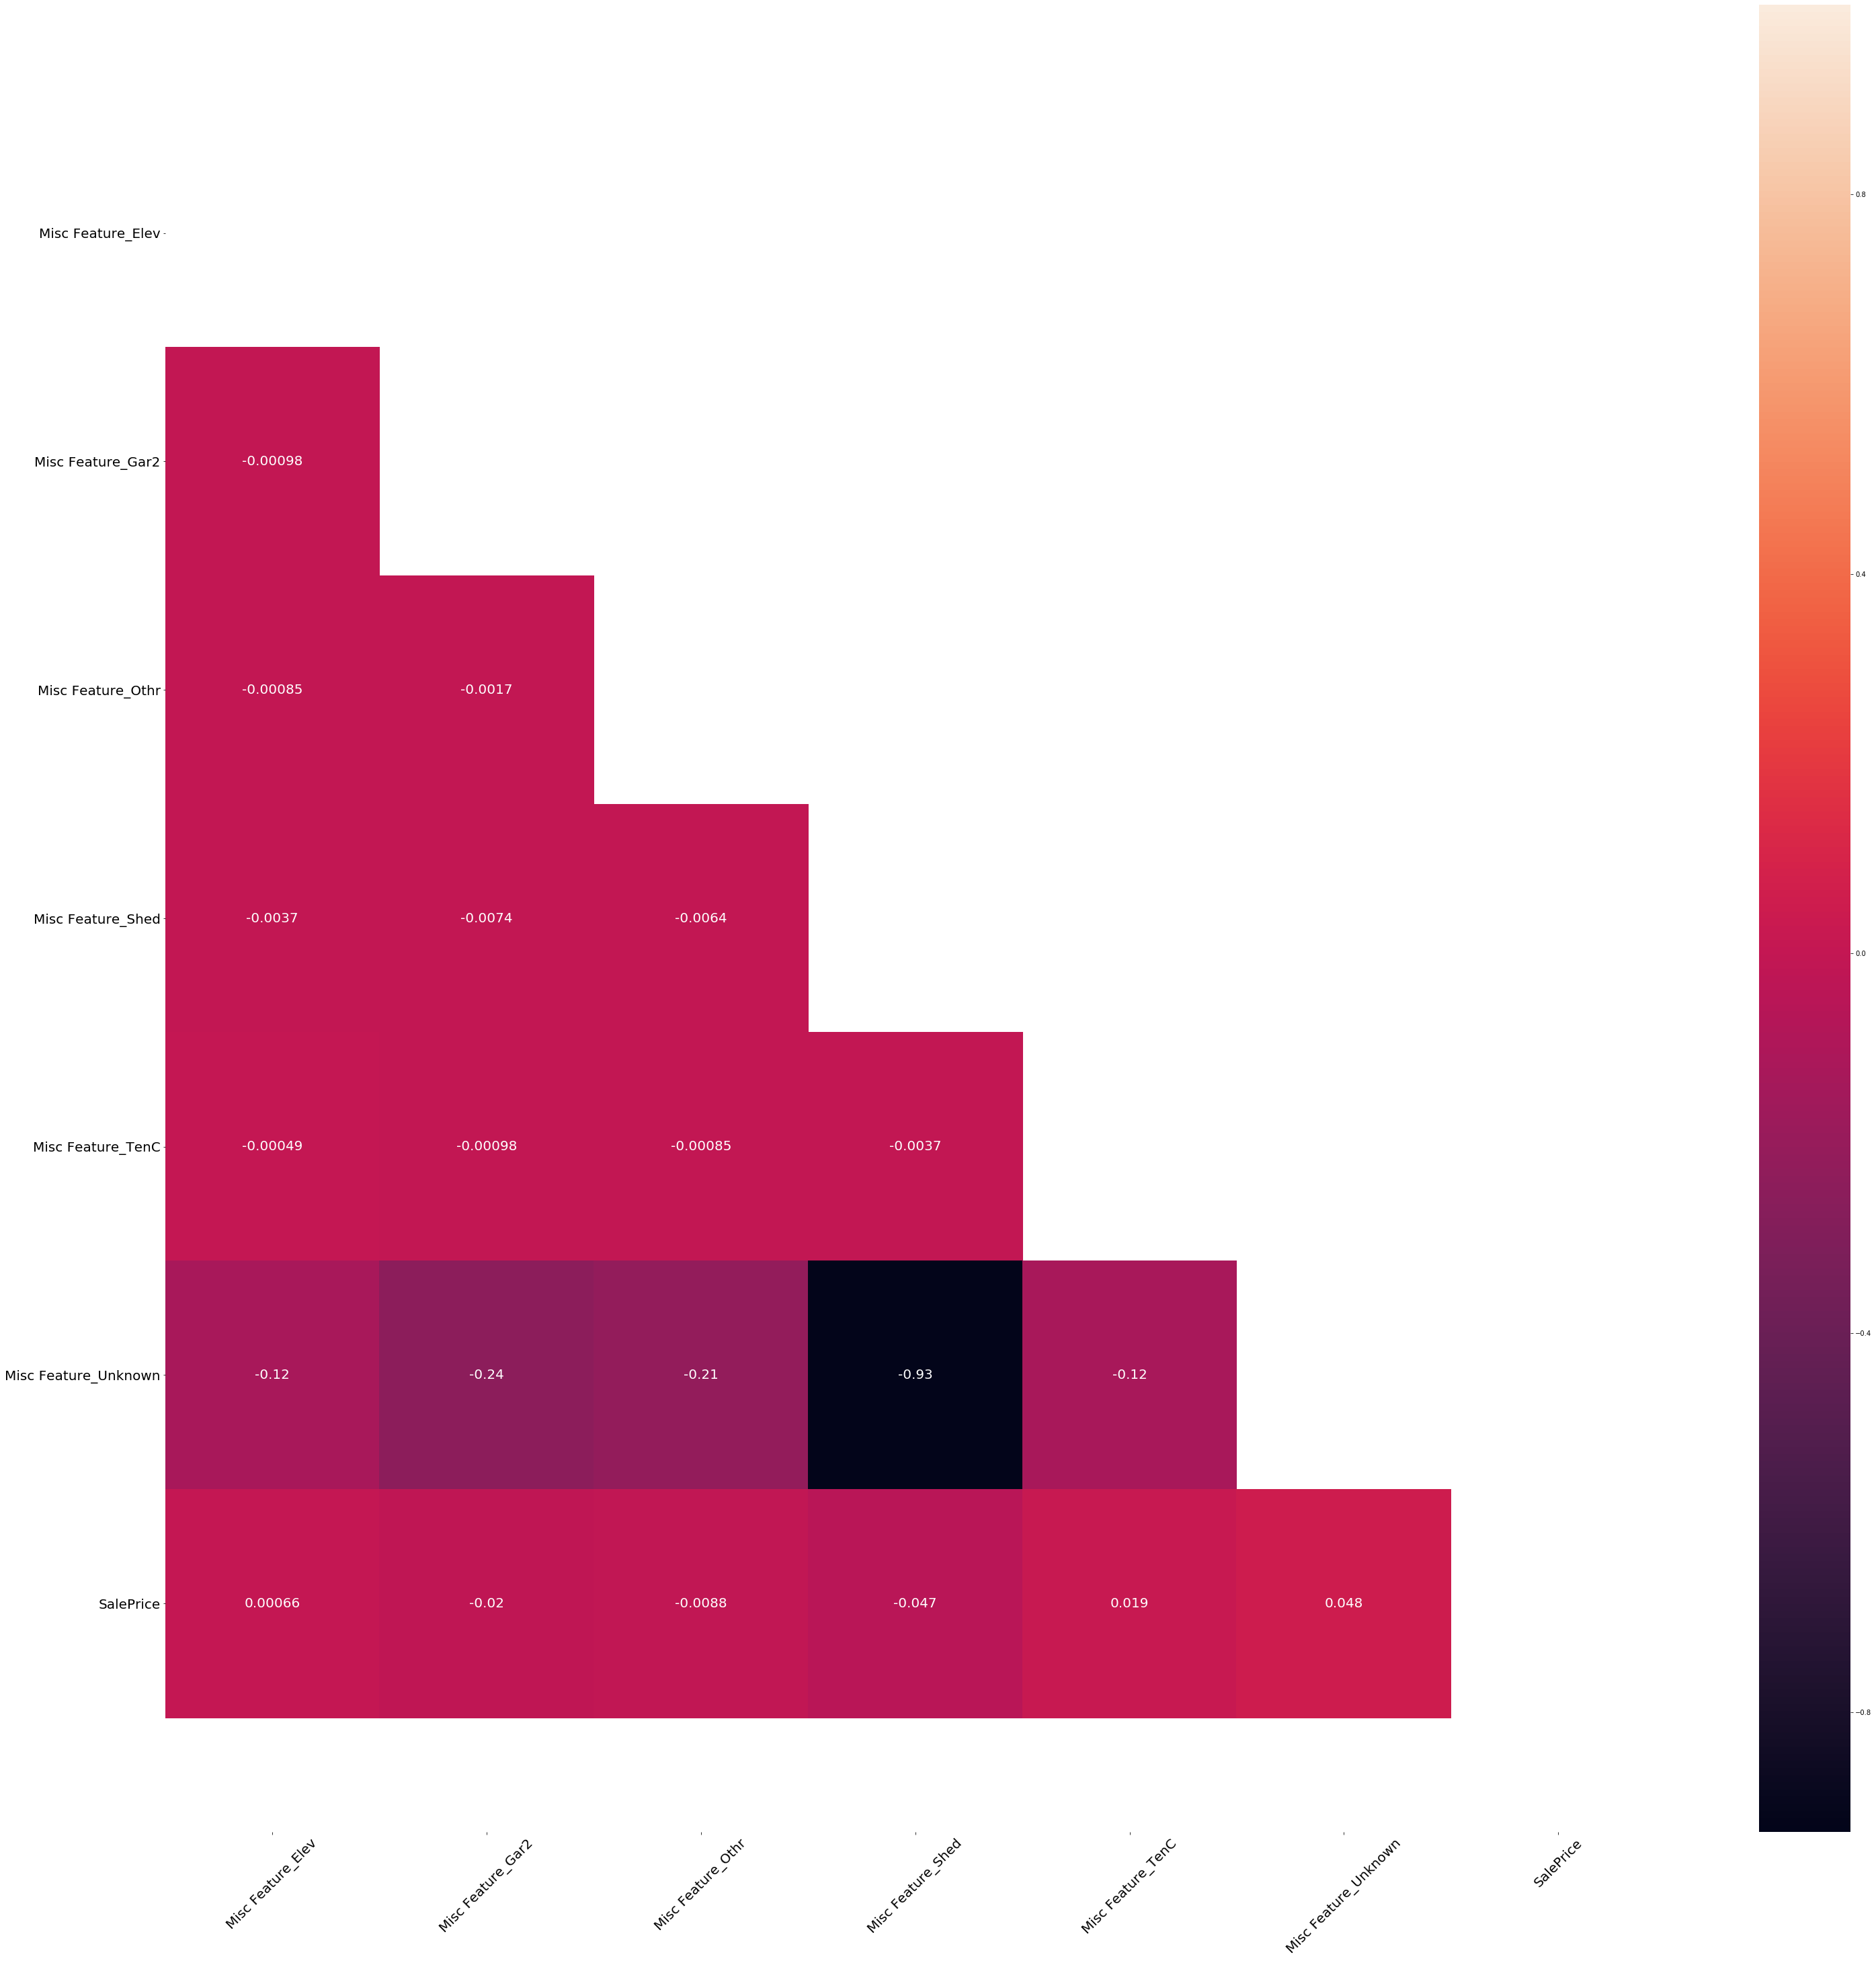

In [126]:
check_corr_func('Misc Feature','Nominal','No','')

Misc Val     0
SalePrice    0
dtype: int64
There are no entries with null values in 'Misc Val'.

These are the value_counts.

0        1986
400        12
500         8
600         6
2000        5
450         5
700         4
2500        2
4500        2
3000        2
1200        2
80          1
8300        1
12500       1
460         1
300         1
54          1
3500        1
480         1
650         1
800         1
900         1
1150        1
1300        1
1500        1
6500        1
455         1
17000       1
Name: Misc Val, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Misc Val   2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


           Misc Val      SalePrice
count   2051.000000    2051.000000
mean      51.574354  181469.701609
std      573.393985   79258.659352
min    

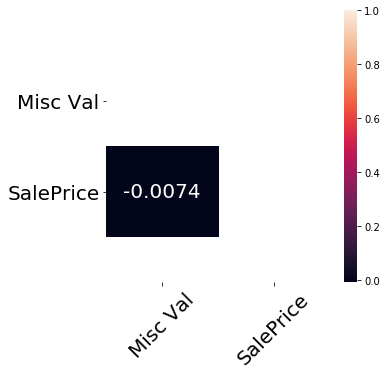

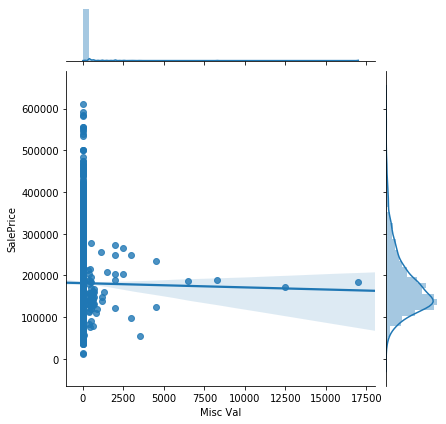

In [127]:
check_corr_func('Misc Val','Continuous','Yes','')

Mo Sold      0
SalePrice    0
dtype: int64
There are no entries with null values in 'Mo Sold'.

These are the value_counts.

6     352
7     303
5     257
4     208
3     168
8     167
10    123
9     109
2     104
11    103
1      79
12     78
Name: Mo Sold, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Mo Sold_1   2051 non-null   uint8
 1   Mo Sold_10  2051 non-null   uint8
 2   Mo Sold_11  2051 non-null   uint8
 3   Mo Sold_12  2051 non-null   uint8
 4   Mo Sold_2   2051 non-null   uint8
 5   Mo Sold_3   2051 non-null   uint8
 6   Mo Sold_4   2051 non-null   uint8
 7   Mo Sold_5   2051 non-null   uint8
 8   Mo Sold_6   2051 non-null   uint8
 9   Mo Sold_7   2051 non-null   uint8
 10  Mo Sold_8   2051 non-null   uint8
 11  Mo Sold_9   2051 non-null   uint8
 12  SalePrice   2051 non-null   int64
dtypes: int64(1), uint8(12)
memor

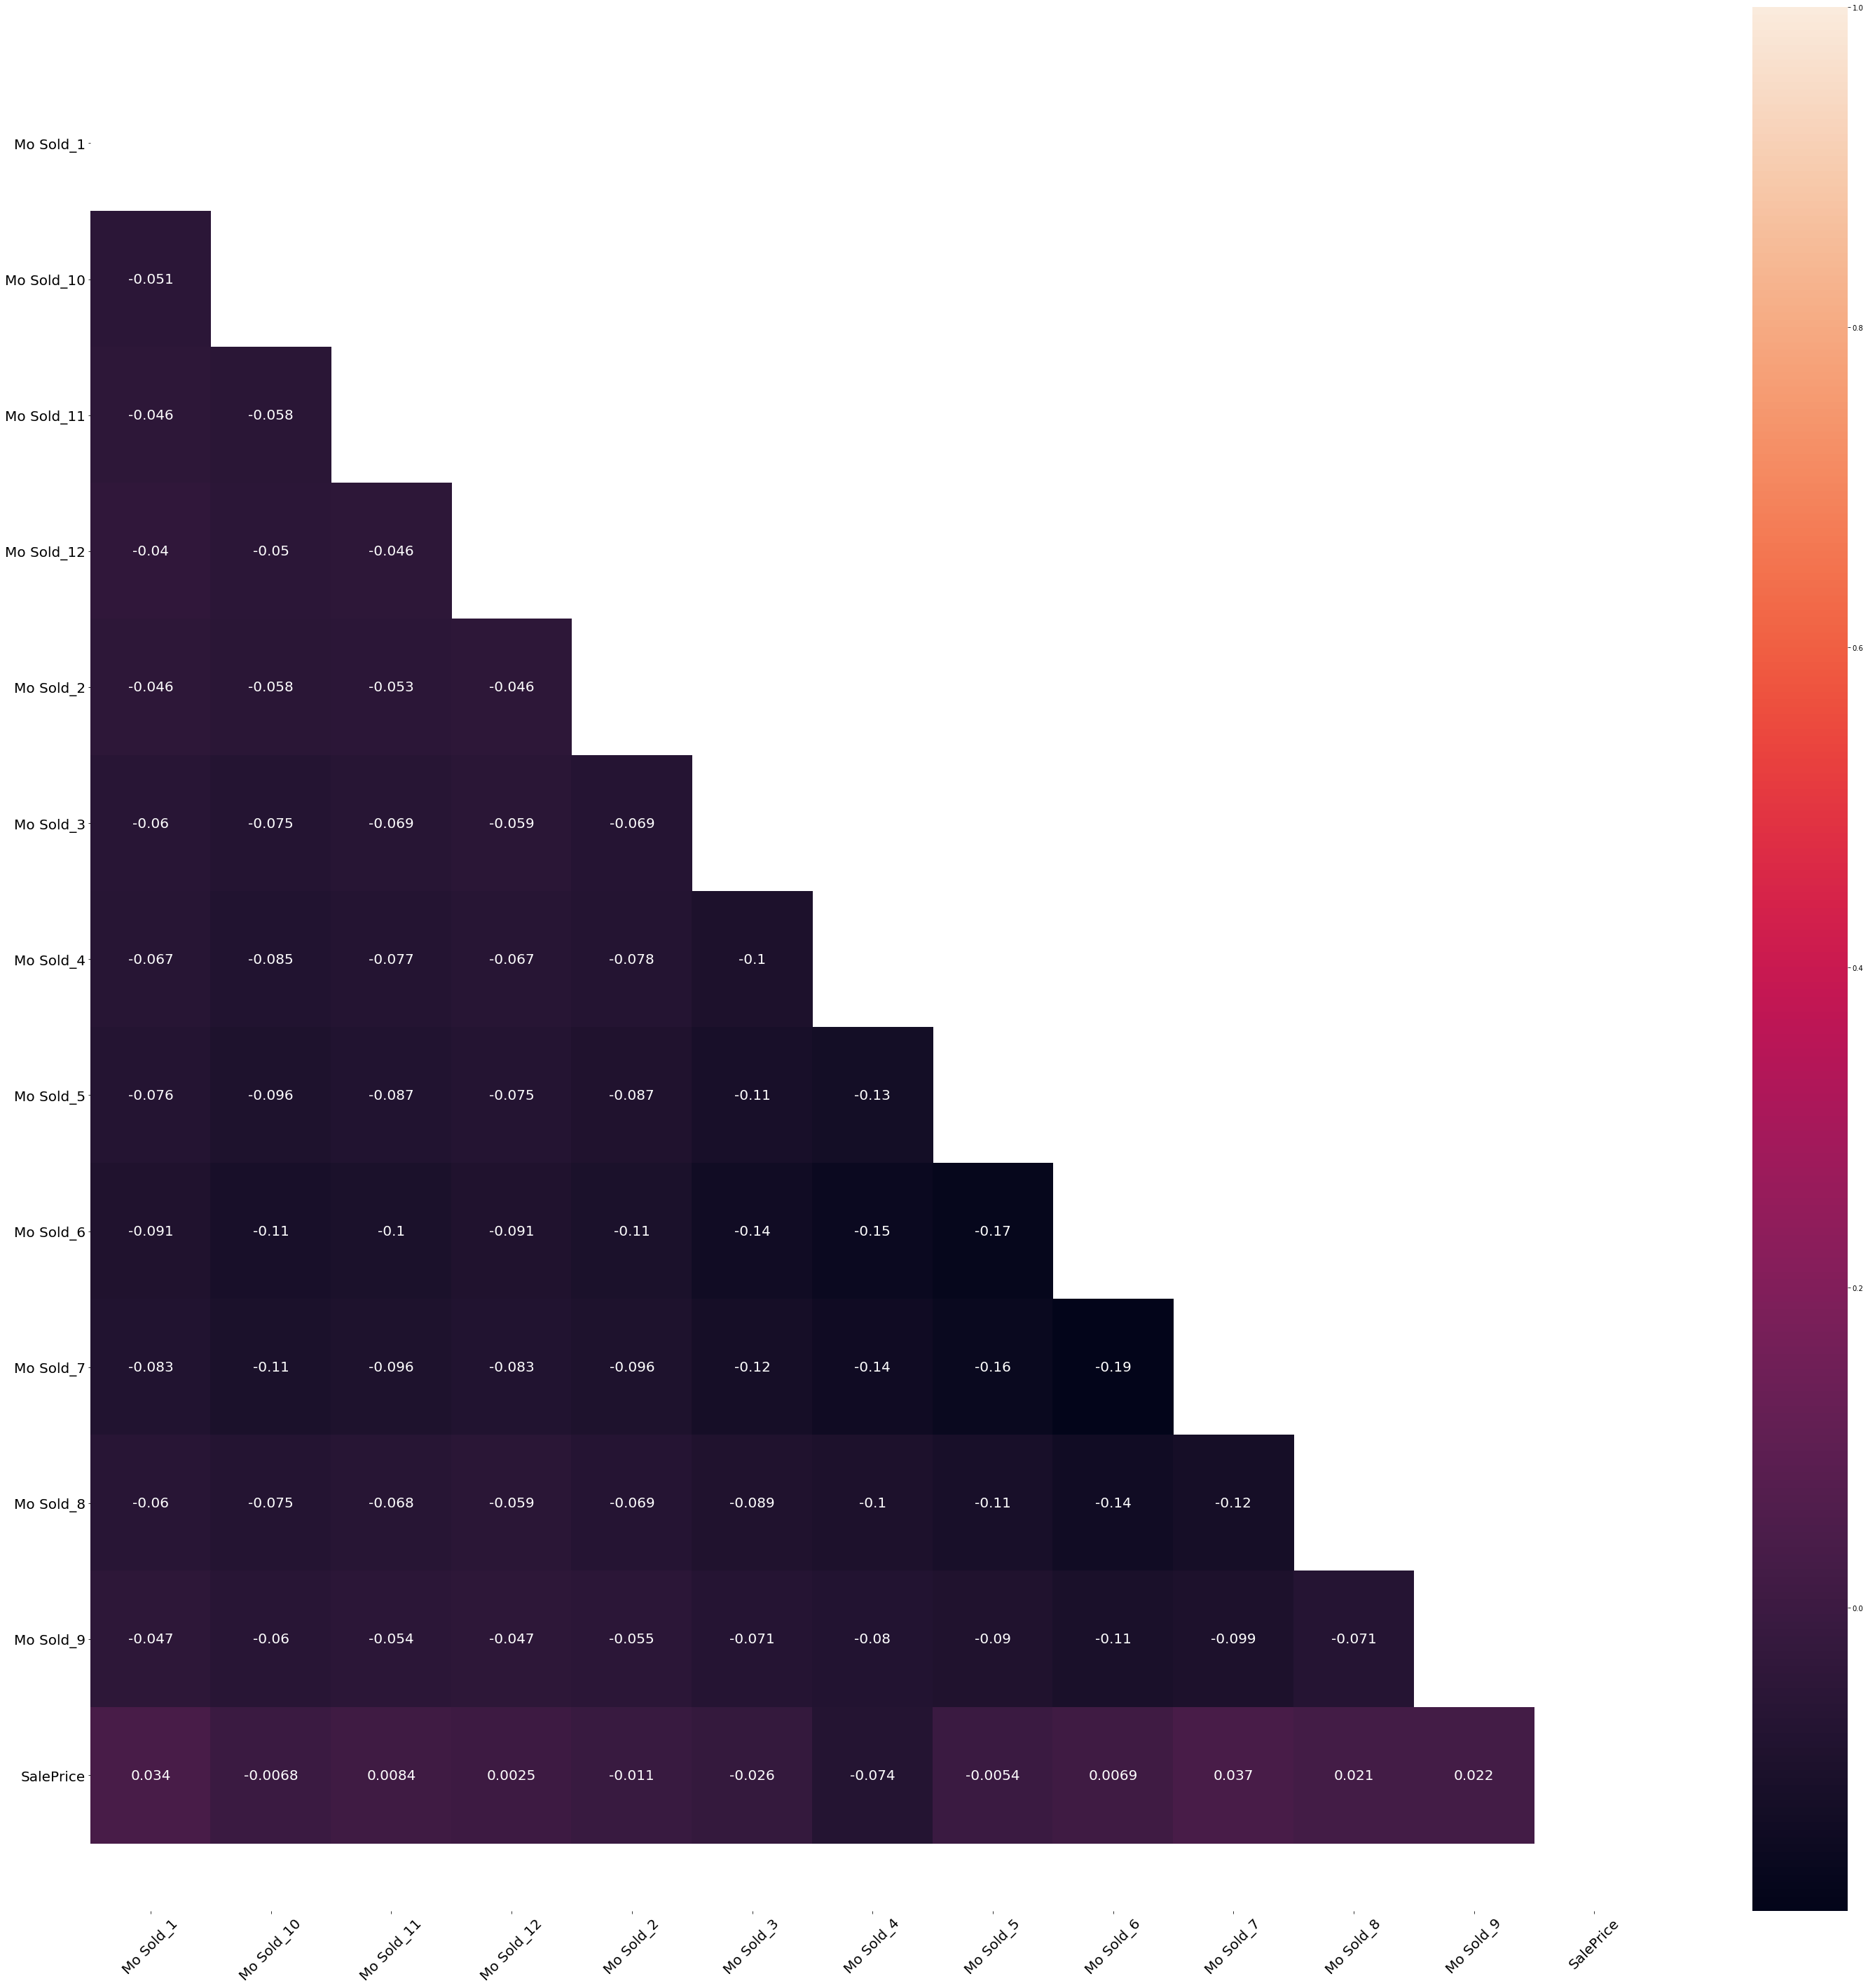

In [128]:
check_corr_func('Mo Sold','Nominal','Yes','')

# treatd as nominal intead of discrete, due to months being cyclical and thus categorical

Yr Sold      0
SalePrice    0
dtype: int64
There are no entries with null values in 'Yr Sold'.

These are the value_counts.

2007    498
2009    446
2006    438
2008    435
2010    234
Name: Yr Sold, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Yr Sold    2051 non-null   int64
 1   SalePrice  2051 non-null   int64
dtypes: int64(2)
memory usage: 32.2 KB
None


           Yr Sold      SalePrice
count  2051.000000    2051.000000
mean   2007.775719  181469.701609
std       1.312014   79258.659352
min    2006.000000   12789.000000
25%    2007.000000  129825.000000
50%    2008.000000  162500.000000
75%    2009.000000  214000.000000
max    2010.000000  611657.000000


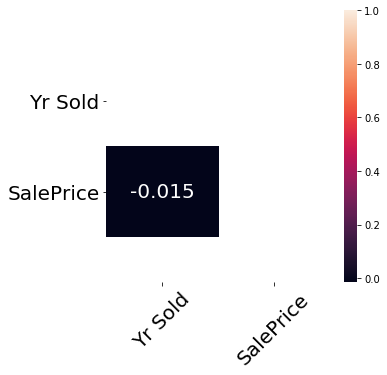

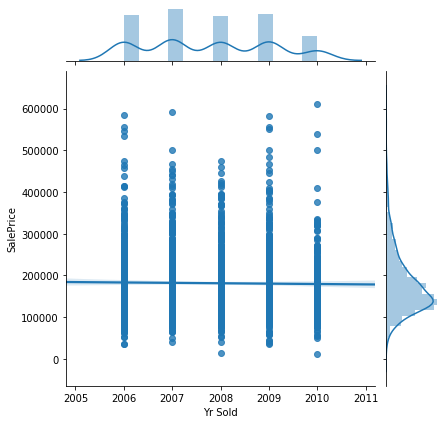

In [129]:
check_corr_func('Yr Sold','Discrete','Yes','')

Sale Type    0
SalePrice    0
dtype: int64
There are no entries with null values in 'Sale Type'.

These are the value_counts.

WD       1781
New       160
COD        63
ConLD      17
CWD        10
ConLI       7
ConLw       5
Con         4
Oth         4
Name: Sale Type, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sale Type_COD    2051 non-null   uint8
 1   Sale Type_CWD    2051 non-null   uint8
 2   Sale Type_Con    2051 non-null   uint8
 3   Sale Type_ConLD  2051 non-null   uint8
 4   Sale Type_ConLI  2051 non-null   uint8
 5   Sale Type_ConLw  2051 non-null   uint8
 6   Sale Type_New    2051 non-null   uint8
 7   Sale Type_Oth    2051 non-null   uint8
 8   Sale Type_WD     2051 non-null   uint8
 9   SalePrice        2051 non-null   int64
dtypes: int64(1), uint8(9)
memory usage: 34.2 KB
None


       Sale Type_COD  Sa

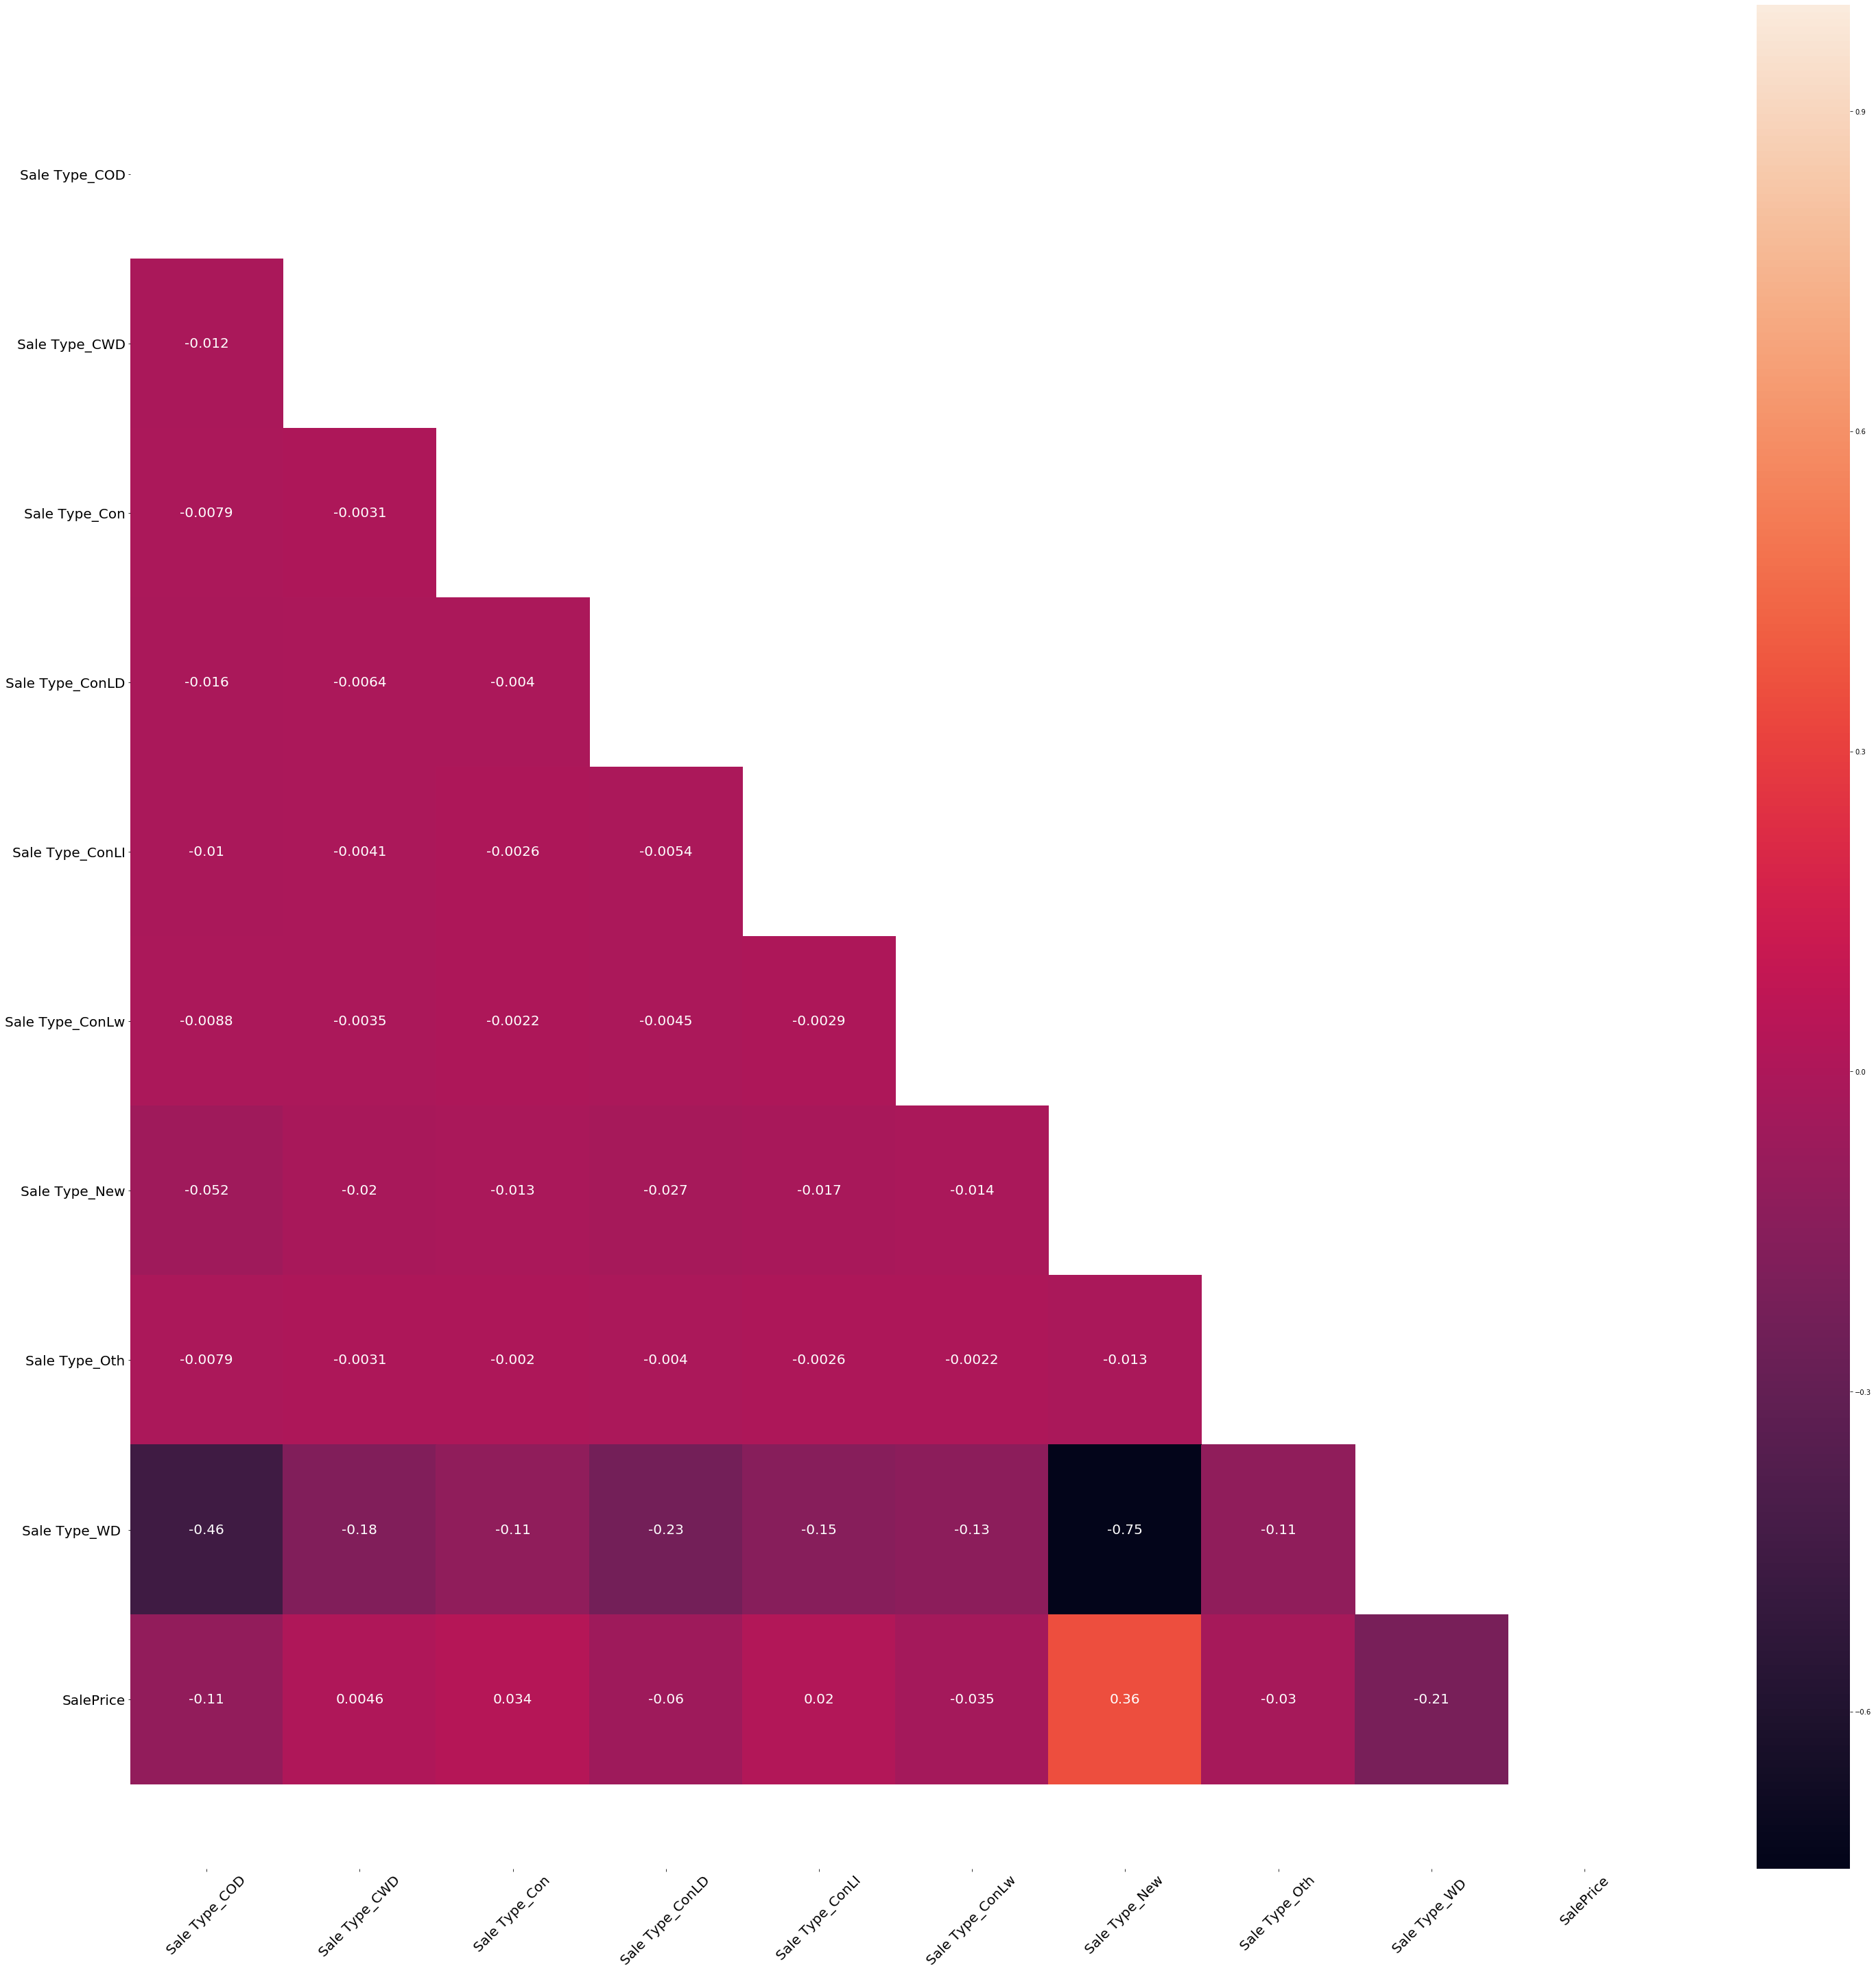

In [130]:
check_corr_func('Sale Type','Nominal','Yes','')

In [ ]:
## End of File